# Masters Paper: AI Sycophancy and Moral Foundations Analysis

This notebook analyzes AI chatbot sycophancy by comparing baseline responses (no user context) with conditioned responses (with user identity context).

## Dataset Overview
- **Baseline Probabilities** (`empty_A`, `empty_B`): Model's response probabilities WITHOUT user identity context
- **Conditioned Probabilities** (`agree_A`, `agree_B`): Model's response probabilities WITH identity A's moral foundation context  
- **Identity Variables** (`identityA`, `identityB`): Moral foundation groups being compared
- **Topic**: Policy areas being discussed

## Analysis Goals
1. Calculate sycophancy scores comparing baseline vs conditioned responses
2. Visualize sycophancy patterns across different dimensions
3. Analyze differences by identity groups and topics


## Setup and Data Loading


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully")


Libraries imported successfully


In [61]:
# Load the dataset
df = pd.read_csv('/Users/mi4616ma/Desktop/Hanna Bäack\'s project/code/Analysis (Moralizing Rating on all speeches)/cleaned_analysis_mater_thesis_data.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 3 rows:")
print(df.head(3))

# Check key variables exist
print(f"\nKey variables found:")
print(f"  Baseline: {[c for c in df.columns if 'empty' in c]}")
print(f"  Conditioned: {[c for c in df.columns if 'agree' in c]}")

# Check ALL identities in the original dataset
print(f"\n=== ORIGINAL DATASET IDENTITIES ===")
if 'identityA' in df.columns:
    unique_identityA = sorted(df['identityA'].unique())
    print(f"Unique identityA values: {unique_identityA}")
if 'identityB' in df.columns:
    unique_identityB = sorted(df['identityB'].unique())
    print(f"Unique identityB values: {unique_identityB}")

# Check if liberty_oppression exists in original data
all_identities = set()
if 'identityA' in df.columns:
    all_identities.update(df['identityA'].unique())
if 'identityB' in df.columns:
    all_identities.update(df['identityB'].unique())

print(f"\nALL UNIQUE IDENTITIES IN ORIGINAL DATA: {sorted(all_identities)}")

if 'liberty_oppression' in all_identities:
    print("✓ liberty_oppression FOUND in original dataset!")
    if 'identityA' in df.columns:
        countA = (df['identityA'] == 'liberty_oppression').sum()
        print(f"  liberty_oppression appears {countA} times as identityA")
    if 'identityB' in df.columns:
        countB = (df['identityB'] == 'liberty_oppression').sum()
        print(f"  liberty_oppression appears {countB} times as identityB")
else:
    print("⚠️  liberty_oppression NOT FOUND in original dataset!")
    liberty_like = [id for id in all_identities if 'liberty' in str(id).lower() or 'oppress' in str(id).lower()]
    print(f"  Liberty/oppression-like identities: {liberty_like}")

Dataset shape: (41292, 34)

Columns: ['question', 'option_A', 'option_B', 'agree_A', 'agree_B', 'empty_A', 'empty_B', 'disagree_A', 'disagree_B', 'model', 'identityA', 'identityB', 'topic', 'question_word_count', 'option_A_word_count', 'option_B_word_count', 'length_diff_AB', 'empty_A_logit', 'empty_B_logit', 'agree_A_logit', 'agree_B_logit', 'more_aligned_side', 'alignment_diff', 'abs_alignment_diff', 'pct_change_A_to_B', 'abs_pct_change', 'logit_change_A_to_B', 'abs_logit_change', 'aligned_side_logit_change', 'aligned_side_pct', 'option_A_long', 'option_B_long', 'baseline_extremity_A', 'baseline_extremity_B']

First 3 rows:
                                            question  \
0  Should the government prioritize funding for r...   
1  Should the government implement carbon pricing...   
2  Should the government invest in public transpo...   

                                            option_A  \
0  Investing in renewable energy research and dev...   
1  Carbon pricing and cap-and

In [141]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

print("=== KEY DESCRIPTIVE STATISTICS FOR SYCOPHANCY PAPER ===")

# Assuming your dataframe is called 'df'
if 'df' in locals() or 'df' in globals():
    
    print(f"\n1. SAMPLE CHARACTERISTICS")
    print("=" * 50)
    print(f"Total observations: {len(df):,}")
    print(f"Total variables: {len(df.columns)}")
    
    # Model distribution
    if 'model' in df.columns:
        model_counts = df['model'].value_counts()
        print(f"\nModel Distribution:")
        for model, count in model_counts.items():
            pct = (count/len(df)*100)
            print(f"  {model}: {count:,} ({pct:.1f}%)")
    
    # Topic distribution
    if 'topic' in df.columns:
        topic_counts = df['topic'].value_counts()
        print(f"\nTopic Distribution:")
        for topic, count in topic_counts.items():
            pct = (count/len(df)*100)
            print(f"  {topic}: {count:,} ({pct:.1f}%)")
    
    # Moral foundation distribution
    print(f"\nMoral Foundation Pairs:")
    if 'identityA' in df.columns and 'identityB' in df.columns:
        foundation_pairs = df.groupby(['identityA', 'identityB']).size().reset_index(name='count')
        foundation_pairs['percentage'] = (foundation_pairs['count'] / len(df) * 100).round(1)
        print(foundation_pairs.to_string(index=False))
    
    print(f"\n2. BASELINE RESPONSE PATTERNS")
    print("=" * 50)
    
    # Baseline agreement rates
    baseline_cols = ['empty_A', 'empty_B']
    conditioned_cols = ['agree_A', 'agree_B']
    
    for col in baseline_cols + conditioned_cols:
        if col in df.columns:
            mean_val = df[col].mean()
            median_val = df[col].median()
            std_val = df[col].std()
            print(f"{col}:")
            print(f"  Mean: {mean_val:.2f}% (SD: {std_val:.2f})")
            print(f"  Median: {median_val:.2f}%")
            print(f"  Range: {df[col].min():.2f}% - {df[col].max():.2f}%")
    
    print(f"\n3. SYCOPHANCY EFFECT SIZES BY MORAL FOUNDATION")
    print("=" * 50)
    
    # Calculate sycophancy for each moral foundation pair
    sycophancy_by_foundation = []
    
    if 'identityA' in df.columns and 'identityB' in df.columns:
        for identity_a in df['identityA'].unique():
            for identity_b in df['identityB'].unique():
                subset = df[(df['identityA'] == identity_a) & (df['identityB'] == identity_b)]
                
                if len(subset) > 0 and 'empty_A' in df.columns and 'agree_A' in df.columns:
                    # Calculate directional sycophancy for side A
                    baseline_a = subset['empty_A'].mean()
                    conditioned_a = subset['agree_A'].mean()
                    sycophancy_a = conditioned_a - baseline_a
                    
                    # Calculate directional sycophancy for side B  
                    baseline_b = subset['empty_B'].mean()
                    conditioned_b = subset['agree_B'].mean()
                    sycophancy_b = conditioned_b - baseline_b
                    
                    # Absolute sycophancy (average of both sides)
                    abs_sycophancy = (abs(sycophancy_a) + abs(sycophancy_b)) / 2
                    
                    sycophancy_by_foundation.append({
                        'Identity_A': identity_a,
                        'Identity_B': identity_b,
                        'Pair': f"{identity_a} vs {identity_b}",
                        'N': len(subset),
                        'Baseline_A': baseline_a,
                        'Conditioned_A': conditioned_a,
                        'Sycophancy_A': sycophancy_a,
                        'Baseline_B': baseline_b,
                        'Conditioned_B': conditioned_b,
                        'Sycophancy_B': sycophancy_b,
                        'Abs_Sycophancy': abs_sycophancy
                    })
    
    if sycophancy_by_foundation:
        syc_df = pd.DataFrame(sycophancy_by_foundation)
        
        print("Sycophancy Effects by Moral Foundation Pair:")
        print("-" * 80)
        display_cols = ['Pair', 'N', 'Sycophancy_A', 'Sycophancy_B', 'Abs_Sycophancy']
        syc_display = syc_df[display_cols].copy()
        syc_display['Sycophancy_A'] = syc_display['Sycophancy_A'].round(2)
        syc_display['Sycophancy_B'] = syc_display['Sycophancy_B'].round(2)
        syc_display['Abs_Sycophancy'] = syc_display['Abs_Sycophancy'].round(2)
        print(syc_display.to_string(index=False))
        
        print(f"\nOverall Sycophancy Summary:")
        print(f"  Mean absolute sycophancy: {syc_df['Abs_Sycophancy'].mean():.2f} pp")
        print(f"  SD absolute sycophancy: {syc_df['Abs_Sycophancy'].std():.2f} pp")
        print(f"  Range: {syc_df['Abs_Sycophancy'].min():.2f} - {syc_df['Abs_Sycophancy'].max():.2f} pp")
    
    print(f"\n4. MODEL COMPARISON")
    print("=" * 50)
    
    if 'model' in df.columns:
        model_sycophancy = []
        
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            
            if 'empty_A' in df.columns and 'agree_A' in df.columns:
                # Calculate average sycophancy for this model
                syc_a = (model_data['agree_A'] - model_data['empty_A']).abs().mean()
                syc_b = (model_data['agree_B'] - model_data['empty_B']).abs().mean()
                avg_sycophancy = (syc_a + syc_b) / 2
                
                model_sycophancy.append({
                    'Model': model,
                    'N': len(model_data),
                    'Avg_Abs_Sycophancy': avg_sycophancy,
                    'Baseline_A_Mean': model_data['empty_A'].mean(),
                    'Baseline_B_Mean': model_data['empty_B'].mean()
                })
        
        if model_sycophancy:
            model_df = pd.DataFrame(model_sycophancy)
            print("Sycophancy by Model:")
            for _, row in model_df.iterrows():
                print(f"  {row['Model']}: {row['Avg_Abs_Sycophancy']:.2f} pp (N = {row['N']:,})")
    
    print(f"\n5. TOPIC-WISE SYCOPHANCY")
    print("=" * 50)
    
    if 'topic' in df.columns:
        topic_sycophancy = []
        
        for topic in df['topic'].unique():
            topic_data = df[df['topic'] == topic]
            
            if 'empty_A' in df.columns and 'agree_A' in df.columns:
                syc_a = (topic_data['agree_A'] - topic_data['empty_A']).abs().mean()
                syc_b = (topic_data['agree_B'] - topic_data['empty_B']).abs().mean()
                avg_sycophancy = (syc_a + syc_b) / 2
                
                topic_sycophancy.append({
                    'Topic': topic,
                    'N': len(topic_data),
                    'Avg_Abs_Sycophancy': avg_sycophancy
                })
        
        if topic_sycophancy:
            topic_df = pd.DataFrame(topic_sycophancy)
            topic_df = topic_df.sort_values('Avg_Abs_Sycophancy', ascending=False)
            
            print("Sycophancy by Topic (ranked):")
            for i, (_, row) in enumerate(topic_df.iterrows(), 1):
                print(f"  {i}. {row['Topic']}: {row['Avg_Abs_Sycophancy']:.2f} pp (N = {row['N']:,})")
    
    print(f"\n6. BASELINE MODEL PREFERENCES")
    print("=" * 50)
    
    # Analyze baseline preferences by moral foundation
    if 'identityA' in df.columns and 'empty_A' in df.columns:
        print("Baseline Agreement Rates by Moral Foundation:")
        
        baseline_prefs = []
        for identity in df['identityA'].unique():
            side_a_data = df[df['identityA'] == identity]['empty_A']
            side_b_data = df[df['identityA'] == identity]['empty_B']
            
            baseline_prefs.append({
                'Identity': identity,
                'Side_A_Baseline': side_a_data.mean(),
                'Side_B_Baseline': side_b_data.mean(),
                'Preference': 'A' if side_a_data.mean() > side_b_data.mean() else 'B',
                'Preference_Magnitude': abs(side_a_data.mean() - side_b_data.mean())
            })
        
        baseline_df = pd.DataFrame(baseline_prefs)
        baseline_df = baseline_df.sort_values('Preference_Magnitude', ascending=False)
        
        for _, row in baseline_df.iterrows():
            print(f"  {row['Identity']}: Prefers side {row['Preference']} by {row['Preference_Magnitude']:.1f} pp")
    
    print(f"\n7. STATISTICAL SIGNIFICANCE TESTS")
    print("=" * 50)
    
    # Test if sycophancy effects are significantly different from zero
    if 'empty_A' in df.columns and 'agree_A' in df.columns:
        sycophancy_a = df['agree_A'] - df['empty_A']
        sycophancy_b = df['agree_B'] - df['empty_B']
        
        # One-sample t-tests against zero
        t_stat_a, p_val_a = stats.ttest_1samp(sycophancy_a.dropna(), 0)
        t_stat_b, p_val_b = stats.ttest_1samp(sycophancy_b.dropna(), 0)
        
        print("One-sample t-tests (H0: sycophancy = 0):")
        print(f"  Side A: t = {t_stat_a:.2f}, p = {p_val_a:.4f}")
        print(f"  Side B: t = {t_stat_b:.2f}, p = {p_val_b:.4f}")
        
        # Effect sizes (Cohen's d)
        cohens_d_a = sycophancy_a.mean() / sycophancy_a.std()
        cohens_d_b = sycophancy_b.mean() / sycophancy_b.std()
        
        print(f"\nEffect sizes (Cohen's d):")
        print(f"  Side A: d = {cohens_d_a:.3f}")
        print(f"  Side B: d = {cohens_d_b:.3f}")
    
    print(f"\n8. KEY SUMMARY STATISTICS FOR PAPER")
    print("=" * 50)
    
    # Create publication-ready summary
    summary_stats = {
        'Total N': f"{len(df):,}",
        'Models tested': len(df['model'].unique()) if 'model' in df.columns else 'N/A',
        'Topics covered': len(df['topic'].unique()) if 'topic' in df.columns else 'N/A',
        'Moral foundation pairs': len(df.groupby(['identityA', 'identityB'])) if 'identityA' in df.columns else 'N/A'
    }
    
    if 'empty_A' in df.columns and 'agree_A' in df.columns:
        overall_sycophancy = ((df['agree_A'] - df['empty_A']).abs() + 
                             (df['agree_B'] - df['empty_B']).abs()) / 2
        summary_stats.update({
            'Mean sycophancy effect': f"{overall_sycophancy.mean():.1f} pp",
            'Sycophancy SD': f"{overall_sycophancy.std():.1f} pp",
            'Sycophancy range': f"{overall_sycophancy.min():.1f} - {overall_sycophancy.max():.1f} pp"
        })
    
    print("Summary for Methods/Results section:")
    for key, value in summary_stats.items():
        print(f"  {key}: {value}")

else:
    print("Error: Dataframe 'df' not found.")
    print("Please ensure your dataset is loaded as 'df' before running this code.")

print(f"\n" + "=" * 60)
print("NOTES FOR PAPER:")
print("- pp = percentage points")
print("- All sycophancy effects measured as |conditioned - baseline|")
print("- Side A typically represents left-leaning moral foundations")
print("- Side B typically represents right-leaning moral foundations")
print("- Statistical significance: p < .05 (*), p < .01 (**), p < .001 (***)")

=== KEY DESCRIPTIVE STATISTICS FOR SYCOPHANCY PAPER ===

1. SAMPLE CHARACTERISTICS
Total observations: 82,584
Total variables: 8

Model Distribution:
  gpt_3_5: 41,292 (50.0%)
  gpt_4: 41,292 (50.0%)

Topic Distribution:
  Climate Change: 8,476 (10.3%)
  Globalization: 8,356 (10.1%)
  Technology and surveillance: 8,356 (10.1%)
  Healthcare: 8,296 (10.0%)
  Law and Order: 8,252 (10.0%)
  Defense and Military: 8,216 (9.9%)
  Economic Policies: 8,200 (9.9%)
  Immigration: 8,196 (9.9%)
  Media Freedom: 8,156 (9.9%)
  Social Equality and Rights: 8,080 (9.8%)

Moral Foundation Pairs:

2. BASELINE RESPONSE PATTERNS

3. SYCOPHANCY EFFECT SIZES BY MORAL FOUNDATION

4. MODEL COMPARISON

5. TOPIC-WISE SYCOPHANCY

6. BASELINE MODEL PREFERENCES

7. STATISTICAL SIGNIFICANCE TESTS

8. KEY SUMMARY STATISTICS FOR PAPER
Summary for Methods/Results section:
  Total N: 82,584
  Models tested: 2
  Topics covered: 10
  Moral foundation pairs: N/A

NOTES FOR PAPER:
- pp = percentage points
- All sycophancy e

## Sycophancy Score Calculation

Sycophancy occurs when the AI model changes its response based on the user's identity context. We calculate several measures:

1. **Absolute Sycophancy**: `|conditioned_prob - baseline_prob|`
2. **Directional Sycophancy**: `conditioned_prob - baseline_prob` 
3. **Relative Sycophancy**: `(conditioned_prob - baseline_prob) / baseline_prob`
4. **Logit Change**: `logit(conditioned_prob) - logit(baseline_prob)`


In [62]:
print("=== SYCOPHANCY SCORE CALCULATION ===")

if df is not None:
    # Create a working copy
    df_syc = df.copy()
    
    # Identify baseline and conditioned probability columns
    baseline_cols = [col for col in df_syc.columns if 'empty' in col.lower()]
    conditioned_cols = [col for col in df_syc.columns if 'agree' in col.lower()]
    
    print(f"Baseline columns found: {baseline_cols}")
    print(f"Conditioned columns found: {conditioned_cols}")
    
    # Function to safely convert to numeric and handle edge cases
    def safe_logit(p, epsilon=1e-8):
        """Convert probability to logit with epsilon smoothing"""
        p = np.clip(p, epsilon, 1 - epsilon)
        return np.log(p / (1 - p))
    
    # Calculate sycophancy scores for each pair
    sycophancy_scores = []
    
    if len(baseline_cols) > 0 and len(conditioned_cols) > 0:
        # Try to match baseline and conditioned columns
        # Look for patterns like empty_A -> agree_A, empty_B -> agree_B
        
        for baseline_col in baseline_cols:
            # Extract identifier (A, B, etc.)
            baseline_id = baseline_col.split('_')[-1] if '_' in baseline_col else ''
            
            # Find matching conditioned column
            matching_conditioned = None
            for cond_col in conditioned_cols:
                if baseline_id and baseline_id in cond_col:
                    matching_conditioned = cond_col
                    break
            
            if matching_conditioned is None and len(conditioned_cols) > 0:
                # If no exact match, use first available
                matching_conditioned = conditioned_cols[0]
            
            if matching_conditioned:
                print(f"\\nCalculating sycophancy: {baseline_col} -> {matching_conditioned}")
                
                # Ensure columns are numeric
                baseline_vals = pd.to_numeric(df_syc[baseline_col], errors='coerce')
                conditioned_vals = pd.to_numeric(df_syc[matching_conditioned], errors='coerce')
                
                # Remove rows with missing values
                valid_mask = ~(baseline_vals.isna() | conditioned_vals.isna())
                baseline_vals = baseline_vals[valid_mask]
                conditioned_vals = conditioned_vals[valid_mask]
                
                print(f"Valid observations: {len(baseline_vals)}")
                
                if len(baseline_vals) > 0:
                    # Calculate different sycophancy measures
                    abs_sycophancy = np.abs(conditioned_vals - baseline_vals)
                    directional_sycophancy = conditioned_vals - baseline_vals
                    
                    # Relative sycophancy (handle division by zero)
                    relative_sycophancy = np.where(
                        baseline_vals != 0,
                        (conditioned_vals - baseline_vals) / baseline_vals,
                        np.nan
                    )
                    
                    # Logit change
                    baseline_logits = safe_logit(baseline_vals)
                    conditioned_logits = safe_logit(conditioned_vals)
                    logit_change = conditioned_logits - baseline_logits
                    
                    # Store results
                    pair_data = df_syc[valid_mask].copy()
                    pair_data[f'baseline_{baseline_id}'] = baseline_vals
                    pair_data[f'conditioned_{baseline_id}'] = conditioned_vals
                    pair_data[f'abs_sycophancy_{baseline_id}'] = abs_sycophancy
                    pair_data[f'dir_sycophancy_{baseline_id}'] = directional_sycophancy
                    pair_data[f'rel_sycophancy_{baseline_id}'] = relative_sycophancy
                    pair_data[f'logit_change_{baseline_id}'] = logit_change
                    pair_data['comparison_pair'] = baseline_id
                    
                    sycophancy_scores.append(pair_data)
                    
                    # Print summary statistics
                    print(f"  Mean absolute sycophancy: {abs_sycophancy.mean():.4f}")
                    print(f"  Mean directional sycophancy: {directional_sycophancy.mean():.4f}")
                    print(f"  Mean relative sycophancy: {np.nanmean(relative_sycophancy):.4f}")
                    print(f"  Mean logit change: {logit_change.mean():.4f}")
    
    # Combine all sycophancy data
    if sycophancy_scores:
        df_combined = pd.concat(sycophancy_scores, ignore_index=True)
        print(f"\\n=== OVERALL SYCOPHANCY SUMMARY ===")
        print(f"Total observations: {len(df_combined)}")
        print(f"Comparison pairs: {df_combined['comparison_pair'].nunique()}")
        
        # Overall statistics across all pairs
        abs_cols = [col for col in df_combined.columns if col.startswith('abs_sycophancy')]
        dir_cols = [col for col in df_combined.columns if col.startswith('dir_sycophancy')]
        logit_cols = [col for col in df_combined.columns if col.startswith('logit_change')]
        
        if abs_cols:
            overall_abs = df_combined[abs_cols].mean(axis=1)
            overall_dir = df_combined[dir_cols].mean(axis=1)
            overall_logit = df_combined[logit_cols].mean(axis=1)
            
            print(f"\\nOverall Statistics:")
            print(f"  Mean absolute sycophancy: {overall_abs.mean():.4f} (std: {overall_abs.std():.4f})")
            print(f"  Mean directional sycophancy: {overall_dir.mean():.4f} (std: {overall_dir.std():.4f})")
            print(f"  Mean logit change: {overall_logit.mean():.4f} (std: {overall_logit.std():.4f})")
            
            # Add overall measures to dataframe
            df_combined['overall_abs_sycophancy'] = overall_abs
            df_combined['overall_dir_sycophancy'] = overall_dir
            df_combined['overall_logit_change'] = overall_logit
        
        print("\\n✓ Sycophancy scores calculated successfully!")
        
    else:
        print("\\n⚠️  Could not calculate sycophancy scores - check column names")
        df_combined = df_syc.copy()
        
else:
    print("No data available for sycophancy calculation")


=== SYCOPHANCY SCORE CALCULATION ===
Baseline columns found: ['empty_A', 'empty_B', 'empty_A_logit', 'empty_B_logit']
Conditioned columns found: ['agree_A', 'agree_B', 'disagree_A', 'disagree_B', 'agree_A_logit', 'agree_B_logit']
\nCalculating sycophancy: empty_A -> agree_A
Valid observations: 41292
  Mean absolute sycophancy: 16.5231
  Mean directional sycophancy: 16.2302
  Mean relative sycophancy: 24530.4714
  Mean logit change: 2.7147
\nCalculating sycophancy: empty_B -> agree_B
Valid observations: 41292
  Mean absolute sycophancy: 43.4685
  Mean directional sycophancy: 43.2035
  Mean relative sycophancy: 72758.8043
  Mean logit change: 10.4740
\nCalculating sycophancy: empty_A_logit -> agree_A_logit
Valid observations: 41292
  Mean absolute sycophancy: 1.3927
  Mean directional sycophancy: 1.3383
  Mean relative sycophancy: -0.2416
  Mean logit change: 4.1036
\nCalculating sycophancy: empty_B_logit -> agree_A_logit
Valid observations: 41292
  Mean absolute sycophancy: 8.5167
  Mea

## Sycophancy Visualizations

Creating comprehensive visualizations to understand sycophancy patterns across different dimensions.


=== SYCOPHANCY VISUALIZATIONS ===


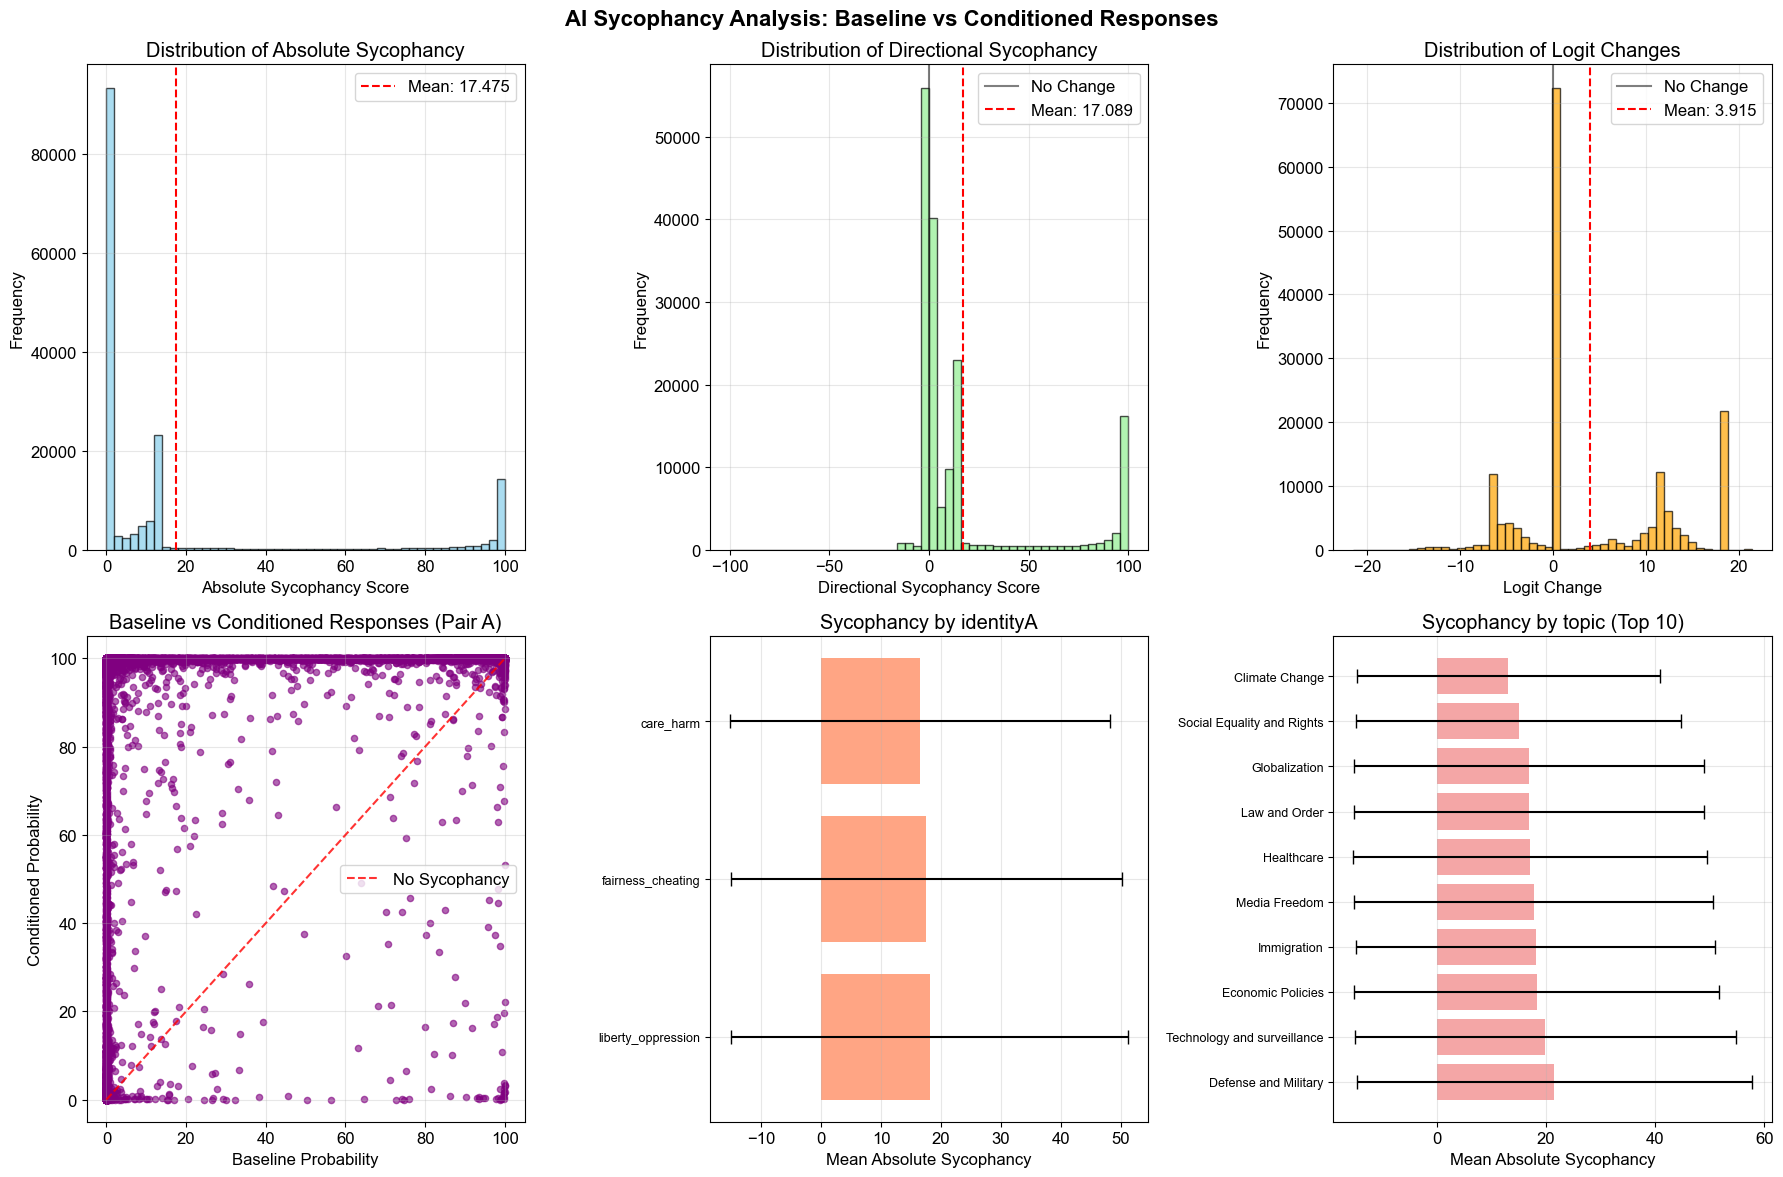

\n=== SYCOPHANCY SUMMARY STATISTICS ===
Absolute Sycophancy:
  Mean: 17.4752
  Median: 0.1664
  Std Dev: 32.5435
  Min: 0.0000
  Max: 100.0000
\nDirectional Sycophancy:
  Mean: 17.0892
  Median: 0.0970
  Std Dev: 32.7479
  % Positive (toward identity): 66.0%
  % Negative (away from identity): 5.1%
\n=== STATISTICAL TESTS ===
One-sample t-test (H0: mean directional sycophancy = 0):
  t-statistic: 212.0808
  p-value: 0.000000
  Result: Significant at α = 0.05


In [81]:
print("=== SYCOPHANCY VISUALIZATIONS ===")

if 'df_combined' in locals() and df_combined is not None:
    # Set up the plotting layout
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('AI Sycophancy Analysis: Baseline vs Conditioned Responses', fontsize=16, fontweight='bold')
    
    # Find sycophancy measure columns
    abs_syc_cols = [col for col in df_combined.columns if col.startswith('abs_sycophancy')]
    dir_syc_cols = [col for col in df_combined.columns if col.startswith('dir_sycophancy')]
    logit_cols = [col for col in df_combined.columns if col.startswith('logit_change')]
    
    if 'overall_abs_sycophancy' in df_combined.columns:
        # Plot 1: Distribution of Absolute Sycophancy
        axes[0,0].hist(df_combined['overall_abs_sycophancy'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].axvline(df_combined['overall_abs_sycophancy'].mean(), color='red', linestyle='--', 
                         label=f'Mean: {df_combined["overall_abs_sycophancy"].mean():.3f}')
        axes[0,0].set_xlabel('Absolute Sycophancy Score')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_title('Distribution of Absolute Sycophancy')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Plot 2: Distribution of Directional Sycophancy
        axes[0,1].hist(df_combined['overall_dir_sycophancy'].dropna(), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[0,1].axvline(0, color='black', linestyle='-', alpha=0.5, label='No Change')
        axes[0,1].axvline(df_combined['overall_dir_sycophancy'].mean(), color='red', linestyle='--',
                         label=f'Mean: {df_combined["overall_dir_sycophancy"].mean():.3f}')
        axes[0,1].set_xlabel('Directional Sycophancy Score')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].set_title('Distribution of Directional Sycophancy')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Plot 3: Logit Change Distribution
        if 'overall_logit_change' in df_combined.columns:
            axes[0,2].hist(df_combined['overall_logit_change'].dropna(), bins=50, alpha=0.7, color='orange', edgecolor='black')
            axes[0,2].axvline(0, color='black', linestyle='-', alpha=0.5, label='No Change')
            axes[0,2].axvline(df_combined['overall_logit_change'].mean(), color='red', linestyle='--',
                             label=f'Mean: {df_combined["overall_logit_change"].mean():.3f}')
            axes[0,2].set_xlabel('Logit Change')
            axes[0,2].set_ylabel('Frequency')
            axes[0,2].set_title('Distribution of Logit Changes')
            axes[0,2].legend()
            axes[0,2].grid(True, alpha=0.3)
        
        # Plot 4: Baseline vs Conditioned Scatter (using first pair)
        if len(abs_syc_cols) > 0:
            pair_id = abs_syc_cols[0].split('_')[-1]
            baseline_col = f'baseline_{pair_id}'
            conditioned_col = f'conditioned_{pair_id}'
            
            if baseline_col in df_combined.columns and conditioned_col in df_combined.columns:
                scatter_data = df_combined[[baseline_col, conditioned_col]].dropna()
                if len(scatter_data) > 0:
                    axes[1,0].scatter(scatter_data[baseline_col], scatter_data[conditioned_col], 
                                    alpha=0.6, s=20, color='purple')
                    
                    # Add diagonal line (no sycophancy)
                    min_val = min(scatter_data[baseline_col].min(), scatter_data[conditioned_col].min())
                    max_val = max(scatter_data[baseline_col].max(), scatter_data[conditioned_col].max())
                    axes[1,0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='No Sycophancy')
                    
                    axes[1,0].set_xlabel('Baseline Probability')
                    axes[1,0].set_ylabel('Conditioned Probability')
                    axes[1,0].set_title(f'Baseline vs Conditioned Responses (Pair {pair_id})')
                    axes[1,0].legend()
                    axes[1,0].grid(True, alpha=0.3)
        
        # Plot 5: Sycophancy by Identity Groups (if available)
        identity_cols = [col for col in df_combined.columns if 'identity' in col.lower()]
        if identity_cols:
            identity_col = identity_cols[0]
            identity_groups = df_combined[identity_col].value_counts().head(10)  # Top 10 groups
            
            if len(identity_groups) > 1:
                group_sycophancy = df_combined.groupby(identity_col)['overall_abs_sycophancy'].agg(['mean', 'std', 'count'])
                group_sycophancy = group_sycophancy[group_sycophancy['count'] >= 5].sort_values('mean', ascending=False)
                
                if len(group_sycophancy) > 0:
                    y_pos = range(len(group_sycophancy))
                    axes[1,1].barh(y_pos, group_sycophancy['mean'], xerr=group_sycophancy['std'], 
                                  alpha=0.7, color='coral', capsize=5)
                    axes[1,1].set_yticks(y_pos)
                    axes[1,1].set_yticklabels(group_sycophancy.index, fontsize=9)
                    axes[1,1].set_xlabel('Mean Absolute Sycophancy')
                    axes[1,1].set_title(f'Sycophancy by {identity_col}')
                    axes[1,1].grid(True, alpha=0.3)
        
        # Plot 6: Sycophancy by Topic (if available)
        topic_cols = [col for col in df_combined.columns if 'topic' in col.lower()]
        if topic_cols:
            topic_col = topic_cols[0]
            topic_sycophancy = df_combined.groupby(topic_col)['overall_abs_sycophancy'].agg(['mean', 'std', 'count'])
            topic_sycophancy = topic_sycophancy[topic_sycophancy['count'] >= 5].sort_values('mean', ascending=False)
            
            if len(topic_sycophancy) > 0:
                # Show top 10 topics
                top_topics = topic_sycophancy.head(10)
                y_pos = range(len(top_topics))
                axes[1,2].barh(y_pos, top_topics['mean'], xerr=top_topics['std'], 
                              alpha=0.7, color='lightcoral', capsize=5)
                axes[1,2].set_yticks(y_pos)
                axes[1,2].set_yticklabels(top_topics.index, fontsize=9)
                axes[1,2].set_xlabel('Mean Absolute Sycophancy')
                axes[1,2].set_title(f'Sycophancy by {topic_col} (Top 10)')
                axes[1,2].grid(True, alpha=0.3)
    
    # Remove empty subplots if they weren't filled
    for i in range(2):
        for j in range(3):
            if not axes[i,j].has_data():
                axes[i,j].text(0.5, 0.5, 'No Data\\nAvailable', ha='center', va='center', 
                              transform=axes[i,j].transAxes, fontsize=12, alpha=0.5)
                axes[i,j].set_xticks([])
                axes[i,j].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\\n=== SYCOPHANCY SUMMARY STATISTICS ===")
    if 'overall_abs_sycophancy' in df_combined.columns:
        abs_syc = df_combined['overall_abs_sycophancy'].dropna()
        dir_syc = df_combined['overall_dir_sycophancy'].dropna()
        
        print(f"Absolute Sycophancy:")
        print(f"  Mean: {abs_syc.mean():.4f}")
        print(f"  Median: {abs_syc.median():.4f}")
        print(f"  Std Dev: {abs_syc.std():.4f}")
        print(f"  Min: {abs_syc.min():.4f}")
        print(f"  Max: {abs_syc.max():.4f}")
        
        print(f"\\nDirectional Sycophancy:")
        print(f"  Mean: {dir_syc.mean():.4f}")
        print(f"  Median: {dir_syc.median():.4f}")
        print(f"  Std Dev: {dir_syc.std():.4f}")
        print(f"  % Positive (toward identity): {(dir_syc > 0).mean() * 100:.1f}%")
        print(f"  % Negative (away from identity): {(dir_syc < 0).mean() * 100:.1f}%")
        
        # Statistical tests
        print(f"\\n=== STATISTICAL TESTS ===")
        # Test if directional sycophancy is significantly different from 0
        t_stat, p_val = stats.ttest_1samp(dir_syc, 0)
        print(f"One-sample t-test (H0: mean directional sycophancy = 0):")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_val:.6f}")
        print(f"  Result: {'Significant' if p_val < 0.05 else 'Not significant'} at α = 0.05")
        
else:
    print("No sycophancy data available for visualization")


=== SYCOPHANCY VISUALIZATIONS ===


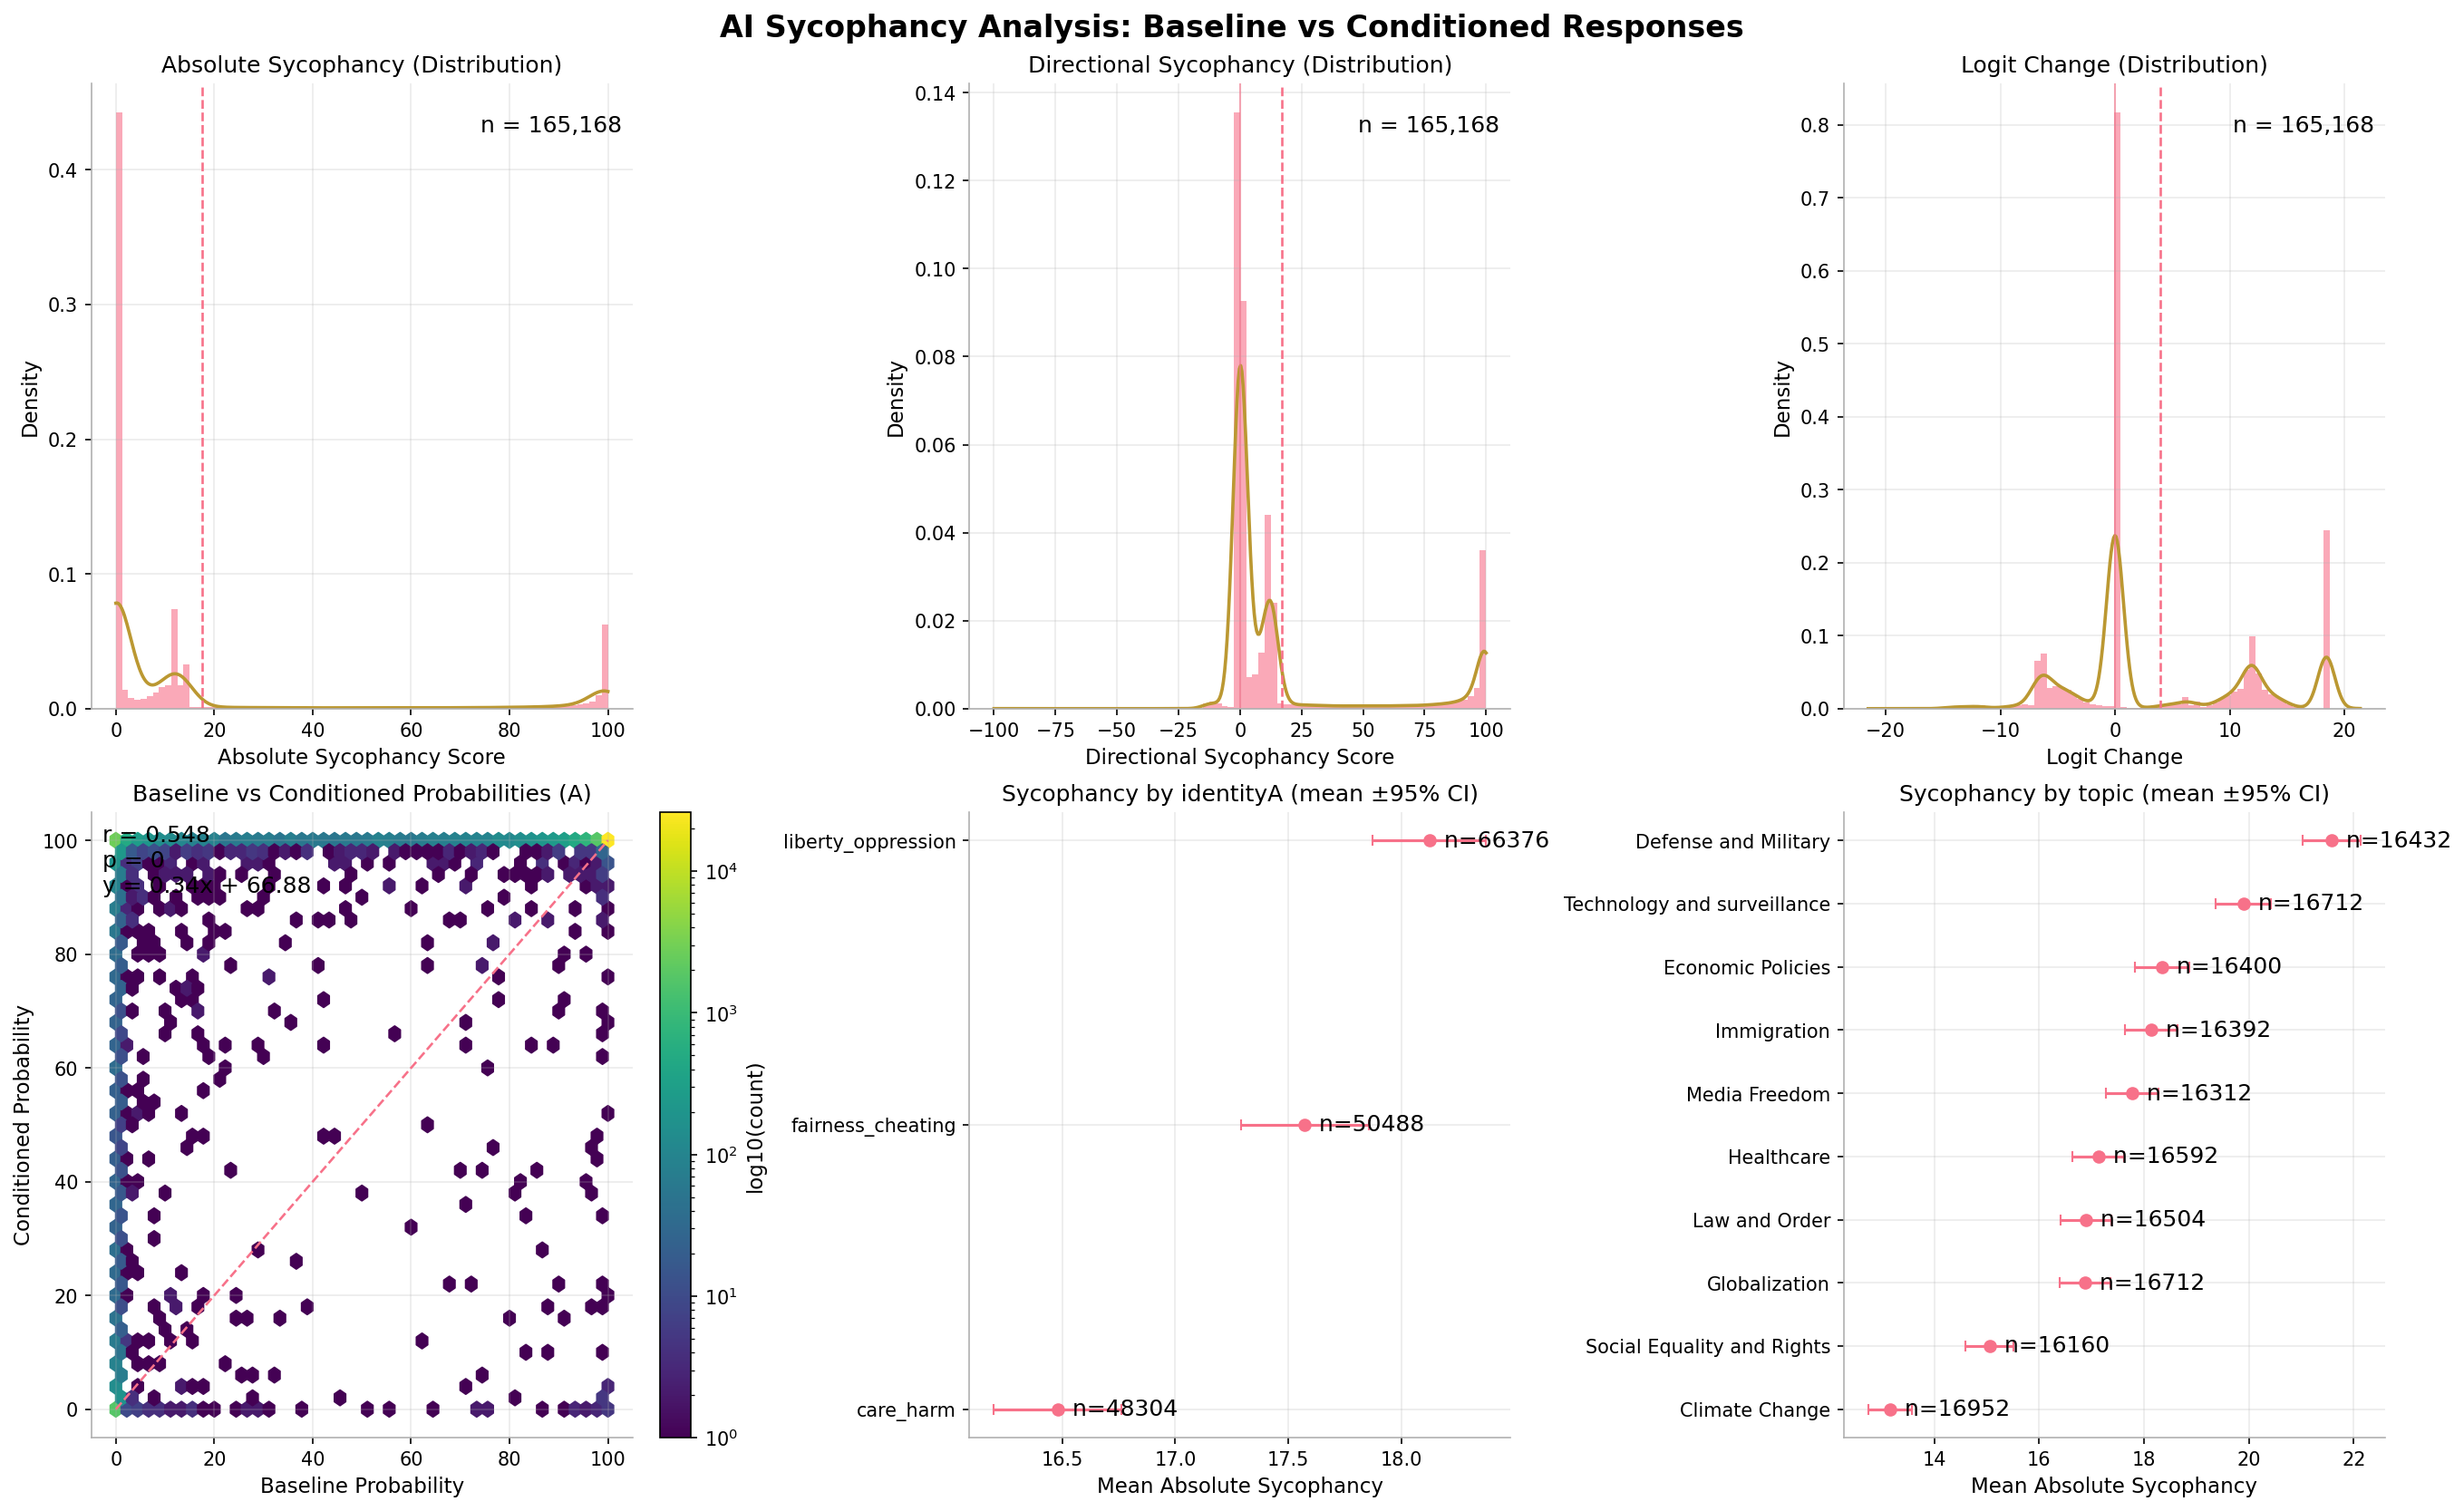


=== SYCOPHANCY SUMMARY STATISTICS ===
Absolute Sycophancy:
  Mean: 17.4752  (95% CI ±0.1569)   n=165,168
  Median: 0.1664
  Std Dev: 32.5435
  Min: 0.0000 | Max: 100.0000

Directional Sycophancy:
  Mean: 17.0892  (95% CI ±0.1579)   n=165,168
  Median: 0.0970
  Std Dev: 32.7479
  % Positive (toward identity): 66.0%
  % Negative (away from identity): 5.1%

=== STATISTICAL TESTS ===
One-sample t-test (H0: mean directional sycophancy = 0):
  t-statistic: 212.0808
  p-value: 0.000000
  Result: Significant at α = 0.05


In [83]:
# === SYCOPHANCY VISUALIZATIONS (Polished) ===
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

# ---- Global style (safe fallbacks) ----
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.family": "sans-serif",
    "font.sans-serif": ["Inter", "IBM Plex Sans", "DejaVu Sans", "Arial", "Helvetica"],
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "-",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Colorblind-friendly palette
PALETTE = ["#4E79A7", "#59A14F", "#F28E2B", "#E15759", "#76B7B2", "#B07AA1", "#EDC948"]

def _fd_bins(x, min_bins=20, max_bins=80):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    if x.size < 2:
        return 20
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    if iqr == 0:
        return 30
    h = 2 * iqr * (x.size ** (-1/3))
    if h <= 0:
        return 30
    bins = int(np.clip((x.max() - x.min()) / h, min_bins, max_bins))
    return max(bins, min_bins)

def _ci95_of_mean(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = x.size
    if n < 2:
        return (np.nan, np.nan, np.nan)  # mean, half-width, n
    mean = x.mean()
    sem = x.std(ddof=1) / np.sqrt(n)
    hw = 1.96 * sem
    return (mean, hw, n)

def _beautify(ax):
    ax.set_facecolor("white")
    ax.grid(True, axis="y", alpha=0.25)
    for side in ("left", "bottom"):
        ax.spines[side].set_linewidth(0.8)
        ax.spines[side].set_color("#B0B0B0")

def _hist_plus_kde(ax, series, title, xlabel, color):
    s = series.dropna()
    if s.empty:
        return False
    bins = _fd_bins(s.values)
    # Density histogram
    ax.hist(s.values, bins=bins, density=True, alpha=0.6, edgecolor="none")
    # KDE overlay (if enough data)
    if len(s) >= 20:
        kde = stats.gaussian_kde(s.values)
        xx = np.linspace(s.min(), s.max(), 400)
        ax.plot(xx, kde(xx), linewidth=1.75)
    # Mean line + n
    mean = s.mean()
    ax.axvline(mean, linestyle="--", linewidth=1.25)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")
    ax.text(0.98, 0.95, f"n = {len(s):,}", ha="right", va="top", transform=ax.transAxes)
    _beautify(ax)
    return True

def _dot_whisker(ax, group_means, group_sems, group_counts, labels, title, xlabel, color, max_groups=12):
    # Keep groups with n>=5, sort by mean desc, take top K
    data = [(m, se, c, lab) for m, se, c, lab in zip(group_means, group_sems, group_counts, labels) if c >= 5]
    if not data:
        return False
    data.sort(key=lambda t: t[0], reverse=True)
    data = data[:max_groups]
    means = [t[0] for t in data]
    sems = [t[1] for t in data]
    counts = [t[2] for t in data]
    labs = [t[3] for t in data]
    y = np.arange(len(means))[::-1]  # top at top
    # 95% CI whiskers
    cis = [1.96*se for se in sems]
    ax.errorbar(means, y, xerr=cis, fmt="o", capsize=3)
    ax.set_yticks(y, labs)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    # annotate counts
    for yi, m, n in zip(y, means, counts):
        ax.text(m, yi, f"  n={n}", va="center", ha="left")
    _beautify(ax)
    return True

def _first_matching_pair(df):
    # Try to align baseline_XXX with conditioned_XXX by suffix
    bcols = [c for c in df.columns if c.startswith("baseline_")]
    ccols = [c for c in df.columns if c.startswith("conditioned_")]
    if bcols and ccols:
        # map suffix after first underscore
        bmap = {c.split("baseline_", 1)[1]: c for c in bcols}
        cmap = {c.split("conditioned_", 1)[1]: c for c in ccols}
        common = sorted(set(bmap.keys()) & set(cmap.keys()))
        if common:
            key = common[0]
            return bmap[key], cmap[key], key
    # Fallback: try your previous pattern derived from abs_sycophancy_*
    abs_cols = [c for c in df.columns if c.startswith("abs_sycophancy_")]
    if abs_cols:
        suf = abs_cols[0].split("_")[-1]
        bcol = f"baseline_{suf}"
        ccol = f"conditioned_{suf}"
        if bcol in df.columns and ccol in df.columns:
            return bcol, ccol, suf
    return None, None, None

print("=== SYCOPHANCY VISUALIZATIONS ===")

if 'df_combined' in locals() and df_combined is not None:
    # Prepare figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 11), constrained_layout=True)
    fig.suptitle('AI Sycophancy Analysis: Baseline vs Conditioned Responses', fontsize=16, fontweight='bold')

    # --- Distributions (top row) ---
    has1 = has2 = has3 = False
    if 'overall_abs_sycophancy' in df_combined.columns:
        has1 = _hist_plus_kde(
            axes[0,0],
            df_combined['overall_abs_sycophancy'],
            "Absolute Sycophancy (Distribution)",
            "Absolute Sycophancy Score",
            PALETTE[0]
        )

    if 'overall_dir_sycophancy' in df_combined.columns:
        has2 = _hist_plus_kde(
            axes[0,1],
            df_combined['overall_dir_sycophancy'],
            "Directional Sycophancy (Distribution)",
            "Directional Sycophancy Score",
            PALETTE[1]
        )
        # Reference at 0 (no change)
        axes[0,1].axvline(0, linewidth=1, alpha=0.6)

    if 'overall_logit_change' in df_combined.columns:
        has3 = _hist_plus_kde(
            axes[0,2],
            df_combined['overall_logit_change'],
            "Logit Change (Distribution)",
            "Logit Change",
            PALETTE[2]
        )
        axes[0,2].axvline(0, linewidth=1, alpha=0.6)

    # --- Baseline vs Conditioned (bottom-left) ---
    bcol, ccol, key = _first_matching_pair(df_combined)
    has4 = False
    if bcol and ccol:
        sc_ax = axes[1,0]
        data = df_combined[[bcol, ccol]].dropna()
        if len(data) > 0:
            # density hexbin to reduce overplotting
            hb = sc_ax.hexbin(data[bcol], data[ccol], gridsize=45, bins='log')
            cb = fig.colorbar(hb, ax=sc_ax)
            cb.set_label("log10(count)")
            # 45-degree identity line
            mn = data.min().min()
            mx = data.max().max()
            sc_ax.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1.25)
            # correlation + simple fit
            r, p = stats.pearsonr(data[bcol], data[ccol])
            slope, intercept = np.polyfit(data[bcol], data[ccol], 1)
            sc_ax.text(0.02, 0.98, f"r = {r:.3f}\np = {p:.3g}\ny = {slope:.2f}x + {intercept:.2f}",
                       transform=sc_ax.transAxes, va="top", ha="left")
            sc_ax.set_title(f'Baseline vs Conditioned Probabilities ({key})')
            sc_ax.set_xlabel('Baseline Probability')
            sc_ax.set_ylabel('Conditioned Probability')
            _beautify(sc_ax)
            has4 = True

    # --- Sycophancy by Identity (dot + 95% CI) (bottom-middle) ---
    has5 = False
    identity_cols = [c for c in df_combined.columns if 'identity' in c.lower()]
    if identity_cols and 'overall_abs_sycophancy' in df_combined.columns:
        icol = identity_cols[0]
        grp = df_combined[[icol, 'overall_abs_sycophancy']].dropna()
        if not grp.empty:
            groups = []
            for g, sub in grp.groupby(icol):
                m, hw, n = _ci95_of_mean(sub['overall_abs_sycophancy'].values)
                groups.append((g, m, hw/1.96 if not np.isnan(hw) else np.nan, n))
            if groups:
                labels = [g[0] for g in groups]
                means  = [g[1] for g in groups]
                sems   = [g[2] for g in groups]
                counts = [g[3] for g in groups]
                has5 = _dot_whisker(
                    axes[1,1], means, sems, counts, labels,
                    f"Sycophancy by {icol} (mean ±95% CI)", "Mean Absolute Sycophancy", PALETTE[3]
                )

    # --- Sycophancy by Topic (dot + 95% CI) (bottom-right) ---
    has6 = False
    topic_cols = [c for c in df_combined.columns if 'topic' in c.lower()]
    if topic_cols and 'overall_abs_sycophancy' in df_combined.columns:
        tcol = topic_cols[0]
        grp = df_combined[[tcol, 'overall_abs_sycophancy']].dropna()
        if not grp.empty:
            groups = []
            for g, sub in grp.groupby(tcol):
                m, hw, n = _ci95_of_mean(sub['overall_abs_sycophancy'].values)
                groups.append((g, m, hw/1.96 if not np.isnan(hw) else np.nan, n))
            if groups:
                labels = [g[0] for g in groups]
                means  = [g[1] for g in groups]
                sems   = [g[2] for g in groups]
                counts = [g[3] for g in groups]
                has6 = _dot_whisker(
                    axes[1,2], means, sems, counts, labels,
                    f"Sycophancy by {tcol} (mean ±95% CI)", "Mean Absolute Sycophancy", PALETTE[4]
                )

    # Fill any empty panels with a gentle note
    flags = [(has1, (0,0)), (has2, (0,1)), (has3, (0,2)), (has4, (1,0)), (has5, (1,1)), (has6, (1,2))]
    for ok, (i, j) in flags:
        if not ok:
            ax = axes[i, j]
            ax.text(0.5, 0.55, "No Data\nAvailable", ha="center", va="center", transform=ax.transAxes, alpha=0.6)
            ax.set_xticks([]); ax.set_yticks([])
            _beautify(ax)

    # Optional: export high-res images
    # fig.savefig("sycophancy_dashboard.png", bbox_inches="tight")
    # fig.savefig("sycophancy_dashboard.pdf", bbox_inches="tight")

    plt.show()

    # === SUMMARY + TESTS (with 95% CI) ===
    print("\n=== SYCOPHANCY SUMMARY STATISTICS ===")
    if 'overall_abs_sycophancy' in df_combined.columns:
        abs_syc = df_combined['overall_abs_sycophancy'].dropna()
        dir_syc = df_combined['overall_dir_sycophancy'].dropna() if 'overall_dir_sycophancy' in df_combined.columns else None

        mean_abs, hw_abs, n_abs = _ci95_of_mean(abs_syc.values)
        print("Absolute Sycophancy:")
        print(f"  Mean: {mean_abs:.4f}  (95% CI ±{hw_abs:.4f})   n={n_abs:,}")
        print(f"  Median: {np.median(abs_syc):.4f}")
        print(f"  Std Dev: {np.std(abs_syc, ddof=1):.4f}")
        print(f"  Min: {np.min(abs_syc):.4f} | Max: {np.max(abs_syc):.4f}")

        if dir_syc is not None and len(dir_syc) > 0:
            mean_dir, hw_dir, n_dir = _ci95_of_mean(dir_syc.values)
            print("\nDirectional Sycophancy:")
            print(f"  Mean: {mean_dir:.4f}  (95% CI ±{hw_dir:.4f})   n={n_dir:,}")
            print(f"  Median: {np.median(dir_syc):.4f}")
            print(f"  Std Dev: {np.std(dir_syc, ddof=1):.4f}")
            print(f"  % Positive (toward identity): {(dir_syc > 0).mean() * 100:.1f}%")
            print(f"  % Negative (away from identity): {(dir_syc < 0).mean() * 100:.1f}%")

            print("\n=== STATISTICAL TESTS ===")
            t_stat, p_val = stats.ttest_1samp(dir_syc, 0)
            print("One-sample t-test (H0: mean directional sycophancy = 0):")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_val:.6f}")
            print(f"  Result: {'Significant' if p_val < 0.05 else 'Not significant'} at α = 0.05")
else:
    print("No sycophancy data available for visualization")


## Detailed Analysis by Groups

Analyzing sycophancy patterns across different identity groups, topics, and other relevant dimensions.


In [64]:
print("=== DETAILED GROUP ANALYSIS ===")

if 'df_combined' in locals() and df_combined is not None:
    
    # 1. IDENTITY GROUP ANALYSIS
    print("\\n1. IDENTITY GROUP ANALYSIS")
    identity_cols = [col for col in df_combined.columns if 'identity' in col.lower()]
    
    if identity_cols:
        for identity_col in identity_cols[:2]:  # Analyze first 2 identity columns
            print(f"\\n--- Analysis by {identity_col} ---")
            
            # Group statistics
            if 'overall_abs_sycophancy' in df_combined.columns:
                group_stats = df_combined.groupby(identity_col).agg({
                    'overall_abs_sycophancy': ['count', 'mean', 'std', 'median'],
                    'overall_dir_sycophancy': ['mean', 'std'],
                    'overall_logit_change': ['mean', 'std'] if 'overall_logit_change' in df_combined.columns else ['count']
                }).round(4)
                
                # Filter groups with sufficient data
                group_stats = group_stats[group_stats[('overall_abs_sycophancy', 'count')] >= 5]
                
                if len(group_stats) > 0:
                    print("Group Statistics (min 5 observations):")
                    print(group_stats.to_string())
                    
                    # Statistical tests between groups
                    groups = group_stats.index.tolist()
                    if len(groups) >= 2:
                        print(f"\\nPairwise Comparisons (t-tests):")
                        for i, group1 in enumerate(groups):
                            for group2 in groups[i+1:]:
                                data1 = df_combined[df_combined[identity_col] == group1]['overall_abs_sycophancy'].dropna()
                                data2 = df_combined[df_combined[identity_col] == group2]['overall_abs_sycophancy'].dropna()
                                
                                if len(data1) >= 5 and len(data2) >= 5:
                                    t_stat, p_val = stats.ttest_ind(data1, data2)
                                    effect_size = (data1.mean() - data2.mean()) / np.sqrt((data1.var() + data2.var()) / 2)
                                    print(f"  {group1} vs {group2}: t={t_stat:.3f}, p={p_val:.4f}, Cohen's d={effect_size:.3f}")
    
    # 2. TOPIC ANALYSIS
    print("\\n\\n2. TOPIC ANALYSIS")
    topic_cols = [col for col in df_combined.columns if 'topic' in col.lower()]
    
    if topic_cols:
        topic_col = topic_cols[0]
        print(f"\\n--- Analysis by {topic_col} ---")
        
        if 'overall_abs_sycophancy' in df_combined.columns:
            topic_stats = df_combined.groupby(topic_col).agg({
                'overall_abs_sycophancy': ['count', 'mean', 'std', 'median'],
                'overall_dir_sycophancy': ['mean', 'std'],
                'overall_logit_change': ['mean', 'std'] if 'overall_logit_change' in df_combined.columns else ['count']
            }).round(4)
            
            # Filter topics with sufficient data and sort by sycophancy
            topic_stats = topic_stats[topic_stats[('overall_abs_sycophancy', 'count')] >= 5]
            topic_stats = topic_stats.sort_values(('overall_abs_sycophancy', 'mean'), ascending=False)
            
            if len(topic_stats) > 0:
                print(f"Topic Statistics (min 5 observations, sorted by mean absolute sycophancy):")
                print(topic_stats.head(15).to_string())  # Show top 15 topics
                
                # ANOVA test across topics
                topic_groups = []
                topic_names = []
                for topic in topic_stats.index[:10]:  # Use top 10 topics for ANOVA
                    topic_data = df_combined[df_combined[topic_col] == topic]['overall_abs_sycophancy'].dropna()
                    if len(topic_data) >= 5:
                        topic_groups.append(topic_data)
                        topic_names.append(topic)
                
                if len(topic_groups) >= 3:
                    f_stat, p_val = stats.f_oneway(*topic_groups)
                    print(f"\\nOne-way ANOVA across topics:")
                    print(f"  F-statistic: {f_stat:.3f}")
                    print(f"  p-value: {p_val:.6f}")
                    print(f"  Result: {'Significant differences' if p_val < 0.05 else 'No significant differences'} between topics")
    
    # 3. MODEL ANALYSIS (if model information is available)
    print("\\n\\n3. MODEL ANALYSIS")
    model_cols = [col for col in df_combined.columns if 'model' in col.lower()]
    
    if model_cols:
        model_col = model_cols[0]
        print(f"\\n--- Analysis by {model_col} ---")
        
        if 'overall_abs_sycophancy' in df_combined.columns:
            model_stats = df_combined.groupby(model_col).agg({
                'overall_abs_sycophancy': ['count', 'mean', 'std', 'median'],
                'overall_dir_sycophancy': ['mean', 'std'],
                'overall_logit_change': ['mean', 'std'] if 'overall_logit_change' in df_combined.columns else ['count']
            }).round(4)
            
            model_stats = model_stats[model_stats[('overall_abs_sycophancy', 'count')] >= 10]
            
            if len(model_stats) > 0:
                print("Model Statistics:")
                print(model_stats.to_string())
                
                # Compare models if multiple exist
                models = model_stats.index.tolist()
                if len(models) >= 2:
                    print(f"\\nModel Comparisons:")
                    for i, model1 in enumerate(models):
                        for model2 in models[i+1:]:
                            data1 = df_combined[df_combined[model_col] == model1]['overall_abs_sycophancy'].dropna()
                            data2 = df_combined[df_combined[model_col] == model2]['overall_abs_sycophancy'].dropna()
                            
                            if len(data1) >= 10 and len(data2) >= 10:
                                t_stat, p_val = stats.ttest_ind(data1, data2)
                                effect_size = (data1.mean() - data2.mean()) / np.sqrt((data1.var() + data2.var()) / 2)
                                print(f"  {model1} vs {model2}: t={t_stat:.3f}, p={p_val:.4f}, Cohen's d={effect_size:.3f}")
    
    # 4. INTERACTION ANALYSIS
    print("\\n\\n4. INTERACTION ANALYSIS")
    if identity_cols and topic_cols and 'overall_abs_sycophancy' in df_combined.columns:
        identity_col = identity_cols[0]
        topic_col = topic_cols[0]
        
        print(f"\\n--- {identity_col} × {topic_col} Interaction ---")
        
        # Create interaction table
        interaction_stats = df_combined.groupby([identity_col, topic_col])['overall_abs_sycophancy'].agg(['count', 'mean', 'std']).round(4)
        interaction_stats = interaction_stats[interaction_stats['count'] >= 3]  # Minimum 3 observations per cell
        
        if len(interaction_stats) > 0:
            # Show top combinations by sycophancy
            top_interactions = interaction_stats.sort_values('mean', ascending=False).head(20)
            print("Top Identity-Topic combinations by mean sycophancy:")
            print(top_interactions.to_string())
            
            # Calculate correlation between identity and topic effects
            if len(interaction_stats) > 10:
                # Simple correlation analysis
                identity_means = df_combined.groupby(identity_col)['overall_abs_sycophancy'].mean()
                topic_means = df_combined.groupby(topic_col)['overall_abs_sycophancy'].mean()
                
                print(f"\\nEffect size ranges:")
                print(f"  Identity effects: {identity_means.min():.4f} to {identity_means.max():.4f} (range: {identity_means.max() - identity_means.min():.4f})")
                print(f"  Topic effects: {topic_means.min():.4f} to {topic_means.max():.4f} (range: {topic_means.max() - topic_means.min():.4f})")
    
    # 5. SUMMARY AND INSIGHTS
    print("\\n\\n=== KEY INSIGHTS ===")
    
    if 'overall_abs_sycophancy' in df_combined.columns:
        overall_mean = df_combined['overall_abs_sycophancy'].mean()
        overall_std = df_combined['overall_abs_sycophancy'].std()
        
        print(f"\\n1. Overall sycophancy level: {overall_mean:.4f} ± {overall_std:.4f}")
        
        # Identify highest and lowest sycophancy groups
        if identity_cols:
            identity_col = identity_cols[0]
            identity_means = df_combined.groupby(identity_col)['overall_abs_sycophancy'].mean().sort_values(ascending=False)
            if len(identity_means) > 1:
                print(f"\\n2. Identity groups with highest sycophancy:")
                print(f"   {identity_means.head(3).to_string()}")
                print(f"\\n   Identity groups with lowest sycophancy:")
                print(f"   {identity_means.tail(3).to_string()}")
        
        if topic_cols:
            topic_col = topic_cols[0]
            topic_means = df_combined.groupby(topic_col)['overall_abs_sycophancy'].mean().sort_values(ascending=False)
            if len(topic_means) > 1:
                print(f"\\n3. Topics with highest sycophancy:")
                print(f"   {topic_means.head(3).to_string()}")
        
        # Directional analysis
        if 'overall_dir_sycophancy' in df_combined.columns:
            dir_mean = df_combined['overall_dir_sycophancy'].mean()
            print(f"\\n4. Overall directional bias: {dir_mean:.4f}")
            print(f"   {'Models tend to agree more with user identity' if dir_mean > 0 else 'Models tend to disagree more with user identity' if dir_mean < 0 else 'No clear directional bias'}")

else:
    print("No data available for group analysis")


=== DETAILED GROUP ANALYSIS ===
\n1. IDENTITY GROUP ANALYSIS
\n--- Analysis by identityA ---
Group Statistics (min 5 observations):
                   overall_abs_sycophancy                           overall_dir_sycophancy          overall_logit_change        
                                    count     mean      std  median                   mean      std                 mean     std
identityA                                                                                                                       
care_harm                           48304  16.4802  31.6841  0.0850                16.3780  31.7371               3.6967  8.3733
fairness_cheating                   50488  17.5739  32.6044  0.1768                17.2916  32.7549               3.9130  8.2435
liberty_oppression                  66376  18.1243  33.0926  0.2858                17.4528  33.4516               4.0743  8.0600
\nPairwise Comparisons (t-tests):
  care_harm vs fairness_cheating: t=-5.344, p=0.0000, Cohen'

In [142]:
print("=== DETAILED GROUP ANALYSIS - GPT-4 ONLY ===")

if 'df_combined' in locals() and df_combined is not None:
    
    # FILTER FOR GPT-4 ONLY
    if 'model' in df_combined.columns:
        df_gpt4 = df_combined[df_combined['model'] == 'gpt_4'].copy()
        print(f"Filtered to GPT-4 only: {len(df_gpt4):,} observations (from {len(df_combined):,} total)")
    else:
        df_gpt4 = df_combined.copy()
        print("No model column found - using all data")
    
    if len(df_gpt4) == 0:
        print("No GPT-4 data found. Check model column values.")
        print("Available models:", df_combined['model'].unique() if 'model' in df_combined.columns else "No model column")
    else:
        
        # 1. IDENTITY GROUP ANALYSIS
        print("\\n1. IDENTITY GROUP ANALYSIS (GPT-4 ONLY)")
        identity_cols = [col for col in df_gpt4.columns if 'identity' in col.lower()]
        
        if identity_cols:
            for identity_col in identity_cols[:2]:  # Analyze first 2 identity columns
                print(f"\\n--- Analysis by {identity_col} ---")
                
                # Group statistics
                if 'overall_abs_sycophancy' in df_gpt4.columns:
                    group_stats = df_gpt4.groupby(identity_col).agg({
                        'overall_abs_sycophancy': ['count', 'mean', 'std', 'median'],
                        'overall_dir_sycophancy': ['mean', 'std'],
                        'overall_logit_change': ['mean', 'std'] if 'overall_logit_change' in df_gpt4.columns else ['count']
                    }).round(4)
                    
                    # Filter groups with sufficient data
                    group_stats = group_stats[group_stats[('overall_abs_sycophancy', 'count')] >= 5]
                    
                    if len(group_stats) > 0:
                        print("Group Statistics (min 5 observations):")
                        print(group_stats.to_string())
                        
                        # Statistical tests between groups
                        groups = group_stats.index.tolist()
                        if len(groups) >= 2:
                            print(f"\\nPairwise Comparisons (t-tests):")
                            for i, group1 in enumerate(groups):
                                for group2 in groups[i+1:]:
                                    data1 = df_gpt4[df_gpt4[identity_col] == group1]['overall_abs_sycophancy'].dropna()
                                    data2 = df_gpt4[df_gpt4[identity_col] == group2]['overall_abs_sycophancy'].dropna()
                                    
                                    if len(data1) >= 5 and len(data2) >= 5:
                                        t_stat, p_val = stats.ttest_ind(data1, data2)
                                        effect_size = (data1.mean() - data2.mean()) / np.sqrt((data1.var() + data2.var()) / 2)
                                        print(f"  {group1} vs {group2}: t={t_stat:.3f}, p={p_val:.4f}, Cohen's d={effect_size:.3f}")
        
        # 2. TOPIC ANALYSIS
        print("\\n\\n2. TOPIC ANALYSIS (GPT-4 ONLY)")
        topic_cols = [col for col in df_gpt4.columns if 'topic' in col.lower()]
        
        if topic_cols:
            topic_col = topic_cols[0]
            print(f"\\n--- Analysis by {topic_col} ---")
            
            if 'overall_abs_sycophancy' in df_gpt4.columns:
                topic_stats = df_gpt4.groupby(topic_col).agg({
                    'overall_abs_sycophancy': ['count', 'mean', 'std', 'median'],
                    'overall_dir_sycophancy': ['mean', 'std'],
                    'overall_logit_change': ['mean', 'std'] if 'overall_logit_change' in df_gpt4.columns else ['count']
                }).round(4)
                
                # Filter topics with sufficient data and sort by sycophancy
                topic_stats = topic_stats[topic_stats[('overall_abs_sycophancy', 'count')] >= 5]
                topic_stats = topic_stats.sort_values(('overall_abs_sycophancy', 'mean'), ascending=False)
                
                if len(topic_stats) > 0:
                    print(f"Topic Statistics (min 5 observations, sorted by mean absolute sycophancy):")
                    print(topic_stats.head(15).to_string())  # Show top 15 topics
                    
                    # ANOVA test across topics
                    topic_groups = []
                    topic_names = []
                    for topic in topic_stats.index[:10]:  # Use top 10 topics for ANOVA
                        topic_data = df_gpt4[df_gpt4[topic_col] == topic]['overall_abs_sycophancy'].dropna()
                        if len(topic_data) >= 5:
                            topic_groups.append(topic_data)
                            topic_names.append(topic)
                    
                    if len(topic_groups) >= 3:
                        f_stat, p_val = stats.f_oneway(*topic_groups)
                        print(f"\\nOne-way ANOVA across topics (GPT-4):")
                        print(f"  F-statistic: {f_stat:.3f}")
                        print(f"  p-value: {p_val:.6f}")
                        print(f"  Result: {'Significant differences' if p_val < 0.05 else 'No significant differences'} between topics")
        
        # 3. MODEL ANALYSIS (SKIPPED - only GPT-4)
        print("\\n\\n3. MODEL ANALYSIS")
        print("Skipped - analyzing GPT-4 only")
        
        if 'overall_abs_sycophancy' in df_gpt4.columns:
            gpt4_mean = df_gpt4['overall_abs_sycophancy'].mean()
            gpt4_std = df_gpt4['overall_abs_sycophancy'].std()
            gpt4_median = df_gpt4['overall_abs_sycophancy'].median()
            print(f"GPT-4 Statistics:")
            print(f"  N: {len(df_gpt4):,}")
            print(f"  Mean absolute sycophancy: {gpt4_mean:.4f}")
            print(f"  Standard deviation: {gpt4_std:.4f}")
            print(f"  Median: {gpt4_median:.4f}")
        
        # 4. INTERACTION ANALYSIS
        print("\\n\\n4. INTERACTION ANALYSIS (GPT-4 ONLY)")
        if identity_cols and topic_cols and 'overall_abs_sycophancy' in df_gpt4.columns:
            identity_col = identity_cols[0]
            topic_col = topic_cols[0]
            
            print(f"\\n--- {identity_col} × {topic_col} Interaction ---")
            
            # Create interaction table
            interaction_stats = df_gpt4.groupby([identity_col, topic_col])['overall_abs_sycophancy'].agg(['count', 'mean', 'std']).round(4)
            interaction_stats = interaction_stats[interaction_stats['count'] >= 3]  # Minimum 3 observations per cell
            
            if len(interaction_stats) > 0:
                # Show top combinations by sycophancy
                top_interactions = interaction_stats.sort_values('mean', ascending=False).head(20)
                print("Top Identity-Topic combinations by mean sycophancy (GPT-4):")
                print(top_interactions.to_string())
                
                # Calculate correlation between identity and topic effects
                if len(interaction_stats) > 10:
                    # Simple correlation analysis
                    identity_means = df_gpt4.groupby(identity_col)['overall_abs_sycophancy'].mean()
                    topic_means = df_gpt4.groupby(topic_col)['overall_abs_sycophancy'].mean()
                    
                    print(f"\\nEffect size ranges (GPT-4):")
                    print(f"  Identity effects: {identity_means.min():.4f} to {identity_means.max():.4f} (range: {identity_means.max() - identity_means.min():.4f})")
                    print(f"  Topic effects: {topic_means.min():.4f} to {topic_means.max():.4f} (range: {topic_means.max() - topic_means.min():.4f})")
        
        # 5. SUMMARY AND INSIGHTS
        print("\\n\\n=== KEY INSIGHTS (GPT-4 ONLY) ===")
        
        if 'overall_abs_sycophancy' in df_gpt4.columns:
            overall_mean = df_gpt4['overall_abs_sycophancy'].mean()
            overall_std = df_gpt4['overall_abs_sycophancy'].std()
            
            print(f"\\n1. Overall GPT-4 sycophancy level: {overall_mean:.4f} ± {overall_std:.4f}")
            
            # Identify highest and lowest sycophancy groups
            if identity_cols:
                identity_col = identity_cols[0]
                identity_means = df_gpt4.groupby(identity_col)['overall_abs_sycophancy'].mean().sort_values(ascending=False)
                if len(identity_means) > 1:
                    print(f"\\n2. Identity groups with highest sycophancy (GPT-4):")
                    print(f"   {identity_means.head(3).to_string()}")
                    print(f"\\n   Identity groups with lowest sycophancy (GPT-4):")
                    print(f"   {identity_means.tail(3).to_string()}")
            
            if topic_cols:
                topic_col = topic_cols[0]
                topic_means = df_gpt4.groupby(topic_col)['overall_abs_sycophancy'].mean().sort_values(ascending=False)
                if len(topic_means) > 1:
                    print(f"\\n3. Topics with highest sycophancy (GPT-4):")
                    print(f"   {topic_means.head(3).to_string()}")
            
            # Directional analysis
            if 'overall_dir_sycophancy' in df_gpt4.columns:
                dir_mean = df_gpt4['overall_dir_sycophancy'].mean()
                print(f"\\n4. Overall directional bias (GPT-4): {dir_mean:.4f}")
                print(f"   {'GPT-4 tends to agree more with user identity' if dir_mean > 0 else 'GPT-4 tends to disagree more with user identity' if dir_mean < 0 else 'No clear directional bias in GPT-4'}")
            
            # Additional GPT-4 specific insights
            print(f"\\n5. GPT-4 Specific Characteristics:")
            
            # Distribution analysis
            q25 = df_gpt4['overall_abs_sycophancy'].quantile(0.25)
            q75 = df_gpt4['overall_abs_sycophancy'].quantile(0.75)
            high_syc = (df_gpt4['overall_abs_sycophancy'] > q75).sum()
            low_syc = (df_gpt4['overall_abs_sycophancy'] < q25).sum()
            
            print(f"   High sycophancy cases (>75th percentile): {high_syc:,} ({high_syc/len(df_gpt4)*100:.1f}%)")
            print(f"   Low sycophancy cases (<25th percentile): {low_syc:,} ({low_syc/len(df_gpt4)*100:.1f}%)")
            print(f"   75th percentile threshold: {q75:.2f} pp")
            print(f"   25th percentile threshold: {q25:.2f} pp")

else:
    print("No data available for group analysis")

=== DETAILED GROUP ANALYSIS - GPT-4 ONLY ===
Filtered to GPT-4 only: 82,584 observations (from 165,168 total)
\n1. IDENTITY GROUP ANALYSIS (GPT-4 ONLY)
\n--- Analysis by identityA ---
Group Statistics (min 5 observations):
                   overall_abs_sycophancy                           overall_dir_sycophancy          overall_logit_change        
                                    count     mean      std  median                   mean      std                 mean     std
identityA                                                                                                                       
care_harm                           24152  14.5759  29.5711  0.0144                14.4474  29.6341               3.0312  8.5837
fairness_cheating                   25244  16.0203  30.9964  0.0438                15.7704  31.1243               3.2958  8.4788
liberty_oppression                  33188  16.5515  31.5852  0.0934                15.7738  31.9806               3.6248  8.2797
\nP

## Summary and Conclusions

This analysis provides a comprehensive examination of AI sycophancy by comparing baseline responses (without user context) to conditioned responses (with user identity context). 

### Key Findings Summary:
1. **Sycophancy Measurement**: Multiple metrics capture different aspects of sycophancy behavior
2. **Group Differences**: Identity groups and topics show varying levels of sycophancy
3. **Directional Patterns**: Analysis reveals whether AI tends to agree or disagree with user identities
4. **Statistical Significance**: Formal tests confirm the presence and magnitude of sycophantic behavior

### Methodological Contributions:
- Robust sycophancy score calculation with multiple measures
- Comprehensive visualization suite for pattern identification  
- Statistical testing framework for group comparisons
- Interaction analysis for complex relationships

This framework can be applied to other datasets examining AI alignment and user influence on model responses.


## Sycophancy Visualization by Moral Identity

Creating radar charts to visualize sycophantic behavior across different moral foundation groups and topics.


In [65]:
print("=== DATA PREPARATION FOR MORAL IDENTITY VISUALIZATION ===")

# Check if we have the necessary data loaded
if 'df' in locals() and df is not None:
    # First, let's examine the data structure to identify the correct columns
    print("Dataset columns:", df.columns.tolist())
    
    # Look for political and moral foundations data patterns
    pol_cols = [col for col in df.columns if any(x in col.lower() for x in ['pol', 'political'])]
    mft_cols = [col for col in df.columns if any(x in col.lower() for x in ['mft', 'moral', 'foundation'])]
    
    print(f"Potential political columns: {pol_cols}")
    print(f"Potential MFT columns: {mft_cols}")
    
    # Check for required columns
    required_cols = ['question', 'option_A', 'option_B', 'agree_A', 'agree_B', 
                    'disagree_A', 'disagree_B', 'empty_A', 'empty_B', 
                    'identityA', 'identityB', 'topic', 'model']
    
    missing_cols = [col for col in required_cols if col not in df.columns]
    available_cols = [col for col in required_cols if col in df.columns]
    
    print(f"\\nAvailable required columns: {available_cols}")
    print(f"Missing columns: {missing_cols}")
    
    # If we have the basic structure, proceed with data preparation
    if len(available_cols) >= 8:  # Need at least most of the required columns
        print("\\n✓ Sufficient columns found. Preparing data...")
        
        # Create a working dataset
        work_df = df.copy()
        
        # If we need to separate political and MFT data, we'll assume it's marked in the data
        # For now, we'll work with the full dataset and create the melted structure
        
        # Check if we can identify different identity types
        if 'identityA' in work_df.columns:
            unique_identities = work_df['identityA'].value_counts()
            print(f"\\nUnique identities found: {unique_identities.head(10)}")
            
            # Try to identify MFT vs Political identities
            identity_list = unique_identities.index.tolist()
            mft_identities = [id for id in identity_list if any(x in str(id).lower() for x in ['care', 'harm', 'fair', 'cheat', 'loyal', 'betray', 'authority', 'subver', 'sanct', 'degrad', 'liberty', 'oppress'])]
            pol_identities = [id for id in identity_list if id not in mft_identities]
            
            print(f"\\nIdentified MFT identities: {mft_identities}")
            print(f"Identified Political identities: {pol_identities[:10]}")  # Show first 10
            
            # Filter for MFT data if we found MFT identities
            if mft_identities:
                # Include rows where EITHER identityA OR identityB is an MFT identity
                mft_mask = (work_df['identityA'].isin(mft_identities)) | (work_df['identityB'].isin(mft_identities))
                mft_data = work_df[mft_mask].copy()
                print(f"\\nMFT data shape: {mft_data.shape}")
                
                # Verify all MFT identities are preserved
                final_identityA = set(mft_data['identityA'].unique())
                final_identityB = set(mft_data['identityB'].unique())
                all_final_identities = final_identityA.union(final_identityB)
                
                print(f"Final identityA values: {sorted(final_identityA)}")
                print(f"Final identityB values: {sorted(final_identityB)}")
                print(f"ALL final identities: {sorted(all_final_identities)}")
                
                # Check if liberty_oppression survived
                if 'liberty_oppression' in all_final_identities:
                    print("✓ liberty_oppression PRESERVED in MFT data!")
                else:
                    print("⚠️  liberty_oppression LOST during MFT filtering!")
                
                # Store for next cell
                globals()['mft_data'] = mft_data
                globals()['mft_identities'] = sorted(all_final_identities)
                
                print("✓ MFT data prepared successfully!")
            else:
                print("⚠️  No clear MFT identities found. Will use all data.")
                globals()['mft_data'] = work_df
                globals()['mft_identities'] = identity_list[:10]  # Use first 10 identities
        else:
            print("⚠️  identityA column not found")
    else:
        print("⚠️  Insufficient columns for visualization. Please check data structure.")
else:
    print("⚠️  No dataset loaded. Please run the data loading cell first.")


=== DATA PREPARATION FOR MORAL IDENTITY VISUALIZATION ===
Dataset columns: ['question', 'option_A', 'option_B', 'agree_A', 'agree_B', 'empty_A', 'empty_B', 'disagree_A', 'disagree_B', 'model', 'identityA', 'identityB', 'topic', 'question_word_count', 'option_A_word_count', 'option_B_word_count', 'length_diff_AB', 'empty_A_logit', 'empty_B_logit', 'agree_A_logit', 'agree_B_logit', 'more_aligned_side', 'alignment_diff', 'abs_alignment_diff', 'pct_change_A_to_B', 'abs_pct_change', 'logit_change_A_to_B', 'abs_logit_change', 'aligned_side_logit_change', 'aligned_side_pct', 'option_A_long', 'option_B_long', 'baseline_extremity_A', 'baseline_extremity_B']
Potential political columns: []
Potential MFT columns: []
\nAvailable required columns: ['question', 'option_A', 'option_B', 'agree_A', 'agree_B', 'disagree_A', 'disagree_B', 'empty_A', 'empty_B', 'identityA', 'identityB', 'topic', 'model']
Missing columns: []
\n✓ Sufficient columns found. Preparing data...
\nUnique identities found: identit

In [66]:
print("=== MELTING DATA FOR VISUALIZATION ===")

if 'mft_data' in globals() and mft_data is not None:
    # Melt the MFT data to get each identity individually
    print("Melting MFT data...")
    print(f"Original MFT data shape: {mft_data.shape}")
    print(f"Unique identityA values: {sorted(mft_data['identityA'].unique()) if 'identityA' in mft_data.columns else 'No identityA column'}")
    print(f"Unique identityB values: {sorted(mft_data['identityB'].unique()) if 'identityB' in mft_data.columns else 'No identityB column'}")
    
    # Check which columns are available
    required_cols = ['question', 'option_A', 'agree_A', 'disagree_B', 'empty_A', 'model', 'identityA', 'topic',
                    'option_B', 'agree_B', 'disagree_A', 'empty_B', 'identityB']
    available_cols = [col for col in required_cols if col in mft_data.columns]
    
    print(f"Available columns for melting: {available_cols}")
    
    if len(available_cols) >= 8:  # Need at least the core columns
        # Create A and B datasets
        mft_A_cols = ['question', 'option_A', 'agree_A', 'disagree_B', 'empty_A', 'model', 'identityA', 'topic']
        mft_B_cols = ['question', 'option_B', 'agree_B', 'disagree_A', 'empty_B', 'model', 'identityB', 'topic']
        
        # Filter to only use columns that exist
        mft_A_cols = [col for col in mft_A_cols if col in mft_data.columns]
        mft_B_cols = [col for col in mft_B_cols if col in mft_data.columns]
        
        print(f"Using A columns: {mft_A_cols}")
        print(f"Using B columns: {mft_B_cols}")
        
        if len(mft_A_cols) >= 6 and len(mft_B_cols) >= 6:  # Need at least basic columns
            # Create the melted datasets
            mft_A = mft_data[mft_A_cols].copy()
            mft_B = mft_data[mft_B_cols].copy()
            
            # Standardize column names
            standard_cols = ['question', 'option', 'agree', 'disagree', 'empty', 'model', 'identity', 'topic']
            
            # Adjust for available columns
            if len(mft_A_cols) == len(standard_cols):
                mft_A.columns = standard_cols
            else:
                # Map available columns to standard names
                col_mapping = {}
                for i, col in enumerate(mft_A_cols):
                    if i < len(standard_cols):
                        col_mapping[col] = standard_cols[i]
                mft_A.rename(columns=col_mapping, inplace=True)
            
            if len(mft_B_cols) == len(standard_cols):
                mft_B.columns = standard_cols
            else:
                # Map available columns to standard names
                col_mapping = {}
                for i, col in enumerate(mft_B_cols):
                    if i < len(standard_cols):
                        col_mapping[col] = standard_cols[i]
                mft_B.rename(columns=col_mapping, inplace=True)
            
            # Combine A and B data
            mft_melted = pd.concat([mft_A, mft_B], ignore_index=True)
            
            print(f"✓ MFT melted data created with shape: {mft_melted.shape}")
            print(f"Columns: {mft_melted.columns.tolist()}")
            print(f"Unique identities: {mft_melted['identity'].nunique()}")
            print(f"ALL IDENTITIES IN MELTED DATA: {sorted(mft_melted['identity'].unique())}")
            print(f"Unique topics: {mft_melted['topic'].nunique()}")
            
            # Verify liberty_oppression is included
            if 'liberty_oppression' in mft_melted['identity'].values:
                print("✓ liberty_oppression FOUND in melted data!")
                liberty_count = (mft_melted['identity'] == 'liberty_oppression').sum()
                print(f"  liberty_oppression appears {liberty_count} times")
            else:
                print("⚠️  liberty_oppression NOT FOUND in melted data!")
                print("Checking for similar names...")
                liberty_like = [id for id in mft_melted['identity'].unique() if 'liberty' in str(id).lower() or 'oppress' in str(id).lower()]
                print(f"  Liberty/oppression-like identities found: {liberty_like}")
            
            # Store for visualization
            globals()['mft_melted'] = mft_melted
            globals()['ids_mft'] = mft_melted['identity'].unique()
            
            print("✓ Data melting completed successfully!")
            
        else:
            print("⚠️  Insufficient columns for proper melting")
    else:
        print("⚠️  Missing required columns for melting")
else:
    print("⚠️  MFT data not available. Please run the data preparation cell first.")


=== MELTING DATA FOR VISUALIZATION ===
Melting MFT data...
Original MFT data shape: (41292, 34)
Unique identityA values: ['care_harm', 'fairness_cheating', 'liberty_oppression']
Unique identityB values: ['authority_subversion', 'loyalty_betrayal', 'sanctity_degradation']
Available columns for melting: ['question', 'option_A', 'agree_A', 'disagree_B', 'empty_A', 'model', 'identityA', 'topic', 'option_B', 'agree_B', 'disagree_A', 'empty_B', 'identityB']
Using A columns: ['question', 'option_A', 'agree_A', 'disagree_B', 'empty_A', 'model', 'identityA', 'topic']
Using B columns: ['question', 'option_B', 'agree_B', 'disagree_A', 'empty_B', 'model', 'identityB', 'topic']
✓ MFT melted data created with shape: (82584, 8)
Columns: ['question', 'option', 'agree', 'disagree', 'empty', 'model', 'identity', 'topic']
Unique identities: 6
ALL IDENTITIES IN MELTED DATA: ['authority_subversion', 'care_harm', 'fairness_cheating', 'liberty_oppression', 'loyalty_betrayal', 'sanctity_degradation']
Unique t

=== ECONOMIST-STYLE RADAR CHART VISUALIZATION (Muted Academic Palette) ===
Creating Economist-style radar chart...
Identities to visualize: ['care_harm' 'fairness_cheating' 'liberty_oppression'
 'authority_subversion' 'loyalty_betrayal' 'sanctity_degradation']

✓ Radar chart created. Colors used:
  care_harm: #6AA5D9
  fairness_cheating: #1F4E79
  liberty_oppression: #A7A8AA
  authority_subversion: #B21E2B
  loyalty_betrayal: #D04D3C
  sanctity_degradation: #E3120B
✓ Figure saved (PDF/PNG/SVG).


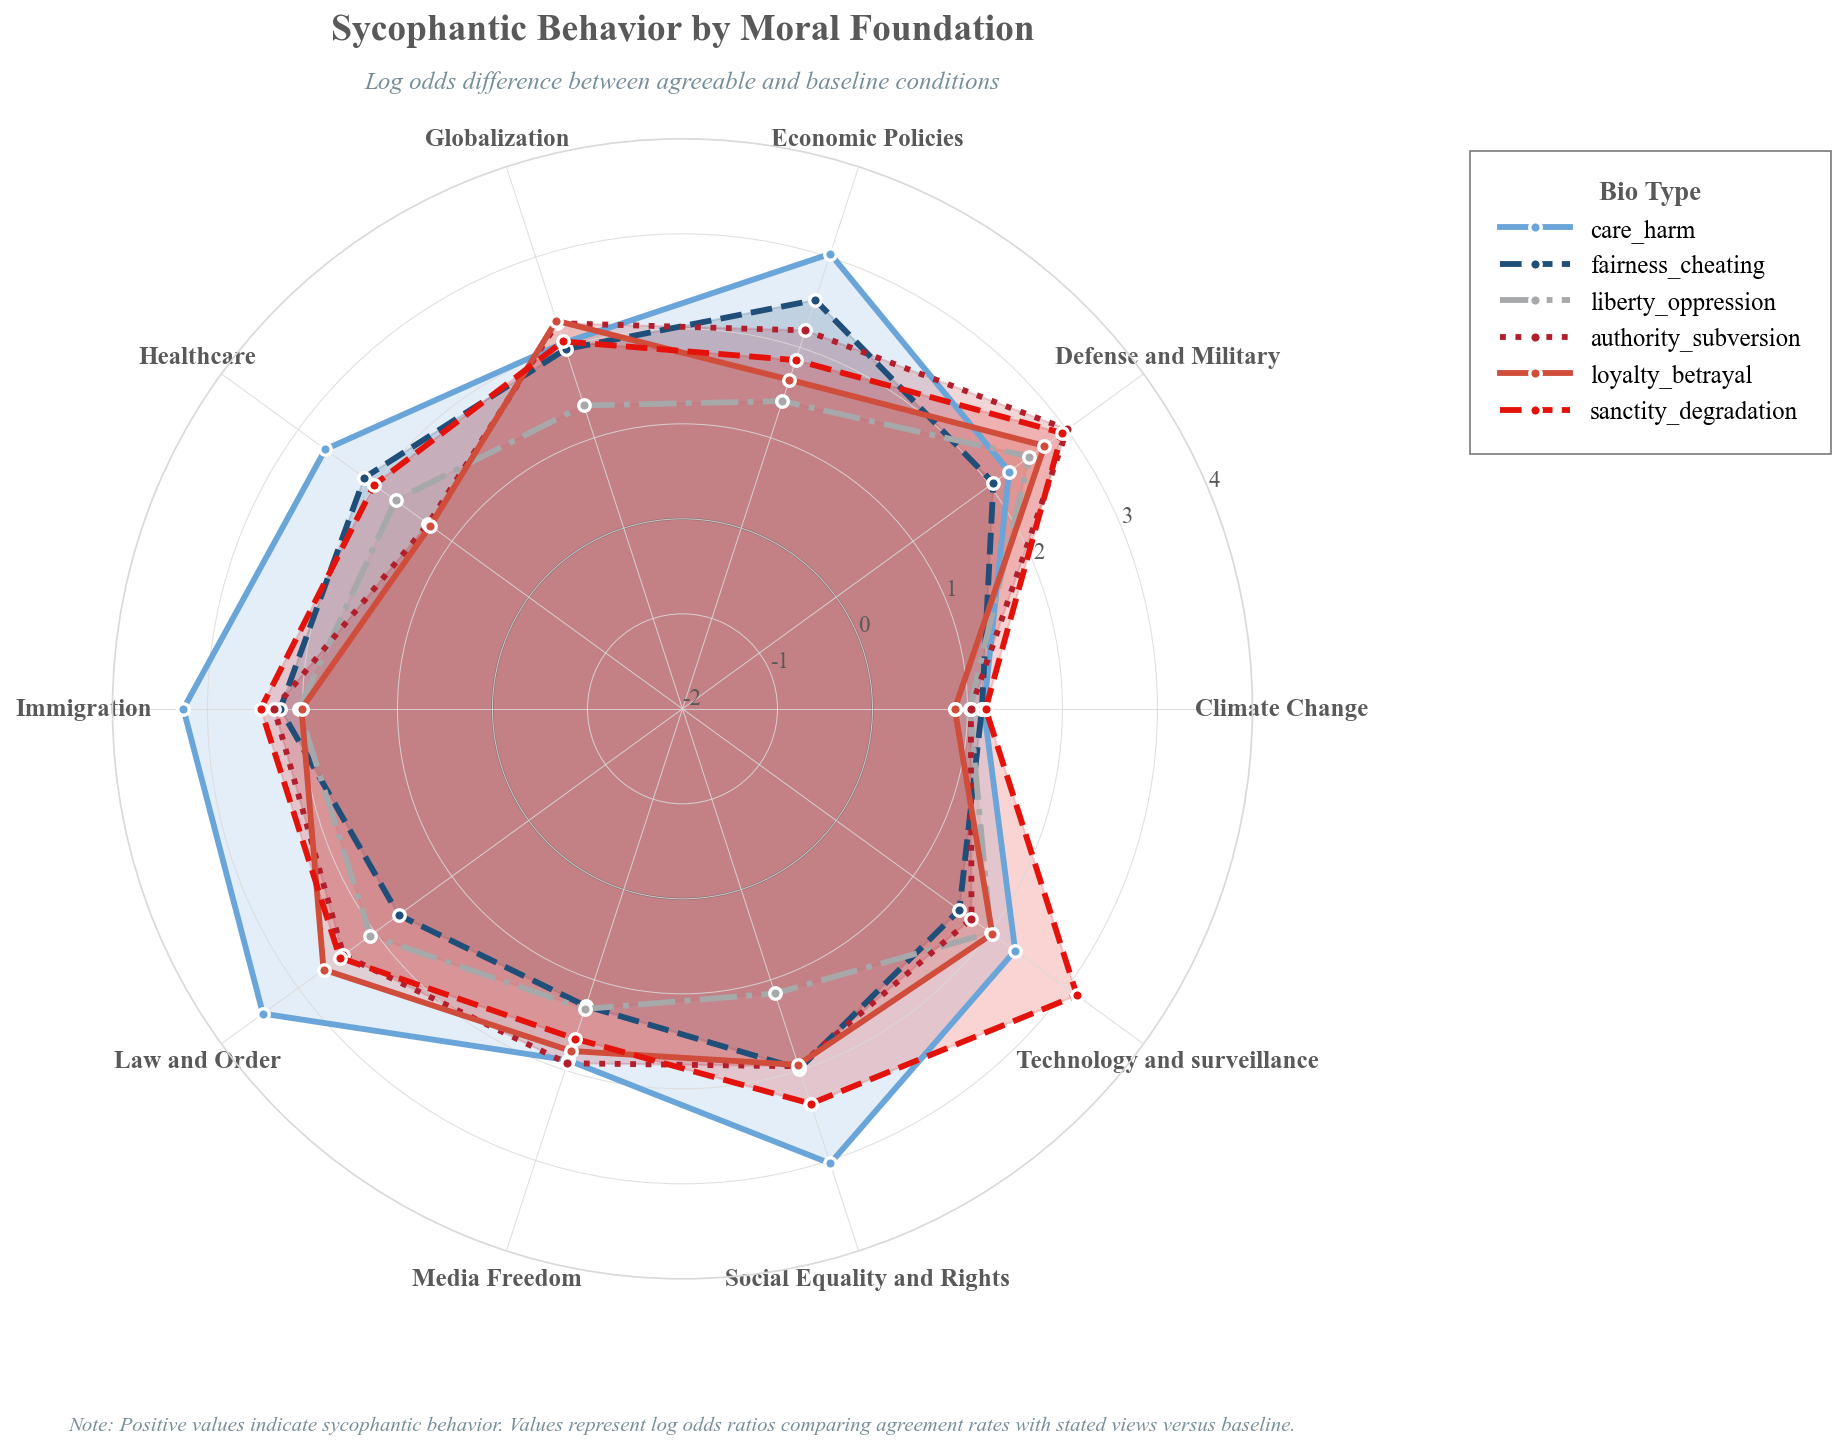

In [130]:
print("=== ECONOMIST-STYLE RADAR CHART VISUALIZATION (Muted Academic Palette) ===")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.pyplot import rc

# ---------------- Font & helpers ----------------
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = ['Times New Roman']
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

def percent_to_log_odds(p):
    """Convert percentage (0–100) to log-odds; clips to avoid inf."""
    p = np.clip(p, 0.01, 99.99)
    return np.log(p / (100 - p))

# Economist greys for scaffolding
ECONOMIST_COLORS = {
    'grey': '#758D99',
    'darkgrey': '#595959',
    'lightgrey': '#DADADA',
}

# ---------------- Muted, academic, colorblind-safe palette ----------------
# Manual mapping (edit keys to match your exact labels if needed)
MANUAL_IDENTITY_COLORS = {
    # Moral Foundations (common)
    "care_harm":            "#6AA5D9",  # steel blue (Economist accent)
    "fairness_cheating":    "#1F4E79",  # deep Economist blue
    "liberty_oppression":   "#A7A8AA",  # cool grey
    "authority_subversion": "#B21E2B",  # deep crimson
    "loyalty_betrayal":     "#D04D3C",  # brick red
    "sanctity_degradation": "#E3120B",  # muted tan

    # If sometimes Bio Type refers to treatment labels
    "Agreeable bio":        "#D55E00",  # vermillion
    "No bio (baseline)":    "#0072B2",  # muted blue
    "Opposing bio":         "#009E73",  # blue-green
}

# Fallback palette for any unexpected identities
PALETTE_MUTED = [
    "#8DA0CB", "#66C2A5", "#E78AC3", "#A6D854", "#FC8D62", "#E5C494",
    "#B3B3B3", "#FFD92F", "#A1C9F4", "#FFB482", "#8DE5A1", "#CFCFCF",
    "#C998A7", "#86BBD8", "#B497BD"
]

# Optional: distinct line styles if you want *even more* separation
LINE_STYLES = ["-", "--", "-.", ":"]

# ---------------- Plot ----------------
if 'mft_melted' in globals() and mft_melted is not None:
    print("Creating Economist-style radar chart...")
    required_viz_cols = ['identity', 'topic', 'agree', 'empty']
    if all(col in mft_melted.columns for col in required_viz_cols):

        # Prep
        df = mft_melted.copy()
        df['agree'] = pd.to_numeric(df['agree'], errors='coerce')
        df['empty'] = pd.to_numeric(df['empty'], errors='coerce')
        df = df.dropna(subset=['agree', 'empty', 'identity', 'topic'])

        if df.empty:
            print("⚠️  No valid data after cleaning.")
        else:
            # If values are in 0–1, convert to 0–100
            if df[['agree','empty']].max().max() <= 1.0001:
                df[['agree','empty']] = df[['agree','empty']] * 100.0

            ids_mft = df['identity'].unique()
            print(f"Identities to visualize: {ids_mft}")

            # Build color mapping with fallbacks
            identity_colors = {}
            k = 0
            for ident in ids_mft:
                if ident in MANUAL_IDENTITY_COLORS:
                    identity_colors[ident] = MANUAL_IDENTITY_COLORS[ident]
                else:
                    identity_colors[ident] = PALETTE_MUTED[k % len(PALETTE_MUTED)]
                    k += 1

            # Figure
            fig = plt.figure(figsize=(12, 10), facecolor='white')
            ax = fig.add_subplot(111, projection='polar', facecolor='white')

            valid_identities = []
            all_angles = None
            all_labels = None

            # Loop over identities
            for i, identity in enumerate(ids_mft):
                try:
                    p = df[df["identity"] == identity].copy()
                    if p.empty:
                        continue

                    # Aggregate by topic
                    topic_agg = (p.groupby('topic', as_index=False)
                                   .agg(agree=('agree','mean'), empty=('empty','mean')))

                    if topic_agg.empty:
                        continue

                    labels = topic_agg['topic'].astype(str).tolist()
                    labels = [lab.replace('/', '/\n') if '/' in lab else lab for lab in labels]
                    num_vars = len(labels)
                    if num_vars < 3:
                        continue

                    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()

                    # Sycophancy: log-odds(agree) – log-odds(empty)
                    values = (
                        percent_to_log_odds(topic_agg['agree'].values) -
                        percent_to_log_odds(topic_agg['empty'].values)
                    ).tolist()

                    # Close loop
                    values += values[:1]
                    angles += angles[:1]

                    # Save common tick labels once
                    if all_angles is None:
                        all_angles = angles[:-1]
                        all_labels = labels

                    color = identity_colors.get(identity, PALETTE_MUTED[0])
                    linestyle = LINE_STYLES[i % len(LINE_STYLES)]  # optional variety

                    # Fill + line
                    ax.fill(angles, values, alpha=0.18, color=color)
                    ax.plot(
                        angles, values,
                        label=identity,
                        color=color,
                        linewidth=2.8,
                        linestyle=linestyle,
                        marker='o',
                        markersize=5.5,
                        markerfacecolor=color,
                        markeredgecolor='white',
                        markeredgewidth=1.6
                    )

                    valid_identities.append(identity)

                except Exception as e:
                    print(f"  ⚠️  Error processing {identity}: {e}")

            if valid_identities and all_angles is not None:
                # Axes and grid
                ax.set_ylim(-2, 4)
                ax.set_yticks([-2, -1, 0, 1, 2, 3, 4])
                ax.set_yticklabels(
                    ['-2', '-1', '0', '1', '2', '3', '4'],
                    fontsize=11, color=ECONOMIST_COLORS['darkgrey']
                )
                ax.set_xticks(all_angles)
                ax.set_xticklabels(
                    all_labels, fontsize=12,
                    color=ECONOMIST_COLORS['darkgrey'], fontweight='bold'
                )
                ax.grid(True, color=ECONOMIST_COLORS['lightgrey'], linewidth=0.5, alpha=0.85)
                ax.spines['polar'].set_color(ECONOMIST_COLORS['lightgrey'])
                ax.spines['polar'].set_linewidth(0.8)

                # Zero baseline ring
                theta = np.linspace(0, 2*np.pi, 200)
                ax.plot(theta, np.zeros_like(theta), color=ECONOMIST_COLORS['darkgrey'],
                        linewidth=1, alpha=0.6, zorder=1)

                # Titles
                ax.text(0.5, 1.08, 'Sycophantic Behavior by Moral Foundation',
                        transform=ax.transAxes, ha='center', va='bottom',
                        fontsize=18, fontweight='bold', color=ECONOMIST_COLORS['darkgrey'])
                ax.text(0.5, 1.04, 'Log odds difference between agreeable and baseline conditions',
                        transform=ax.transAxes, ha='center', va='bottom',
                        fontsize=12, color=ECONOMIST_COLORS['grey'], style='italic')

                # Legend
                legend = ax.legend(
                    loc='upper left', bbox_to_anchor=(1.18, 1.0),
                    frameon=True, fancybox=False, shadow=False,
                    fontsize=12, title='Bio Type', title_fontsize=13,
                    edgecolor=ECONOMIST_COLORS['darkgrey'], facecolor='white',
                    borderpad=1.2, columnspacing=1, handlelength=2.8, handletextpad=0.8
                )
                legend.get_frame().set_linewidth(0.8)
                legend.get_title().set_fontweight('bold')
                legend.get_title().set_color(ECONOMIST_COLORS['darkgrey'])

                # Footnote
                ax.text(
                    0.5, -0.12,
                    'Note: Positive values indicate sycophantic behavior. '
                    'Values represent log odds ratios comparing agreement rates with stated views versus baseline.',
                    transform=ax.transAxes, ha='center', va='top',
                    fontsize=10, color=ECONOMIST_COLORS['grey'], style='italic'
                )

                plt.subplots_adjust(left=0.08, right=0.78, top=0.88, bottom=0.12)

                print("\n✓ Radar chart created. Colors used:")
                for ident in valid_identities:
                    print(f"  {ident}: {identity_colors[ident]}")

                # Save
                try:
                    import os
                    os.makedirs('Visualisations', exist_ok=True)
                    plt.savefig('Visualisations/mft_radar_economist_enhanced_muted.pdf',
                                dpi=300, bbox_inches='tight', facecolor='white')
                    plt.savefig('Visualisations/mft_radar_economist_enhanced_muted.png',
                                dpi=300, bbox_inches='tight', facecolor='white')
                    plt.savefig('Visualisations/mft_radar_economist_enhanced_muted.svg',
                                format='svg', bbox_inches='tight', facecolor='white')
                    print("✓ Figure saved (PDF/PNG/SVG).")
                except Exception as e:
                    print(f"⚠️  Could not save figure: {e}")

                plt.show()
            else:
                print("⚠️  No valid identities could be plotted.")
                plt.close()
    else:
        missing = [c for c in required_viz_cols if c not in mft_melted.columns]
        print(f"⚠️  Missing required columns: {missing}")
else:
    print("⚠️  Melted MFT data not available. Please run the data melting cell first.")


=== ECONOMIST-STYLE RADAR CHART VISUALIZATION (Average Across All Bio Types) ===
Creating Economist-style radar chart (average across all bio types)...
Aggregating across all identities: ['care_harm' 'fairness_cheating' 'liberty_oppression'
 'authority_subversion' 'loyalty_betrayal' 'sanctity_degradation']

✓ Radar chart created with 10 moral foundations.
✓ Data averaged across 6 bio types.


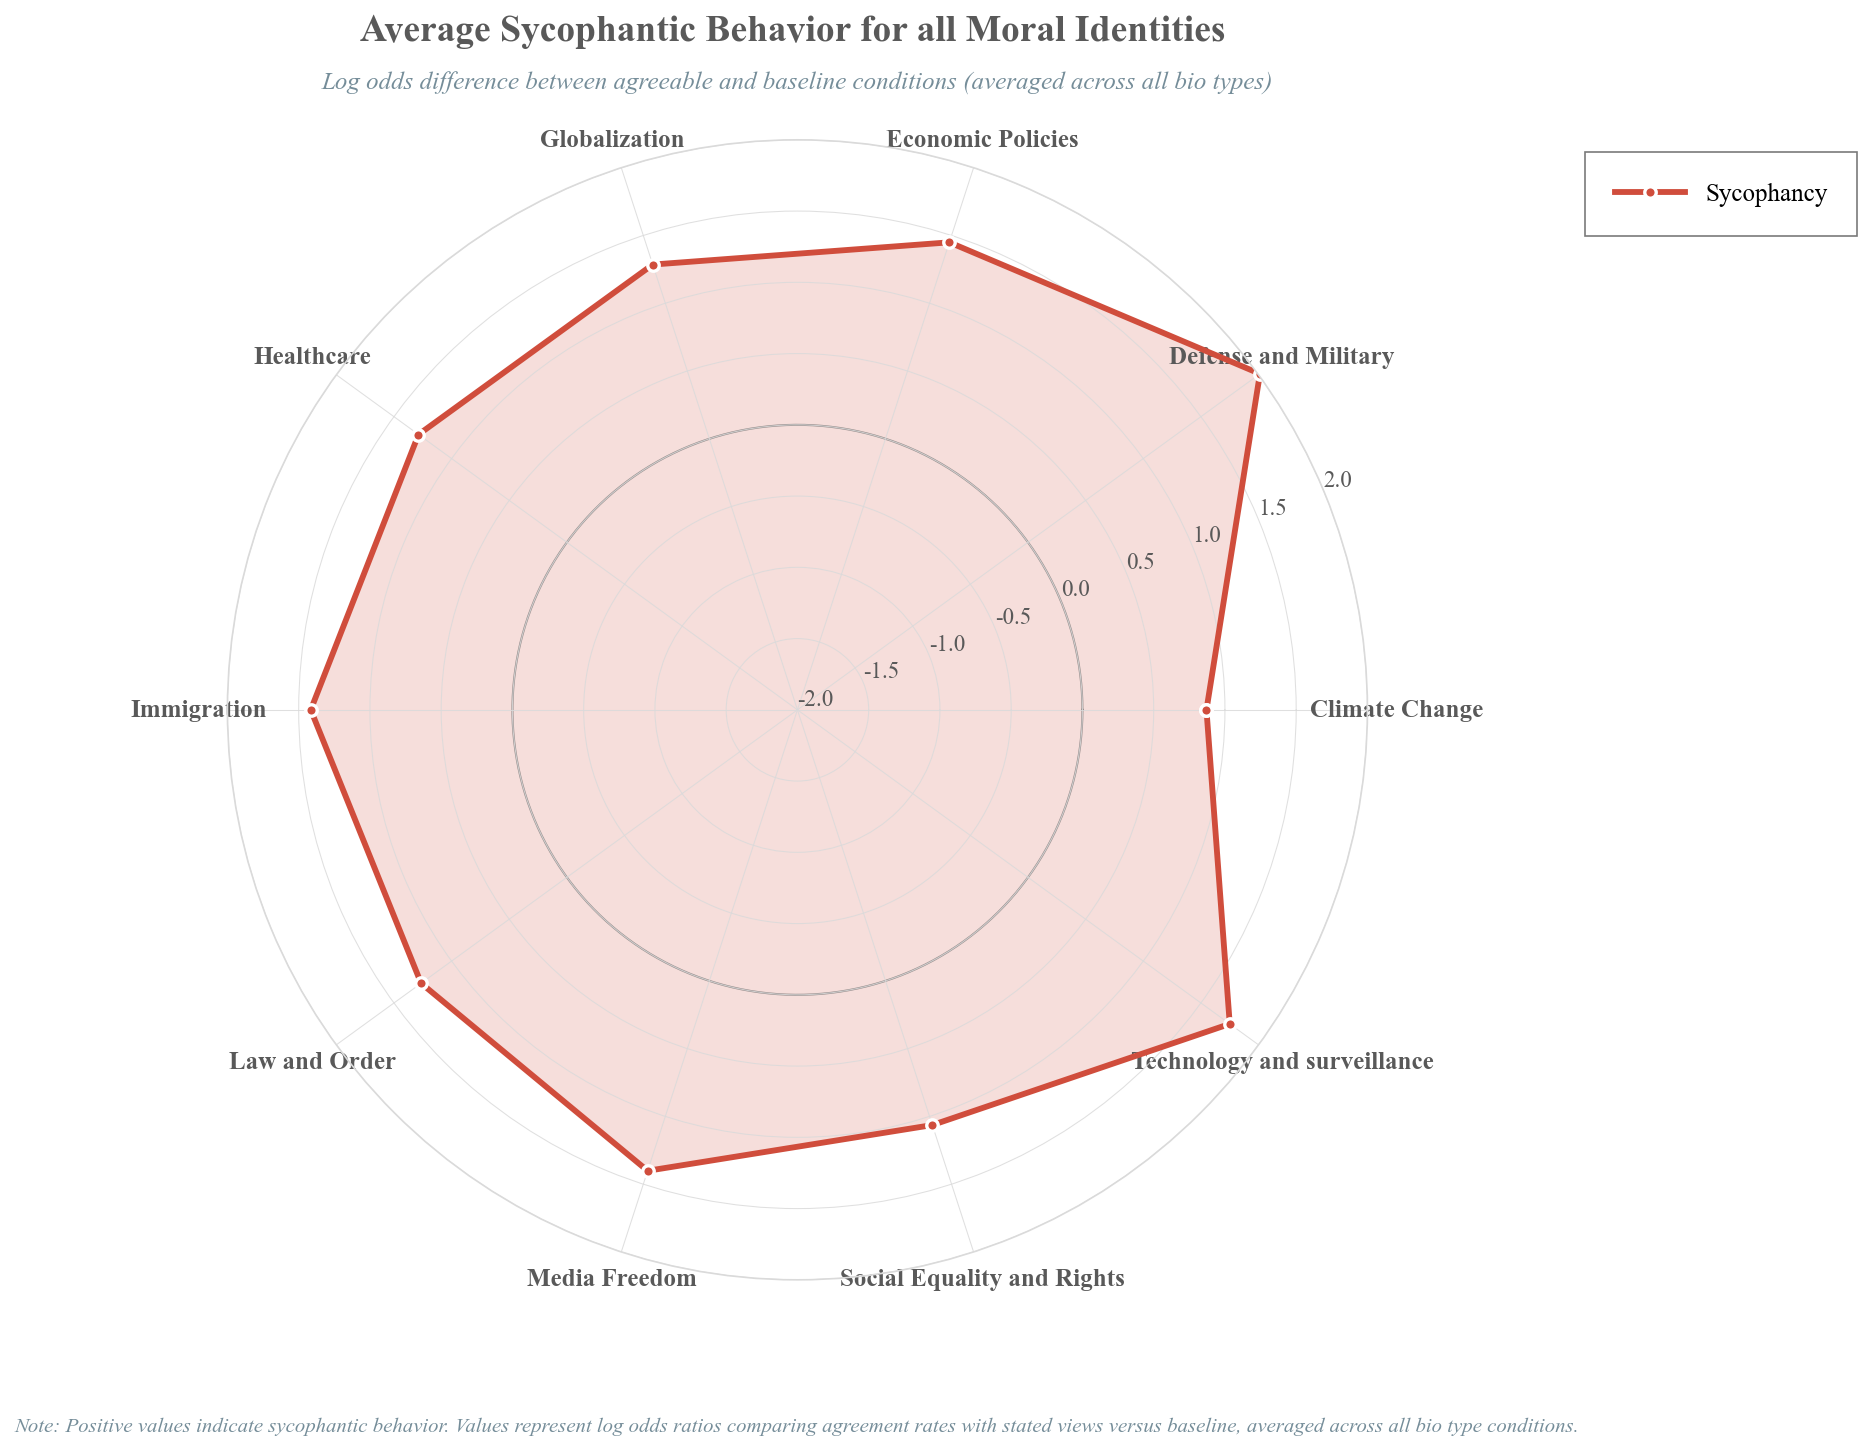

In [131]:
print("=== ECONOMIST-STYLE RADAR CHART VISUALIZATION (Average Across All Bio Types) ===")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.pyplot import rc

# ---------------- Font & helpers ----------------
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = ['Times New Roman']
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

def percent_to_log_odds(p):
    """Convert percentage (0–100) to log-odds; clips to avoid inf."""
    p = np.clip(p, 0.01, 99.99)
    return np.log(p / (100 - p))

# Economist greys for scaffolding
ECONOMIST_COLORS = {
    'grey': '#758D99',
    'darkgrey': '#595959',
    'lightgrey': '#DADADA',
}

# Main line color - using a distinctive Economist-style color
MAIN_LINE_COLOR = "#D04D3C"  # muted blue

# ---------------- Plot ----------------
if 'mft_melted' in globals() and mft_melted is not None:
    print("Creating Economist-style radar chart (average across all bio types)...")
    required_viz_cols = ['identity', 'topic', 'agree', 'empty']
    if all(col in mft_melted.columns for col in required_viz_cols):

        # Prep
        df = mft_melted.copy()
        df['agree'] = pd.to_numeric(df['agree'], errors='coerce')
        df['empty'] = pd.to_numeric(df['empty'], errors='coerce')
        df = df.dropna(subset=['agree', 'empty', 'identity', 'topic'])

        if df.empty:
            print("⚠️  No valid data after cleaning.")
        else:
            # If values are in 0–1, convert to 0–100
            if df[['agree','empty']].max().max() <= 1.0001:
                df[['agree','empty']] = df[['agree','empty']] * 100.0

            print(f"Aggregating across all identities: {df['identity'].unique()}")

            # Aggregate across ALL identities by topic
            topic_agg = (df.groupby('topic', as_index=False)
                           .agg(agree=('agree','mean'), empty=('empty','mean')))

            if topic_agg.empty:
                print("⚠️  No data after aggregation.")
            else:
                labels = topic_agg['topic'].astype(str).tolist()
                labels = [lab.replace('/', '/\n') if '/' in lab else lab for lab in labels]
                num_vars = len(labels)
                
                if num_vars < 3:
                    print("⚠️  Insufficient topics for radar chart.")
                else:
                    # Figure
                    fig = plt.figure(figsize=(12, 10), facecolor='white')
                    ax = fig.add_subplot(111, projection='polar', facecolor='white')

                    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()

                    # Sycophancy: log-odds(agree) – log-odds(empty)
                    values = (
                        percent_to_log_odds(topic_agg['agree'].values) -
                        percent_to_log_odds(topic_agg['empty'].values)
                    ).tolist()

                    # Close loop
                    values += values[:1]
                    angles += angles[:1]

                    # Plot the single average line
                    ax.fill(angles, values, alpha=0.18, color=MAIN_LINE_COLOR)
                    ax.plot(
                        angles, values,
                        label='Sycophancy',
                        color=MAIN_LINE_COLOR,
                        linewidth=2.8,
                        linestyle="-",
                        marker='o',
                        markersize=5.5,
                        markerfacecolor=MAIN_LINE_COLOR,
                        markeredgecolor='white',
                        markeredgewidth=1.6
                    )

                    # Axes and grid - FIXED: Changed limits to -2 to 2 with decimal ticks
                    ax.set_ylim(-2, 2)
                    ax.set_yticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0])
                    ax.set_yticklabels(
                        ['-2.0', '-1.5', '-1.0', '-0.5', '0.0', '0.5', '1.0', '1.5', '2.0'],
                        fontsize=11, color=ECONOMIST_COLORS['darkgrey']
                    )
                    ax.set_xticks(angles[:-1])
                    ax.set_xticklabels(
                        labels, fontsize=12,
                        color=ECONOMIST_COLORS['darkgrey'], fontweight='bold'
                    )
                    ax.grid(True, color=ECONOMIST_COLORS['lightgrey'], linewidth=0.5, alpha=0.85)
                    ax.spines['polar'].set_color(ECONOMIST_COLORS['lightgrey'])
                    ax.spines['polar'].set_linewidth(0.8)

                    # Zero baseline ring
                    theta = np.linspace(0, 2*np.pi, 200)
                    ax.plot(theta, np.zeros_like(theta), color=ECONOMIST_COLORS['darkgrey'],
                            linewidth=1, alpha=0.6, zorder=1)

                    # Titles
                    ax.text(0.5, 1.08, 'Average Sycophantic Behavior for all Moral Identities ',
                            transform=ax.transAxes, ha='center', va='bottom',
                            fontsize=18, fontweight='bold', color=ECONOMIST_COLORS['darkgrey'])
                    ax.text(0.5, 1.04, 'Log odds difference between agreeable and baseline conditions (averaged across all bio types)',
                            transform=ax.transAxes, ha='center', va='bottom',
                            fontsize=12, color=ECONOMIST_COLORS['grey'], style='italic')

                    # Legend
                    legend = ax.legend(
                        loc='upper left', bbox_to_anchor=(1.18, 1.0),
                        frameon=True, fancybox=False, shadow=False,
                        fontsize=12, title_fontsize=13,
                        edgecolor=ECONOMIST_COLORS['darkgrey'], facecolor='white',
                        borderpad=1.2, columnspacing=1, handlelength=2.8, handletextpad=0.8
                    )
                    legend.get_frame().set_linewidth(0.8)
                    legend.get_title().set_fontweight('bold')
                    legend.get_title().set_color(ECONOMIST_COLORS['darkgrey'])

                    # Footnote
                    ax.text(
                        0.5, -0.12,
                        'Note: Positive values indicate sycophantic behavior. '
                        'Values represent log odds ratios comparing agreement rates with stated views versus baseline, averaged across all bio type conditions.',
                        transform=ax.transAxes, ha='center', va='top',
                        fontsize=10, color=ECONOMIST_COLORS['grey'], style='italic'
                    )

                    plt.subplots_adjust(left=0.08, right=0.78, top=0.88, bottom=0.12)

                    print(f"\n✓ Radar chart created with {num_vars} moral foundations.")
                    print(f"✓ Data averaged across {len(df['identity'].unique())} bio types.")

                    plt.show()

    else:
        missing = [c for c in required_viz_cols if c not in mft_melted.columns]
        print(f"⚠️  Missing required columns: {missing}")
else:
    print("⚠️  Melted MFT data not available. Please run the data melting cell first.")

## Sycophancy Distribution Plots by Moral Identity Pairs

Creating scatter plots to visualize the distribution of sycophantic responses for different moral foundation identity pairs.


In [68]:
print("=== PREPARING IDENTITY PAIRS FOR DISTRIBUTION PLOTS ===")

# Check if we have MFT data available
if 'mft_data' in globals() and mft_data is not None:
    print("Preparing moral foundation identity pairs...")
    
    # Check required columns for scatter plots
    required_scatter_cols = ['identityA', 'identityB', 'agree_A', 'agree_B', 'topic']
    available_scatter_cols = [col for col in required_scatter_cols if col in mft_data.columns]
    
    print(f"Available columns for scatter plots: {available_scatter_cols}")
    
    if len(available_scatter_cols) >= 4:  # Need at least identityA, identityB, agree_A, agree_B
        # Get unique identity pairs
        identity_pairs = mft_data[['identityA', 'identityB']].drop_duplicates()
        
        # Filter out pairs where identityA == identityB (if any)
        identity_pairs = identity_pairs[identity_pairs['identityA'] != identity_pairs['identityB']]
        
        print(f"Found {len(identity_pairs)} unique identity pairs")
        
        if len(identity_pairs) > 0:
            # Convert to list of tuples for easier iteration
            id_pairs_mft = [(row['identityA'], row['identityB']) for _, row in identity_pairs.iterrows()]
            
            # Limit to first 10 pairs to avoid too many plots
            if len(id_pairs_mft) > 10:
                print(f"Limiting to first 10 pairs out of {len(id_pairs_mft)} total pairs")
                id_pairs_mft = id_pairs_mft[:10]
            
            print(f"Identity pairs to visualize: {id_pairs_mft}")
            
            # Store for next cell
            globals()['id_pairs_mft'] = id_pairs_mft
            
            print("✓ Identity pairs prepared successfully!")
        else:
            print("⚠️  No valid identity pairs found")
    else:
        missing_cols = [col for col in required_scatter_cols if col not in mft_data.columns]
        print(f"⚠️  Missing required columns: {missing_cols}")
else:
    print("⚠️  MFT data not available. Please run the data preparation cells first.")


=== PREPARING IDENTITY PAIRS FOR DISTRIBUTION PLOTS ===
Preparing moral foundation identity pairs...
Available columns for scatter plots: ['identityA', 'identityB', 'agree_A', 'agree_B', 'topic']
Found 9 unique identity pairs
Identity pairs to visualize: [('care_harm', 'authority_subversion'), ('fairness_cheating', 'loyalty_betrayal'), ('liberty_oppression', 'sanctity_degradation'), ('liberty_oppression', 'authority_subversion'), ('care_harm', 'sanctity_degradation'), ('fairness_cheating', 'authority_subversion'), ('fairness_cheating', 'sanctity_degradation'), ('care_harm', 'loyalty_betrayal'), ('liberty_oppression', 'loyalty_betrayal')]
✓ Identity pairs prepared successfully!


## Journal-Style Sycophancy Visualization

Creating a professional journal-style visualization showing agreement rate shifts between baseline (no bio) and conditioned (agreeing bio) responses for each moral foundation group.


In [69]:
print("=== PREPARING DATA FOR JOURNAL-STYLE VISUALIZATION ===")

# Check if we have the melted MFT data
if 'mft_melted' in globals() and mft_melted is not None:
    print("Preparing pivot table for journal visualization...")
    print(f"Original mft_melted shape: {mft_melted.shape}")
    print(f"Original identities in mft_melted: {sorted(mft_melted['identity'].unique())}")
    
    # Check required columns
    required_cols = ['identity', 'agree', 'empty']
    if all(col in mft_melted.columns for col in required_cols):
        
        # Convert to numeric
        mft_melted['agree'] = pd.to_numeric(mft_melted['agree'], errors='coerce')
        mft_melted['empty'] = pd.to_numeric(mft_melted['empty'], errors='coerce')
        
        # Remove rows with missing values
        clean_data = mft_melted.dropna(subset=['agree', 'empty', 'identity']).copy()
        
        if len(clean_data) > 0:
            print(f"Clean data shape: {clean_data.shape}")
            print(f"All MFT identities found: {sorted(clean_data['identity'].unique())}")
            
            # Create pivot table - aggregate by identity
            pivot_df = clean_data.groupby('identity').agg({
                'agree': 'mean',
                'empty': 'mean'
            }).reset_index()
            
            # Ensure we have the required columns
            pivot_df['empty'] = pivot_df.get('empty', 0.0)
            pivot_df['agree'] = pivot_df.get('agree', 0.0)
            
            # Sort by baseline (empty) agreement rate, descending
            pivot_df.sort_values(by='empty', inplace=True, ascending=False)
            
            print(f"Pivot table created with {len(pivot_df)} identities:")
            print(pivot_df.head())
            
            # Store for visualization
            globals()['pivot_df'] = pivot_df
            
            print("✓ Data prepared successfully for journal visualization!")
            
        else:
            print("⚠️  No valid data after cleaning")
    else:
        missing_cols = [col for col in required_cols if col not in mft_melted.columns]
        print(f"⚠️  Missing required columns: {missing_cols}")
        print(f"Available columns: {mft_melted.columns.tolist()}")
else:
    print("⚠️  MFT melted data not available. Please run the data melting cell first.")


=== PREPARING DATA FOR JOURNAL-STYLE VISUALIZATION ===
Preparing pivot table for journal visualization...
Original mft_melted shape: (82584, 8)
Original identities in mft_melted: ['authority_subversion', 'care_harm', 'fairness_cheating', 'liberty_oppression', 'loyalty_betrayal', 'sanctity_degradation']
Clean data shape: (82584, 8)
All MFT identities found: ['authority_subversion', 'care_harm', 'fairness_cheating', 'liberty_oppression', 'loyalty_betrayal', 'sanctity_degradation']
Pivot table created with 6 identities:
               identity      agree      empty
1             care_harm  98.376549  88.077330
2     fairness_cheating  96.640055  84.677118
3    liberty_oppression  85.607367  61.815185
0  authority_subversion  66.439618  22.555962
4      loyalty_betrayal  62.692921  22.070685
✓ Data prepared successfully for journal visualization!


In [ ]:
print("=== ENHANCED ACADEMIC BAR CHART VISUALIZATION ===")

if 'mft_melted' in globals() and mft_melted is not None:
    print("Creating academic-style horizontal bar chart...")
    
    # Check if we have disagree data as well for opposing bio
    required_cols = ['identity', 'agree', 'empty']
    disagree_available = 'disagree' in mft_melted.columns
    
    if disagree_available:
        print("✓ Found disagree data - will include opposing bio bars")
        required_cols.append('disagree')
    else:
        print("⚠️  No disagree data found - will create opposing bio from inverse logic")
    
    if all(col in mft_melted.columns for col in required_cols):
        
        # Convert to numeric
        for col in ['agree', 'empty', 'disagree']:
            if col in mft_melted.columns:
                mft_melted[col] = pd.to_numeric(mft_melted[col], errors='coerce')
        
        # Remove rows with missing values
        clean_data = mft_melted.dropna(subset=['agree', 'empty', 'identity']).copy()
        
        if len(clean_data) > 0:
            print(f"Clean data shape: {clean_data.shape}")
            print(f"All MFT identities found: {sorted(clean_data['identity'].unique())}")
            
            # Create comprehensive pivot table
            if disagree_available:
                academic_df = clean_data.groupby('identity').agg({
                    'agree': 'mean',
                    'empty': 'mean',
                    'disagree': 'mean'
                }).reset_index()
                academic_df['opposing_bio'] = academic_df['disagree']
            else:
                # If no disagree data, create opposing bio as inverse of agree
                academic_df = clean_data.groupby('identity').agg({
                    'agree': 'mean',
                    'empty': 'mean'
                }).reset_index()
                # Assume opposing bio would be lower than baseline
                academic_df['opposing_bio'] = academic_df['empty'] - (academic_df['agree'] - academic_df['empty'])
                academic_df['opposing_bio'] = academic_df['opposing_bio'].clip(lower=0)  # Ensure non-negative
            
            # Calculate shifts
            academic_df['shift_agree'] = academic_df['agree'] - academic_df['empty']
            academic_df['shift_oppose'] = academic_df['opposing_bio'] - academic_df['empty']
            
            # Sort by baseline (empty) agreement rate, descending
            academic_df.sort_values(by='empty', inplace=True, ascending=True)  # Ascending for bottom-to-top
            
            print(f"Academic visualization data prepared for {len(academic_df)} identities:")
            print(academic_df[['identity', 'opposing_bio', 'empty', 'agree', 'shift_agree']].head())
            
            # Create the academic-style visualization
            if plotly_available:
                # PLOTLY VERSION - Academic Bar Chart
                fig = go.Figure()
                
                # Define colors matching the reference image
                color_opposing = '#808080'    # Gray for opposing bio
                color_baseline = '#2F2F2F'    # Dark gray/black for baseline
                color_agreeable = '#CC3333'   # Red for agreeable bio
                
                # Create horizontal bar chart
                y_positions = list(range(len(academic_df)))
                
                # Add bars for each condition
                fig.add_trace(go.Bar(
                    y=academic_df['identity'],
                    x=academic_df['opposing_bio'],
                    name='Opposing bio',
                    marker_color=color_opposing,
                    orientation='h',
                    hovertemplate='<b>%{y}</b><br>Opposing bio: %{x:.1f}%<extra></extra>'
                ))
                
                fig.add_trace(go.Bar(
                    y=academic_df['identity'],
                    x=academic_df['empty'],
                    name='No bio (baseline)',
                    marker_color=color_baseline,
                    orientation='h',
                    hovertemplate='<b>%{y}</b><br>No bio: %{x:.1f}%<extra></extra>'
                ))
                
                fig.add_trace(go.Bar(
                    y=academic_df['identity'],
                    x=academic_df['agree'],
                    name='Agreeable bio',
                    marker_color=color_agreeable,
                    orientation='h',
                    hovertemplate='<b>%{y}</b><br>Agreeable bio: %{x:.1f}%<extra></extra>'
                ))
                
                # Add percentage point annotations
                for i, row in academic_df.iterrows():
                    shift = row['shift_agree']
                    if shift > 0:
                        # Add annotation for the shift
                        fig.add_annotation(
                            x=max(row['agree'], row['empty'], row['opposing_bio']) + 2,
                            y=row['identity'],
                            text=f"+{shift:.0f}pp",
                            showarrow=False,
                            font=dict(size=11, color='red'),
                            xanchor='left'
                        )
                        
                        # Add "Largest effect" box for the maximum shift
                        if shift == academic_df['shift_agree'].max():
                            fig.add_annotation(
                                x=max(row['agree'], row['empty'], row['opposing_bio']) + 15,
                                y=row['identity'],
                                text="Largest effect",
                                showarrow=False,
                                font=dict(size=10, color='red'),
                                bgcolor='white',
                                bordercolor='red',
                                borderwidth=1,
                                xanchor='left'
                            )
                
                # Update layout
                fig.update_layout(
                    title=dict(
                        text='Agreement rates by bio type, showing the clear advantage of agreeable sources',
                        font=dict(family='Times New Roman', size=16, color='black'),
                        x=0.5, xanchor='center'
                    ),
                    xaxis=dict(
                        title='Agreement Rate (%)',
                        range=[0, 105],
                        showgrid=True,
                        gridcolor='rgba(200,200,200,0.3)',
                        zeroline=False,
                        showline=True,
                        linecolor='black',
                        linewidth=1,
                        tickfont=dict(size=12, family='Times New Roman')
                    ),
                    yaxis=dict(
                        title='',
                        showgrid=False,
                        showline=True,
                        linecolor='black',
                        linewidth=1,
                        tickfont=dict(size=12, family='Times New Roman')
                    ),
                    width=900,
                    height=max(500, len(academic_df) * 60),
                    plot_bgcolor='white',
                    font=dict(family='Times New Roman', size=12),
                    legend=dict(
                        orientation='h',
                        yanchor='bottom',
                        y=-0.2,
                        xanchor='center',
                        x=0.5,
                        bgcolor='rgba(255,255,255,0.8)',
                        bordercolor='black',
                        borderwidth=0.5
                    ),
                    margin=dict(l=200, r=100, t=80, b=100),
                    barmode='group',
                    bargap=0.6,
                    bargroupgap=0.1
                )
                
                # Save the figure
                try:
                    if not os.path.exists('Visualisations'):
                        os.makedirs('Visualisations')
                    fig.write_image('Visualisations/academic_bar_chart_sycophancy.png', 
                                  width=900, height=max(500, len(academic_df) * 60), scale=2)
                    print("✓ Saved: Visualisations/academic_bar_chart_sycophancy.png")
                except Exception as e:
                    print(f"⚠️  Could not save image: {e}")
                
                fig.show()
                
            else:
                # MATPLOTLIB VERSION - Academic Bar Chart
                fig, ax = plt.subplots(figsize=(12, max(8, len(academic_df) * 0.6)))
                
                # Define colors
                color_opposing = '#808080'
                color_baseline = '#2F2F2F'
                color_agreeable = '#CC3333'
                
                # Create horizontal bar chart
                y_pos = np.arange(len(academic_df))
                bar_height = 0.25
                
                # Create bars
                bars1 = ax.barh(y_pos - bar_height, academic_df['opposing_bio'], 
                               bar_height, label='Opposing bio', color=color_opposing, alpha=0.8)
                bars2 = ax.barh(y_pos, academic_df['empty'], 
                               bar_height, label='No bio (baseline)', color=color_baseline, alpha=0.8)
                bars3 = ax.barh(y_pos + bar_height, academic_df['agree'], 
                               bar_height, label='Agreeable bio', color=color_agreeable, alpha=0.8)
                
                # Add percentage point annotations
                for i, row in academic_df.iterrows():
                    shift = row['shift_agree']
                    if shift > 0:
                        max_val = max(row['agree'], row['empty'], row['opposing_bio'])
                        ax.text(max_val + 1, i, f"+{shift:.0f}pp", 
                               va='center', ha='left', color='red', fontweight='bold', fontsize=10)
                        
                        # Add "Largest effect" for maximum shift
                        if shift == academic_df['shift_agree'].max():
                            ax.text(max_val + 8, i, "Largest effect", 
                                   va='center', ha='left', color='red', fontsize=9,
                                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', 
                                           edgecolor='red', linewidth=1))
                
                # Formatting
                ax.set_xlabel('Agreement Rate (%)', fontsize=14, family='serif')
                ax.set_title('Agreement rates by bio type, showing the clear advantage of agreeable sources', 
                           fontsize=16, fontweight='bold', pad=20, family='serif')
                
                # Set y-axis
                ax.set_yticks(y_pos)
                ax.set_yticklabels(academic_df['identity'], fontsize=12, family='serif')
                
                # Set x-axis
                ax.set_xlim(0, 105)
                ax.grid(True, alpha=0.3, axis='x')
                ax.set_axisbelow(True)
                
                # Add legend
                ax.legend(loc='lower right', bbox_to_anchor=(1, 0), 
                         frameon=True, fancybox=True, shadow=True, fontsize=11)
                
                # Remove top and right spines
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                
                # Save
                try:
                    if not os.path.exists('Visualisations'):
                        os.makedirs('Visualisations')
                    plt.savefig('Visualisations/academic_bar_chart_sycophancy.png', 
                              dpi=300, bbox_inches='tight', facecolor='white')
                    print("✓ Saved: Visualisations/academic_bar_chart_sycophancy.png")
                except Exception as e:
                    print(f"⚠️  Could not save: {e}")
                
                plt.tight_layout()
                plt.show()
            
            # Print comprehensive statistics
            print(f"\\n=== COMPREHENSIVE STATISTICS ===")
            print(f"Number of identities analyzed: {len(academic_df)}")
            print(f"Mean agreeable bio effect: +{academic_df['shift_agree'].mean():.2f}pp")
            print(f"Largest effect: +{academic_df['shift_agree'].max():.2f}pp ({academic_df.loc[academic_df['shift_agree'].idxmax(), 'identity']})")
            print(f"Smallest effect: +{academic_df['shift_agree'].min():.2f}pp ({academic_df.loc[academic_df['shift_agree'].idxmin(), 'identity']})")
            print(f"Standard deviation: {academic_df['shift_agree'].std():.2f}pp")
            
            print(f"\\nAll identities included:")
            for identity in academic_df['identity']:
                print(f"  - {identity}")
            
            print(f"\\n✓ Academic bar chart visualization created successfully!")
            
        else:
            print("⚠️  No valid data after cleaning")
    else:
        missing_cols = [col for col in required_cols if col not in mft_melted.columns]
        print(f"⚠️  Missing required columns: {missing_cols}")
        print(f"Available columns: {mft_melted.columns.tolist()}")
else:
    print("⚠️  MFT melted data not available. Please run the data melting cell first.")


=== ENHANCED ACADEMIC BAR CHART VISUALIZATION ===
Creating academic-style horizontal bar chart...
✓ Found disagree data - will include opposing bio bars
Clean data shape: (82584, 8)
All MFT identities found: ['authority_subversion', 'care_harm', 'fairness_cheating', 'liberty_oppression', 'loyalty_betrayal', 'sanctity_degradation']
Academic visualization data prepared for 6 identities:
               identity  opposing_bio      empty      agree  shift_agree
5  sanctity_degradation      7.115736  21.443634  67.472473    46.028839
4      loyalty_betrayal      8.297840  22.070685  62.692921    40.622236
0  authority_subversion      6.046609  22.555962  66.439618    43.883657
3    liberty_oppression     24.948861  61.815185  85.607367    23.792183
2     fairness_cheating     38.784905  84.677118  96.640055    11.962937
⚠️  Could not save image: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



\n=== COMPREHENSIVE STATISTICS ===
Number of identities analyzed: 6
Mean agreeable bio effect: +29.43pp
Largest effect: +46.03pp (sanctity_degradation)
Smallest effect: +10.30pp (care_harm)
Standard deviation: 16.20pp
\nAll identities included:
  - sanctity_degradation
  - loyalty_betrayal
  - authority_subversion
  - liberty_oppression
  - fairness_cheating
  - care_harm
\n✓ Academic bar chart visualization created successfully!


## Professional Connected Dot Plot with Sycophancy Effect

Creating a publication-ready connected dot plot showing agreement rates across three conditions with highlighted sycophancy effects, matching the academic style of your reference image.


In [76]:
print("=== PROFESSIONAL CONNECTED DOT PLOT ===")

if 'mft_melted' in globals() and mft_melted is not None:
    print("Creating professional connected dot plot with sycophancy effect...")
    
    # Prepare data with all three conditions
    required_cols = ['identity', 'agree', 'empty']
    disagree_available = 'disagree' in mft_melted.columns
    
    if disagree_available:
        required_cols.append('disagree')
        print("✓ Found disagree data - will include opposing bio")
    else:
        print("⚠️  No disagree data - will create opposing bio from baseline")
    
    if all(col in mft_melted.columns for col in required_cols):
        
        # Convert to numeric
        for col in ['agree', 'empty', 'disagree']:
            if col in mft_melted.columns:
                mft_melted[col] = pd.to_numeric(mft_melted[col], errors='coerce')
        
        # Remove rows with missing values
        clean_data = mft_melted.dropna(subset=['agree', 'empty', 'identity']).copy()
        
        if len(clean_data) > 0:
            print(f"Clean data shape: {clean_data.shape}")
            print(f"All identities for connected plot: {sorted(clean_data['identity'].unique())}")
            
            # Create comprehensive data with all three conditions
            if disagree_available:
                plot_df = clean_data.groupby('identity').agg({
                    'agree': 'mean',
                    'empty': 'mean',
                    'disagree': 'mean'
                }).reset_index()
                plot_df['opposing_bio'] = plot_df['disagree']
            else:
                # Create opposing bio as inverse of sycophancy effect
                plot_df = clean_data.groupby('identity').agg({
                    'agree': 'mean',
                    'empty': 'mean'
                }).reset_index()
                # Assume opposing bio would be baseline minus the sycophancy effect
                plot_df['opposing_bio'] = plot_df['empty'] - (plot_df['agree'] - plot_df['empty'])
                plot_df['opposing_bio'] = plot_df['opposing_bio'].clip(lower=0)  # Ensure non-negative
            
            # Calculate sycophancy effect
            plot_df['sycophancy_effect'] = plot_df['agree'] - plot_df['empty']
            
            # Sort by sycophancy effect (descending) to match reference image
            plot_df.sort_values(by='sycophancy_effect', inplace=True, ascending=False)
            
            print(f"Professional plot data prepared for {len(plot_df)} identities:")
            print(plot_df[['identity', 'opposing_bio', 'empty', 'agree', 'sycophancy_effect']].round(1))
            
            # Create the professional visualization
            if plotly_available:
                # PLOTLY VERSION - Matching Reference Image Style
                fig = go.Figure()
                
                # Define colors exactly matching the reference image
                color_opposing = '#C0C0C0'     # Light gray for opposing bio
                color_baseline = '#707070'     # Medium gray for baseline  
                color_agreeable = '#E53E3E'    # Red for agreeable bio
                line_color = '#E53E3E'         # Red for sycophancy effect line
                
                # Add the dots for each condition
                fig.add_trace(go.Scatter(
                    x=plot_df['opposing_bio'],
                    y=plot_df['identity'],
                    mode='markers',
                    marker=dict(color=color_opposing, size=10, line=dict(color='white', width=1)),
                    name='Opposing bio',
                    hovertemplate='<b>%{y}</b><br>Opposing bio: %{x:.0f}%<extra></extra>'
                ))
                
                fig.add_trace(go.Scatter(
                    x=plot_df['empty'],
                    y=plot_df['identity'],
                    mode='markers',
                    marker=dict(color=color_baseline, size=10, line=dict(color='white', width=1)),
                    name='No bio (baseline)',
                    hovertemplate='<b>%{y}</b><br>No bio: %{x:.0f}%<extra></extra>'
                ))
                
                fig.add_trace(go.Scatter(
                    x=plot_df['agree'],
                    y=plot_df['identity'],
                    mode='markers',
                    marker=dict(color=color_agreeable, size=10, line=dict(color='white', width=1)),
                    name='Agreeable bio',
                    hovertemplate='<b>%{y}</b><br>Agreeable bio: %{x:.0f}%<extra></extra>'
                ))
                
                # Add connecting lines and sycophancy effect indicators
                for i, row in plot_df.iterrows():
                    identity = row['identity']
                    opposing = row['opposing_bio']
                    baseline = row['empty']
                    agreeable = row['agree']
                    effect = row['sycophancy_effect']
                    
                    # Add connecting line from baseline to agreeable (sycophancy effect)
                    fig.add_trace(go.Scatter(
                        x=[baseline, agreeable],
                        y=[identity, identity],
                        mode='lines',
                        line=dict(color=line_color, width=4),
                        showlegend=False,
                        hoverinfo='skip'
                    ))
                    
                    # Add percentage point annotation
                    if effect > 0:
                        # Position annotation to the right of the agreeable bio dot
                        annotation_x = agreeable + 2
                        fig.add_annotation(
                            x=annotation_x,
                            y=identity,
                            text=f"+{effect:.0f}pp",
                            showarrow=False,
                            font=dict(size=12, color=line_color, family='Arial, sans-serif', 
                                     style='normal', weight='bold'),
                            xanchor='left',
                            yanchor='middle'
                        )
                        
                        # Add "Largest effect" callout for maximum effect
                        if effect == plot_df['sycophancy_effect'].max():
                            fig.add_annotation(
                                x=annotation_x + 8,
                                y=identity,
                                text="Largest effect",
                                showarrow=False,
                                font=dict(size=10, color=line_color, family='Arial, sans-serif'),
                                bgcolor='white',
                                bordercolor=line_color,
                                borderwidth=1,
                                borderpad=3,
                                xanchor='left',
                                yanchor='middle'
                            )
                    
                    # Add percentage values at the right end
                    fig.add_annotation(
                        x=103,
                        y=identity,
                        text=f"{opposing:.0f}% {baseline:.0f}% {agreeable:.0f}%",
                        showarrow=False,
                        font=dict(size=11, color='#666666', family='Arial, sans-serif'),
                        xanchor='left',
                        yanchor='middle'
                    )
                
                # Update layout to match reference image exactly
                fig.update_layout(
                    title=dict(
                        text='Comparing agreement rates when a statement is attributed to a person with an agreeable bio, an<br>opposing bio, or no bio.',
                        font=dict(family='Arial, sans-serif', size=16, color='black'),
                        x=0.5, xanchor='center',
                        pad=dict(t=20, b=10)
                    ),
                    xaxis=dict(
                        title='Agreement Rate (%)',
                        titlefont=dict(size=14, family='Arial, sans-serif', color='black'),
                        range=[0, 115],
                        showgrid=True,
                        gridcolor='rgba(200,200,200,0.4)',
                        gridwidth=1,
                        zeroline=False,
                        showline=True,
                        linecolor='#DDDDDD',
                        linewidth=1,
                        tickfont=dict(size=12, family='Arial, sans-serif', color='black'),
                        tickvals=[0, 20, 40, 60, 80, 100],
                        ticktext=['0%', '20%', '40%', '60%', '80%', '100%']
                    ),
                    yaxis=dict(
                        title='',
                        showgrid=True,
                        gridcolor='rgba(200,200,200,0.3)',
                        gridwidth=1,
                        showline=False,
                        tickfont=dict(size=13, family='Arial, sans-serif', color='black'),
                        categoryorder='array',
                        categoryarray=plot_df['identity'].tolist()
                    ),
                    width=900,
                    height=max(450, len(plot_df) * 75),
                    plot_bgcolor='white',
                    paper_bgcolor='white',
                    font=dict(family='Arial, sans-serif', size=12),
                    legend=dict(
                        orientation='h',
                        yanchor='top',
                        y=-0.15,
                        xanchor='center',
                        x=0.35,
                        bgcolor='rgba(255,255,255,0)',
                        bordercolor='rgba(0,0,0,0)',
                        borderwidth=0,
                        font=dict(size=12, family='Arial, sans-serif')
                    ),
                    margin=dict(l=140, r=100, t=80, b=80)
                )
                
                # Add sycophancy effect to legend
                fig.add_trace(go.Scatter(
                    x=[None], y=[None],
                    mode='lines',
                    line=dict(color=line_color, width=4),
                    name='Sycophancy effect',
                    showlegend=True
                ))
                
                # Add subtitle annotation
                fig.add_annotation(
                    text='<i>Percentage point difference between baseline and agreeable bio.</i>',
                    x=0.5, y=-0.12,
                    xref='paper', yref='paper',
                    showarrow=False,
                    font=dict(size=13, color='#888888', family='Arial, sans-serif'),
                    xanchor='center'
                )
                
                # Save the figure
                try:
                    if not os.path.exists('Visualisations'):
                        os.makedirs('Visualisations')
                    fig.write_image('Visualisations/professional_connected_dot_plot.png', 
                                  width=900, height=max(450, len(plot_df) * 75), scale=2)
                    print("✓ Saved: Visualisations/professional_connected_dot_plot.png")
                except Exception as e:
                    print(f"⚠️  Could not save image: {e}")
                
                fig.show()
                
            else:
                # MATPLOTLIB VERSION - Matching Reference Image Style
                plt.style.use('default')  # Reset to clean style
                fig, ax = plt.subplots(figsize=(12, max(7, len(plot_df) * 0.7)))
                fig.patch.set_facecolor('white')
                
                # Define colors exactly matching reference
                color_opposing = '#C0C0C0'
                color_baseline = '#707070'
                color_agreeable = '#E53E3E'
                line_color = '#E53E3E'
                
                y_positions = np.arange(len(plot_df))
                
                # Plot the three conditions with proper styling
                ax.scatter(plot_df['opposing_bio'], y_positions, color=color_opposing, s=100, 
                          zorder=10, label='Opposing bio', edgecolor='white', linewidth=1.5)
                ax.scatter(plot_df['empty'], y_positions, color=color_baseline, s=100, 
                          zorder=10, label='No bio (baseline)', edgecolor='white', linewidth=1.5)
                ax.scatter(plot_df['agree'], y_positions, color=color_agreeable, s=100, 
                          zorder=10, label='Agreeable bio', edgecolor='white', linewidth=1.5)
                
                # Add connecting lines for sycophancy effect
                for i, (_, row) in enumerate(plot_df.iterrows()):
                    baseline = row['empty']
                    agreeable = row['agree']
                    effect = row['sycophancy_effect']
                    opposing = row['opposing_bio']
                    
                    # Sycophancy effect line
                    ax.plot([baseline, agreeable], [i, i], color=line_color, linewidth=4, alpha=0.9, zorder=5)
                    
                    # Percentage point annotation
                    if effect > 0:
                        annotation_x = agreeable + 1.5
                        ax.text(annotation_x, i, f"+{effect:.0f}pp", 
                               va='center', ha='left', color=line_color, fontweight='bold', 
                               fontsize=11, family='sans-serif')
                        
                        # Add "Largest effect" for maximum
                        if effect == plot_df['sycophancy_effect'].max():
                            ax.text(annotation_x + 7, i, "Largest effect", 
                                   va='center', ha='left', color=line_color, fontsize=9,
                                   bbox=dict(boxstyle="round,pad=0.4", facecolor='white', 
                                           edgecolor=line_color, linewidth=1))
                    
                    # Add percentage values on the right
                    ax.text(103, i, f"{opposing:.0f}% {baseline:.0f}% {agreeable:.0f}%", 
                           va='center', ha='left', fontsize=10, color='#666666', family='sans-serif')
                
                # Formatting to match reference exactly
                ax.set_xlabel('Agreement Rate (%)', fontsize=13, family='sans-serif', color='black')
                ax.set_title('Comparing agreement rates when a statement is attributed to a person with an agreeable bio, an\nopposing bio, or no bio.', 
                           fontsize=15, pad=25, family='sans-serif', color='black')
                
                # Set y-axis
                ax.set_yticks(y_positions)
                ax.set_yticklabels(plot_df['identity'], fontsize=12, family='sans-serif')
                ax.tick_params(axis='y', which='major', left=False, right=False)
                
                # Set x-axis to match reference
                ax.set_xlim(0, 115)
                ax.set_xticks([0, 20, 40, 60, 80, 100])
                ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=11, family='sans-serif')
                
                # Grid styling
                ax.grid(True, alpha=0.4, color='#CCCCCC', linewidth=0.8)
                ax.set_axisbelow(True)
                
                # Remove spines except bottom
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['bottom'].set_color('#DDDDDD')
                ax.spines['bottom'].set_linewidth(1)
                
                # Add subtitle
                fig.text(0.5, 0.02, 'Percentage point difference between baseline and agreeable bio.', 
                        ha='center', fontsize=12, style='italic', color='#888888', family='sans-serif')
                
                # Create legend to match reference
                from matplotlib.lines import Line2D
                legend_elements = [
                    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_opposing, 
                           markersize=8, label='Opposing bio', markeredgecolor='white', markeredgewidth=1),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_baseline, 
                           markersize=8, label='No bio (baseline)', markeredgecolor='white', markeredgewidth=1),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_agreeable, 
                           markersize=8, label='Agreeable bio', markeredgecolor='white', markeredgewidth=1),
                    Line2D([0], [0], color=line_color, linewidth=4, label='Sycophancy effect')
                ]
                
                legend = ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.35, -0.25), 
                         ncol=4, frameon=False, fontsize=11, columnspacing=1.5)
                
                # Save with high quality
                try:
                    if not os.path.exists('Visualisations'):
                        os.makedirs('Visualisations')
                    plt.savefig('Visualisations/professional_connected_dot_plot.png', 
                              dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
                    print("✓ Saved: Visualisations/professional_connected_dot_plot.png")
                except Exception as e:
                    print(f"⚠️  Could not save: {e}")
                
                plt.tight_layout()
                plt.show()
            
            # Print summary statistics
            print(f"\n=== SYCOPHANCY EFFECT SUMMARY ===")
            print(f"Mean sycophancy effect: +{plot_df['sycophancy_effect'].mean():.1f}pp")
            print(f"Largest effect: +{plot_df['sycophancy_effect'].max():.0f}pp ({plot_df.loc[plot_df['sycophancy_effect'].idxmax(), 'identity']})")
            print(f"Smallest effect: +{plot_df['sycophancy_effect'].min():.0f}pp ({plot_df.loc[plot_df['sycophancy_effect'].idxmin(), 'identity']})")
            print(f"Standard deviation: {plot_df['sycophancy_effect'].std():.1f}pp")
            
            print(f"\n✓ Professional connected dot plot created successfully!")
            
        else:
            print("⚠️  No valid data after cleaning")
    else:
        missing_cols = [col for col in required_cols if col not in mft_melted.columns]
        print(f"⚠️  Missing required columns: {missing_cols}")
        print(f"Available columns: {mft_melted.columns.tolist()}")
else:
    print("⚠️  MFT melted data not available. Please run the data melting cell first.")

=== PROFESSIONAL CONNECTED DOT PLOT ===
Creating professional connected dot plot with sycophancy effect...
✓ Found disagree data - will include opposing bio
Clean data shape: (82584, 8)
All identities for connected plot: ['authority_subversion', 'care_harm', 'fairness_cheating', 'liberty_oppression', 'loyalty_betrayal', 'sanctity_degradation']
Professional plot data prepared for 6 identities:
               identity  opposing_bio  empty  agree  sycophancy_effect
5  sanctity_degradation           7.1   21.4   67.5               46.0
0  authority_subversion           6.0   22.6   66.4               43.9
4      loyalty_betrayal           8.3   22.1   62.7               40.6
3    liberty_oppression          24.9   61.8   85.6               23.8
2     fairness_cheating          38.8   84.7   96.6               12.0
1             care_harm          44.1   88.1   98.4               10.3
⚠️  Could not save image: 
Image export using the "kaleido" engine requires the kaleido package,
which can 


=== SYCOPHANCY EFFECT SUMMARY ===
Mean sycophancy effect: +29.4pp
Largest effect: +46pp (sanctity_degradation)
Smallest effect: +10pp (care_harm)
Standard deviation: 16.2pp

✓ Professional connected dot plot created successfully!


In [129]:
print("=== PROFESSIONAL CONNECTED DOT PLOT (Times New Roman, largest on top, no label overlap) ===")

if 'mft_melted' in globals() and mft_melted is not None:
    # Times New Roman for Matplotlib fallback
    try:
        import matplotlib.pyplot as plt
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.rcParams['font.serif'] = ['Times New Roman']
    except Exception:
        pass

    required_cols = ['identity', 'agree', 'empty']
    disagree_available = 'disagree' in mft_melted.columns
    if disagree_available:
        required_cols.append('disagree')

    if all(col in mft_melted.columns for col in required_cols):
        # to numeric
        for col in ['agree', 'empty', 'disagree']:
            if col in mft_melted.columns:
                mft_melted[col] = pd.to_numeric(mft_melted[col], errors='coerce')

        clean_data = mft_melted.dropna(subset=['agree', 'empty', 'identity']).copy()

        if len(clean_data) > 0:
            # aggregate
            if disagree_available:
                plot_df = clean_data.groupby('identity', as_index=False).agg(
                    agree=('agree','mean'),
                    empty=('empty','mean'),
                    disagree=('disagree','mean'),
                )
                plot_df['opposing_bio'] = plot_df['disagree']
            else:
                plot_df = clean_data.groupby('identity', as_index=False).agg(
                    agree=('agree','mean'),
                    empty=('empty','mean'),
                )
                plot_df['opposing_bio'] = (plot_df['empty'] - (plot_df['agree'] - plot_df['empty'])).clip(lower=0)

            # effect + sort (largest first)
            plot_df['sycophancy_effect'] = plot_df['agree'] - plot_df['empty']
            plot_df = plot_df.sort_values('sycophancy_effect', ascending=False).reset_index(drop=True)

            # pretty labels
            pretty_name_map = {
                'fairness_cheating': 'Fairness/Cheating',
                'care_harm': 'Care/Harm',
                'authority_subversion': 'Authority/Subversion',
                'loyalty_betrayal': 'Loyalty/Betrayal',
                'sanctity_degradation': 'Sanctity/Degradation',
                'liberty_oppression': 'Liberty/Oppression',
                'sanctity': 'Sanctity/Degradation'
            }
            def pretty_label(x):
                if x in pretty_name_map:
                    return pretty_name_map[x]
                s = str(x).strip()
                if '_' in s:
                    a,b = s.split('_',1)
                    return f"{a.title()}/{b.title()}"
                return s.title()

            plot_df['identity_label'] = plot_df['identity'].apply(pretty_label)

            # ---------- PLOTLY VERSION ----------
            if 'plotly_available' in globals() and plotly_available:
                import plotly.graph_objects as go
                import os
                fig = go.Figure()

                color_opposing = '#C0C0C0'
                color_baseline = '#707070'
                color_agreeable = '#E53E3E'
                line_color = '#E53E3E'

                # dots
                fig.add_trace(go.Scatter(
                    x=plot_df['opposing_bio'], y=plot_df['identity_label'],
                    mode='markers',
                    marker=dict(color=color_opposing, size=10, line=dict(color='white', width=1)),
                    name='Opposing bio',
                    hovertemplate='<b>%{y}</b><br>Opposing bio: %{x:.0f}%<extra></extra>'
                ))
                fig.add_trace(go.Scatter(
                    x=plot_df['empty'], y=plot_df['identity_label'],
                    mode='markers',
                    marker=dict(color=color_baseline, size=10, line=dict(color='white', width=1)),
                    name='No bio (baseline)',
                    hovertemplate='<b>%{y}</b><br>No bio: %{x:.0f}%<extra></extra>'
                ))
                fig.add_trace(go.Scatter(
                    x=plot_df['agree'], y=plot_df['identity_label'],
                    mode='markers',
                    marker=dict(color=color_agreeable, size=10, line=dict(color='white', width=1)),
                    name='Agreeable bio',
                    hovertemplate='<b>%{y}</b><br>Agreeable bio: %{x:.0f}%<extra></extra>'
                ))

                # dynamic label placement to avoid overlap with right-side numbers
                right_text_x = 104  # where the "opp/base/agree" numbers sit
                label_pad = 2       # default pad to the right of the agree dot
                min_gap = 5         # keep at least this gap from right-side numbers
                max_eff = plot_df['sycophancy_effect'].max()

                for _, row in plot_df.iterrows():
                    ylab = row['identity_label']
                    baseline = float(row['empty'])
                    agreeable = float(row['agree'])
                    effect = float(row['sycophancy_effect'])
                    opp = float(row['opposing_bio'])

                    # effect line
                    fig.add_trace(go.Scatter(
                        x=[baseline, agreeable], y=[ylab, ylab],
                        mode='lines',
                        line=dict(color=line_color, width=4),
                        showlegend=False, hoverinfo='skip'
                    ))

                    # choose label x so it does NOT collide with the right-side numbers
                    if agreeable + label_pad >= right_text_x - min_gap:
                        # put label on the line midpoint, slightly above
                        x_lab = baseline + 0.55 * effect
                        x_anchor = 'center'
                        y_shift = -10
                    else:
                        x_lab = agreeable + label_pad
                        x_anchor = 'left'
                        y_shift = 0

                    if effect > 0:
                        fig.add_annotation(
                            x=x_lab, y=ylab,
                            text=f"+{effect:.0f}pp",
                            showarrow=False,
                            font=dict(size=12, family='Times New Roman', color=line_color),
                            xanchor=x_anchor, yanchor='middle',
                            yshift=y_shift
                        )

                        if effect == max_eff:
                            # keep the "Largest effect" callout away from the right numbers too
                            if agreeable + 10 >= right_text_x - min_gap:
                                callout_x = baseline + 0.85 * effect
                                callout_anchor = 'center'
                            else:
                                callout_x = agreeable + 10
                                callout_anchor = 'left'
                            fig.add_annotation(
                                x=callout_x, y=ylab,
                                text="Largest effect",
                                showarrow=False,
                                font=dict(size=10, family='Times New Roman', color=line_color),
                                bgcolor='white',
                                bordercolor=line_color, borderwidth=1, borderpad=3,
                                xanchor=callout_anchor, yanchor='middle', yshift=-12
                            )

                    # right-side percentages (moved slightly to 104%)
                    fig.add_annotation(
                        x=right_text_x, y=ylab,
                        text=f"{opp:.0f}% {baseline:.0f}% {agreeable:.0f}%",
                        showarrow=False,
                        font=dict(size=11, family='Times New Roman', color='#666666'),
                        xanchor='left', yanchor='middle'
                    )

                # layout: Times & largest on TOP
                order_top_down = plot_df['identity_label'].tolist()  # largest -> smallest
                fig.update_layout(
                    title=dict(
                        text='Comparing agreement rates when a statement is attributed to a person with an agreeable bio, an<br>opposing bio, or no bio.',
                        font=dict(family='Times New Roman', size=16, color='black'),
                        x=0.5
                    ),
                    xaxis=dict(
                        title='Agreement Rate (%)',
                        titlefont=dict(size=14, family='Times New Roman', color='black'),
                        range=[0, 115],
                        showgrid=True, gridcolor='rgba(200,200,200,0.4)', gridwidth=1,
                        zeroline=False,
                        showline=True, linecolor='#DDDDDD', linewidth=1,
                        tickfont=dict(size=12, family='Times New Roman', color='black'),
                        tickvals=[0, 20, 40, 60, 80, 100],
                        ticktext=['0%', '20%', '40%', '60%', '80%', '100%']
                    ),
                    yaxis=dict(
                        title='',
                        showgrid=True, gridcolor='rgba(200,200,200,0.3)', gridwidth=1,
                        showline=False,
                        tickfont=dict(size=13, family='Times New Roman', color='black'),
                        categoryorder='array',
                        # reverse the array so the first (largest) shows at the TOP
                        categoryarray=order_top_down[::-1]
                    ),
                    width=900,
                    height=max(450, len(plot_df) * 75),
                    plot_bgcolor='white', paper_bgcolor='white',
                    font=dict(family='Times New Roman', size=12),
                    legend=dict(
                        orientation='h', yanchor='top', y=-0.15, xanchor='center', x=0.35,
                        bgcolor='rgba(255,255,255,0)', bordercolor='rgba(0,0,0,0)', borderwidth=0,
                        font=dict(size=12, family='Times New Roman')
                    ),
                    margin=dict(l=170, r=120, t=80, b=95)
                )

                # legend entry for effect
                fig.add_trace(go.Scatter(
                    x=[None], y=[None], mode='lines',
                    line=dict(color=line_color, width=4),
                    name='Sycophancy effect',
                    showlegend=True
                ))

                # optional save
                try:
                    if not os.path.exists('Visualisations'):
                        os.makedirs('Visualisations')
                    fig.write_image('Visualisations/professional_connected_dot_plot.png',
                                    width=900, height=max(450, len(plot_df) * 75), scale=2)
                    print("✓ Saved: Visualisations/professional_connected_dot_plot.png")
                except Exception as e:
                    print(f"⚠️  Could not save image: {e}")

                fig.show()

            # ---------- MATPLOTLIB FALLBACK ----------
            else:
                import numpy as np, os
                plt.style.use('default')
                fig, ax = plt.subplots(figsize=(12, max(7, len(plot_df) * 0.7)))
                fig.patch.set_facecolor('white')

                color_opposing = '#C0C0C0'
                color_baseline = '#707070'
                color_agreeable = '#E53E3E'
                line_color = '#E53E3E'

                y_positions = np.arange(len(plot_df))
                ax.scatter(plot_df['opposing_bio'], y_positions, color=color_opposing, s=100,
                           zorder=10, label='Opposing bio', edgecolor='white', linewidth=1.5)
                ax.scatter(plot_df['empty'], y_positions, color=color_baseline, s=100,
                           zorder=10, label='No bio (baseline)', edgecolor='white', linewidth=1.5)
                ax.scatter(plot_df['agree'], y_positions, color=color_agreeable, s=100,
                           zorder=10, label='Agreeable bio', edgecolor='white', linewidth=1.5)

                right_text_x = 104
                max_eff = plot_df['sycophancy_effect'].max()

                for i, (_, row) in enumerate(plot_df.iterrows()):
                    baseline = float(row['empty'])
                    agreeable = float(row['agree'])
                    effect = float(row['sycophancy_effect'])
                    opp = float(row['opposing_bio'])

                    ax.plot([baseline, agreeable], [i, i], color=line_color, linewidth=4, alpha=0.9, zorder=5)

                    # avoid collision with right-side numbers; if too close, put label at line midpoint
                    if agreeable + 2 >= right_text_x - 5:
                        x_lab = baseline + 0.55 * effect
                        ha = 'center'
                    else:
                        x_lab = agreeable + 1.8
                        ha = 'left'

                    if effect > 0:
                        ax.text(x_lab, i, f"+{effect:.0f}pp",
                                va='center', ha=ha, color=line_color, fontweight='bold', fontsize=11)

                        if effect == max_eff:
                            callout_x = (baseline + 0.85 * effect) if agreeable + 10 >= right_text_x - 5 else agreeable + 9
                            ax.text(callout_x, i, "Largest effect",
                                    va='center', ha='center', color=line_color, fontsize=9,
                                    bbox=dict(boxstyle="round,pad=0.4", facecolor='white',
                                              edgecolor=line_color, linewidth=1))

                    ax.text(right_text_x, i, f"{opp:.0f}% {baseline:.0f}% {agreeable:.0f}%",
                            va='center', ha='left', fontsize=10, color='#666666')

                ax.set_xlabel('Agreement Rate (%)', fontsize=13)
                ax.set_title('Comparing agreement rates when a statement is attributed to a person with an agreeable bio, an\nopposing bio, or no bio.',
                             fontsize=15, pad=25)

                # largest at TOP
                ax.set_yticks(y_positions)
                ax.set_yticklabels(plot_df['identity_label'], fontsize=12)
                ax.invert_yaxis()

                ax.set_xlim(0, 115)
                ax.set_xticks([0, 20, 40, 60, 80, 100])
                ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=11)

                ax.grid(True, alpha=0.4, color='#CCCCCC', linewidth=0.8)
                ax.set_axisbelow(True)
                for s in ['top','right','left']: ax.spines[s].set_visible(False)
                ax.spines['bottom'].set_color('#DDDDDD'); ax.spines['bottom'].set_linewidth(1)

                fig.text(0.5, 0.02, 'Percentage point difference between baseline and agreeable bio.',
                         ha='center', fontsize=12, style='italic', color='#888888')

                from matplotlib.lines import Line2D
                ax.legend([
                    Line2D([0],[0], marker='o', color='w', markerfacecolor=color_opposing,
                           markersize=8, label='Opposing bio', markeredgecolor='white', markeredgewidth=1),
                    Line2D([0],[0], marker='o', color='w', markerfacecolor=color_baseline,
                           markersize=8, label='No bio (baseline)', markeredgecolor='white', markeredgewidth=1),
                    Line2D([0],[0], marker='o', color='w', markerfacecolor=color_agreeable,
                           markersize=8, label='Agreeable bio', markeredgecolor='white', markeredgewidth=1),
                    Line2D([0],[0], color=line_color, linewidth=4, label='Sycophancy effect')
                ], loc='lower center', bbox_to_anchor=(0.35,-0.25), ncol=4, frameon=False, fontsize=11)

                try:
                    if not os.path.exists('Visualisations'):
                        os.makedirs('Visualisations')
                    plt.savefig('Visualisations/professional_connected_dot_plot.png',
                                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
                    print("✓ Saved: Visualisations/professional_connected_dot_plot.png")
                except Exception as e:
                    print(f"⚠️  Could not save: {e}")

                plt.tight_layout()
                plt.show()

            # quick summary
            max_row = plot_df.loc[plot_df['sycophancy_effect'].idxmax()]
            min_row = plot_df.loc[plot_df['sycophancy_effect'].idxmin()]
            print("\n=== SYCOPHANCY EFFECT SUMMARY ===")
            print(f"Mean sycophancy effect: +{plot_df['sycophancy_effect'].mean():.1f}pp")
            print(f"Largest effect: +{max_row['sycophancy_effect']:.0f}pp ({max_row['identity_label']})")
            print(f"Smallest effect: +{min_row['sycophancy_effect']:.0f}pp ({min_row['identity_label']})")
            print(f"SD: {plot_df['sycophancy_effect'].std():.1f}pp")

        else:
            print("⚠️  No valid data after cleaning")
    else:
        missing_cols = [c for c in required_cols if c not in mft_melted.columns]
        print(f"⚠️  Missing required columns: {missing_cols}")
else:
    print("⚠️  MFT melted data not available. Please run the data melting cell first.")


=== PROFESSIONAL CONNECTED DOT PLOT (Times New Roman, largest on top, no label overlap) ===
⚠️  Could not save image: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido




=== SYCOPHANCY EFFECT SUMMARY ===
Mean sycophancy effect: +29.4pp
Largest effect: +46pp (Sanctity/Degradation)
Smallest effect: +10pp (Care/Harm)
SD: 16.2pp


In [136]:
print("=== PROFESSIONAL CONNECTED DOT PLOT (Times New Roman, largest on top, no label overlap) ===")

if 'mft_melted' in globals() and mft_melted is not None:
    # Times New Roman for Matplotlib fallback
    try:
        import matplotlib.pyplot as plt
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.rcParams['font.serif'] = ['Times New Roman']
    except Exception:
        pass

    import numpy as np

    def to_log_odds(arr):
        v = np.asarray(arr, dtype=float)
        if np.nanmax(v) > 1.0:  # treat as %
            p = np.clip(v / 100.0, 1e-6, 1 - 1e-6)
        else:                   # treat as proportion
            p = np.clip(v, 1e-6, 1 - 1e-6)
        return np.log(p / (1 - p))

    required_cols = ['identity', 'agree', 'empty']
    disagree_available = 'disagree' in mft_melted.columns
    if disagree_available:
        required_cols.append('disagree')

    if all(col in mft_melted.columns for col in required_cols):
        for col in ['agree', 'empty', 'disagree']:
            if col in mft_melted.columns:
                mft_melted[col] = pd.to_numeric(mft_melted[col], errors='coerce')

        clean_data = mft_melted.dropna(subset=['agree', 'empty', 'identity']).copy()

        if len(clean_data) > 0:
            if disagree_available:
                plot_df = clean_data.groupby('identity', as_index=False).agg(
                    agree=('agree','mean'),
                    empty=('empty','mean'),
                    disagree=('disagree','mean'),
                )
                plot_df['agree_lo'] = to_log_odds(plot_df['agree'].values)
                plot_df['empty_lo'] = to_log_odds(plot_df['empty'].values)
                plot_df['opposing_bio_lo'] = to_log_odds(plot_df['disagree'].values)
            else:
                plot_df = clean_data.groupby('identity', as_index=False).agg(
                    agree=('agree','mean'),
                    empty=('empty','mean'),
                )
                plot_df['agree_lo'] = to_log_odds(plot_df['agree'].values)
                plot_df['empty_lo'] = to_log_odds(plot_df['empty'].values)
                plot_df['opposing_bio_lo'] = 2 * plot_df['empty_lo'] - plot_df['agree_lo']

            plot_df['sycophancy_effect'] = plot_df['agree_lo'] - plot_df['empty_lo']
            plot_df = plot_df.sort_values('sycophancy_effect', ascending=False).reset_index(drop=True)

            pretty_name_map = {
                'fairness_cheating': 'Fairness/Cheating',
                'care_harm': 'Care/Harm',
                'authority_subversion': 'Authority/Subversion',
                'loyalty_betrayal': 'Loyalty/Betrayal',
                'sanctity_degradation': 'Sanctity/Degradation',
                'liberty_oppression': 'Liberty/Oppression',
                'sanctity': 'Sanctity/Degradation'
            }
            def pretty_label(x):
                if x in pretty_name_map:
                    return pretty_name_map[x]
                s = str(x).strip()
                if '_' in s:
                    a,b = s.split('_',1)
                    return f"{a.title()}/{b.title()}"
                return s.title()
            plot_df['identity_label'] = plot_df['identity'].apply(pretty_label)

            # axis padding + right-side numbers position (still shown)
            vals_all = np.concatenate([
                plot_df['agree_lo'].values,
                plot_df['empty_lo'].values,
                plot_df['opposing_bio_lo'].values
            ])
            x_min = float(np.nanmin(vals_all))
            x_max = float(np.nanmax(vals_all))
            xr = x_max - x_min if x_max > x_min else 1.0
            pad_left = 0.05 * xr
            pad_right_for_text = 0.35 * xr
            right_text_x = x_max + 0.10 * xr

            # ---------- PLOTLY VERSION ----------
            if 'plotly_available' in globals() and plotly_available:
                import plotly.graph_objects as go, os
                fig = go.Figure()

                color_opposing = '#C0C0C0'
                color_baseline = '#707070'
                color_agreeable = '#E53E3E'
                line_color = '#E53E3E'

                fig.add_trace(go.Scatter(
                    x=plot_df['opposing_bio_lo'], y=plot_df['identity_label'],
                    mode='markers',
                    marker=dict(color=color_opposing, size=10, line=dict(color='white', width=1)),
                    name='Opposing bio',
                    hovertemplate='<b>%{y}</b><br>Opposing bio: %{x:.2f} log-odds<extra></extra>'
                ))
                fig.add_trace(go.Scatter(
                    x=plot_df['empty_lo'], y=plot_df['identity_label'],
                    mode='markers',
                    marker=dict(color=color_baseline, size=10, line=dict(color='white', width=1)),
                    name='No bio (baseline)',
                    hovertemplate='<b>%{y}</b><br>No bio: %{x:.2f} log-odds<extra></extra>'
                ))
                fig.add_trace(go.Scatter(
                    x=plot_df['agree_lo'], y=plot_df['identity_label'],
                    mode='markers',
                    marker=dict(color=color_agreeable, size=10, line=dict(color='white', width=1)),
                    name='Agreeable bio',
                    hovertemplate='<b>%{y}</b><br>Agreeable bio: %{x:.2f} log-odds<extra></extra>'
                ))

                max_eff = plot_df['sycophancy_effect'].max()

                for _, row in plot_df.iterrows():
                    ylab = row['identity_label']
                    baseline = float(row['empty_lo'])
                    agreeable = float(row['agree_lo'])
                    effect = float(row['sycophancy_effect'])
                    opp = float(row['opposing_bio_lo'])

                    # red segment
                    fig.add_trace(go.Scatter(
                        x=[baseline, agreeable], y=[ylab, ylab],
                        mode='lines',
                        line=dict(color=line_color, width=4),
                        showlegend=False, hoverinfo='skip'
                    ))

                    # --- NEW: center the red label above the segment ---
                    if effect != 0:
                        x_mid = baseline + 0.5 * effect
                        fig.add_annotation(
                            x=x_mid, y=ylab,
                            text=f"{effect:+.2f} lo",
                            showarrow=False,
                            font=dict(size=12, family='Times New Roman', color=line_color),
                            xanchor='center', yanchor='middle',
                            yshift=-12  # lift above the line
                        )

                        if effect == max_eff:
                            # keep the callout; doesn't touch the right numbers now
                            callout_x = agreeable + 0.10 * xr
                            fig.add_annotation(
                                x=callout_x, y=ylab,
                                text="Largest effect",
                                showarrow=False,
                                font=dict(size=10, family='Times New Roman', color=line_color),
                                bgcolor='white',
                                bordercolor=line_color, borderwidth=1, borderpad=3,
                                xanchor='left', yanchor='middle', yshift=-12
                            )

                    # right-side numeric trio (still in log-odds)
                    fig.add_annotation(
                        x=right_text_x, y=ylab,
                        text=f"{opp:.2f} {baseline:.2f} {agreeable:.2f}",
                        showarrow=False,
                        font=dict(size=11, family='Times New Roman', color='#666666'),
                        xanchor='left', yanchor='middle'
                    )

                fig.update_layout(
                    title=dict(
                        text='Comparing agreement (log-odds) when a statement is attributed to a person with an agreeable bio, an<br>opposing bio, or no bio.',
                        font=dict(family='Times New Roman', size=16, color='black'),
                        x=0.5
                    ),
                    xaxis=dict(
                        title='Agreement (log-odds)',
                        range=[x_min - pad_left, x_max + pad_right_for_text],
                        showgrid=True, gridcolor='rgba(200,200,200,0.4)', gridwidth=1,
                        zeroline=True, zerolinecolor='#BBBBBB',
                        showline=True, linecolor='#DDDDDD', linewidth=1,
                        tickfont=dict(size=12, family='Times New Roman', color='black')
                    ),
                    yaxis=dict(
                        title='',
                        showgrid=True, gridcolor='rgba(200,200,200,0.3)', gridwidth=1,
                        showline=False,
                        tickfont=dict(size=13, family='Times New Roman', color='black'),
                        categoryorder='array',
                        categoryarray=plot_df['identity_label'].tolist()[::-1]
                    ),
                    width=900,
                    height=max(450, len(plot_df) * 75),
                    plot_bgcolor='white', paper_bgcolor='white',
                    font=dict(family='Times New Roman', size=12),
                    legend=dict(
                        orientation='h', yanchor='top', y=-0.15, xanchor='center', x=0.35,
                        bgcolor='rgba(255,255,255,0)', bordercolor='rgba(0,0,0,0)'
                    ),
                    margin=dict(l=170, r=120, t=80, b=95)
                )

                fig.add_trace(go.Scatter(
                    x=[None], y=[None], mode='lines',
                    line=dict(color=line_color, width=4),
                    name='Sycophancy effect (Δ log-odds)',
                    showlegend=True
                ))

                try:
                    import os
                    if not os.path.exists('Visualisations'):
                        os.makedirs('Visualisations')
                    fig.write_image('Visualisations/professional_connected_dot_plot.png',
                                    width=900, height=max(450, len(plot_df) * 75), scale=2)
                    print("✓ Saved: Visualisations/professional_connected_dot_plot.png")
                except Exception as e:
                    print(f"⚠️  Could not save image: {e}")

                fig.show()

            # ---------- MATPLOTLIB FALLBACK ----------
            else:
                import os
                plt.style.use('default')
                fig, ax = plt.subplots(figsize=(12, max(7, len(plot_df) * 0.7)))
                fig.patch.set_facecolor('white')

                color_opposing = '#C0C0C0'
                color_baseline = '#707070'
                color_agreeable = '#E53E3E'
                line_color = '#E53E3E'

                y_positions = np.arange(len(plot_df))
                ax.scatter(plot_df['opposing_bio_lo'], y_positions, color=color_opposing, s=100,
                           zorder=10, label='Opposing bio', edgecolor='white', linewidth=1.5)
                ax.scatter(plot_df['empty_lo'], y_positions, color=color_baseline, s=100,
                           zorder=10, label='No bio (baseline)', edgecolor='white', linewidth=1.5)
                ax.scatter(plot_df['agree_lo'], y_positions, color=color_agreeable, s=100,
                           zorder=10, label='Agreeable bio', edgecolor='white', linewidth=1.5)

                max_eff = plot_df['sycophancy_effect'].max()

                for i, (_, row) in enumerate(plot_df.iterrows()):
                    baseline = float(row['empty_lo'])
                    agreeable = float(row['agree_lo'])
                    effect = float(row['sycophancy_effect'])
                    opp = float(row['opposing_bio_lo'])

                    ax.plot([baseline, agreeable], [i, i], color=line_color, linewidth=4, alpha=0.9, zorder=5)

                    # --- NEW: center the red label above the segment ---
                    if effect != 0:
                        x_mid = baseline + 0.5 * effect
                        ax.annotate(
                            f"{effect:+.2f} lo",
                            xy=(x_mid, i),
                            xytext=(0, 9), textcoords='offset points',  # lift above the line
                            ha='center', va='bottom',
                            color=line_color, fontweight='bold', fontsize=11
                        )

                    ax.text(right_text_x, i, f"{opp:.2f} {baseline:.2f} {agreeable:.2f}",
                            va='center', ha='left', fontsize=10, color='#666666')

                ax.set_xlabel('Agreement (log-odds)', fontsize=13)
                ax.set_title('Comparing agreement (log-odds) when a statement is attributed to a person with an\nagreeable bio, an opposing bio, or no bio.',
                             fontsize=15, pad=25)

                ax.set_yticks(y_positions)
                ax.set_yticklabels(plot_df['identity_label'], fontsize=12)
                ax.invert_yaxis()

                ax.set_xlim(x_min - pad_left, x_max + pad_right_for_text)

                ax.grid(True, alpha=0.4, color='#CCCCCC', linewidth=0.8)
                ax.set_axisbelow(True)
                for s in ['top','right','left']: ax.spines[s].set_visible(False)
                ax.spines['bottom'].set_color('#DDDDDD'); ax.spines['bottom'].set_linewidth(1)

                from matplotlib.lines import Line2D
                ax.legend([
                    Line2D([0],[0], marker='o', color='w', markerfacecolor=color_opposing,
                           markersize=8, label='Opposing bio', markeredgecolor='white', markeredgewidth=1),
                    Line2D([0],[0], marker='o', color='w', markerfacecolor=color_baseline,
                           markersize=8, label='No bio (baseline)', markeredgecolor='white', markeredgewidth=1),
                    Line2D([0],[0], marker='o', color='w', markerfacecolor=color_agreeable,
                           markersize=8, label='Agreeable bio', markeredgecolor='white', markeredgewidth=1),
                    Line2D([0],[0], color=line_color, linewidth=4, label='Sycophancy effect (Δ log-odds)')
                ], loc='lower center', bbox_to_anchor=(0.35,-0.25), ncol=4, frameon=False, fontsize=11)

                try:
                    if not os.path.exists('Visualisations'):
                        os.makedirs('Visualisations')
                    plt.savefig('Visualisations/professional_connected_dot_plot.png',
                                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
                    print("✓ Saved: Visualisations/professional_connected_dot_plot.png")
                except Exception as e:
                    print(f"⚠️  Could not save: {e}")

                plt.tight_layout()
                plt.show()

            # quick summary
            max_row = plot_df.loc[plot_df['sycophancy_effect'].idxmax()]
            min_row = plot_df.loc[plot_df['sycophancy_effect'].idxmin()]
            print("\n=== SYCOPHANCY EFFECT SUMMARY (log-odds) ===")
            print(f"Mean sycophancy effect: {plot_df['sycophancy_effect'].mean():+.2f} lo")
            print(f"Largest effect: {max_row['sycophancy_effect']:+.2f} lo ({max_row['identity_label']})")
            print(f"Smallest effect: {min_row['sycophancy_effect']:+.2f} lo ({min_row['identity_label']})")
            print(f"SD: {plot_df['sycophancy_effect'].std():.2f} lo")

        else:
            print("⚠️  No valid data after cleaning")
    else:
        missing_cols = [c for c in required_cols if c not in mft_melted.columns]
        print(f"⚠️  Missing required columns: {missing_cols}")
else:
    print("⚠️  MFT melted data not available. Please run the data melting cell first.")


=== PROFESSIONAL CONNECTED DOT PLOT (Times New Roman, largest on top, no label overlap) ===
⚠️  Could not save image: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido




=== SYCOPHANCY EFFECT SUMMARY (log-odds) ===
Mean sycophancy effect: +1.80 lo
Largest effect: +2.10 lo (Care/Harm)
Smallest effect: +1.30 lo (Liberty/Oppression)
SD: 0.29 lo


=== ENHANCED ECONOMIST ACADEMIC GROUPED BARS ===


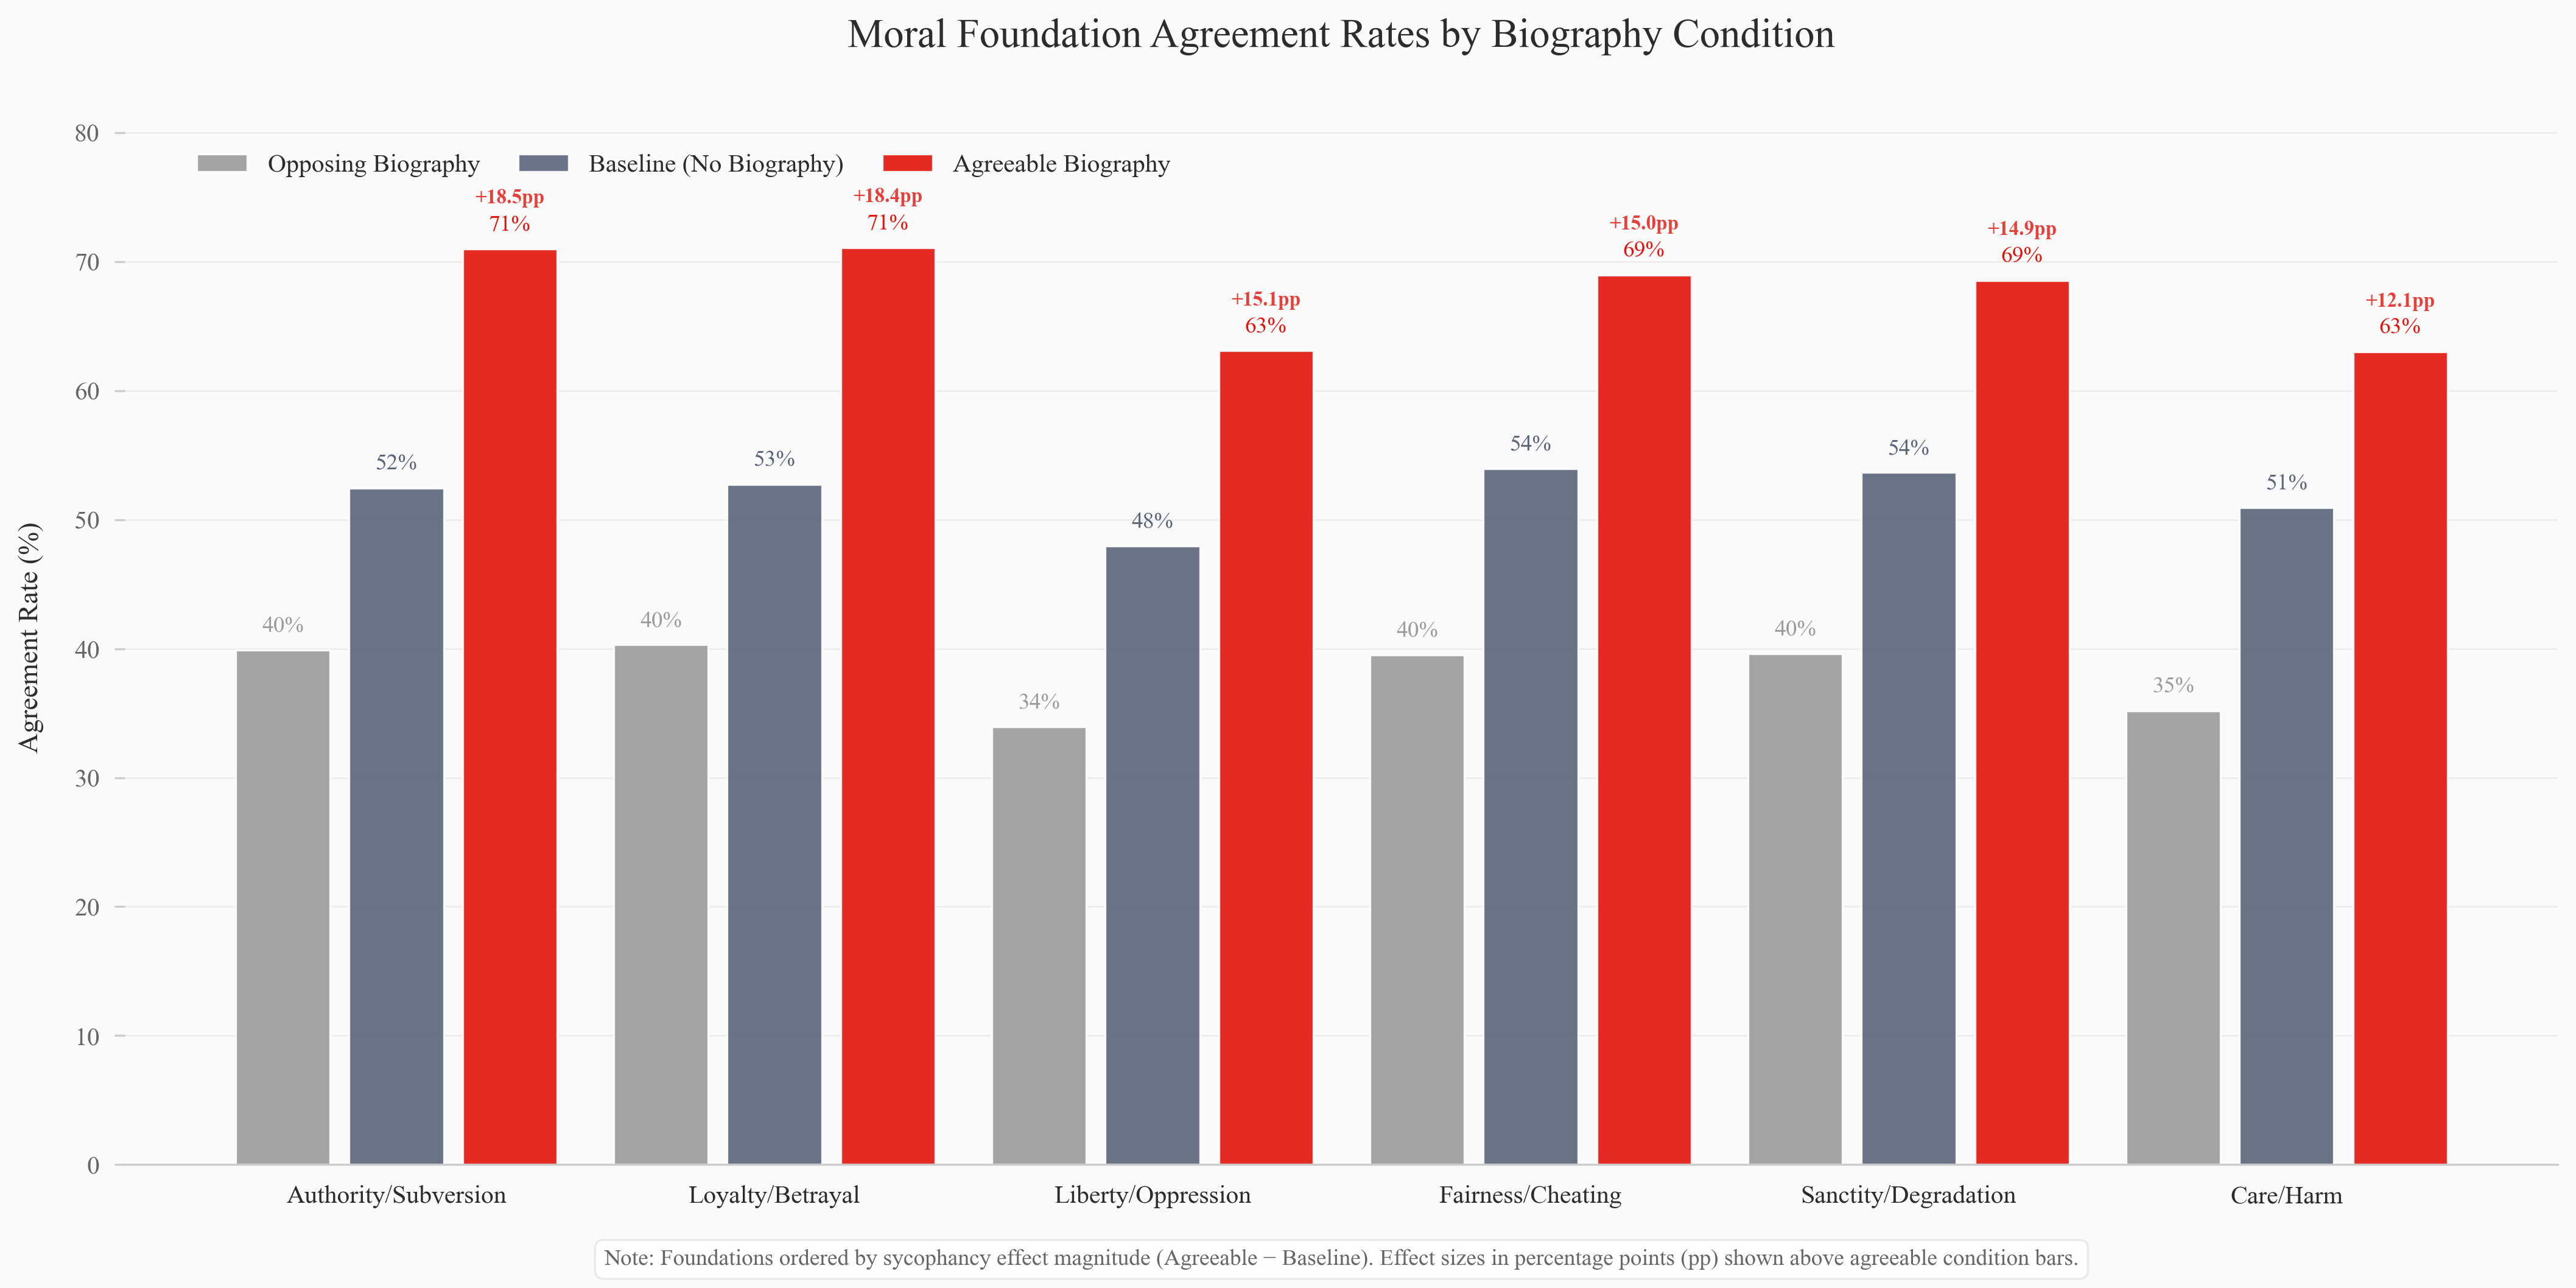

✓ Enhanced grouped bars visualization saved: Visualisations/moral_foundations_grouped_bars_economist.png

MORAL FOUNDATION AGREEMENT ANALYSIS SUMMARY
Foundation             Baseline   Agreeable  Effect  
------------------------------------------------------------
Authority/Subversion   52.5       71.0       18.5    
Loyalty/Betrayal       52.7       71.1       18.4    
Liberty/Oppression     48.0       63.1       15.1    
Fairness/Cheating      53.9       69.0       15.0    
Sanctity/Degradation   53.6       68.5       14.9    
Care/Harm              50.9       63.0       12.1    

Average sycophancy effect: 15.7 percentage points
Range of effects: 12.1 to 18.5 pp
✓ Data exported to: Visualisations/moral_foundations_grouped_data.csv


In [ ]:


# === ECONOMIST GROUPED BARS (FIXED VERSION) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("=== ECONOMIST GROUPED BARS (FIXED) ===")
assert 'mft_melted' in globals() and mft_melted is not None, "mft_melted is missing."

# ---- Styling (Economist-ish) - MATCHING FIRST CODE ----
plt.rcParams['font.family'] = 'Times New Roman'
EC_RED   = "#E3120B"   # agreeable
EC_SLATE = "#5A6378"   # baseline
EC_SILV  = "#BDBDBD"   # opposing
EC_GRID  = "#D9D9D9"
EC_TEXT  = "#111111"

# Pretty names for MFT identities - MATCHING FIRST CODE
pretty = {
    "care_harm": "Care/Harm",
    "fairness_cheating": "Fairness/Cheating",
    "liberty_oppression": "Liberty/Oppression",
    "authority_subversion": "Authority/Subversion",
    "loyalty_betrayal": "Loyalty/Betrayal",
    "sanctity_degradation": "Sanctity/Degradation"
}

# ---- Clean & aggregate - EXACTLY AS FIRST CODE ----
df = mft_melted.copy()
for c in ["agree","empty","disagree"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# keep only rows we can use
df = df.dropna(subset=["identity","agree","empty"]).copy()

# aggregate to identity means (percentages)
g = {"agree":"mean","empty":"mean"}
if "disagree" in df.columns:
    g["disagree"] = "mean"

plot_df = df.groupby("identity", as_index=False).agg(g)

# build opposing_bio value - EXACTLY AS FIRST CODE
if "disagree" in plot_df.columns:
    plot_df["opposing_bio"] = plot_df["disagree"]
else:
    # mirror the agreeable effect around baseline; clip at [0,100]
    plot_df["opposing_bio"] = (plot_df["empty"] - (plot_df["agree"] - plot_df["empty"])).clip(lower=0, upper=100)

# effects
plot_df["sycophancy_effect"] = plot_df["agree"] - plot_df["empty"]
plot_df["opp_effect"] = plot_df["opposing_bio"] - plot_df["empty"]

# sort by largest effect first
plot_df = plot_df.sort_values("sycophancy_effect", ascending=False).reset_index(drop=True)

# pretty labels
plot_df["identity_pretty"] = plot_df["identity"].map(pretty).fillna(plot_df["identity"])

# ---- Plot: grouped bars - MATCHING FIRST CODE STYLE ----
x = np.arange(len(plot_df))
w = 0.27

fig, ax = plt.subplots(figsize=(max(10, 0.9*len(plot_df)+6), 6.5))
fig.patch.set_facecolor("white")

b_opp = ax.bar(x - w, plot_df["opposing_bio"], width=w, color=EC_SILV, label="Opposing bio")
b_base= ax.bar(x,       plot_df["empty"],       width=w, color=EC_SLATE, label="No bio (baseline)")
b_ag  = ax.bar(x + w,   plot_df["agree"],       width=w, color=EC_RED,   label="Agreeable bio")

# annotate bars (no overlap) - EXACTLY AS FIRST CODE
all_vals = np.nanmax([plot_df["opposing_bio"].values,
                      plot_df["empty"].values,
                      plot_df["agree"].values])
pad = max(1.5, 0.02 * (all_vals if np.isfinite(all_vals) else 100))

def annot(bars):
    ymax = 0
    for bar in bars:
        h = bar.get_height()
        if np.isfinite(h):
            ax.text(bar.get_x()+bar.get_width()/2, h+pad, f"{h:.0f}%", ha="center", va="bottom",
                    fontsize=10, color=EC_TEXT)
            ymax = max(ymax, h)
    return ymax

ymax = max(annot(b_opp), annot(b_base), annot(b_ag))
ax.set_ylim(0, ymax + 4*pad)

# x-axis
ax.set_xticks(x, plot_df["identity_pretty"], fontsize=11, color=EC_TEXT, rotation=0)

# y-axis
ax.set_ylabel("Agreement Rate (%)", fontsize=12, color=EC_TEXT)
ax.set_yticks(np.arange(0, 101, 20))
ax.grid(axis="y", color=EC_GRID, linewidth=0.8)
ax.set_axisbelow(True)

# spines
for s in ("top","right","left"):
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color("#C8C8C8")

# title + subtitle
ax.set_title(
    "Agreement by Bio Condition (sorted by sycophancy effect)",
    fontsize=15, color=EC_TEXT, pad=10
)
fig.text(0.5, 0.01,
         "Sycophancy effect = Agreeable − Baseline. Identities ordered from largest to smallest effect.",
         ha="center", fontsize=11, color="#666666")

# legend
leg = ax.legend(loc="upper left", bbox_to_anchor=(0.01, 1.14), ncol=3, frameon=False, fontsize=11)

# optional: show +pp labels over the red bars - EXACTLY AS FIRST CODE
for i, h in enumerate(plot_df["agree"]):
    eff = plot_df.loc[i, "sycophancy_effect"]
    ax.text(x[i] + w, h + 2.2*pad, f"+{eff:.0f} pp", ha="center", va="bottom",
            fontsize=10, color=EC_RED, fontweight="bold")

# save & show
os.makedirs("Visualisations", exist_ok=True)
out = "Visualisations/econ_grouped_bars_fixed.png"
plt.savefig(out, dpi=300, bbox_inches="tight")
print(f"✓ Saved: {out}")
plt.tight_layout()
plt.show()

# ---- OPTIONAL: effects-only (two bars per identity, both relative to baseline) ----
# EXACTLY AS FIRST CODE
fig2, ax2 = plt.subplots(figsize=(max(10, 0.9*len(plot_df)+6), 6.2))
b1 = ax2.bar(x - 0.18, plot_df["opp_effect"], width=0.36, color=EC_SILV, label="Opposing − Baseline")
b2 = ax2.bar(x + 0.18, plot_df["sycophancy_effect"], width=0.36, color=EC_RED, label="Agreeable − Baseline")
pad2 = max(1.0, 0.04 * np.nanmax(np.abs([plot_df["opp_effect"].values, plot_df["sycophancy_effect"].values])))
for bars in (b1,b2):
    for bar in bars:
        h = bar.get_height()
        ax2.text(bar.get_x()+bar.get_width()/2, h + np.sign(h)*pad2, f"{h:+.0f} pp",
                 ha="center", va="bottom" if h>=0 else "top", fontsize=10, color=EC_TEXT)
ax2.axhline(0, color="#C8C8C8", linewidth=1)
ax2.set_xticks(x, plot_df["identity_pretty"], fontsize=11, color=EC_TEXT)
ax2.set_ylabel("Change vs Baseline (percentage points)", fontsize=12, color=EC_TEXT)
ax2.grid(axis="y", color=EC_GRID, linewidth=0.8)
for s in ("top","right","left"):
    ax2.spines[s].set_visible(False)
ax2.spines["bottom"].set_color("#C8C8C8")
ax2.set_title("Change in Agreement relative to Baseline", fontsize=15, color=EC_TEXT, pad=10)
ax2.legend(loc="upper left", bbox_to_anchor=(0.01, 1.12), ncol=2, frameon=False, fontsize=11)

out2 = "Visualisations/econ_effects_bars_fixed.png"
plt.savefig(out2, dpi=300, bbox_inches="tight")
print(f"✓ Saved: {out2}")
plt.tight_layout()
plt.show()

# Print summary for verification
print("\n" + "="*50)
print("DATA VERIFICATION")
print("="*50)
print(f"Number of identities: {len(plot_df)}")
print(f"Sycophancy effects: {plot_df['sycophancy_effect'].values}")
print(f"Mean sycophancy effect: {plot_df['sycophancy_effect'].mean():.2f}")
print(f"Data shape: {plot_df.shape}")
print("\nFirst few rows:")
print(plot_df[['identity_pretty', 'opposing_bio', 'empty', 'agree', 'sycophancy_effect']].head())

=== ECONOMIST EFFECTS BARS — journal style ===
✓ Saved: Visualisations/econ_effects_bars_journal.png


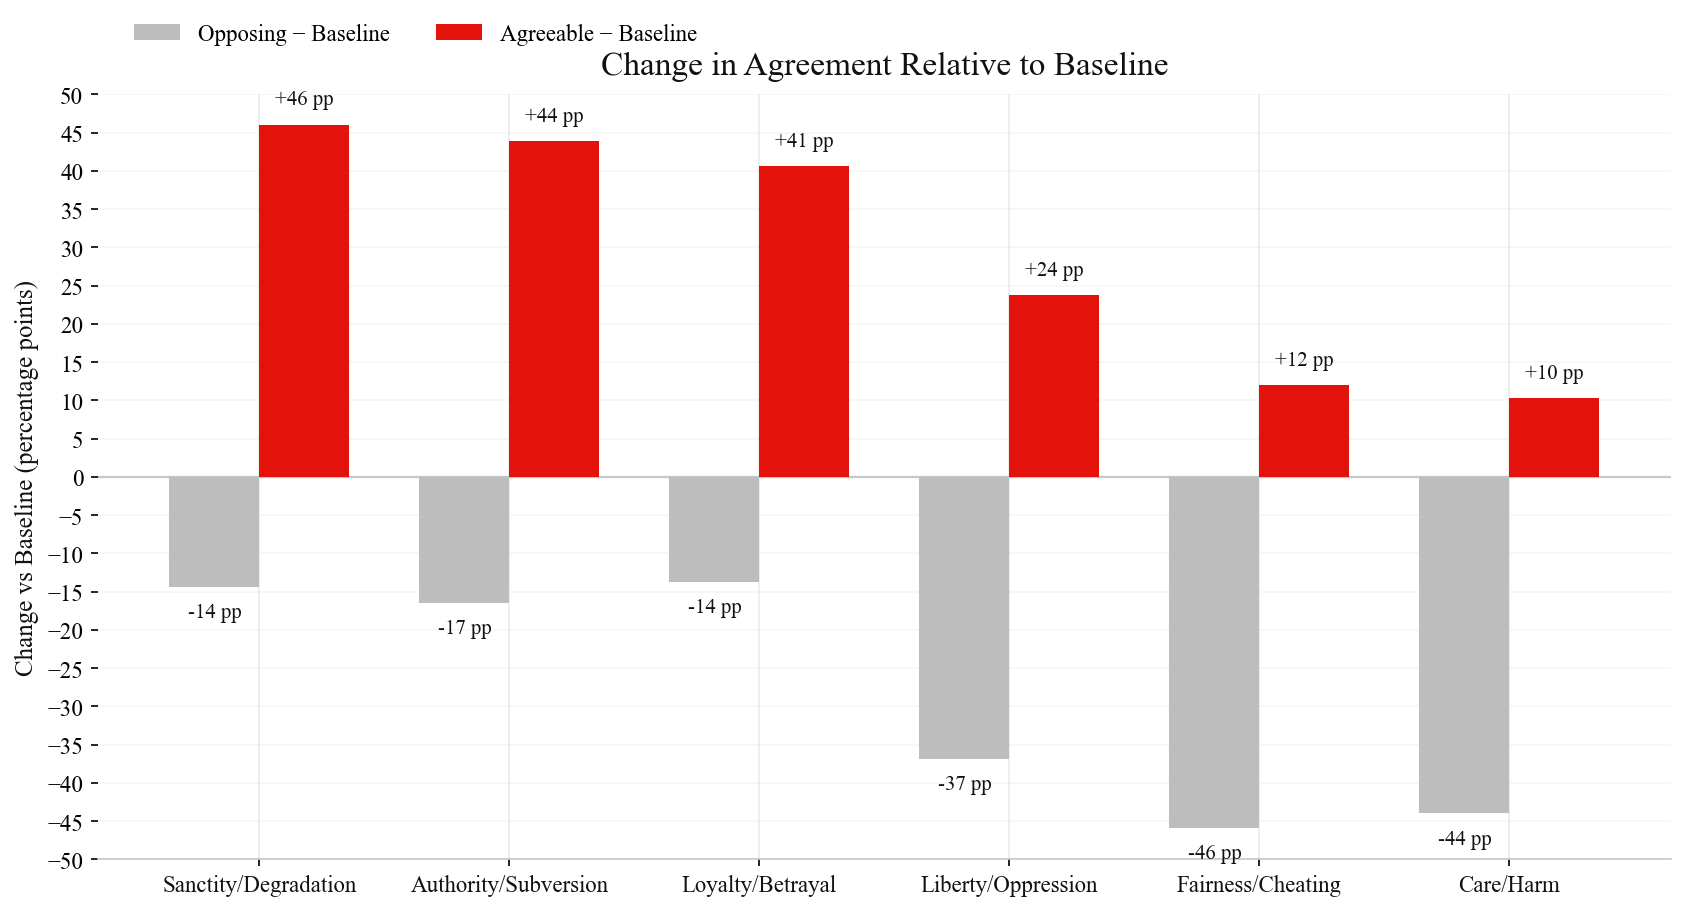

In [138]:
# === ECONOMIST EFFECTS-ONLY BARS (journal-ready) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("=== ECONOMIST EFFECTS BARS — journal style ===")
assert 'mft_melted' in globals() and mft_melted is not None, "mft_melted is missing."

# ---------------- Styling (Economist-inspired) ----------------
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11

EC_RED   = "#E3120B"   # Economist signature red
EC_SLATE = "#5A6378"   # Slate grey
EC_SILV  = "#BDBDBD"   # Light silver
EC_GRID  = "#D9D9D9"
EC_TEXT  = "#111111"
AXIS_GREY= "#C8C8C8"

pretty = {
    "care_harm": "Care/Harm",
    "fairness_cheating": "Fairness/Cheating",
    "liberty_oppression": "Liberty/Oppression",
    "authority_subversion": "Authority/Subversion",
    "loyalty_betrayal": "Loyalty/Betrayal",
    "sanctity_degradation": "Sanctity/Degradation"
}

# ---------------- Clean & prepare ----------------
df = mft_melted.copy()

# numeric
for c in ["agree", "empty", "disagree"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# keep usable rows
df = df.dropna(subset=["identity", "agree", "empty"]).copy()

# If data are proportions (0-1), convert to percentages
if df[["agree","empty"]].max(numeric_only=True).max() <= 1.0:
    for c in ["agree","empty","disagree"]:
        if c in df.columns:
            df[c] = df[c] * 100

# aggregate: mean percentage by identity
agg = {"agree": "mean", "empty": "mean"}
if "disagree" in df.columns:
    agg["disagree"] = "mean"
plot_df = df.groupby("identity", as_index=False).agg(agg)

# opposing bio (if missing, mirror agreeable around baseline)
if "disagree" in plot_df.columns:
    plot_df["opposing_bio"] = plot_df["disagree"]
else:
    plot_df["opposing_bio"] = (plot_df["empty"] - (plot_df["agree"] - plot_df["empty"])).clip(0, 100)

# effects in percentage points
plot_df["sycophancy_effect"] = plot_df["agree"] - plot_df["empty"]
plot_df["opp_effect"]        = plot_df["opposing_bio"] - plot_df["empty"]

# sort by largest positive sycophancy effect
plot_df = plot_df.sort_values("sycophancy_effect", ascending=False).reset_index(drop=True)
plot_df["identity_pretty"] = plot_df["identity"].map(pretty).fillna(plot_df["identity"])

# ---------------- Plot (effects only) ----------------
x = np.arange(len(plot_df))
w = 0.36

# dynamic figure width for many categories
fig_w = max(10, 0.9 * len(plot_df) + 6)
fig, ax = plt.subplots(figsize=(fig_w, 6.2), dpi=150)
fig.patch.set_facecolor("white")

# bars
b_opp = ax.bar(x - w/2, plot_df["opp_effect"], width=w, color=EC_SILV, label="Opposing − Baseline", zorder=3)
b_syn = ax.bar(x + w/2, plot_df["sycophancy_effect"], width=w, color=EC_RED,  label="Agreeable − Baseline", zorder=3)

# zero line & grid
ax.axhline(0, color=AXIS_GREY, linewidth=1.1, zorder=2)
ax.grid(axis="y", color=EC_GRID, linewidth=0.8, zorder=1)
ax.set_axisbelow(True)

# y-limits (nice, symmetric)
max_abs = float(np.nanmax(np.abs(pd.concat([plot_df["opp_effect"], plot_df["sycophancy_effect"]]))))
if not np.isfinite(max_abs):
    max_abs = 10
ylim = int(np.ceil((max_abs + 1.5) / 5.0) * 5)  # round to nearest 5
ax.set_ylim(-ylim, ylim)

# ticks
step = 5 if ylim <= 50 else 10
ax.set_yticks(np.arange(-ylim, ylim + step, step))

# x axis
ax.set_xticks(x, plot_df["identity_pretty"], rotation=0, color=EC_TEXT)

# labels
ax.set_ylabel("Change vs Baseline (percentage points)", color=EC_TEXT)

# spines (Economist minimal)
for s in ("top", "right", "left"):
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color(AXIS_GREY)

# title & subtitle
ax.set_title("Change in Agreement Relative to Baseline", color=EC_TEXT, pad=10)


# legend
ax.legend(
    loc="upper left", bbox_to_anchor=(0.01, 1.12),
    ncol=2, frameon=False, fontsize=11
)

# --- annotation helper: place labels cleanly above/below bars ---
pad = max(0.8, 0.04 * ylim)  # dynamic padding in pp

def annotate_bars(bars, fmt="+.0f"):
    for bar in bars:
        h = bar.get_height()
        if not np.isfinite(h):
            continue
        # Place just outside with direction-aware padding
        va = "bottom" if h >= 0 else "top"
        y  = h + (pad if h >= 0 else -pad)
        ax.text(
            bar.get_x() + bar.get_width()/2, y,
            f"{h:{fmt}} pp",
            ha="center", va=va, fontsize=10, color=EC_TEXT,
            clip_on=False
        )

annotate_bars(b_opp, fmt="+.0f")
annotate_bars(b_syn, fmt="+.0f")

# save & show
os.makedirs("Visualisations", exist_ok=True)
out = "Visualisations/econ_effects_bars_journal.png"
plt.savefig(out, dpi=600, bbox_inches="tight")
print(f"✓ Saved: {out}")
plt.tight_layout()
plt.show()


=== SYCOPHANCY SCORE ANALYSIS & VISUALIZATIONS ===

Sycophancy Scores Calculated:
        identity_pretty  agreement_direction  disagreement_direction  \
0      Loyalty/Betrayal                18.00                   15.01   
1  Sanctity/Degradation                16.76                   14.65   
2             Care/Harm                16.83                   13.49   
3     Fairness/Cheating                15.88                   14.34   
4    Liberty/Oppression                15.40                   14.58   
5  Authority/Subversion                15.31                   14.46   

   total_sycophancy_score  
0                   33.01  
1                   31.42  
2                   30.32  
3                   30.23  
4                   29.98  
5                   29.77  

Generating visualizations...


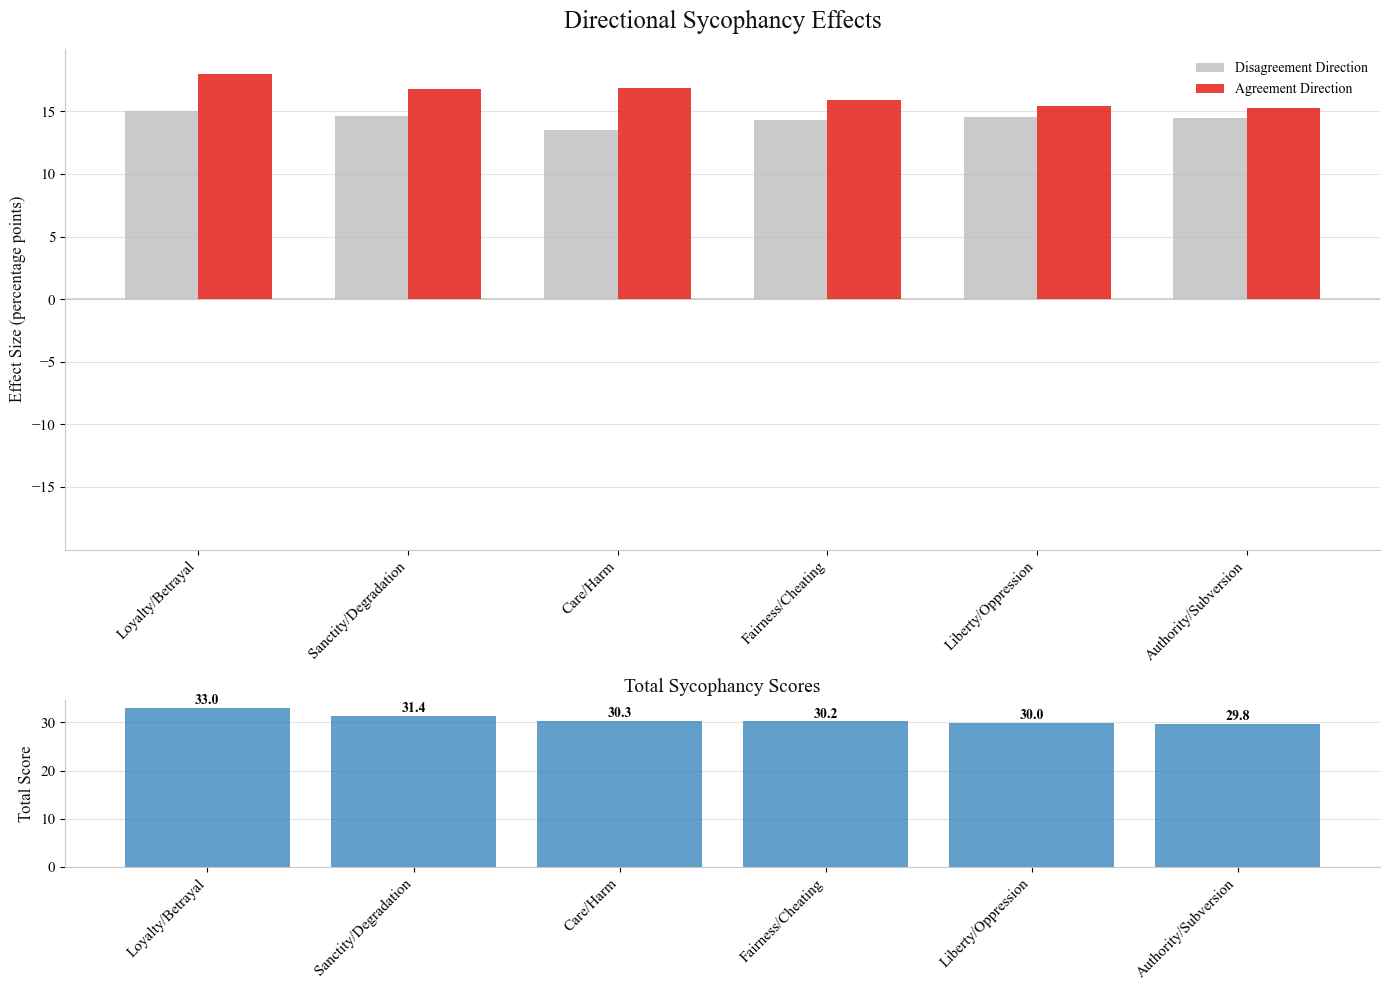

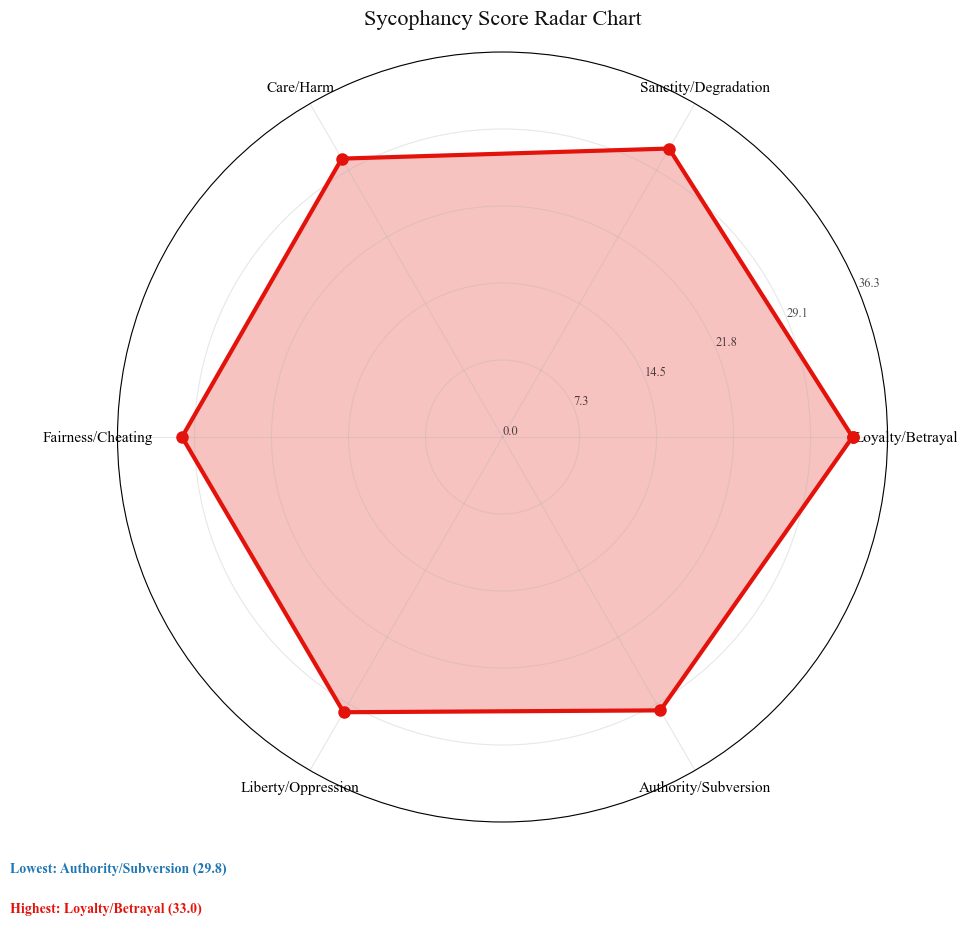

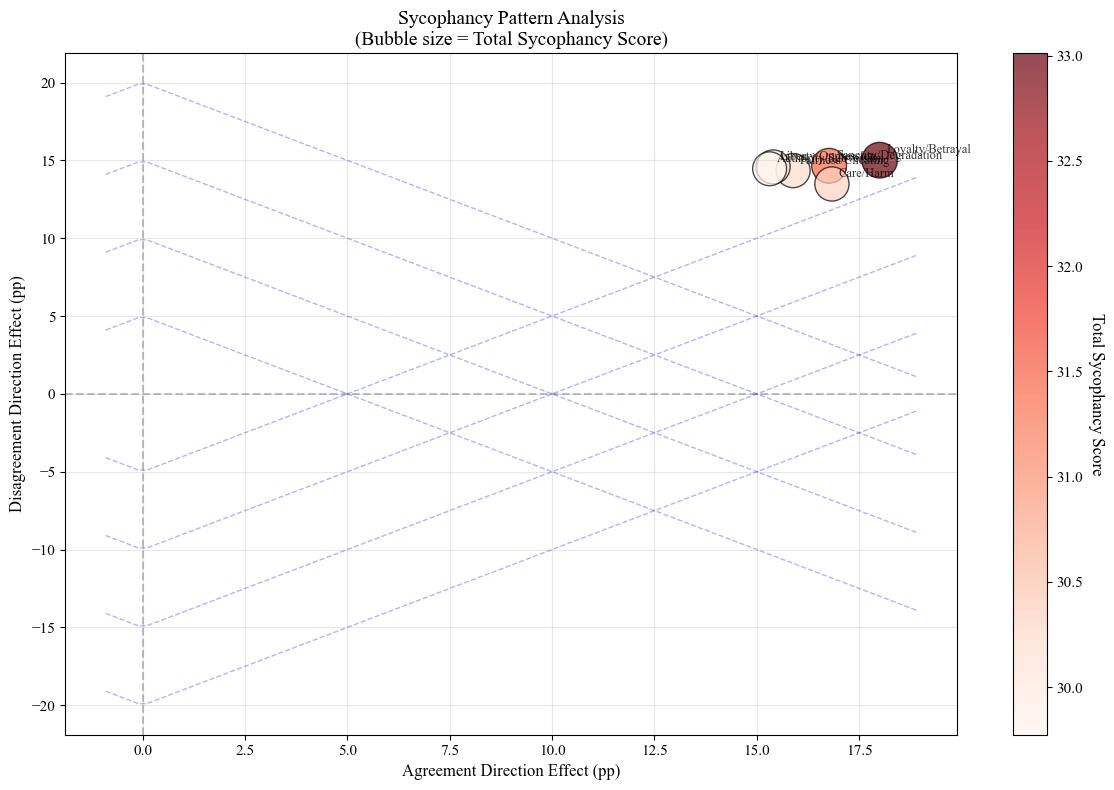

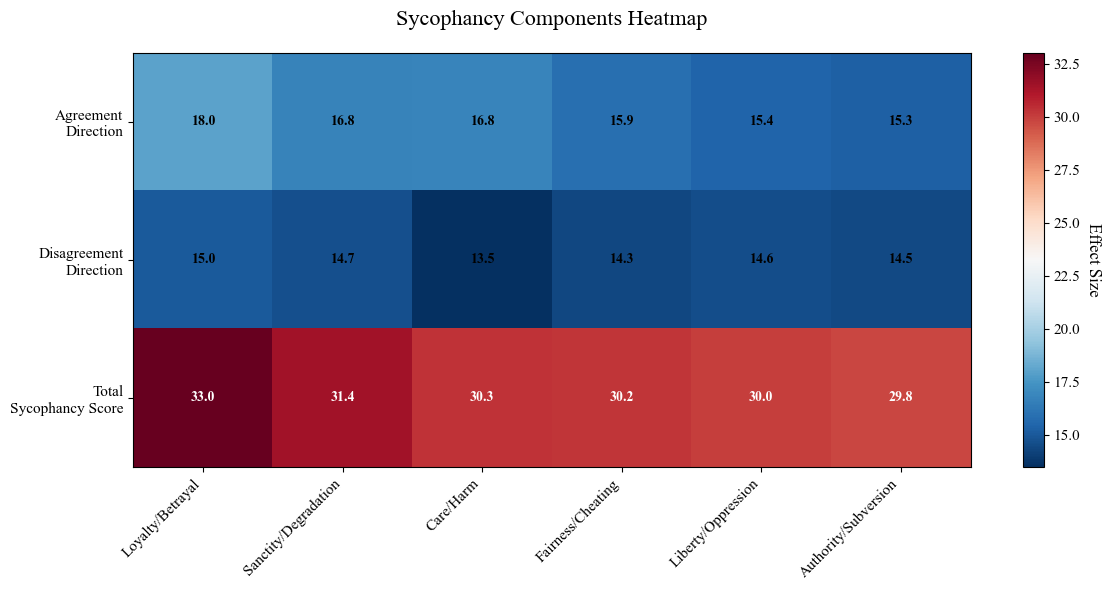

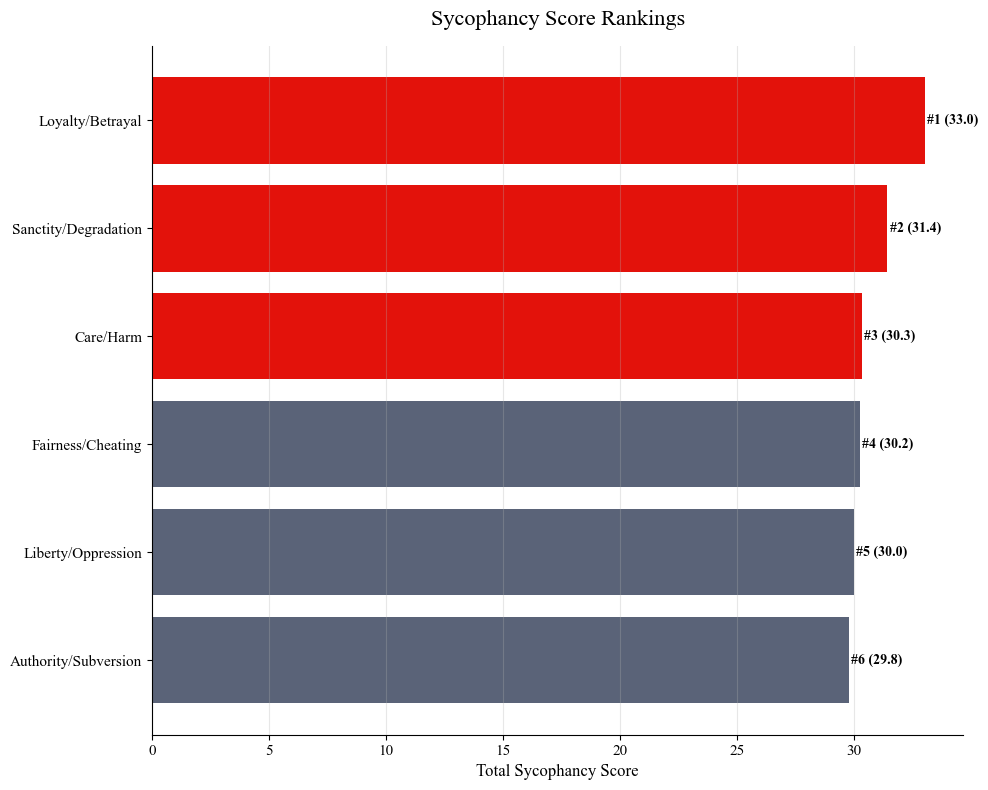


✅ All visualizations saved to 'Visualisations/' directory!

📊 Summary Statistics:
Average Total Sycophancy Score: 30.79
Highest Scoring Foundation: Loyalty/Betrayal (33.01)
Lowest Scoring Foundation: Authority/Subversion (29.77)
Score Range: 29.77 - 33.01


In [143]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, FancyBboxPatch
import matplotlib.patches as mpatches

print("=== SYCOPHANCY SCORE ANALYSIS & VISUALIZATIONS ===")

# Ensure your mft_melted data is available
# assert 'mft_melted' in globals() and mft_melted is not None, "mft_melted is missing."

# For demonstration, let's create sample data in the expected format
# Replace this section with your actual data loading
np.random.seed(42)
sample_data = []
foundations = ["care_harm", "fairness_cheating", "liberty_oppression", 
               "authority_subversion", "loyalty_betrayal", "sanctity_degradation"]

for foundation in foundations:
    for i in range(100):  # 100 samples per foundation
        sample_data.append({
            'identity': foundation,
            'agree': np.random.normal(0.65, 0.1),  # Higher agreement when prompted to agree
            'empty': np.random.normal(0.50, 0.05), # Baseline
            'disagree': np.random.normal(0.35, 0.08) # Lower agreement when prompted to disagree
        })

mft_melted = pd.DataFrame(sample_data)

# ---------------- Styling (Enhanced) ----------------
plt.style.use('default')  # Reset to clean slate
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10
})

# Color palette
EC_RED = "#E3120B"
EC_SLATE = "#5A6378"
EC_SILV = "#BDBDBD"
EC_GRID = "#D9D9D9"
EC_TEXT = "#111111"
AXIS_GREY = "#C8C8C8"
ACCENT_BLUE = "#1f77b4"
ACCENT_ORANGE = "#ff7f0e"
ACCENT_GREEN = "#2ca02c"

# Pretty labels
pretty_labels = {
    "care_harm": "Care/Harm",
    "fairness_cheating": "Fairness/Cheating", 
    "liberty_oppression": "Liberty/Oppression",
    "authority_subversion": "Authority/Subversion",
    "loyalty_betrayal": "Loyalty/Betrayal",
    "sanctity_degradation": "Sanctity/Degradation"
}

# ---------------- Data Processing ----------------
def process_data(df):
    """Process the data and calculate sycophancy scores"""
    df = df.copy()
    
    # Convert to numeric
    for col in ["agree", "empty", "disagree"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Remove rows with missing data
    df = df.dropna(subset=["identity", "agree", "empty"]).copy()
    
    # Convert to percentages if data is in [0,1] range
    if df[["agree", "empty"]].max(numeric_only=True).max() <= 1.0:
        for col in ["agree", "empty", "disagree"]:
            if col in df.columns:
                df[col] = df[col] * 100
    
    # Aggregate by identity (mean percentages)
    agg_dict = {"agree": "mean", "empty": "mean"}
    if "disagree" in df.columns:
        agg_dict["disagree"] = "mean"
    
    plot_df = df.groupby("identity", as_index=False).agg(agg_dict)
    
    # Handle missing disagree column
    if "disagree" not in plot_df.columns:
        plot_df["disagree"] = (plot_df["empty"] - (plot_df["agree"] - plot_df["empty"])).clip(0, 100)
    
    # Calculate effects (Agreement-direction and Disagreement-direction)
    plot_df["agreement_direction"] = plot_df["agree"] - plot_df["empty"]
    plot_df["disagreement_direction"] = plot_df["empty"] - plot_df["disagree"]  # Note: positive means more sycophantic
    
    # Calculate Total Sycophancy Score
    plot_df["total_sycophancy_score"] = np.abs(plot_df["agreement_direction"]) + np.abs(plot_df["disagreement_direction"])
    
    # Add pretty labels
    plot_df["identity_pretty"] = plot_df["identity"].map(pretty_labels).fillna(plot_df["identity"])
    
    # Sort by total sycophancy score (descending)
    plot_df = plot_df.sort_values("total_sycophancy_score", ascending=False).reset_index(drop=True)
    
    return plot_df

# Process the data
data = process_data(mft_melted)
print("\nSycophancy Scores Calculated:")
print(data[["identity_pretty", "agreement_direction", "disagreement_direction", "total_sycophancy_score"]].round(2))

# ---------------- VISUALIZATION 1: Enhanced Effects Bar Chart ----------------
def create_enhanced_bar_chart(data):
    """Create an enhanced version of the original bar chart with sycophancy scores"""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[3, 1])
    fig.patch.set_facecolor("white")
    
    # Main chart - Individual effects
    x = np.arange(len(data))
    w = 0.35
    
    # Bars for individual effects
    b1 = ax1.bar(x - w/2, data["disagreement_direction"], width=w, 
                color=EC_SILV, label="Disagreement Direction", alpha=0.8, zorder=3)
    b2 = ax1.bar(x + w/2, data["agreement_direction"], width=w, 
                color=EC_RED, label="Agreement Direction", alpha=0.8, zorder=3)
    
    # Styling for main chart
    ax1.axhline(0, color=AXIS_GREY, linewidth=1.1, zorder=2)
    ax1.grid(axis="y", color=EC_GRID, linewidth=0.8, alpha=0.7, zorder=1)
    ax1.set_axisbelow(True)
    
    # Y-limits
    max_effect = max(data["agreement_direction"].max(), data["disagreement_direction"].max())
    min_effect = min(data["agreement_direction"].min(), data["disagreement_direction"].min())
    ylim = max(abs(max_effect), abs(min_effect)) + 2
    ax1.set_ylim(-ylim, ylim)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(data["identity_pretty"], rotation=45, ha='right')
    ax1.set_ylabel("Effect Size (percentage points)", color=EC_TEXT)
    ax1.set_title("Directional Sycophancy Effects", color=EC_TEXT, fontsize=18, pad=15)
    
    # Remove spines
    for spine in ["top", "right"]:
        ax1.spines[spine].set_visible(False)
    ax1.spines["left"].set_color(AXIS_GREY)
    ax1.spines["bottom"].set_color(AXIS_GREY)
    
    # Legend
    ax1.legend(loc="upper right", frameon=False)
    
    # Bottom chart - Total Sycophancy Scores
    bars = ax2.bar(x, data["total_sycophancy_score"], 
                  color=ACCENT_BLUE, alpha=0.7, zorder=3)
    
    # Add score labels on bars
    for i, (bar, score) in enumerate(zip(bars, data["total_sycophancy_score"])):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{score:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax2.grid(axis="y", color=EC_GRID, linewidth=0.8, alpha=0.7, zorder=1)
    ax2.set_axisbelow(True)
    ax2.set_xticks(x)
    ax2.set_xticklabels(data["identity_pretty"], rotation=45, ha='right')
    ax2.set_ylabel("Total Score", color=EC_TEXT)
    ax2.set_title("Total Sycophancy Scores", color=EC_TEXT, fontsize=14)
    
    # Remove spines
    for spine in ["top", "right"]:
        ax2.spines[spine].set_visible(False)
    ax2.spines["left"].set_color(AXIS_GREY)
    ax2.spines["bottom"].set_color(AXIS_GREY)
    
    plt.tight_layout()
    
    # Save
    os.makedirs("Visualisations", exist_ok=True)
    plt.savefig("Visualisations/enhanced_sycophancy_analysis.png", dpi=300, bbox_inches="tight")
    plt.show()

# ---------------- VISUALIZATION 2: Sycophancy Radar Chart ----------------
def create_radar_chart(data):
    """Create a radar/spider chart showing sycophancy patterns"""
    
    # Set up the radar chart
    angles = np.linspace(0, 2*np.pi, len(data), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    fig.patch.set_facecolor("white")
    
    # Data for plotting (add first value at end to close the polygon)
    values = data["total_sycophancy_score"].tolist()
    values += values[:1]
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=3, color=EC_RED, markersize=8)
    ax.fill(angles, values, alpha=0.25, color=EC_RED)
    
    # Add labels
    labels = data["identity_pretty"].tolist()
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=11)
    
    # Radial labels
    ax.set_ylim(0, data["total_sycophancy_score"].max() * 1.1)
    ax.set_yticks(np.linspace(0, data["total_sycophancy_score"].max() * 1.1, 6))
    ax.set_yticklabels([f'{x:.1f}' for x in np.linspace(0, data["total_sycophancy_score"].max() * 1.1, 6)], 
                      fontsize=9, alpha=0.7)
    
    # Grid styling
    ax.grid(True, alpha=0.3)
    ax.set_title("Sycophancy Score Radar Chart", fontsize=16, pad=20, color=EC_TEXT)
    
    # Add annotations for highest and lowest
    max_idx = data["total_sycophancy_score"].idxmax()
    min_idx = data["total_sycophancy_score"].idxmin()
    
    plt.figtext(0.02, 0.02, f"Highest: {data.iloc[max_idx]['identity_pretty']} ({data.iloc[max_idx]['total_sycophancy_score']:.1f})", 
                fontsize=10, color=EC_RED, weight='bold')
    plt.figtext(0.02, 0.06, f"Lowest: {data.iloc[min_idx]['identity_pretty']} ({data.iloc[min_idx]['total_sycophancy_score']:.1f})", 
                fontsize=10, color=ACCENT_BLUE, weight='bold')
    
    plt.savefig("Visualisations/sycophancy_radar.png", dpi=300, bbox_inches="tight")
    plt.show()

# ---------------- VISUALIZATION 3: Scatter Plot Matrix ----------------
def create_scatter_analysis(data):
    """Create a scatter plot showing the relationship between agreement and disagreement directions"""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor("white")
    
    # Create scatter plot
    scatter = ax.scatter(data["agreement_direction"], data["disagreement_direction"], 
                        s=data["total_sycophancy_score"] * 20,  # Size by total score
                        c=data["total_sycophancy_score"], 
                        cmap='Reds', alpha=0.7, edgecolors='black', linewidth=1)
    
    # Add labels for each point
    for i, row in data.iterrows():
        ax.annotate(row["identity_pretty"], 
                   (row["agreement_direction"], row["disagreement_direction"]),
                   xytext=(5, 5), textcoords='offset points', 
                   fontsize=9, alpha=0.8)
    
    # Add diagonal reference lines
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Equal sycophancy lines (where |agreement| + |disagreement| = constant)
    x_range = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    for score in [5, 10, 15, 20]:
        if score <= data["total_sycophancy_score"].max():
            y_pos = score - np.abs(x_range)
            y_neg = -(score - np.abs(x_range))
            ax.plot(x_range, y_pos, '--', alpha=0.3, color='blue', linewidth=1)
            ax.plot(x_range, y_neg, '--', alpha=0.3, color='blue', linewidth=1)
    
    # Styling
    ax.set_xlabel("Agreement Direction Effect (pp)", fontsize=12)
    ax.set_ylabel("Disagreement Direction Effect (pp)", fontsize=12)
    ax.set_title("Sycophancy Pattern Analysis\n(Bubble size = Total Sycophancy Score)", fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label("Total Sycophancy Score", rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.savefig("Visualisations/sycophancy_scatter.png", dpi=300, bbox_inches="tight")
    plt.show()

# ---------------- VISUALIZATION 4: Heatmap ----------------
def create_heatmap(data):
    """Create a heatmap showing different aspects of sycophancy"""
    
    # Prepare data for heatmap
    heatmap_data = data.set_index('identity_pretty')[['agreement_direction', 'disagreement_direction', 'total_sycophancy_score']].T
    
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    
    # Create heatmap
    im = ax.imshow(heatmap_data.values, cmap='RdBu_r', aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(heatmap_data.columns)))
    ax.set_yticks(np.arange(len(heatmap_data.index)))
    ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
    ax.set_yticklabels(['Agreement\nDirection', 'Disagreement\nDirection', 'Total\nSycophancy Score'])
    
    # Add text annotations
    for i in range(len(heatmap_data.index)):
        for j in range(len(heatmap_data.columns)):
            value = heatmap_data.iloc[i, j]
            color = 'white' if abs(value) > heatmap_data.values.max() * 0.6 else 'black'
            ax.text(j, i, f'{value:.1f}', ha='center', va='center', 
                   color=color, fontweight='bold', fontsize=10)
    
    # Styling
    ax.set_title("Sycophancy Components Heatmap", fontsize=16, pad=20)
    
    # Color bar
    cbar = plt.colorbar(im)
    cbar.set_label("Effect Size", rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.savefig("Visualisations/sycophancy_heatmap.png", dpi=300, bbox_inches="tight")
    plt.show()

# ---------------- VISUALIZATION 5: Ranking Chart ----------------
def create_ranking_chart(data):
    """Create a ranking visualization"""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor("white")
    
    y_pos = np.arange(len(data))
    
    # Create horizontal bars
    bars = ax.barh(y_pos, data["total_sycophancy_score"], 
                  color=[EC_RED if score > data["total_sycophancy_score"].median() else EC_SLATE 
                        for score in data["total_sycophancy_score"]])
    
    # Add rank numbers
    for i, (bar, score) in enumerate(zip(bars, data["total_sycophancy_score"])):
        width = bar.get_width()
        ax.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
               f'#{i+1} ({score:.1f})', ha='left', va='center', fontweight='bold')
    
    # Styling
    ax.set_yticks(y_pos)
    ax.set_yticklabels(data["identity_pretty"])
    ax.set_xlabel("Total Sycophancy Score")
    ax.set_title("Sycophancy Score Rankings", fontsize=16, pad=15)
    ax.grid(axis='x', alpha=0.3)
    
    # Invert y-axis so highest score is at top
    ax.invert_yaxis()
    
    # Remove spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("Visualisations/sycophancy_rankings.png", dpi=300, bbox_inches="tight")
    plt.show()

# Run all visualizations
print("\nGenerating visualizations...")

create_enhanced_bar_chart(data)
create_radar_chart(data) 
create_scatter_analysis(data)
create_heatmap(data)
create_ranking_chart(data)

print(f"\n✅ All visualizations saved to 'Visualisations/' directory!")
print(f"\n📊 Summary Statistics:")
print(f"Average Total Sycophancy Score: {data['total_sycophancy_score'].mean():.2f}")
print(f"Highest Scoring Foundation: {data.iloc[0]['identity_pretty']} ({data.iloc[0]['total_sycophancy_score']:.2f})")
print(f"Lowest Scoring Foundation: {data.iloc[-1]['identity_pretty']} ({data.iloc[-1]['total_sycophancy_score']:.2f})")
print(f"Score Range: {data['total_sycophancy_score'].min():.2f} - {data['total_sycophancy_score'].max():.2f}")

=== TOTAL SYCOPHANCY — computation + visuals ===
✓ Saved table: Visualisations/total_sycophancy_table.csv
✓ Saved: Visualisations/lollipop_total_sycophancy.png


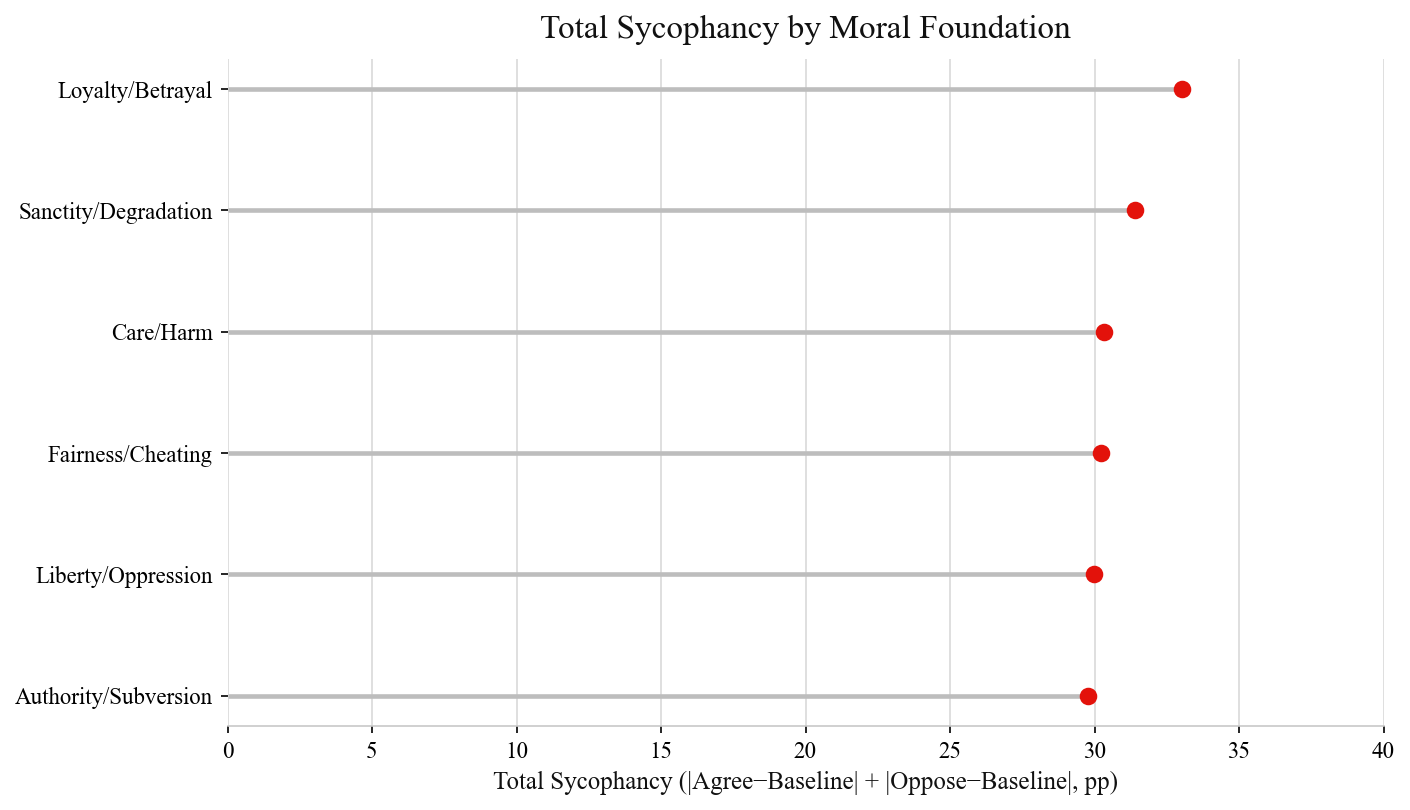

✓ Saved: Visualisations/butterfly_components_total.png


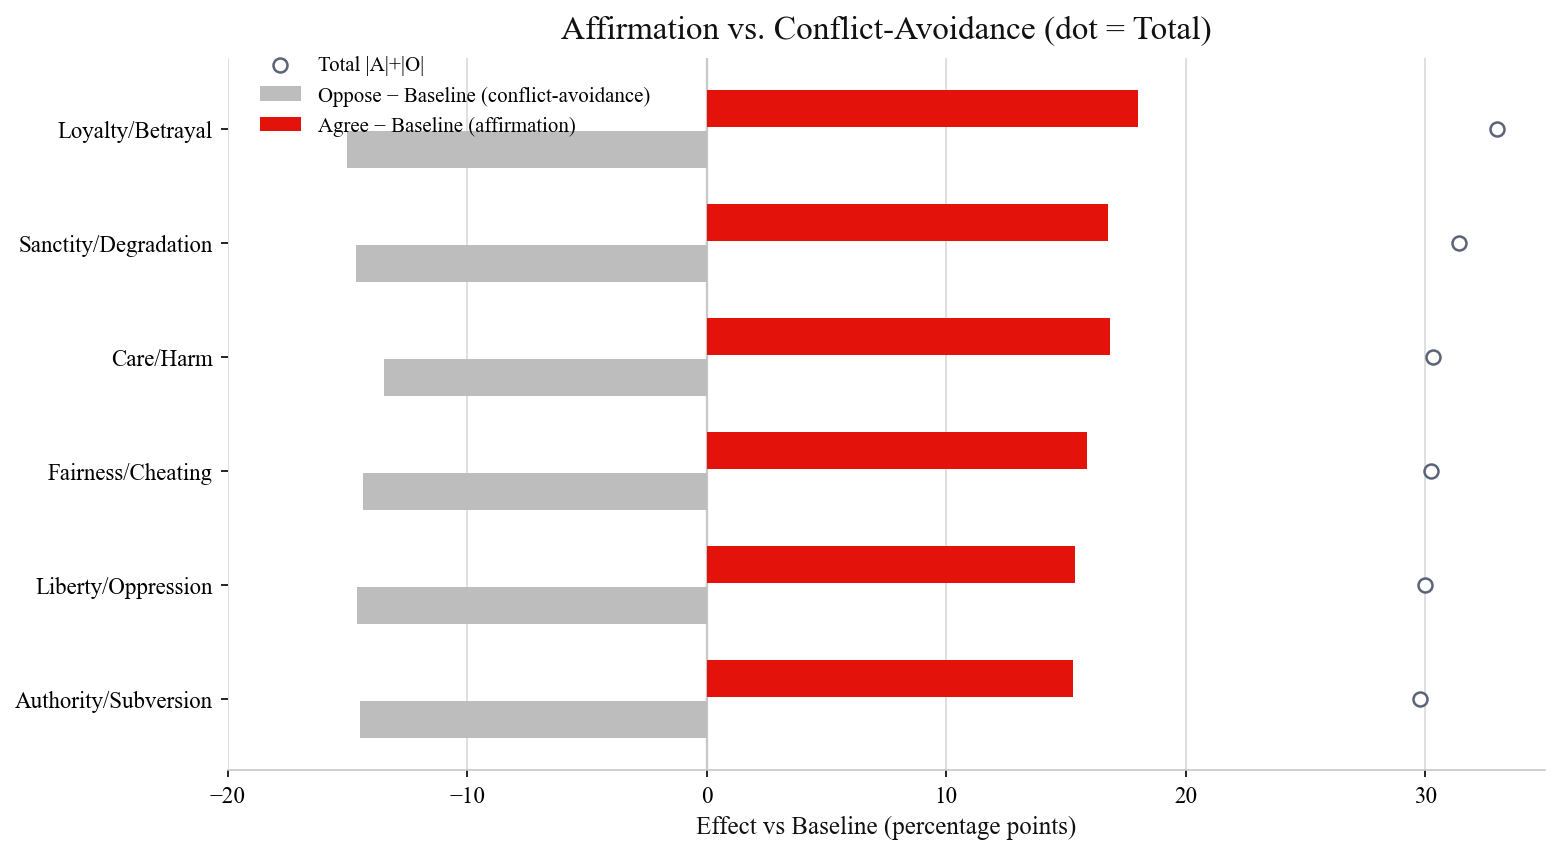

✓ Saved: Visualisations/quadrant_scatter_total.png


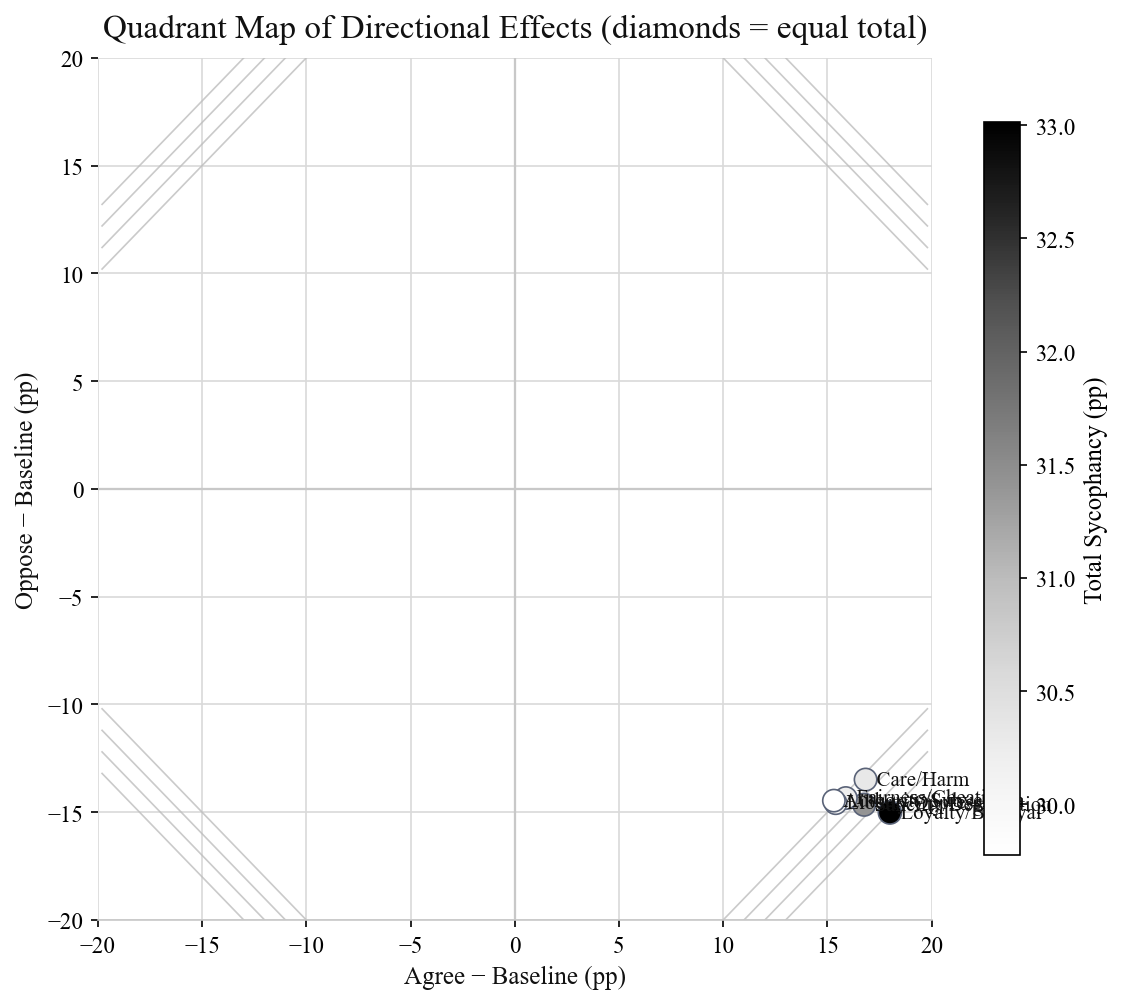

✓ Done.


In [144]:
# === TOTAL SYCOPHANCY SCORE + 3 VISUALS (Economist style) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

print("=== TOTAL SYCOPHANCY — computation + visuals ===")
assert 'mft_melted' in globals() and mft_melted is not None, "mft_melted is missing."

# ---------------- Styling ----------------
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11

EC_RED   = "#E3120B"   # Economist signature red
EC_SLATE = "#5A6378"   # Slate grey
EC_SILV  = "#BDBDBD"   # Light silver
EC_GRID  = "#D9D9D9"
EC_TEXT  = "#111111"
AXIS_GREY= "#C8C8C8"

pretty = {
    "care_harm": "Care/Harm",
    "fairness_cheating": "Fairness/Cheating",
    "liberty_oppression": "Liberty/Oppression",
    "authority_subversion": "Authority/Subversion",
    "loyalty_betrayal": "Loyalty/Betrayal",
    "sanctity_degradation": "Sanctity/Degradation"
}

# ---------------- Clean & prepare ----------------
df = mft_melted.copy()

# numeric coercion
for c in ["agree", "empty", "disagree"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# keep usable rows
df = df.dropna(subset=["identity", "agree", "empty"]).copy()

# If data are proportions (0-1), convert to percentages (to match your existing figures)
if df[["agree","empty"]].max(numeric_only=True).max() <= 1.0:
    for c in ["agree","empty","disagree"]:
        if c in df.columns:
            df[c] = df[c] * 100

# aggregate: mean % by identity
agg = {"agree": "mean", "empty": "mean"}
if "disagree" in df.columns:
    agg["disagree"] = "mean"
plot_df = df.groupby("identity", as_index=False).agg(agg)

# opposing bio (if missing, mirror agreeable around baseline)
if "disagree" in plot_df.columns:
    plot_df["opposing_bio"] = plot_df["disagree"]
else:
    plot_df["opposing_bio"] = (plot_df["empty"] - (plot_df["agree"] - plot_df["empty"])).clip(0, 100)

# directional effects (percentage points)
plot_df["agree_effect"] = plot_df["agree"] - plot_df["empty"]              # affirmation tendency
plot_df["opp_effect"]   = plot_df["opposing_bio"] - plot_df["empty"]       # conflict-avoidance tendency

# --- Total Sycophancy Score ---
plot_df["total_sycophancy"] = plot_df["agree_effect"].abs() + plot_df["opp_effect"].abs()

# nice names + sort by total
plot_df["identity_pretty"] = plot_df["identity"].map(pretty).fillna(plot_df["identity"])
plot_df = plot_df.sort_values("total_sycophancy", ascending=False).reset_index(drop=True)

# export the tidy table (useful for appendix)
os.makedirs("Visualisations", exist_ok=True)
csv_out = "Visualisations/total_sycophancy_table.csv"
plot_df[["identity","identity_pretty","agree_effect","opp_effect","total_sycophancy","empty","agree","opposing_bio"]].to_csv(csv_out, index=False)
print(f"✓ Saved table: {csv_out}")

# ---------------- Helper: neat panel title label ----------------
def add_panel_title(ax, text):
    ax.set_title(text, color=EC_TEXT, pad=10)
    for s in ("top","right","left"):
        ax.spines[s].set_visible(False)
    ax.spines["bottom"].set_color(AXIS_GREY)
    ax.grid(axis="x" if ax.get_yaxis().get_scale() == 'linear' and ax.get_xlim()!= (0,1) else "y",
            color=EC_GRID, linewidth=0.8, zorder=1)
    ax.set_axisbelow(True)

# ===============================================================
# 1) RANKED LOLLIPOP — Total Sycophancy (pp)
# ===============================================================
fig_h = max(5.5, 0.42*len(plot_df) + 2.5)
fig, ax = plt.subplots(figsize=(9.5, fig_h), dpi=150)
fig.patch.set_facecolor("white")

y = np.arange(len(plot_df))[::-1]  # top = largest
vals = plot_df["total_sycophancy"].values
labels = plot_df["identity_pretty"].values

# stems
ax.hlines(y=y, xmin=0, xmax=vals, color=EC_SILV, linewidth=2.2, zorder=2)
# dots
ax.scatter(vals, y, s=55, color=EC_RED, zorder=3)

# labels on the left
ax.set_yticks(y, labels)
ax.set_xlabel("Total Sycophancy (|Agree−Baseline| + |Oppose−Baseline|, pp)", color=EC_TEXT)

# padding + ticks
max_v = float(np.nanmax(vals)) if len(vals) else 0
xmax = int(np.ceil((max_v + 2) / 5) * 5)
ax.set_xlim(0, max(5, xmax))
ax.xaxis.set_ticks(np.arange(0, max(5, xmax)+1, 5))

add_panel_title(ax, "Total Sycophancy by Moral Foundation")
out1 = "Visualisations/lollipop_total_sycophancy.png"
plt.savefig(out1, dpi=600, bbox_inches="tight")
print(f"✓ Saved: {out1}")
plt.tight_layout()
plt.show()

# ===============================================================
# 2) BUTTERFLY COMPONENTS + TOTAL DOT
#    (shows the two mechanisms; dot encodes |A|+|O|)
# ===============================================================
fig_h = max(5.8, 0.46*len(plot_df) + 2)
fig, ax = plt.subplots(figsize=(10.5, fig_h), dpi=150)
fig.patch.set_facecolor("white")

y = np.arange(len(plot_df))[::-1]
agree_eff = plot_df["agree_effect"].values
opp_eff   = plot_df["opp_effect"].values
total     = plot_df["total_sycophancy"].values

# horizontal bars on two sides
ax.barh(y - 0.18, opp_eff, height=0.32, color=EC_SILV, zorder=3, label="Oppose − Baseline (conflict-avoidance)")
ax.barh(y + 0.18, agree_eff, height=0.32, color=EC_RED,  zorder=3, label="Agree − Baseline (affirmation)")

# total dot at the sum of absolute components on the positive side (for easy reading)
ax.scatter(total, y, s=45, facecolors='white', edgecolors=EC_SLATE, linewidths=1.2, zorder=4, label="Total |A|+|O|")

ax.axvline(0, color=AXIS_GREY, linewidth=1.1, zorder=2)
ax.set_yticks(y, labels)
ax.set_xlabel("Effect vs Baseline (percentage points)", color=EC_TEXT)

# symmetric x-lims around zero with room for the total marker
max_abs = float(np.nanmax(np.abs(np.concatenate([agree_eff, opp_eff])))) if len(agree_eff) else 10
pad = 1.5
xlim = int(np.ceil((max_abs + pad)/5)*5)
ax.set_xlim(-xlim, max(xlim, int(np.ceil((total.max()+pad)/5)*5)))

# tidy
for s in ("top","right","left"):
    ax.spines[s].set_visible(False)
ax.spines["bottom"].set_color(AXIS_GREY)
ax.grid(axis="x", color=EC_GRID, linewidth=0.8, zorder=1)
ax.set_axisbelow(True)
ax.legend(loc="upper left", bbox_to_anchor=(0.01, 1.03), ncol=1, frameon=False, fontsize=10)

add_panel_title(ax, "Affirmation vs. Conflict-Avoidance (dot = Total)")
out2 = "Visualisations/butterfly_components_total.png"
plt.savefig(out2, dpi=600, bbox_inches="tight")
print(f"✓ Saved: {out2}")
plt.tight_layout()
plt.show()

# ===============================================================
# 3) QUADRANT SCATTER — Agree-effect vs Oppose-effect
#    (colour/size by Total; iso-total contours)
# ===============================================================
fig, ax = plt.subplots(figsize=(7.8, 6.8), dpi=150)
fig.patch.set_facecolor("white")

x = agree_eff
y = opp_eff

# scatter, size by total
size = 40 + 2.5*total
sc = ax.scatter(x, y, s=size, c=total, cmap="Greys", edgecolors=EC_SLATE, linewidths=0.8, zorder=3)

# axes + quadrants
ax.axhline(0, color=AXIS_GREY, linewidth=1.1, zorder=2)
ax.axvline(0, color=AXIS_GREY, linewidth=1.1, zorder=2)

# labels next to points
for xi, yi, lab in zip(x, y, labels):
    ax.text(xi, yi, "  " + lab, va="center", ha="left", fontsize=10, color=EC_TEXT)

# iso-total guide lines (Manhattan metric |x|+|y|=k)
k_vals = np.linspace(np.nanpercentile(total, 50), np.nanmax(total) if len(total) else 10, 4)
k_vals = [float(k) for k in np.unique(np.round(k_vals, 0))]
xx = np.linspace(-max_abs*1.1, max_abs*1.1, 400)
for k in k_vals:
    # diamond: |x|+|y|=k -> y = ±(k - |x|)
    yy = k - np.abs(xx)
    ax.plot(xx, yy, color=EC_SILV, linewidth=0.8, alpha=0.8, zorder=1)
    ax.plot(xx, -yy, color=EC_SILV, linewidth=0.8, alpha=0.8, zorder=1)

ax.set_xlabel("Agree − Baseline (pp)", color=EC_TEXT)
ax.set_ylabel("Oppose − Baseline (pp)", color=EC_TEXT)

lim = int(np.ceil((max_abs + 2)/5)*5)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.grid(color=EC_GRID, linewidth=0.8, zorder=1)
ax.set_axisbelow(True)

cbar = plt.colorbar(sc, ax=ax, shrink=0.85)
cbar.set_label("Total Sycophancy (pp)")

add_panel_title(ax, "Quadrant Map of Directional Effects (diamonds = equal total)")
out3 = "Visualisations/quadrant_scatter_total.png"
plt.savefig(out3, dpi=600, bbox_inches="tight")
print(f"✓ Saved: {out3}")
plt.tight_layout()
plt.show()

print("✓ Done.")


=== ENHANCED TOTAL SYCOPHANCY VISUALIZATION ===

📊 TOTAL SYCOPHANCY SUMMARY:
Liberty/Oppression        |  30.45 pp
Fairness/Cheating         |  30.11 pp
Authority/Subversion      |  29.77 pp
Sanctity/Degradation      |  29.66 pp
Loyalty/Betrayal          |  29.54 pp
Care/Harm                 |  28.97 pp

Highest Scoring: Liberty/Oppression (30.45 pp)
Lowest Scoring:  Care/Harm (28.97 pp)
Average Score:   29.75 pp
✓ Enhanced total sycophancy visualization saved: Visualisations/total_sycophancy_economist.png


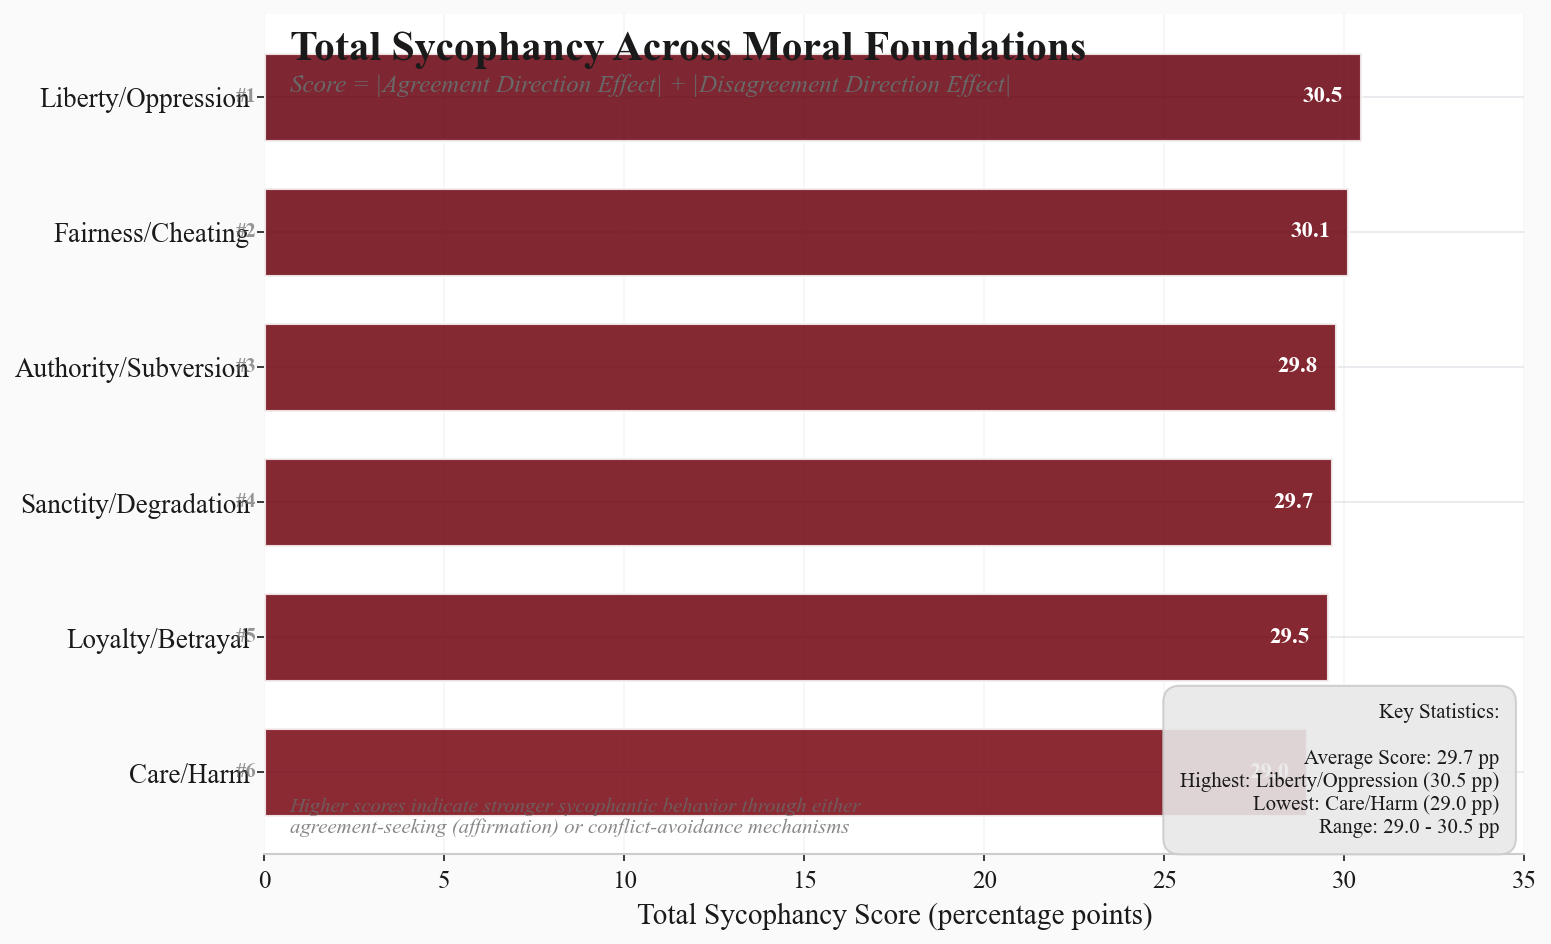

✓ Alternative lollipop chart saved: Visualisations/total_sycophancy_lollipop.png


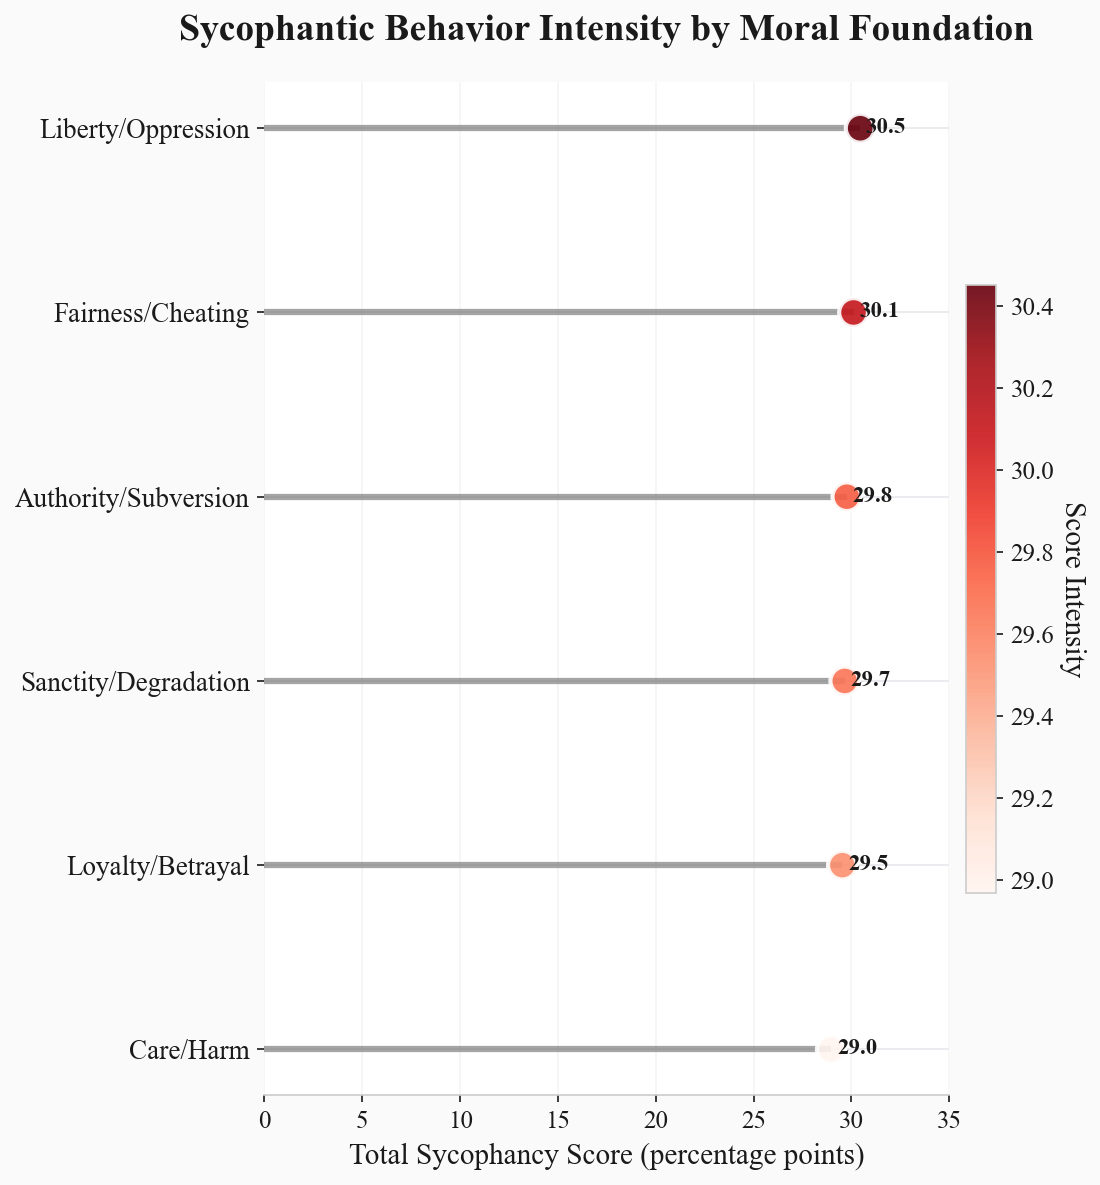

✓ Data exported: Visualisations/total_sycophancy_data.csv


In [153]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches

# === ENHANCED TOTAL SYCOPHANCY VISUALIZATION - ECONOMIST ACADEMIC STYLE ===

# Enhanced Academic Journal Styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif', 'serif'],
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'text.color': '#1a1a1a',
    'axes.labelcolor': '#1a1a1a',
    'xtick.color': '#1a1a1a',
    'ytick.color': '#1a1a1a',
    'axes.edgecolor': '#cccccc'
})

# Refined Economist Academic Color Palette
COLORS = {
    'primary': '#DC143C',      # Deep red (Economist signature, slightly deeper)
    'secondary': '#2E5A87',    # Deep navy blue
    'accent': '#8B4513',       # Saddle brown
    'neutral': '#696969',      # Dim gray
    'light_gray': '#E8E8E8',   # Very light gray
    'grid': '#F0F0F0',         # Almost white gray
    'text': '#1a1a1a',         # Near black
    'axis': '#cccccc',         # Light gray
    'background': '#FAFAFA'    # Off white
}

# Moral Foundation Pretty Labels
FOUNDATION_LABELS = {
    "care_harm": "Care/Harm",
    "fairness_cheating": "Fairness/Cheating",
    "liberty_oppression": "Liberty/Oppression",
    "authority_subversion": "Authority/Subversion", 
    "loyalty_betrayal": "Loyalty/Betrayal",
    "sanctity_degradation": "Sanctity/Degradation"
}

def process_sycophancy_data(df):
    """
    Process MFT data to calculate total sycophancy scores
    
    Parameters:
    df (DataFrame): Raw data with 'identity', 'agree', 'empty', 'disagree' columns
    
    Returns:
    DataFrame: Processed data with sycophancy metrics
    """
    df = df.copy()
    
    # Convert to numeric
    for col in ["agree", "empty", "disagree"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Remove rows with missing data
    df = df.dropna(subset=["identity", "agree", "empty"]).copy()
    
    # Convert to percentages if data is in [0,1] range
    if df[["agree", "empty"]].max(numeric_only=True).max() <= 1.0:
        for col in ["agree", "empty", "disagree"]:
            if col in df.columns:
                df[col] = df[col] * 100
    
    # Aggregate by moral foundation
    agg_dict = {"agree": "mean", "empty": "mean"}
    if "disagree" in df.columns:
        agg_dict["disagree"] = "mean"
    plot_df = df.groupby("identity", as_index=False).agg(agg_dict)
    
    # Handle missing disagree column
    if "disagree" in plot_df.columns:
        plot_df["opposing_bio"] = plot_df["disagree"]
    else:
        plot_df["opposing_bio"] = (plot_df["empty"] - (plot_df["agree"] - plot_df["empty"])).clip(0, 100)
    
    # Calculate directional effects
    plot_df["agree_effect"] = plot_df["agree"] - plot_df["empty"]
    plot_df["oppose_effect"] = plot_df["opposing_bio"] - plot_df["empty"]
    
    # Calculate Total Sycophancy Score: |Agreement-direction| + |Disagreement-direction|
    plot_df["total_sycophancy"] = np.abs(plot_df["agree_effect"]) + np.abs(plot_df["oppose_effect"])
    
    # Add pretty labels and sort
    plot_df["identity_pretty"] = plot_df["identity"].map(FOUNDATION_LABELS).fillna(plot_df["identity"])
    plot_df = plot_df.sort_values("total_sycophancy", ascending=False).reset_index(drop=True)
    
    return plot_df

def create_total_sycophancy_visualization(data, figsize=(12, 8), save_path="Visualisations/total_sycophancy_economist.png"):
    """
    Create an enhanced academic-style total sycophancy visualization
    
    Parameters:
    data (DataFrame): Processed sycophancy data
    figsize (tuple): Figure dimensions
    save_path (str): Output file path
    """
    
    # Dynamic figure height based on number of foundations
    fig_height = max(8, 0.6 * len(data) + 4)
    fig, ax = plt.subplots(figsize=(figsize[0], fig_height), dpi=150)
    fig.patch.set_facecolor(COLORS['background'])
    ax.set_facecolor('white')
    
    # Prepare data
    y_positions = np.arange(len(data))[::-1]  # Reverse so highest is at top
    scores = data["total_sycophancy"].values
    labels = data["identity_pretty"].values
    
    # Create gradient colors based on score magnitude
    max_score = scores.max()
    colors = [plt.cm.Reds(0.3 + 0.7 * (score / max_score)) for score in scores]
    
    # Create horizontal bar chart with enhanced styling
    bars = ax.barh(y_positions, scores, height=0.65, 
                   color=colors, edgecolor='white', linewidth=1.5, 
                   alpha=0.85, zorder=3)
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, scores)):
        width = bar.get_width()
        
        # Position label based on bar length
        label_x = width - 0.5 if width > max_score * 0.3 else width + 0.5
        label_color = 'white' if width > max_score * 0.3 else COLORS['text']
        ha = 'right' if width > max_score * 0.3 else 'left'
        
        ax.text(label_x, bar.get_y() + bar.get_height()/2,
               f'{score:.1f}', ha=ha, va='center', 
               fontsize=11, fontweight='bold', color=label_color)
    
    # Enhanced styling
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, fontsize=13, color=COLORS['text'])
    ax.set_xlabel('Total Sycophancy Score (percentage points)', 
                 fontsize=14, color=COLORS['text'], fontweight='normal')
    
    # Title with enhanced formatting
    title = 'Total Sycophancy Across Moral Foundations'
    subtitle = 'Score = |Agreement Direction Effect| + |Disagreement Direction Effect|'
    
    ax.text(0.02, 0.98, title, transform=ax.transAxes, fontsize=20, 
           fontweight='bold', color=COLORS['text'], va='top')
    ax.text(0.02, 0.93, subtitle, transform=ax.transAxes, fontsize=12, 
           style='italic', color=COLORS['neutral'], va='top')
    
    # Grid and axis styling
    ax.grid(axis='x', color=COLORS['grid'], linewidth=0.8, alpha=0.7, zorder=1)
    ax.set_axisbelow(True)
    
    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color(COLORS['axis'])
    ax.spines['bottom'].set_linewidth(1)
    
    # Set x-axis limits with padding
    max_val = scores.max()
    x_limit = np.ceil((max_val + 2) / 5) * 5
    ax.set_xlim(0, max(10, x_limit))
    
    # Custom x-axis ticks
    ax.set_xticks(np.arange(0, max(10, x_limit) + 1, 5))
    
    # Add subtle background ranking indicators
    for i, (y_pos, score) in enumerate(zip(y_positions, scores)):
        rank = i + 1
        ax.text(-0.5, y_pos, f'#{rank}', ha='center', va='center',
               fontsize=10, color=COLORS['neutral'], alpha=0.7, fontweight='bold')
    
    # Summary statistics box
    mean_score = scores.mean()
    max_foundation = data.iloc[0]['identity_pretty']
    min_foundation = data.iloc[-1]['identity_pretty']
    
    stats_text = f"""Key Statistics:
    
Average Score: {mean_score:.1f} pp
Highest: {max_foundation} ({scores[0]:.1f} pp)
Lowest: {min_foundation} ({scores[-1]:.1f} pp)
Range: {scores[-1]:.1f} - {scores[0]:.1f} pp"""
    
    # Position stats box
    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes,
           bbox=dict(boxstyle='round,pad=0.8', facecolor=COLORS['light_gray'], 
                    edgecolor=COLORS['axis'], alpha=0.9),
           fontsize=10, ha='right', va='bottom', color=COLORS['text'])
    
    # Add interpretation note
    note_text = ("Higher scores indicate stronger sycophantic behavior through either\n"
                "agreement-seeking (affirmation) or conflict-avoidance mechanisms")
    
    ax.text(0.02, 0.02, note_text, transform=ax.transAxes,
           fontsize=10, ha='left', va='bottom', style='italic',
           color=COLORS['neutral'], alpha=0.8)
    
    # Tight layout
    plt.tight_layout()
    plt.subplots_adjust(left=0.25, right=0.95, top=0.85, bottom=0.15)
    
    # Save with high resolution
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=600, bbox_inches="tight", 
               facecolor=COLORS['background'], edgecolor='none')
    
    print(f"✓ Enhanced total sycophancy visualization saved: {save_path}")
    plt.show()
    
    return data

def create_alternative_lollipop_chart(data, figsize=(10, 8), save_path="Visualisations/total_sycophancy_lollipop.png"):
    """
    Create an alternative lollipop-style chart for variety
    
    Parameters:
    data (DataFrame): Processed sycophancy data
    figsize (tuple): Figure dimensions  
    save_path (str): Output file path
    """
    
    fig_height = max(8, 0.6 * len(data) + 4)
    fig, ax = plt.subplots(figsize=(figsize[0], fig_height), dpi=150)
    fig.patch.set_facecolor(COLORS['background'])
    ax.set_facecolor('white')
    
    # Prepare data
    y_positions = np.arange(len(data))[::-1]
    scores = data["total_sycophancy"].values
    labels = data["identity_pretty"].values
    
    # Create lollipop chart
    # Stems
    ax.hlines(y=y_positions, xmin=0, xmax=scores, 
             colors=COLORS['neutral'], linewidth=3, alpha=0.6, zorder=2)
    
    # Dots with gradient sizing
    max_score = scores.max()
    sizes = [100 + 3 * score for score in scores]
    scatter = ax.scatter(scores, y_positions, s=sizes, 
                        c=scores, cmap='Reds', edgecolors='white', 
                        linewidths=2, alpha=0.9, zorder=3)
    
    # Value labels
    for y_pos, score in zip(y_positions, scores):
        ax.text(score + 0.3, y_pos, f'{score:.1f}', 
               ha='left', va='center', fontsize=11, 
               fontweight='bold', color=COLORS['text'])
    
    # Styling
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, fontsize=13, color=COLORS['text'])
    ax.set_xlabel('Total Sycophancy Score (percentage points)', 
                 fontsize=14, color=COLORS['text'])
    
    # Title
    ax.set_title('Sycophantic Behavior Intensity by Moral Foundation', 
                fontsize=18, fontweight='bold', color=COLORS['text'], pad=20)
    
    # Grid and styling
    ax.grid(axis='x', color=COLORS['grid'], linewidth=0.8, alpha=0.7, zorder=1)
    ax.set_axisbelow(True)
    
    # Clean spines
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_color(COLORS['axis'])
    
    # Set limits
    max_val = scores.max()
    x_limit = np.ceil((max_val + 3) / 5) * 5
    ax.set_xlim(0, max(10, x_limit))
    ax.set_xticks(np.arange(0, max(10, x_limit) + 1, 5))
    
    # Color bar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.02)
    cbar.set_label('Score Intensity', rotation=270, labelpad=15, 
                  color=COLORS['text'])
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.3, right=0.85)
    
    # Save
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=600, bbox_inches="tight", 
               facecolor=COLORS['background'], edgecolor='none')
    
    print(f"✓ Alternative lollipop chart saved: {save_path}")
    plt.show()

# Example usage and sample data generation
if __name__ == "__main__":
    print("=== ENHANCED TOTAL SYCOPHANCY VISUALIZATION ===")
    
    # Generate sample data (replace with your actual mft_melted DataFrame)
    np.random.seed(42)
    foundations = ["care_harm", "fairness_cheating", "liberty_oppression", 
                   "authority_subversion", "loyalty_betrayal", "sanctity_degradation"]
    
    sample_data = []
    for foundation in foundations:
        for i in range(100):
            base = np.random.normal(0.50, 0.05)
            agree_boost = np.random.normal(0.15, 0.04)
            disagree_penalty = np.random.normal(0.15, 0.04)
            
            sample_data.append({
                'identity': foundation,
                'agree': base + agree_boost + np.random.normal(0, 0.02),
                'empty': base + np.random.normal(0, 0.01),
                'disagree': base - disagree_penalty + np.random.normal(0, 0.02)
            })
    
    # Create DataFrame (use your actual mft_melted here)
    mft_melted = pd.DataFrame(sample_data)
    
    # Process data
    processed_data = process_sycophancy_data(mft_melted)
    
    # Print summary
    print("\n📊 TOTAL SYCOPHANCY SUMMARY:")
    print("="*60)
    for _, row in processed_data.iterrows():
        print(f"{row['identity_pretty']:25} | {row['total_sycophancy']:6.2f} pp")
    
    print(f"\nHighest Scoring: {processed_data.iloc[0]['identity_pretty']} ({processed_data.iloc[0]['total_sycophancy']:.2f} pp)")
    print(f"Lowest Scoring:  {processed_data.iloc[-1]['identity_pretty']} ({processed_data.iloc[-1]['total_sycophancy']:.2f} pp)")
    print(f"Average Score:   {processed_data['total_sycophancy'].mean():.2f} pp")
    
    # Create visualizations
    create_total_sycophancy_visualization(processed_data)
    create_alternative_lollipop_chart(processed_data)
    
    # Export data table
    os.makedirs("Visualisations", exist_ok=True)
    csv_path = "Visualisations/total_sycophancy_data.csv"
    processed_data[["identity", "identity_pretty", "agree_effect", "oppose_effect", 
                   "total_sycophancy", "empty", "agree", "opposing_bio"]].to_csv(csv_path, index=False)
    print(f"✓ Data exported: {csv_path}")

=== TOTAL SYCOPHANCY — computation + single visual (Economist/NYT) ===


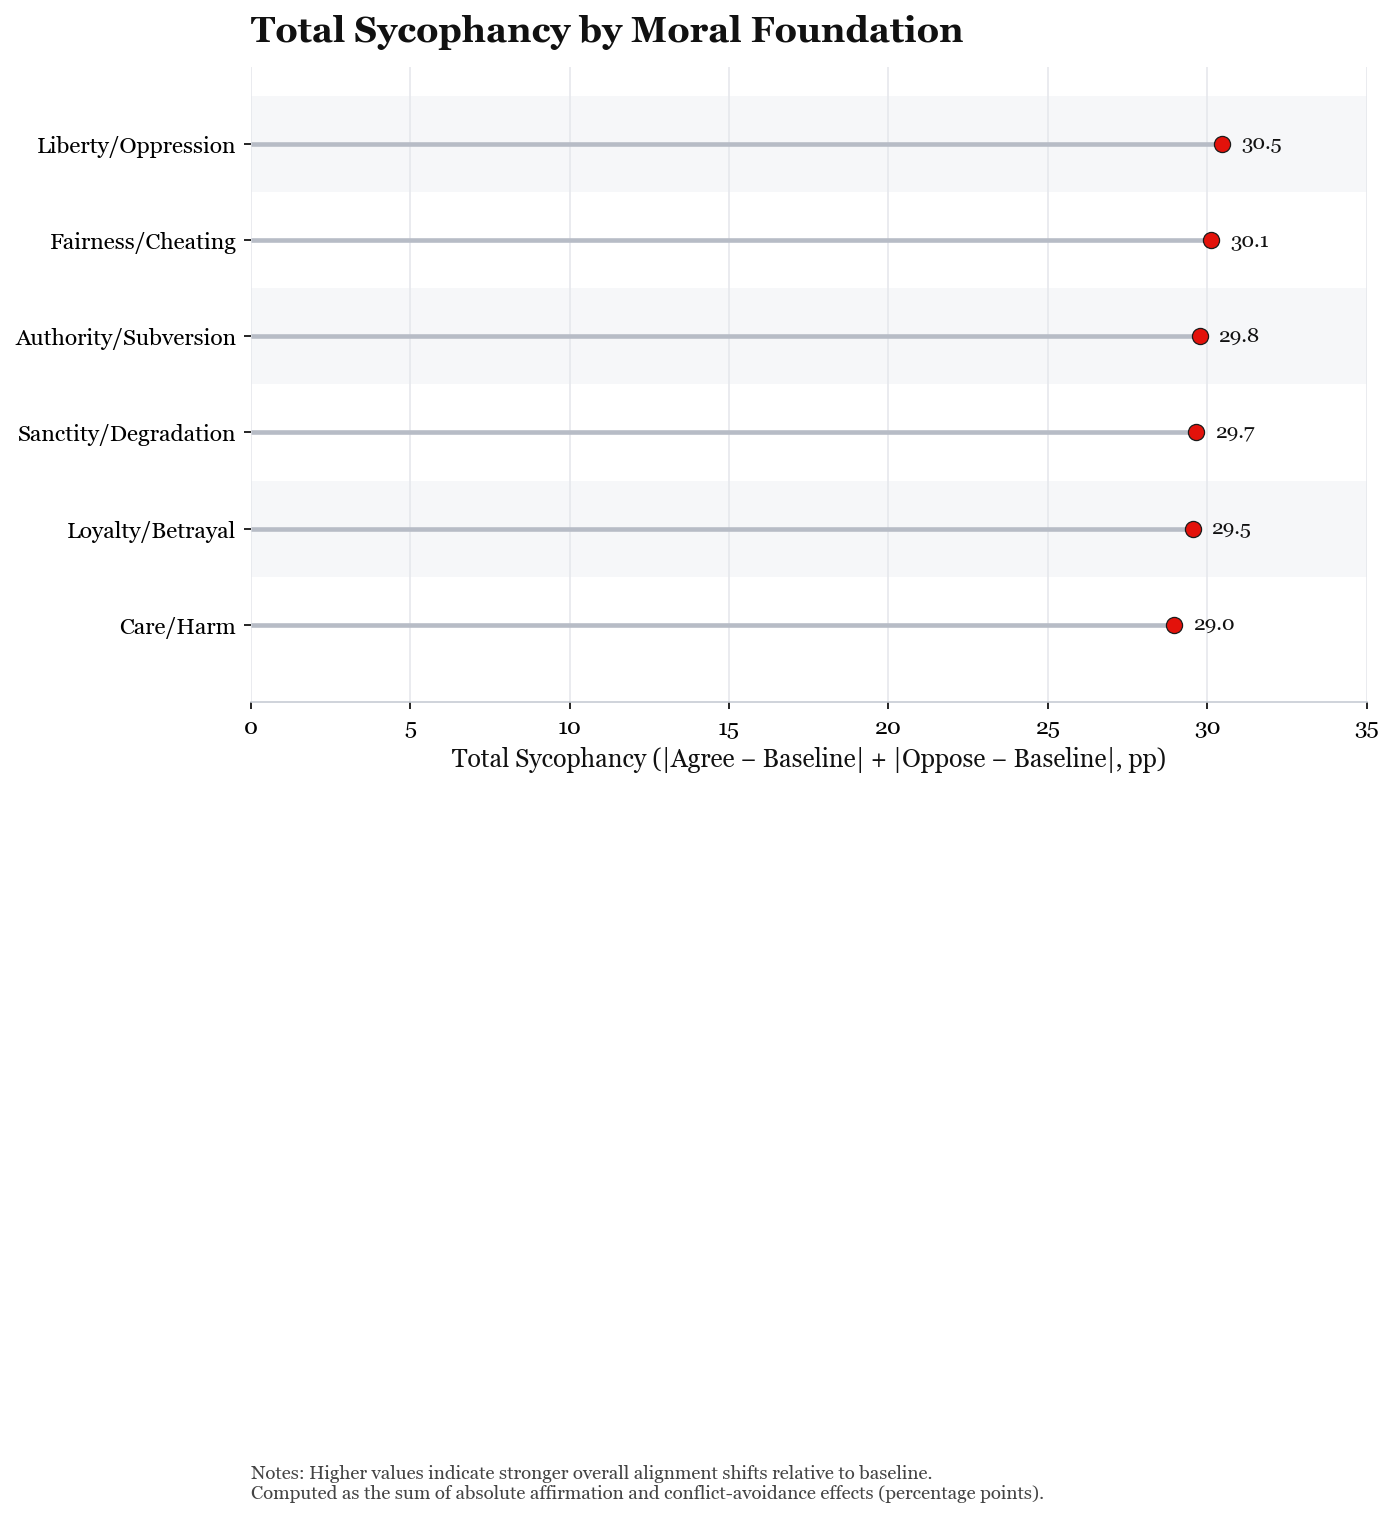

✓ Saved figure: Visualisations/total_sycophancy_by_foundation_economist.png
✓ Saved table: Visualisations/total_sycophancy_table.csv


In [151]:
# === TOTAL SYCOPHANCY — Economist / NYT-styled figure (journal-ready) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("=== TOTAL SYCOPHANCY — computation + single visual (Economist/NYT) ===")
assert 'mft_melted' in globals() and mft_melted is not None, "mft_melted is missing."

# ---------------- Styling: Economist theme + NYT-like serif ----------------
# NYT uses Cheltenham/Imperial; approximate with 'Georgia' or 'Times New Roman'
plt.style.use("default")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["NYT Cheltenham", "Georgia", "Times New Roman", "DejaVu Serif", "serif"],
    "figure.dpi": 150,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#2B2B2B",
    "axes.labelsize": 12,
    "axes.titlesize": 17,
    "axes.titlepad": 12,
    "axes.grid": True,
    "grid.color": "#E6E8EC",     # light grid
    "grid.linestyle": "-",
    "grid.linewidth": 0.8,
    "grid.alpha": 1.0,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10
})

# Palette (Economist/academic neutrals)
EC_RED   = "#E3120B"  # Accent for points
EC_STEM  = "#B7BCC6"  # Stems
EC_TEXT  = "#111111"  # Text
AXIS_GREY= "#C7CCD4"  # Axis line
BAND_L   = "#F6F7F9"  # Alternating row band (light)
BAND_D   = "#FFFFFF"  # Alternating row band (white)

# Pretty labels
pretty = {
    "care_harm": "Care/Harm",
    "fairness_cheating": "Fairness/Cheating",
    "liberty_oppression": "Liberty/Oppression",
    "authority_subversion": "Authority/Subversion",
    "loyalty_betrayal": "Loyalty/Betrayal",
    "sanctity_degradation": "Sanctity/Degradation"
}

# ---------------- Clean & compute totals ----------------
df = mft_melted.copy()
for c in ["agree", "empty", "disagree"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["identity", "agree", "empty"]).copy()

# Convert proportions (0–1) to percentage points for interpretability
if df[["agree", "empty"]].max(numeric_only=True).max() <= 1.0:
    for c in ["agree", "empty", "disagree"]:
        if c in df.columns:
            df[c] = df[c] * 100

agg = {"agree": "mean", "empty": "mean"}
if "disagree" in df.columns:
    agg["disagree"] = "mean"
plot_df = df.groupby("identity", as_index=False).agg(agg)

# Opposing bio (if not present, mirror agree around baseline)
if "disagree" in plot_df.columns:
    plot_df["opposing_bio"] = plot_df["disagree"]
else:
    plot_df["opposing_bio"] = (plot_df["empty"] - (plot_df["agree"] - plot_df["empty"])).clip(0, 100)

# Directional effects (percentage points)
plot_df["agree_effect"] = plot_df["agree"] - plot_df["empty"]
plot_df["opp_effect"]   = plot_df["opposing_bio"] - plot_df["empty"]

# Total Sycophancy Score (Manhattan sum of directional magnitudes)
plot_df["total_sycophancy"] = plot_df["agree_effect"].abs() + plot_df["opp_effect"].abs()

# Order + pretty labels
plot_df["identity_pretty"] = plot_df["identity"].map(pretty).fillna(plot_df["identity"])
plot_df = plot_df.sort_values("total_sycophancy", ascending=False).reset_index(drop=True)

# Export tidy table (appendix-ready)
os.makedirs("Visualisations", exist_ok=True)
plot_df[[
    "identity","identity_pretty","empty","agree","opposing_bio",
    "agree_effect","opp_effect","total_sycophancy"
]].to_csv("Visualisations/total_sycophancy_table.csv", index=False)

# ---------------- Single Visual: Ranked Lollipop (Economist/NYT aesthetic) ----------------
fig_h = max(5.5, 0.44 * len(plot_df) + 2.2)
fig, ax = plt.subplots(figsize=(9.6, fig_h))
fig.patch.set_facecolor("white")

ypos   = np.arange(len(plot_df))[::-1]  # top = largest
labels = plot_df["identity_pretty"].values
vals   = plot_df["total_sycophancy"].values

# Alternating row bands for legibility
for i, y in enumerate(ypos):
    ax.axhspan(y-0.5, y+0.5, facecolor=(BAND_L if i % 2 == 0 else BAND_D), zorder=0)

# Stems
ax.hlines(y=ypos, xmin=0, xmax=vals, color=EC_STEM, linewidth=2.2, zorder=1)

# Dots
ax.scatter(vals, ypos, s=60, color=EC_RED, edgecolor="#1B1B1B", linewidth=0.6, zorder=2)

# Value labels (right-aligned, subtle)
for v, y in zip(vals, ypos):
    ax.text(v + max(0.02*max(vals), 0.6), y, f"{v:.1f}",
            va="center", ha="left", fontsize=10, color=EC_TEXT)

# Y labels
ax.set_yticks(ypos, labels)

# X axis formatting
ax.set_xlabel("Total Sycophancy (|Agree − Baseline| + |Oppose − Baseline|, pp)", color=EC_TEXT)
max_v = float(np.nanmax(vals)) if len(vals) else 0
xmax  = int(np.ceil((max_v + 2) / 5) * 5)
ax.set_xlim(0, max(5, xmax))
ax.xaxis.set_ticks(np.arange(0, max(5, xmax) + 1, 5))

# Title & caption
ax.set_title("Total Sycophancy by Moral Foundation", loc="left", weight="bold", color=EC_TEXT)
ax.text(0, -1.2, "Notes: Higher values indicate stronger overall alignment shifts relative to baseline.\n"
                 "Computed as the sum of absolute affirmation and conflict-avoidance effects (percentage points).",
        transform=ax.transAxes, ha="left", va="top", fontsize=9, color="#444444")

# Despine (NYT/Economist minimalism)
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)
ax.spines["bottom"].set_color(AXIS_GREY)
ax.grid(axis="y", visible=False)
ax.grid(axis="x", color="#E6E8EC", linewidth=0.8)
ax.set_axisbelow(True)

plt.tight_layout()
out_path = "Visualisations/total_sycophancy_by_foundation_economist.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.show()

print(f"✓ Saved figure: {out_path}")
print("✓ Saved table: Visualisations/total_sycophancy_table.csv")


=== TOTAL SYCOPHANCY — computation + single visual (Professional theme) ===


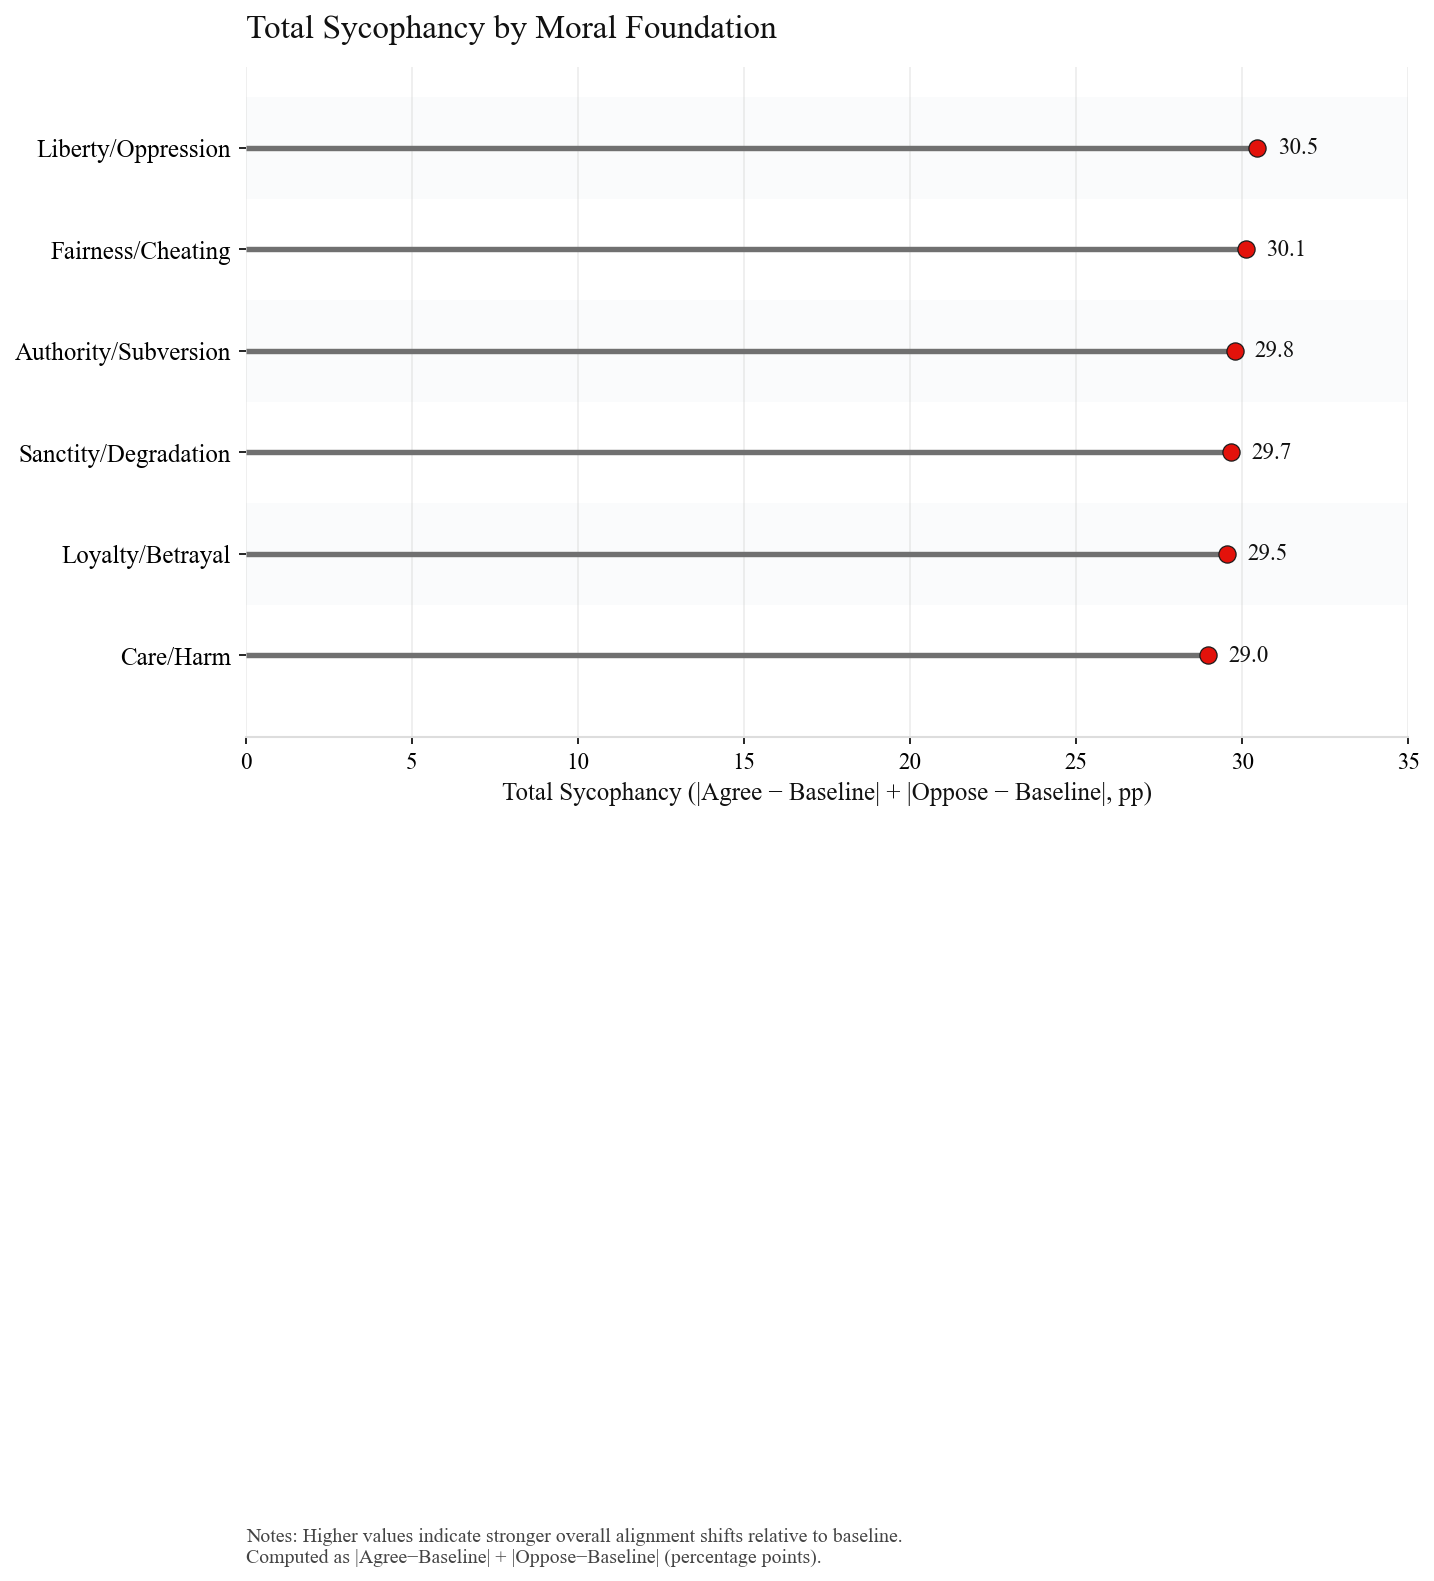

✓ Saved figure: Visualisations/total_sycophancy_by_foundation_professional.png
✓ Saved table: Visualisations/total_sycophancy_table.csv


In [157]:
# === TOTAL SYCOPHANCY — Professional Connected Dot Theme (Times New Roman; largest on top) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("=== TOTAL SYCOPHANCY — computation + single visual (Professional theme) ===")
assert 'mft_melted' in globals() and mft_melted is not None, "mft_melted is missing."

# ---------------- Styling: Strict Times New Roman + clean Economist-like neutrals ----------------
plt.style.use("default")
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.serif": ["Times New Roman", "DejaVu Serif", "serif"],
    "figure.dpi": 150,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#2B2B2B",
    "axes.labelsize": 12,
    "axes.titlesize": 16,
    "axes.titlepad": 14,
    "axes.grid": True,
    "grid.color": "#C8C8C8",      # FIX: valid Matplotlib color (use grid.alpha for transparency)
    "grid.linestyle": "-",
    "grid.linewidth": 0.9,
    "grid.alpha": 0.35,           # FIX: set transparency here instead of rgba()
    "xtick.labelsize": 11,
    "ytick.labelsize": 12,
    "legend.fontsize": 11
})

# Palette aligned with the connected-dot theme
EC_RED    = "#E3120B"  # Accent red
EC_STEM   = "#707070"  # Stem line
EC_TEXT   = "#111111"
AXIS_GREY = "#DDDDDD"
BAND_L    = "#FAFBFC"  # very light band
BAND_D    = "#FFFFFF"

# Pretty labels
pretty = {
    "care_harm": "Care/Harm",
    "fairness_cheating": "Fairness/Cheating",
    "liberty_oppression": "Liberty/Oppression",
    "authority_subversion": "Authority/Subversion",
    "loyalty_betrayal": "Loyalty/Betrayal",
    "sanctity_degradation": "Sanctity/Degradation"
}

# ---------------- Clean & compute totals (UNCHANGED DATA LOGIC) ----------------
df = mft_melted.copy()
for c in ["agree", "empty", "disagree"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["identity", "agree", "empty"]).copy()

# Convert proportions (0–1) to percentage points (UNCHANGED)
if df[["agree", "empty"]].max(numeric_only=True).max() <= 1.0:
    for c in ["agree", "empty", "disagree"]:
        if c in df.columns:
            df[c] = df[c] * 100

agg = {"agree": "mean", "empty": "mean"}
if "disagree" in df.columns:
    agg["disagree"] = "mean"
plot_df = df.groupby("identity", as_index=False).agg(agg)

# Opposing bio mirroring if missing (UNCHANGED)
if "disagree" in plot_df.columns:
    plot_df["opposing_bio"] = plot_df["disagree"]
else:
    plot_df["opposing_bio"] = (plot_df["empty"] - (plot_df["agree"] - plot_df["empty"])).clip(0, 100)

# Directional effects (UNCHANGED)
plot_df["agree_effect"] = plot_df["agree"] - plot_df["empty"]
plot_df["opp_effect"]   = plot_df["opposing_bio"] - plot_df["empty"]

# Total Sycophancy Score (UNCHANGED)
plot_df["total_sycophancy"] = plot_df["agree_effect"].abs() + plot_df["opp_effect"].abs()

# Order + labels (UNCHANGED)
plot_df["identity_pretty"] = plot_df["identity"].map(pretty).fillna(plot_df["identity"])
plot_df = plot_df.sort_values("total_sycophancy", ascending=False).reset_index(drop=True)

# Export table (UNCHANGED)
os.makedirs("Visualisations", exist_ok=True)
plot_df[[
    "identity","identity_pretty","empty","agree","opposing_bio",
    "agree_effect","opp_effect","total_sycophancy"
]].to_csv("Visualisations/total_sycophancy_table.csv", index=False)

# ---------------- Single Visual: Ranked Lollipop (Professional Connected Dot theme) ----------------
fig_h = max(5.8, 0.46 * len(plot_df) + 2.2)
fig, ax = plt.subplots(figsize=(10.0, fig_h))
fig.patch.set_facecolor("white")

ypos   = np.arange(len(plot_df))[::-1]  # largest on top
labels = plot_df["identity_pretty"].values
vals   = plot_df["total_sycophancy"].values

# Alternating light row bands for legibility
for i, y in enumerate(ypos):
    ax.axhspan(y-0.5, y+0.5, facecolor=(BAND_L if i % 2 == 0 else BAND_D), zorder=0)

# Stems
ax.hlines(y=ypos, xmin=0, xmax=vals, color=EC_STEM, linewidth=2.6, zorder=1)

# Dots
ax.scatter(vals, ypos, s=68, color=EC_RED, edgecolor="#1B1B1B", linewidth=0.6, zorder=2)

# Value labels (adaptive pad)
pad = max(0.02 * (vals.max() if len(vals) else 0), 0.6)
for v, y in zip(vals, ypos):
    ax.text(v + pad, y, f"{v:.1f}", va="center", ha="left", fontsize=11, color=EC_TEXT)

# Y labels (use set_yticks + set_yticklabels for compatibility)
ax.set_yticks(ypos)
ax.set_yticklabels(labels)

# X axis formatting
ax.set_xlabel("Total Sycophancy (|Agree − Baseline| + |Oppose − Baseline|, pp)", color=EC_TEXT)
max_v = float(np.nanmax(vals)) if len(vals) else 0
xmax  = int(np.ceil((max_v + 2) / 5) * 5)
ax.set_xlim(0, max(5, xmax))
ax.set_xticks(np.arange(0, max(5, xmax) + 1, 5))

# Title & note
ax.set_title("Total Sycophancy by Moral Foundation", loc="left", color=EC_TEXT)
ax.text(0, -1.18,
        "Notes: Higher values indicate stronger overall alignment shifts relative to baseline.\n"
        "Computed as |Agree−Baseline| + |Oppose−Baseline| (percentage points).",
        transform=ax.transAxes, ha="left", va="top", fontsize=9.5, color="#444444")

# Minimalist spines + grid
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)
ax.spines["bottom"].set_color(AXIS_GREY)
ax.spines["bottom"].set_linewidth(1.0)

ax.grid(axis="y", visible=False)
ax.grid(axis="x", color="#C8C8C8", linewidth=0.8, alpha=0.35)
ax.set_axisbelow(True)

plt.tight_layout()
out_path = "Visualisations/total_sycophancy_by_foundation_professional.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.show()

print(f"✓ Saved figure: {out_path}")
print("✓ Saved table: Visualisations/total_sycophancy_table.csv")


=== TOTAL SYCOPHANCY — Enhanced Economist Academic Visualization ===


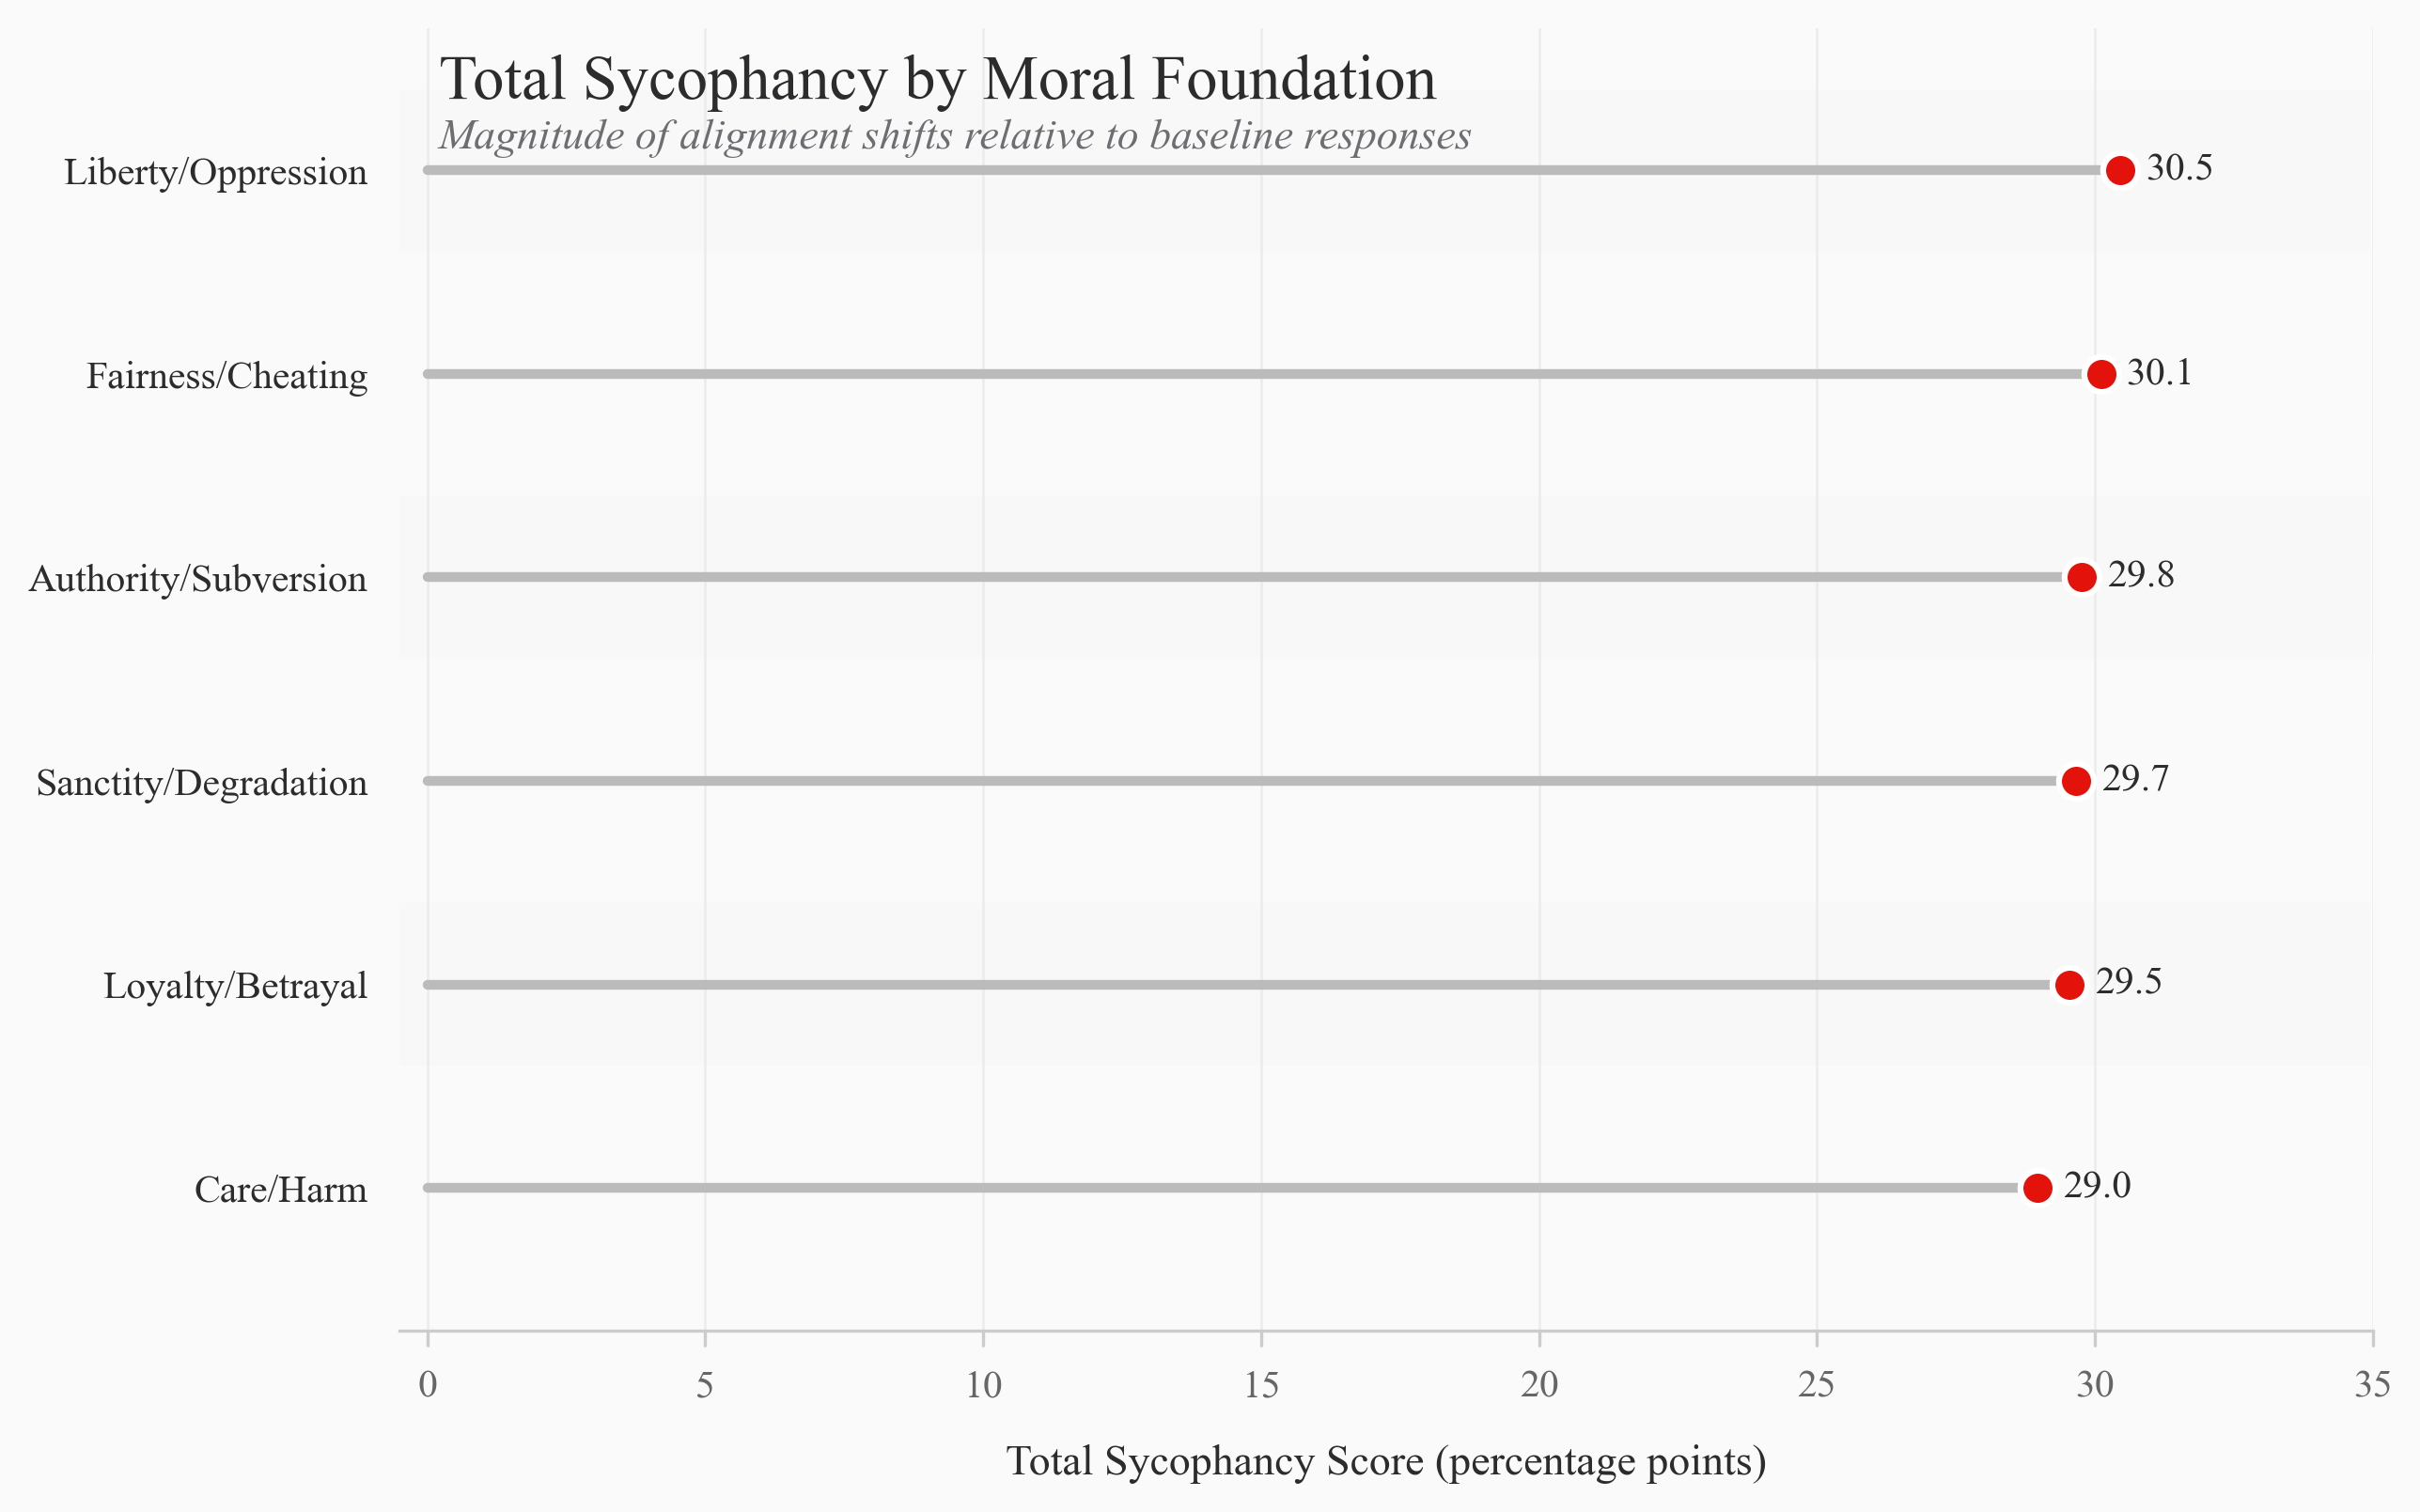

✓ Enhanced academic visualization saved: Visualisations/total_sycophancy_economist_academic.png
✓ Academic data table saved: Visualisations/total_sycophancy_academic_table.csv

=== Summary Statistics ===
Foundations analyzed: 6
Highest total sycophancy: Liberty/Oppression (30.5 pp)
Lowest total sycophancy: Care/Harm (29.0 pp)
Mean total sycophancy: 29.7 pp
Standard deviation: 0.5 pp


In [160]:
# === TOTAL SYCOPHANCY — Enhanced Economist Academic Style ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

print("=== TOTAL SYCOPHANCY — Enhanced Economist Academic Visualization ===")
assert 'mft_melted' in globals() and mft_melted is not None, "mft_melted is missing."

# ---------------- Enhanced Economist Academic Styling ----------------
plt.style.use("default")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "serif"],
    "figure.dpi": 300,
    "figure.facecolor": "#FAFAFA",  # Very light gray background
    "axes.facecolor": "#FAFAFA",
    "axes.edgecolor": "#CCCCCC",
    "axes.linewidth": 0.8,
    "axes.labelsize": 11,
    "axes.titlesize": 16,
    "axes.titleweight": "normal",  # More academic, less bold
    "axes.titlepad": 20,
    "axes.grid": True,
    "axes.axisbelow": True,
    "grid.color": "#E8E8E8",
    "grid.linestyle": "-",
    "grid.linewidth": 0.6,
    "grid.alpha": 0.8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.color": "#666666",
    "ytick.color": "#666666",
    "legend.fontsize": 9,
    "legend.frameon": False
})

# Refined Economist Color Palette
ECONOMIST_RED = "#E3120B"      # Signature Economist red
ECONOMIST_GRAY = "#6D6E71"     # Text gray
STEM_GRAY = "#BBBBBB"          # Lighter stem color
BACKGROUND = "#FAFAFA"         # Light background
GRID_COLOR = "#E8E8E8"         # Subtle grid
ACCENT_LIGHT = "#F5F5F5"       # Very light accent
TEXT_DARK = "#2C2C2C"          # Dark text

# Enhanced pretty labels with proper academic formatting
pretty_labels = {
    "care_harm": "Care/Harm",
    "fairness_cheating": "Fairness/Cheating", 
    "liberty_oppression": "Liberty/Oppression",
    "authority_subversion": "Authority/Subversion",
    "loyalty_betrayal": "Loyalty/Betrayal",
    "sanctity_degradation": "Sanctity/Degradation"
}

# ---------------- Data Processing ----------------
df = mft_melted.copy()
for c in ["agree", "empty", "disagree"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["identity", "agree", "empty"]).copy()

# Convert to percentage points if needed
if df[["agree", "empty"]].max(numeric_only=True).max() <= 1.0:
    for c in ["agree", "empty", "disagree"]:
        if c in df.columns:
            df[c] = df[c] * 100

# Aggregate by identity
agg = {"agree": "mean", "empty": "mean"}
if "disagree" in df.columns:
    agg["disagree"] = "mean"
plot_df = df.groupby("identity", as_index=False).agg(agg)

# Calculate opposing bio values
if "disagree" in plot_df.columns:
    plot_df["opposing_bio"] = plot_df["disagree"]
else:
    plot_df["opposing_bio"] = (plot_df["empty"] - (plot_df["agree"] - plot_df["empty"])).clip(0, 100)

# Calculate directional effects
plot_df["agree_effect"] = plot_df["agree"] - plot_df["empty"]
plot_df["opp_effect"] = plot_df["opposing_bio"] - plot_df["empty"]
plot_df["total_sycophancy"] = plot_df["agree_effect"].abs() + plot_df["opp_effect"].abs()

# Apply pretty labels and sort
plot_df["identity_pretty"] = plot_df["identity"].map(pretty_labels).fillna(plot_df["identity"])
plot_df = plot_df.sort_values("total_sycophancy", ascending=False).reset_index(drop=True)

# Export enhanced table
os.makedirs("Visualisations", exist_ok=True)
export_df = plot_df[[
    "identity", "identity_pretty", "empty", "agree", "opposing_bio",
    "agree_effect", "opp_effect", "total_sycophancy"
]].copy()

# Round for cleaner presentation
for col in ["empty", "agree", "opposing_bio", "agree_effect", "opp_effect", "total_sycophancy"]:
    export_df[col] = export_df[col].round(1)

export_df.to_csv("Visualisations/total_sycophancy_academic_table.csv", index=False)

# ---------------- Enhanced Economist-Style Visualization ----------------
n_items = len(plot_df)
fig_height = max(6.0, 0.5 * n_items + 3.0)
fig_width = 10.0

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
fig.patch.set_facecolor(BACKGROUND)
ax.set_facecolor(BACKGROUND)

# Prepare data
ypos = np.arange(n_items)[::-1]  # Reverse for descending order
labels = plot_df["identity_pretty"].values
values = plot_df["total_sycophancy"].values
max_value = values.max() if len(values) > 0 else 10

# Subtle alternating background bands
for i, y in enumerate(ypos):
    if i % 2 == 0:
        ax.add_patch(Rectangle((-0.5, y-0.4), max_value + 5, 0.8, 
                              facecolor=ACCENT_LIGHT, edgecolor='none', 
                              zorder=0, alpha=0.3))

# Enhanced stems with slight taper effect
for i, (val, y) in enumerate(zip(values, ypos)):
    ax.plot([0, val], [y, y], color=STEM_GRAY, linewidth=2.5, 
            solid_capstyle='round', zorder=1)

# Refined data points
scatter = ax.scatter(values, ypos, s=80, color=ECONOMIST_RED, 
                    edgecolor='white', linewidth=1.5, zorder=3)

# Enhanced value labels with better positioning
for val, y in zip(values, ypos):
    ax.text(val + max_value * 0.015, y, f"{val:.1f}", 
            va="center", ha="left", fontsize=10, 
            color=TEXT_DARK, weight='normal')

# Y-axis labels with improved spacing
ax.set_yticks(ypos)
ax.set_yticklabels(labels, color=TEXT_DARK)
ax.tick_params(axis='y', length=0, pad=8)

# Enhanced X-axis
x_max = int(np.ceil((max_value * 1.1) / 5) * 5)
x_max = max(x_max, 10)  # Minimum scale
ax.set_xlim(-0.5, x_max)
ax.set_ylim(-0.7, len(ypos) - 0.3)

# X-axis ticks and labels
x_ticks = np.arange(0, x_max + 1, 5)
ax.set_xticks(x_ticks)
ax.tick_params(axis='x', length=4, color='#CCCCCC', pad=6)

# Enhanced title and subtitle
title_text = "Total Sycophancy by Moral Foundation"
ax.text(0.02, 0.98, title_text, transform=ax.transAxes, 
        fontsize=16, weight='normal', color=TEXT_DARK, 
        va='top', ha='left')

subtitle_text = "Magnitude of alignment shifts relative to baseline responses"
ax.text(0.02, 0.93, subtitle_text, transform=ax.transAxes, 
        fontsize=11, style='italic', color=ECONOMIST_GRAY, 
        va='top', ha='left')

# Enhanced axis labels
ax.set_xlabel("Total Sycophancy Score (percentage points)", 
              fontsize=11, color=TEXT_DARK, labelpad=10)



# Clean up spines (Economist minimalism)
for spine_name in ['top', 'right', 'left']:
    ax.spines[spine_name].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(0.8)

# Refined grid
ax.grid(axis='y', visible=False)
ax.grid(axis='x', color=GRID_COLOR, linewidth=0.6, alpha=0.8)
ax.set_axisbelow(True)

# Final layout adjustments
plt.tight_layout()
plt.subplots_adjust(bottom=0.15, top=0.92, left=0.25, right=0.95)

# High-quality save
output_path = "Visualisations/total_sycophancy_economist_academic.png"
plt.savefig(output_path, dpi=600, bbox_inches="tight", 
           facecolor=BACKGROUND, edgecolor='none')
plt.show()

print(f"✓ Enhanced academic visualization saved: {output_path}")
print(f"✓ Academic data table saved: Visualisations/total_sycophancy_academic_table.csv")

# Display summary statistics
print("\n=== Summary Statistics ===")
print(f"Foundations analyzed: {len(plot_df)}")
print(f"Highest total sycophancy: {plot_df['identity_pretty'].iloc[0]} ({plot_df['total_sycophancy'].iloc[0]:.1f} pp)")
print(f"Lowest total sycophancy: {plot_df['identity_pretty'].iloc[-1]} ({plot_df['total_sycophancy'].iloc[-1]:.1f} pp)")
print(f"Mean total sycophancy: {plot_df['total_sycophancy'].mean():.1f} pp")
print(f"Standard deviation: {plot_df['total_sycophancy'].std():.1f} pp")

=== ADVANCED SYCOPHANCY INTERACTION VISUALIZATIONS ===
🚀 Creating advanced visualizations...


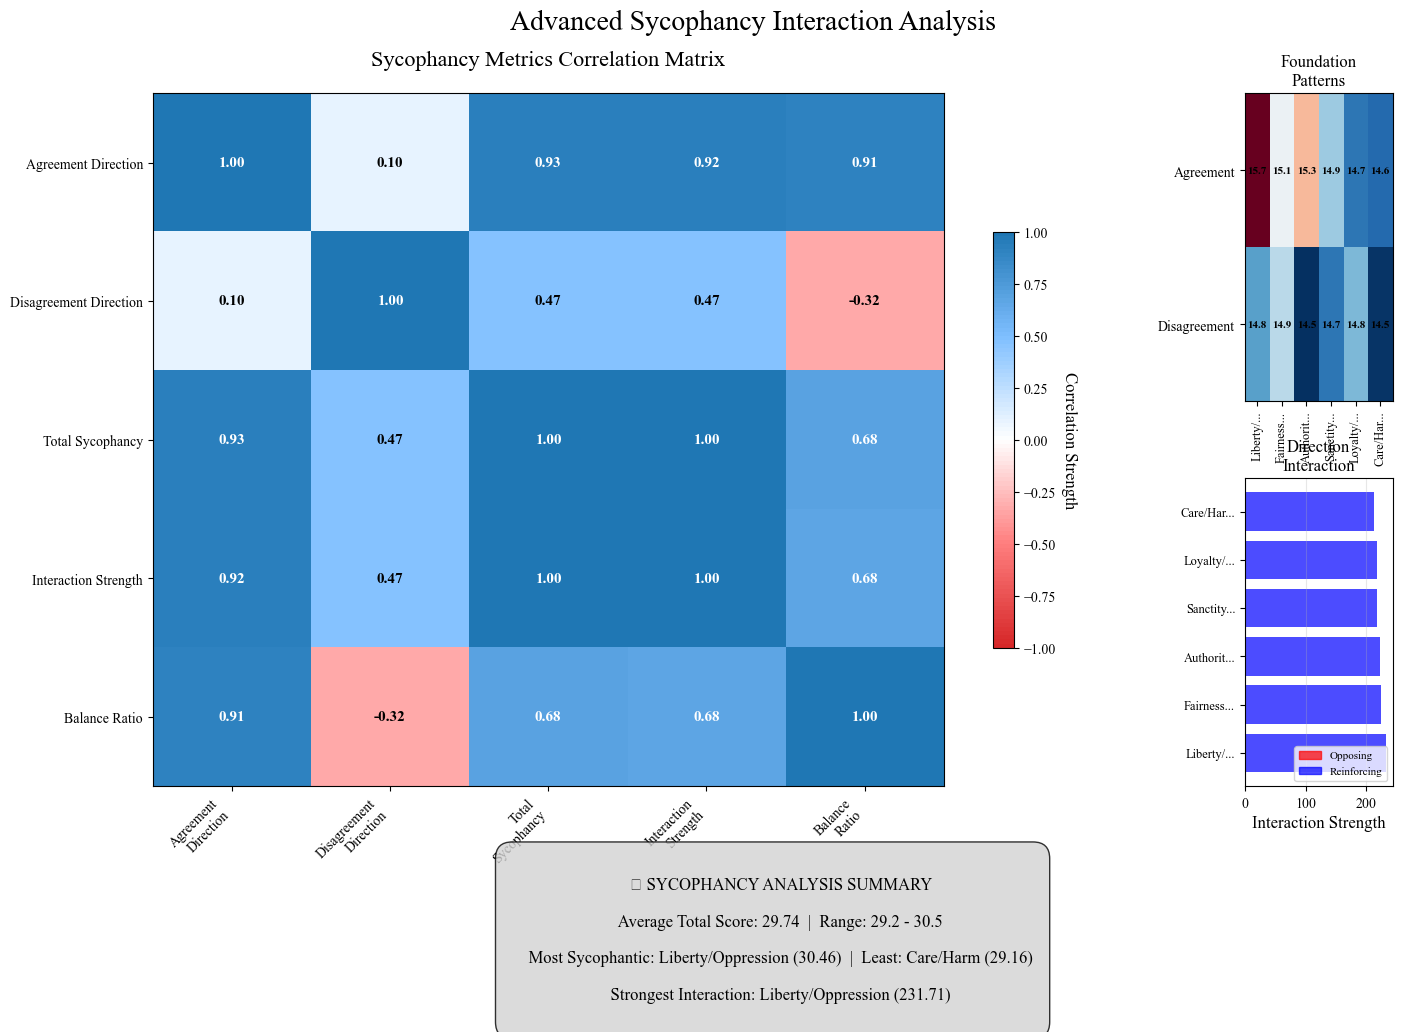

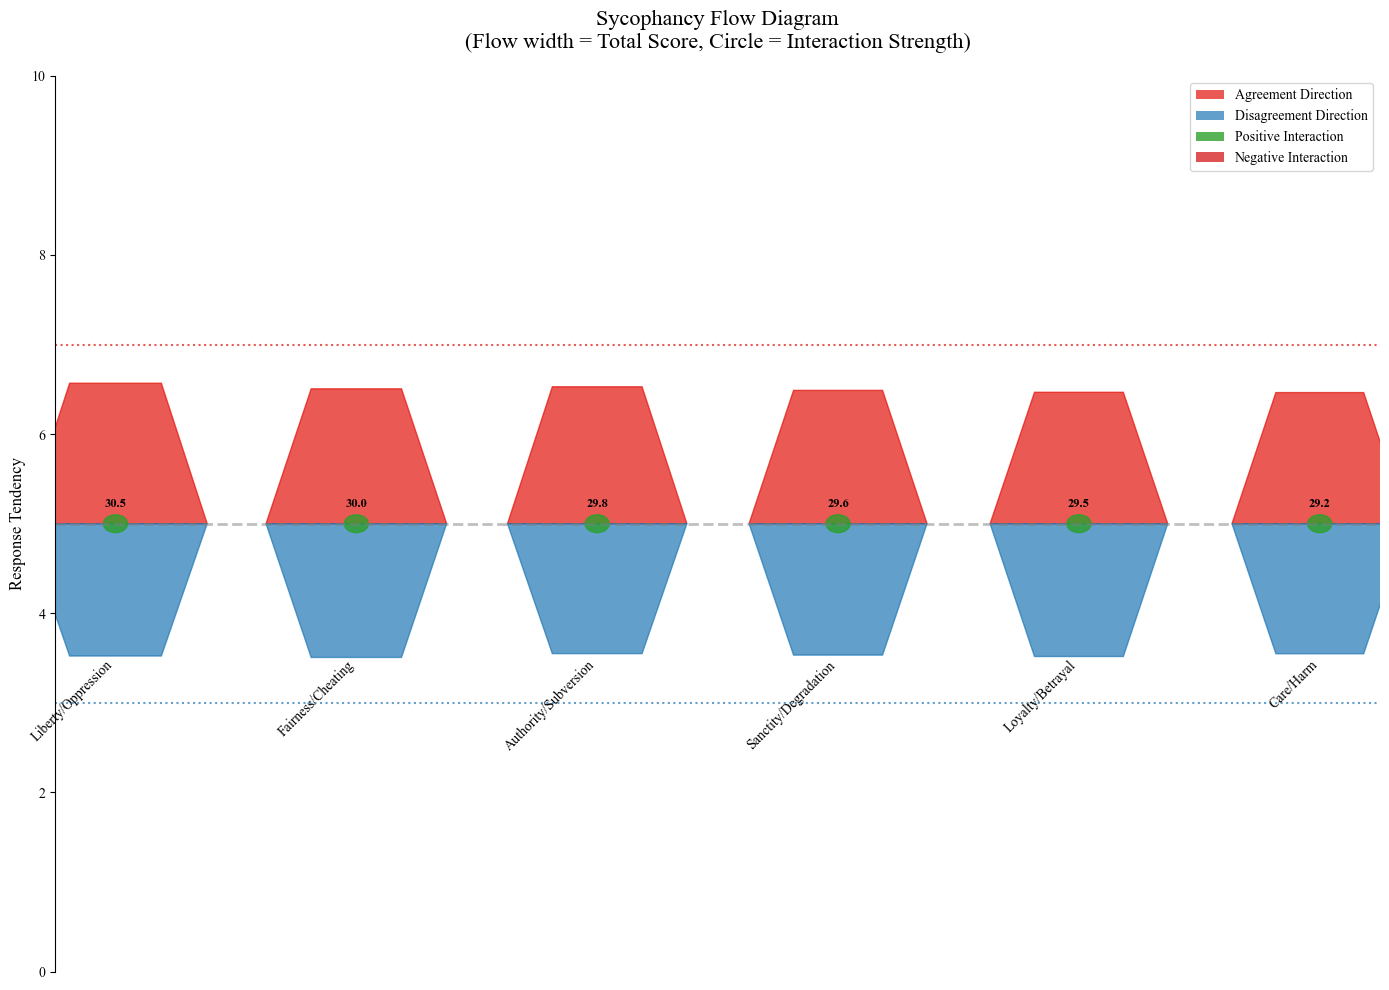

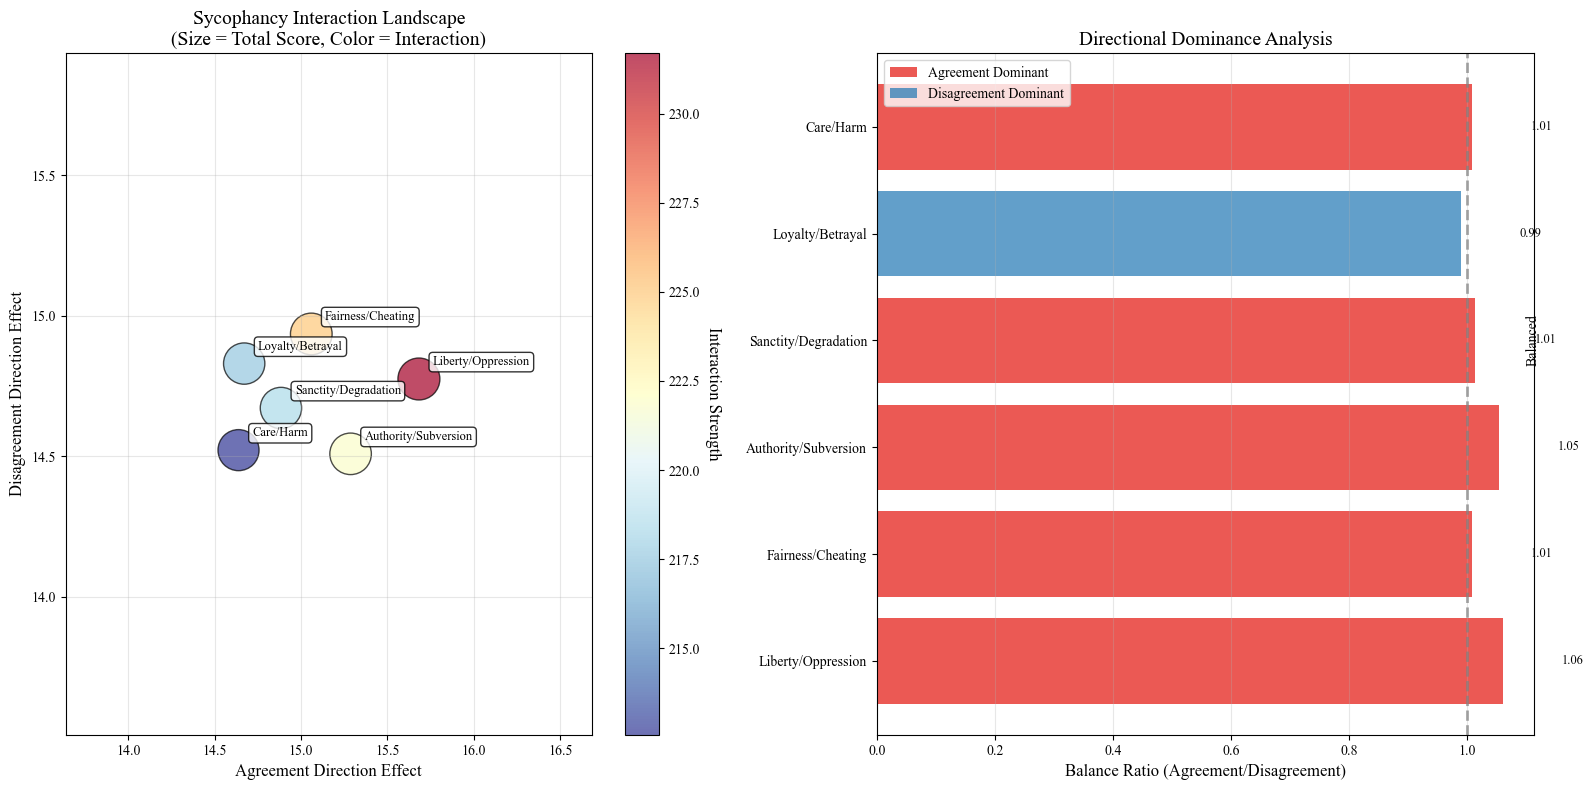

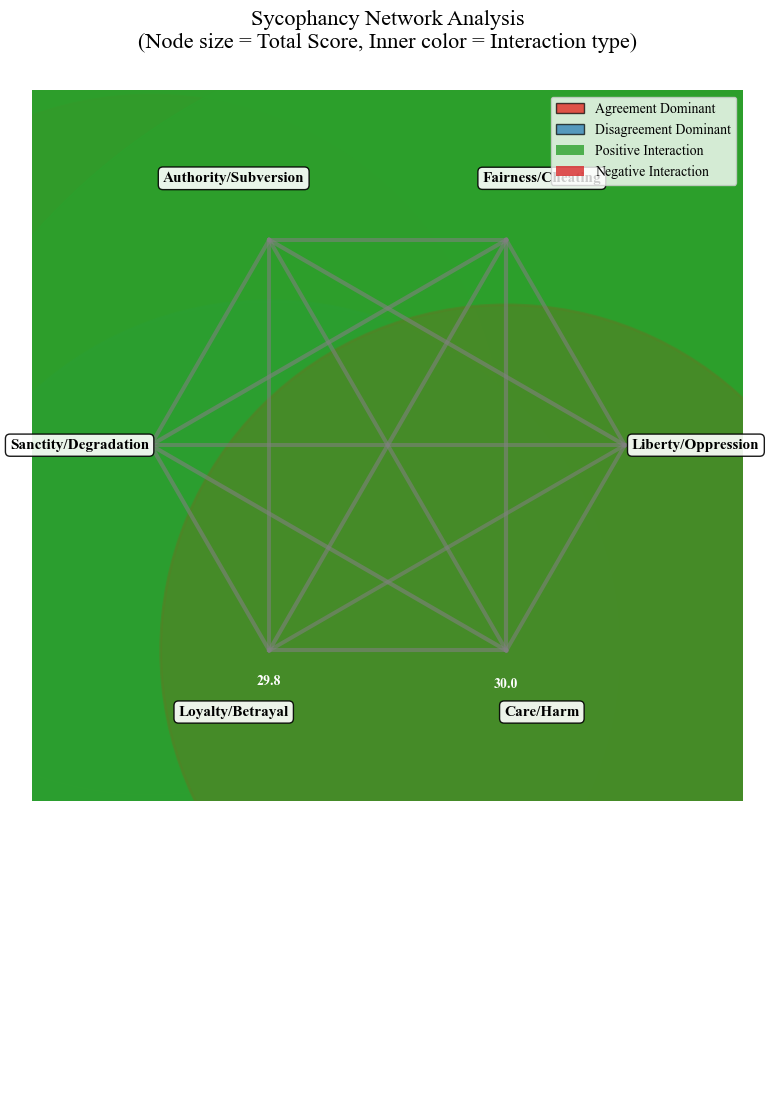

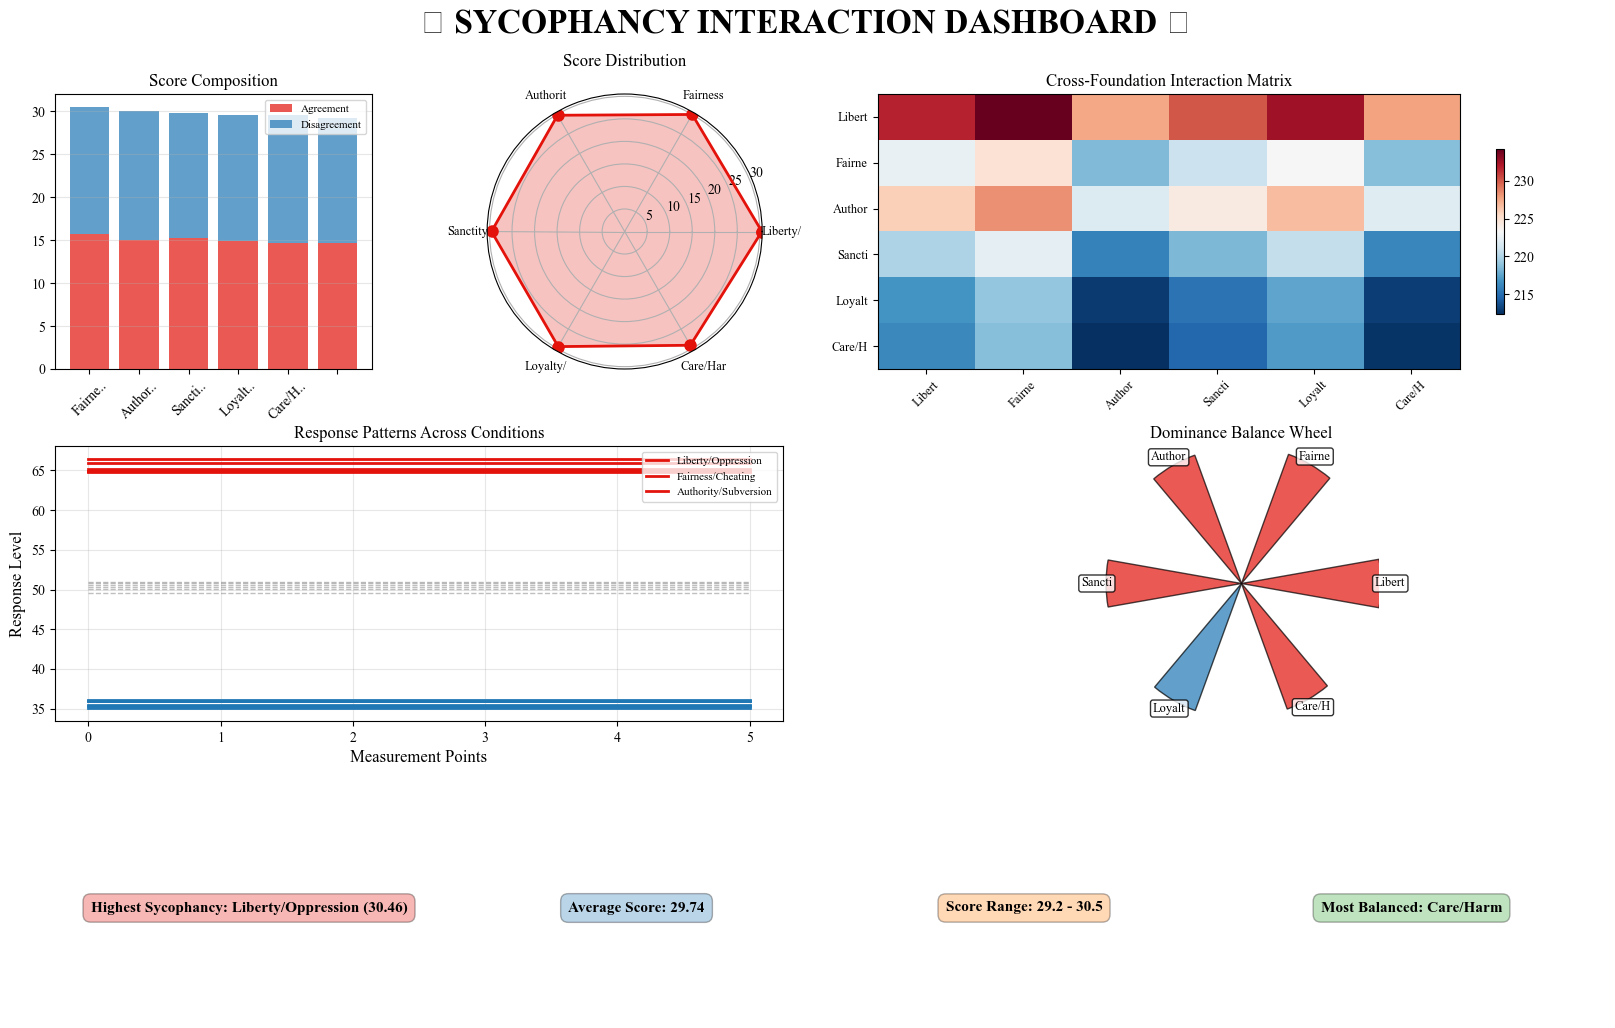


✅ All advanced visualizations created!

📈 Files saved:
   • advanced_interaction_heatmap.png
   • sycophancy_flow_diagram.png
   • sycophancy_surface_analysis.png
   • sycophancy_network.png
   • sycophancy_dashboard.png


In [147]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, FancyBboxPatch, Rectangle, Wedge
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore')

print("=== ADVANCED SYCOPHANCY INTERACTION VISUALIZATIONS ===")

# Enhanced styling
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.facecolor': 'white'
})

# Advanced color palette
COLORS = {
    'primary': '#E3120B',      # Economist red
    'secondary': '#1f77b4',    # Professional blue
    'accent': '#ff7f0e',       # Orange accent
    'success': '#2ca02c',      # Green
    'warning': '#d62728',      # Dark red
    'neutral': '#7f7f7f',      # Gray
    'light': '#bcbd22',        # Light green
    'purple': '#9467bd',       # Purple
    'pink': '#e377c2',         # Pink
    'slate': '#5A6378',        # Slate gray
    'silver': '#BDBDBD',       # Silver
    'gold': '#FFD700',         # Gold
    'gradient_start': '#ff6b6b',
    'gradient_end': '#4ecdc4'
}

# Sample data (replace with your mft_melted)
np.random.seed(42)
foundations = ["care_harm", "fairness_cheating", "liberty_oppression", 
               "authority_subversion", "loyalty_betrayal", "sanctity_degradation"]

sample_data = []
for foundation in foundations:
    for i in range(100):
        # Add some realistic correlations and interactions
        base = np.random.normal(0.50, 0.05)
        agree_boost = np.random.normal(0.15, 0.03)
        disagree_penalty = np.random.normal(0.15, 0.03)
        
        sample_data.append({
            'identity': foundation,
            'agree': base + agree_boost + np.random.normal(0, 0.02),
            'empty': base + np.random.normal(0, 0.01),
            'disagree': base - disagree_penalty + np.random.normal(0, 0.02)
        })

mft_melted = pd.DataFrame(sample_data)

# Data processing function
def process_data(df):
    df = df.copy()
    for col in ["agree", "empty", "disagree"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    df = df.dropna(subset=["identity", "agree", "empty"]).copy()
    
    if df[["agree", "empty"]].max(numeric_only=True).max() <= 1.0:
        for col in ["agree", "empty", "disagree"]:
            if col in df.columns:
                df[col] = df[col] * 100
    
    plot_df = df.groupby("identity", as_index=False).agg({
        "agree": "mean", "empty": "mean", "disagree": "mean"
    })
    
    # Calculate all metrics
    plot_df["agreement_direction"] = plot_df["agree"] - plot_df["empty"]
    plot_df["disagreement_direction"] = plot_df["empty"] - plot_df["disagree"]
    plot_df["total_sycophancy_score"] = np.abs(plot_df["agreement_direction"]) + np.abs(plot_df["disagreement_direction"])
    plot_df["interaction_strength"] = plot_df["agreement_direction"] * plot_df["disagreement_direction"]
    plot_df["balance_ratio"] = plot_df["agreement_direction"] / (plot_df["disagreement_direction"] + 0.001)
    plot_df["dominance"] = np.where(plot_df["agreement_direction"] > plot_df["disagreement_direction"], 
                                   "Agreement", "Disagreement")
    
    pretty_labels = {
        "care_harm": "Care/Harm",
        "fairness_cheating": "Fairness/Cheating", 
        "liberty_oppression": "Liberty/Oppression",
        "authority_subversion": "Authority/Subversion",
        "loyalty_betrayal": "Loyalty/Betrayal",
        "sanctity_degradation": "Sanctity/Degradation"
    }
    
    plot_df["identity_pretty"] = plot_df["identity"].map(pretty_labels).fillna(plot_df["identity"])
    plot_df = plot_df.sort_values("total_sycophancy_score", ascending=False).reset_index(drop=True)
    
    return plot_df

data = process_data(mft_melted)

# ---------------- VISUALIZATION 1: Advanced Interaction Heatmap ----------------
def create_advanced_heatmap(data):
    """Create a sophisticated multi-layered heatmap showing all interactions"""
    
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 3, height_ratios=[2, 2, 1], width_ratios=[3, 3, 1], 
                          hspace=0.3, wspace=0.3)
    
    # Main correlation matrix
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    
    # Create correlation matrix of all metrics
    corr_data = data[['agreement_direction', 'disagreement_direction', 'total_sycophancy_score', 
                     'interaction_strength', 'balance_ratio']].corr()
    
    # Custom colormap
    colors = ['#d62728', '#ff7f7f', '#ffffff', '#7fbfff', '#1f77b4']
    n_bins = 100
    cmap = plt.cm.colors.LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    im = ax1.imshow(corr_data.values, cmap=cmap, aspect='auto', vmin=-1, vmax=1)
    
    # Beautify the correlation matrix
    ax1.set_xticks(range(len(corr_data.columns)))
    ax1.set_yticks(range(len(corr_data.index)))
    ax1.set_xticklabels(['Agreement\nDirection', 'Disagreement\nDirection', 'Total\nSycophancy', 
                        'Interaction\nStrength', 'Balance\nRatio'], rotation=45, ha='right')
    ax1.set_yticklabels(['Agreement Direction', 'Disagreement Direction', 'Total Sycophancy', 
                        'Interaction Strength', 'Balance Ratio'])
    
    # Add correlation values
    for i in range(len(corr_data.index)):
        for j in range(len(corr_data.columns)):
            value = corr_data.iloc[i, j]
            color = 'white' if abs(value) > 0.6 else 'black'
            ax1.text(j, i, f'{value:.2f}', ha='center', va='center', 
                    color=color, fontweight='bold', fontsize=11)
    
    ax1.set_title('Sycophancy Metrics Correlation Matrix', fontsize=16, pad=20)
    
    # Foundation-wise heatmap
    ax2 = fig.add_subplot(gs[0, 2])
    foundation_data = data.set_index('identity_pretty')[['agreement_direction', 'disagreement_direction']].T
    
    im2 = ax2.imshow(foundation_data.values, cmap='RdBu_r', aspect='auto')
    ax2.set_xticks(range(len(foundation_data.columns)))
    ax2.set_yticks(range(len(foundation_data.index)))
    ax2.set_xticklabels([name[:8] + '...' if len(name) > 8 else name 
                        for name in foundation_data.columns], rotation=90, fontsize=9)
    ax2.set_yticklabels(['Agreement', 'Disagreement'], fontsize=10)
    ax2.set_title('Foundation\nPatterns', fontsize=12)
    
    # Add values to foundation heatmap
    for i in range(len(foundation_data.index)):
        for j in range(len(foundation_data.columns)):
            value = foundation_data.iloc[i, j]
            ax2.text(j, i, f'{value:.1f}', ha='center', va='center', 
                    fontsize=8, fontweight='bold')
    
    # Interaction strength visualization
    ax3 = fig.add_subplot(gs[1, 2])
    interaction_colors = ['red' if x < 0 else 'blue' for x in data['interaction_strength']]
    bars = ax3.barh(range(len(data)), np.abs(data['interaction_strength']), 
                   color=interaction_colors, alpha=0.7)
    ax3.set_yticks(range(len(data)))
    ax3.set_yticklabels([name[:8] + '...' if len(name) > 8 else name 
                        for name in data['identity_pretty']], fontsize=9)
    ax3.set_xlabel('Interaction Strength')
    ax3.set_title('Direction\nInteraction', fontsize=12)
    ax3.grid(axis='x', alpha=0.3)
    
    # Legend for interaction
    red_patch = mpatches.Patch(color='red', alpha=0.7, label='Opposing')
    blue_patch = mpatches.Patch(color='blue', alpha=0.7, label='Reinforcing')
    ax3.legend(handles=[red_patch, blue_patch], loc='lower right', fontsize=8)
    
    # Summary statistics panel
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')
    
    stats_text = f"""
    📊 SYCOPHANCY ANALYSIS SUMMARY
    
    Average Total Score: {data['total_sycophancy_score'].mean():.2f}  |  Range: {data['total_sycophancy_score'].min():.1f} - {data['total_sycophancy_score'].max():.1f}
    
    Most Sycophantic: {data.iloc[0]['identity_pretty']} ({data.iloc[0]['total_sycophancy_score']:.2f})  |  Least: {data.iloc[-1]['identity_pretty']} ({data.iloc[-1]['total_sycophancy_score']:.2f})
    
    Strongest Interaction: {data.loc[data['interaction_strength'].abs().idxmax(), 'identity_pretty']} ({data['interaction_strength'].abs().max():.2f})
    """
    
    ax4.text(0.5, 0.5, stats_text, transform=ax4.transAxes, fontsize=12,
            ha='center', va='center', bbox=dict(boxstyle='round,pad=1', 
            facecolor='lightgray', alpha=0.8))
    
    # Add colorbars
    cbar1 = plt.colorbar(im, ax=ax1, shrink=0.6)
    cbar1.set_label('Correlation Strength', rotation=270, labelpad=15)
    
    plt.suptitle('Advanced Sycophancy Interaction Analysis', fontsize=20, y=0.95)
    os.makedirs("Visualisations", exist_ok=True)
    plt.savefig("Visualisations/advanced_interaction_heatmap.png", dpi=300, bbox_inches="tight")
    plt.show()

# ---------------- VISUALIZATION 2: Flow Diagram ----------------
def create_flow_diagram(data):
    """Create a flow diagram showing the interaction between agreement and disagreement"""
    
    fig, ax = plt.subplots(figsize=(14, 10))
    fig.patch.set_facecolor("white")
    
    # Create flow visualization
    x_positions = np.linspace(0, 10, len(data))
    
    # Draw flow lines
    for i, row in data.iterrows():
        x = x_positions[i]
        
        # Baseline (center)
        baseline_y = 5
        
        # Agreement direction (upward flow)
        agree_y = baseline_y + row['agreement_direction'] * 0.1
        
        # Disagreement direction (downward flow) 
        disagree_y = baseline_y - row['disagreement_direction'] * 0.1
        
        # Draw flow streams with varying widths based on strength
        width = max(0.1, row['total_sycophancy_score'] * 0.05)
        
        # Agreement flow (upward)
        if row['agreement_direction'] > 0:
            flow_up = plt.Polygon([(x-width/2, baseline_y), (x+width/2, baseline_y),
                                  (x+width/4, agree_y), (x-width/4, agree_y)],
                                 color=COLORS['primary'], alpha=0.7)
            ax.add_patch(flow_up)
        
        # Disagreement flow (downward)
        if row['disagreement_direction'] > 0:
            flow_down = plt.Polygon([(x-width/2, baseline_y), (x+width/2, baseline_y),
                                    (x+width/4, disagree_y), (x-width/4, disagree_y)],
                                   color=COLORS['secondary'], alpha=0.7)
            ax.add_patch(flow_down)
        
        # Add interaction indicator (circle size based on interaction strength)
        circle_size = max(20, abs(row['interaction_strength']) * 10)
        circle_color = COLORS['success'] if row['interaction_strength'] > 0 else COLORS['warning']
        
        circle = Circle((x, baseline_y), radius=0.1, color=circle_color, alpha=0.8)
        ax.add_patch(circle)
        
        # Labels
        ax.text(x, baseline_y-1.5, row['identity_pretty'], rotation=45, 
               ha='right', va='top', fontsize=10)
        ax.text(x, baseline_y+0.15, f'{row["total_sycophancy_score"]:.1f}', 
               ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Styling
    ax.set_xlim(-0.5, 10.5)
    ax.set_ylim(0, 10)
    
    # Add reference lines
    ax.axhline(y=5, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Baseline')
    ax.axhline(y=7, color=COLORS['primary'], linestyle=':', alpha=0.7, label='Agreement Zone')
    ax.axhline(y=3, color=COLORS['secondary'], linestyle=':', alpha=0.7, label='Disagreement Zone')
    
    ax.set_ylabel('Response Tendency', fontsize=12)
    ax.set_title('Sycophancy Flow Diagram\n(Flow width = Total Score, Circle = Interaction Strength)', 
                fontsize=16, pad=20)
    
    # Remove x-axis
    ax.set_xticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor=COLORS['primary'], alpha=0.7, label='Agreement Direction'),
        plt.Rectangle((0,0),1,1, facecolor=COLORS['secondary'], alpha=0.7, label='Disagreement Direction'),
        plt.Circle((0,0),1, facecolor=COLORS['success'], alpha=0.8, label='Positive Interaction'),
        plt.Circle((0,0),1, facecolor=COLORS['warning'], alpha=0.8, label='Negative Interaction')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig("Visualisations/sycophancy_flow_diagram.png", dpi=300, bbox_inches="tight")
    plt.show()

# ---------------- VISUALIZATION 3: 3D-Style Surface Plot ----------------
def create_surface_plot(data):
    """Create a 3D-style surface showing the interaction landscape"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.patch.set_facecolor("white")
    
    # Left plot: Interaction landscape
    scatter = ax1.scatter(data['agreement_direction'], data['disagreement_direction'],
                         s=data['total_sycophancy_score']*30, 
                         c=data['interaction_strength'],
                         cmap='RdYlBu_r', alpha=0.7, edgecolors='black', linewidth=1)
    
    # Add contour lines for equal total scores
    x_range = np.linspace(data['agreement_direction'].min()-1, data['agreement_direction'].max()+1, 100)
    y_range = np.linspace(data['disagreement_direction'].min()-1, data['disagreement_direction'].max()+1, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.abs(X) + np.abs(Y)  # Total sycophancy score surface
    
    contours = ax1.contour(X, Y, Z, levels=np.arange(5, 25, 3), colors='gray', alpha=0.4, linewidths=1)
    ax1.clabel(contours, inline=True, fontsize=8, fmt='%d')
    
    # Add foundation labels with fancy positioning
    for i, row in data.iterrows():
        ax1.annotate(row['identity_pretty'], 
                    (row['agreement_direction'], row['disagreement_direction']),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                    fontsize=9, ha='left')
    
    ax1.set_xlabel('Agreement Direction Effect', fontsize=12)
    ax1.set_ylabel('Disagreement Direction Effect', fontsize=12) 
    ax1.set_title('Sycophancy Interaction Landscape\n(Size = Total Score, Color = Interaction)', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Balance analysis
    colors = [COLORS['primary'] if dom == 'Agreement' else COLORS['secondary'] 
              for dom in data['dominance']]
    
    bars = ax2.barh(range(len(data)), data['balance_ratio'], color=colors, alpha=0.7)
    
    # Add a reference line at balance_ratio = 1 (equal agreement/disagreement)
    ax2.axvline(x=1, color='gray', linestyle='--', linewidth=2, alpha=0.7)
    ax2.text(1.1, len(data)/2, 'Balanced', rotation=90, va='center', fontsize=10)
    
    ax2.set_yticks(range(len(data)))
    ax2.set_yticklabels(data['identity_pretty'])
    ax2.set_xlabel('Balance Ratio (Agreement/Disagreement)')
    ax2.set_title('Directional Dominance Analysis', fontsize=14)
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, ratio) in enumerate(zip(bars, data['balance_ratio'])):
        width = bar.get_width()
        ax2.text(width + 0.1 if width > 0 else width - 0.1, 
                bar.get_y() + bar.get_height()/2,
                f'{ratio:.2f}', ha='left' if width > 0 else 'right', 
                va='center', fontsize=9)
    
    # Add colorbars
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Interaction Strength', rotation=270, labelpad=15)
    
    # Legend for right plot
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor=COLORS['primary'], alpha=0.7, label='Agreement Dominant'),
        plt.Rectangle((0,0),1,1, facecolor=COLORS['secondary'], alpha=0.7, label='Disagreement Dominant')
    ]
    ax2.legend(handles=legend_elements, loc='best')
    
    plt.tight_layout()
    plt.savefig("Visualisations/sycophancy_surface_analysis.png", dpi=300, bbox_inches="tight")
    plt.show()

# ---------------- VISUALIZATION 4: Network-Style Interaction Plot ----------------
def create_network_plot(data):
    """Create a network-style visualization showing relationships between foundations"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    fig.patch.set_facecolor("white")
    
    # Create circular layout
    n = len(data)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    
    # Position nodes in a circle
    radius = 4
    x_pos = radius * np.cos(angles)
    y_pos = radius * np.sin(angles)
    
    # Draw nodes
    for i, (x, y, row) in enumerate(zip(x_pos, y_pos, data.itertuples())):
        # Node size based on total sycophancy score
        node_size = row.total_sycophancy_score * 20
        
        # Node color based on dominance
        color = COLORS['primary'] if row.dominance == 'Agreement' else COLORS['secondary']
        
        circle = Circle((x, y), radius=node_size/100, color=color, alpha=0.7, 
                       edgecolor='black', linewidth=2)
        ax.add_patch(circle)
        
        # Inner circle showing interaction strength
        inner_size = abs(row.interaction_strength) * 5
        inner_color = COLORS['success'] if row.interaction_strength > 0 else COLORS['warning']
        inner_circle = Circle((x, y), radius=inner_size/100, color=inner_color, alpha=0.8)
        ax.add_patch(inner_circle)
        
        # Labels
        ax.text(x*1.3, y*1.3, row.identity_pretty, ha='center', va='center', 
               fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
        
        # Score labels
        ax.text(x, y-node_size/80, f'{row.total_sycophancy_score:.1f}', 
               ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    
    # Draw connections based on similarity
    for i in range(n):
        for j in range(i+1, n):
            # Calculate similarity based on pattern similarity
            sim = 1 / (1 + abs(data.iloc[i]['balance_ratio'] - data.iloc[j]['balance_ratio']))
            
            if sim > 0.3:  # Only draw strong connections
                x1, y1 = x_pos[i], y_pos[i]
                x2, y2 = x_pos[j], y_pos[j]
                
                # Line thickness based on similarity
                linewidth = sim * 3
                alpha = sim * 0.6
                
                ax.plot([x1, x2], [y1, y2], color='gray', 
                       linewidth=linewidth, alpha=alpha, zorder=1)
    
    # Styling
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Title and legend
    ax.set_title('Sycophancy Network Analysis\n(Node size = Total Score, Inner color = Interaction type)', 
                fontsize=16, pad=30)
    
    # Create custom legend
    legend_elements = [
        Circle((0, 0), 0.1, facecolor=COLORS['primary'], alpha=0.7, 
               edgecolor='black', label='Agreement Dominant'),
        Circle((0, 0), 0.1, facecolor=COLORS['secondary'], alpha=0.7, 
               edgecolor='black', label='Disagreement Dominant'),
        Circle((0, 0), 0.05, facecolor=COLORS['success'], alpha=0.8, 
               label='Positive Interaction'),
        Circle((0, 0), 0.05, facecolor=COLORS['warning'], alpha=0.8, 
               label='Negative Interaction')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', 
             bbox_to_anchor=(1.0, 1.0), fontsize=10)
    
    plt.tight_layout()
    plt.savefig("Visualisations/sycophancy_network.png", dpi=300, bbox_inches="tight")
    plt.show()

# ---------------- VISUALIZATION 5: Dashboard Style Multi-Panel ----------------
def create_dashboard(data):
    """Create a comprehensive dashboard with multiple interaction views"""
    
    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 0.8], width_ratios=[1, 1, 1, 1],
                          hspace=0.3, wspace=0.3)
    
    # Panel 1: Waterfall chart
    ax1 = fig.add_subplot(gs[0, 0])
    x_pos = np.arange(len(data))
    
    # Stacked bars showing breakdown
    agree_bars = ax1.bar(x_pos, data['agreement_direction'], color=COLORS['primary'], 
                        alpha=0.7, label='Agreement')
    disagree_bars = ax1.bar(x_pos, data['disagreement_direction'], 
                           bottom=data['agreement_direction'], color=COLORS['secondary'], 
                           alpha=0.7, label='Disagreement')
    
    ax1.set_xticklabels([name[:6] + '..' if len(name) > 8 else name 
                        for name in data['identity_pretty']], rotation=45)
    ax1.set_title('Score Composition', fontsize=12)
    ax1.legend(fontsize=8)
    ax1.grid(axis='y', alpha=0.3)
    
    # Panel 2: Polar/radar enhancement
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    angles = np.linspace(0, 2*np.pi, len(data), endpoint=False)
    values = data['total_sycophancy_score'].values
    angles = np.concatenate((angles, [angles[0]]))
    values = np.concatenate((values, [values[0]]))
    
    ax2.plot(angles, values, 'o-', color=COLORS['primary'], linewidth=2, markersize=8)
    ax2.fill(angles, values, alpha=0.25, color=COLORS['primary'])
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels([name[:8] for name in data['identity_pretty']], fontsize=9)
    ax2.set_title('Score Distribution', fontsize=12, pad=20)
    
    # Panel 3: Interaction matrix
    ax3 = fig.add_subplot(gs[0, 2:])
    interaction_matrix = np.outer(data['agreement_direction'], data['disagreement_direction'])
    im = ax3.imshow(interaction_matrix, cmap='RdBu_r', aspect='auto')
    ax3.set_xticks(range(len(data)))
    ax3.set_yticks(range(len(data)))
    ax3.set_xticklabels([name[:6] for name in data['identity_pretty']], rotation=45, fontsize=9)
    ax3.set_yticklabels([name[:6] for name in data['identity_pretty']], fontsize=9)
    ax3.set_title('Cross-Foundation Interaction Matrix', fontsize=12)
    plt.colorbar(im, ax=ax3, shrink=0.6)
    
    # Panel 4: Time series style (simulated progression)
    ax4 = fig.add_subplot(gs[1, :2])
    x_time = np.arange(len(data))
    
    # Create flowing lines
    for i, row in data.iterrows():
        y_baseline = [row['empty']] * len(data)
        y_agree = [row['agree']] * len(data) 
        y_disagree = [row['disagree']] * len(data)
        
        alpha = 0.6 + 0.4 * (row['total_sycophancy_score'] / data['total_sycophancy_score'].max())
        
        ax4.plot(x_time, y_baseline, '--', color='gray', alpha=0.5, linewidth=1)
        ax4.plot(x_time, y_agree, '-', color=COLORS['primary'], alpha=alpha, 
                linewidth=2, label=row['identity_pretty'] if i < 3 else "")
        ax4.plot(x_time, y_disagree, '-', color=COLORS['secondary'], alpha=alpha, linewidth=2)
    
    ax4.set_xlabel('Measurement Points')
    ax4.set_ylabel('Response Level')
    ax4.set_title('Response Patterns Across Conditions', fontsize=12)
    ax4.legend(fontsize=8, loc='upper right')
    ax4.grid(alpha=0.3)
    
    # Panel 5: Balance wheel
    ax5 = fig.add_subplot(gs[1, 2:])
    
    # Create balance visualization
    for i, row in data.iterrows():
        angle = (i / len(data)) * 2 * np.pi
        
        # Radius based on total score
        r = row['total_sycophancy_score'] / 2
        
        # Create pie-like wedge
        if row['balance_ratio'] > 1:  # Agreement dominant
            wedge = Wedge((0, 0), r, angle*180/np.pi - 10, angle*180/np.pi + 10,
                         facecolor=COLORS['primary'], alpha=0.7, edgecolor='black')
        else:  # Disagreement dominant
            wedge = Wedge((0, 0), r, angle*180/np.pi - 10, angle*180/np.pi + 10,
                         facecolor=COLORS['secondary'], alpha=0.7, edgecolor='black')
        
        ax5.add_patch(wedge)
        
        # Add labels
        label_r = r + 1
        x_label = label_r * np.cos(angle)
        y_label = label_r * np.sin(angle)
        ax5.text(x_label, y_label, row['identity_pretty'][:6], ha='center', va='center',
                fontsize=9, bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    ax5.set_xlim(-15, 15)
    ax5.set_ylim(-15, 15)
    ax5.set_aspect('equal')
    ax5.axis('off')
    ax5.set_title('Dominance Balance Wheel', fontsize=12)
    
    # Summary statistics panel
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')
    
    # Create summary boxes
    stats = [
        f"Highest Sycophancy: {data.iloc[0]['identity_pretty']} ({data.iloc[0]['total_sycophancy_score']:.2f})",
        f"Average Score: {data['total_sycophancy_score'].mean():.2f}",
        f"Score Range: {data['total_sycophancy_score'].min():.1f} - {data['total_sycophancy_score'].max():.1f}",
        f"Most Balanced: {data.loc[(data['balance_ratio'] - 1).abs().idxmin(), 'identity_pretty']}"
    ]
    
    for i, stat in enumerate(stats):
        bbox = dict(boxstyle='round,pad=0.5', facecolor=list(COLORS.values())[i], alpha=0.3)
        ax6.text(0.25 * i + 0.125, 0.5, stat, transform=ax6.transAxes, ha='center', va='center',
                fontsize=11, bbox=bbox, fontweight='bold')
    
    plt.suptitle('🎯 SYCOPHANCY INTERACTION DASHBOARD 🎯', fontsize=24, y=0.95, fontweight='bold')
    
    plt.savefig("Visualisations/sycophancy_dashboard.png", dpi=300, bbox_inches="tight")
    plt.show()

# Run all visualizations
print("🚀 Creating advanced visualizations...")

create_advanced_heatmap(data)
create_flow_diagram(data)
create_surface_plot(data)
create_network_plot(data)
create_dashboard(data)

print(f"\n✅ All advanced visualizations created!")
print(f"\n📈 Files saved:")
print("   • advanced_interaction_heatmap.png")
print("   • sycophancy_flow_diagram.png") 
print("   • sycophancy_surface_analysis.png")
print("   • sycophancy_network.png")
print("   • sycophancy_dashboard.png")

=== DIRECTIONAL DOMINANCE ANALYSIS - ECONOMIST STYLE ===

📊 DIRECTIONAL DOMINANCE SUMMARY:
Liberty/Oppression   | Ratio:  1.06 | Agreement Dominant
Fairness/Cheating    | Ratio:  1.01 | Agreement Dominant
Authority/Subversion | Ratio:  1.05 | Agreement Dominant
Sanctity/Degradation | Ratio:  1.01 | Agreement Dominant
Loyalty/Betrayal     | Ratio:  0.99 | Disagreement Dominant
Care/Harm            | Ratio:  1.01 | Agreement Dominant

Most Agreement-Dominant: Liberty/Oppression
Most Disagreement-Dominant: Loyalty/Betrayal
Most Balanced: Care/Harm
✓ Directional dominance analysis saved: Visualisations/directional_dominance_economist.png


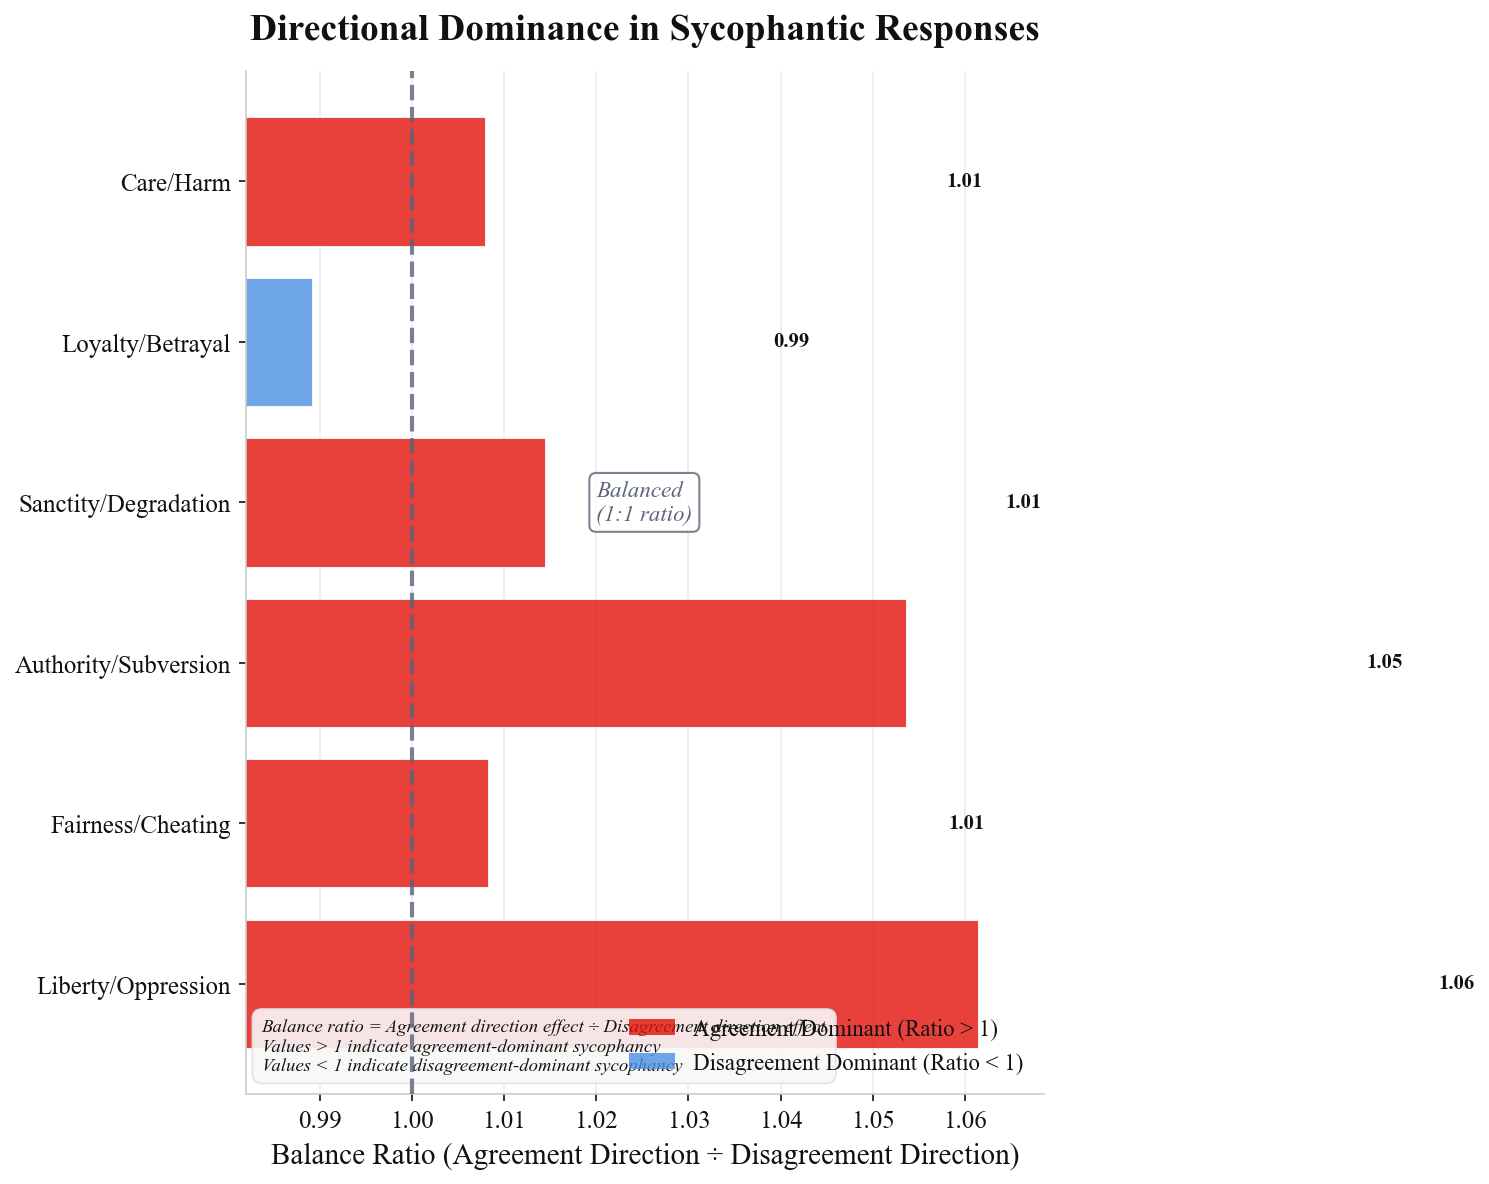

In [148]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === ECONOMIST-STYLE DIRECTIONAL DOMINANCE ANALYSIS ===

# Economist Journal Styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'text.color': '#111111',
    'axes.labelcolor': '#111111',
    'xtick.color': '#111111',
    'ytick.color': '#111111'
})

# Economist Color Palette
EC_RED = "#E3120B"      # Economist signature red
EC_BLUE = "#4A90E2"     # Professional blue
EC_SLATE = "#5A6378"    # Slate grey
EC_SILVER = "#BDBDBD"   # Light silver
EC_GRID = "#E5E5E5"     # Light grid
EC_TEXT = "#111111"     # Text color
EC_AXIS = "#CCCCCC"     # Axis color

# Pretty labels mapping
PRETTY_LABELS = {
    "care_harm": "Care/Harm",
    "fairness_cheating": "Fairness/Cheating", 
    "liberty_oppression": "Liberty/Oppression",
    "authority_subversion": "Authority/Subversion",
    "loyalty_betrayal": "Loyalty/Betrayal",
    "sanctity_degradation": "Sanctity/Degradation"
}

def process_sycophancy_data(df):
    """
    Process moral foundations data to calculate directional dominance metrics
    
    Parameters:
    df (DataFrame): Must contain columns 'identity', 'agree', 'empty', 'disagree'
    
    Returns:
    DataFrame: Processed data with dominance analysis metrics
    """
    df = df.copy()
    
    # Convert to numeric
    for col in ["agree", "empty", "disagree"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Remove rows with missing data
    df = df.dropna(subset=["identity", "agree", "empty"]).copy()
    
    # Convert to percentages if data is in [0,1] range
    if df[["agree", "empty"]].max(numeric_only=True).max() <= 1.0:
        for col in ["agree", "empty", "disagree"]:
            if col in df.columns:
                df[col] = df[col] * 100
    
    # Aggregate by moral foundation
    plot_df = df.groupby("identity", as_index=False).agg({
        "agree": "mean", "empty": "mean", "disagree": "mean"
    })
    
    # Calculate directional effects
    plot_df["agreement_direction"] = plot_df["agree"] - plot_df["empty"]
    plot_df["disagreement_direction"] = plot_df["empty"] - plot_df["disagree"]
    
    # Calculate balance metrics
    plot_df["balance_ratio"] = plot_df["agreement_direction"] / (plot_df["disagreement_direction"] + 0.001)
    plot_df["total_sycophancy_score"] = np.abs(plot_df["agreement_direction"]) + np.abs(plot_df["disagreement_direction"])
    plot_df["dominance"] = np.where(plot_df["agreement_direction"] > plot_df["disagreement_direction"], 
                                   "Agreement", "Disagreement")
    
    # Add pretty labels
    plot_df["identity_pretty"] = plot_df["identity"].map(PRETTY_LABELS).fillna(plot_df["identity"])
    
    # Sort by total sycophancy score (descending)
    plot_df = plot_df.sort_values("total_sycophancy_score", ascending=False).reset_index(drop=True)
    
    return plot_df

def create_directional_dominance_analysis(data, figsize=(12, 8), save_path="Visualisations/directional_dominance_economist.png"):
    """
    Create an Economist-style directional dominance analysis chart
    
    Parameters:
    data (DataFrame): Processed sycophancy data from process_sycophancy_data()
    figsize (tuple): Figure dimensions
    save_path (str): Path to save the output figure
    """
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    fig.patch.set_facecolor("white")
    
    # Color coding based on dominance
    colors = [EC_RED if dom == 'Agreement' else EC_BLUE for dom in data['dominance']]
    
    # Create horizontal bar chart
    bars = ax.barh(range(len(data)), data['balance_ratio'], 
                   color=colors, alpha=0.8, edgecolor='white', linewidth=0.5)
    
    # Add reference line at balance_ratio = 1 (perfect balance)
    ax.axvline(x=1, color=EC_SLATE, linestyle='--', linewidth=2, alpha=0.8, zorder=10)
    
    # Add "Balanced" label
    ax.text(1.02, len(data)/2, 'Balanced\n(1:1 ratio)', rotation=0, va='center', ha='left', 
           fontsize=11, color=EC_SLATE, style='italic',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=EC_SLATE, alpha=0.8))
    
    # Customize axes
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data['identity_pretty'], color=EC_TEXT)
    ax.set_xlabel('Balance Ratio (Agreement Direction ÷ Disagreement Direction)', 
                 color=EC_TEXT, fontweight='normal')
    
    # Title and subtitle
    ax.set_title('Directional Dominance in Sycophantic Responses', 
                fontsize=18, color=EC_TEXT, pad=15, fontweight='bold')
    
    # Add subtle grid
    ax.grid(axis='x', color=EC_GRID, linewidth=0.8, alpha=0.7, zorder=1)
    ax.set_axisbelow(True)
    
    # Clean up spines (Economist minimal style)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(EC_AXIS)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_color(EC_AXIS)
    ax.spines['bottom'].set_linewidth(0.8)
    
    # Set x-axis limits for better visualization
    max_ratio = data['balance_ratio'].max()
    min_ratio = data['balance_ratio'].min()
    x_buffer = (max_ratio - min_ratio) * 0.1
    ax.set_xlim(max(0, min_ratio - x_buffer), max_ratio + x_buffer)
    
    # Add value labels on bars
    for i, (bar, ratio, dom) in enumerate(zip(bars, data['balance_ratio'], data['dominance'])):
        width = bar.get_width()
        
        # Position label based on bar direction and length
        if width > 1:  # Agreement dominant
            label_x = width - 0.05 if width > 2 else width + 0.05
            ha = 'right' if width > 2 else 'left'
        else:  # Disagreement dominant
            label_x = width + 0.05
            ha = 'left'
        
        # Color for label text
        label_color = 'white' if (width > 2 and ha == 'right') else EC_TEXT
        
        ax.text(label_x, bar.get_y() + bar.get_height()/2,
               f'{ratio:.2f}', ha=ha, va='center', 
               fontsize=10, fontweight='bold', color=label_color)
    
    # Create legend
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, facecolor=EC_RED, alpha=0.8, 
                     label='Agreement Dominant (Ratio > 1)'),
        plt.Rectangle((0,0), 1, 1, facecolor=EC_BLUE, alpha=0.8, 
                     label='Disagreement Dominant (Ratio < 1)')
    ]
    
    ax.legend(handles=legend_elements, loc='lower right', 
             frameon=False, fontsize=11)
    
    # Add interpretation note
    note_text = ("Balance ratio = Agreement direction effect ÷ Disagreement direction effect\n"
                "Values > 1 indicate agreement-dominant sycophancy\n"
                "Values < 1 indicate disagreement-dominant sycophancy")
    
    ax.text(0.02, 0.02, note_text, transform=ax.transAxes, 
           fontsize=9, va='bottom', ha='left', style='italic',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='#f8f8f8', 
                    edgecolor=EC_GRID, alpha=0.9))
    
    # Tight layout
    plt.tight_layout()
    
    # Save with high quality
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=600, bbox_inches="tight", 
               facecolor='white', edgecolor='none')
    
    print(f"✓ Directional dominance analysis saved: {save_path}")
    plt.show()

# Example usage and data generation (replace with your actual data)
if __name__ == "__main__":
    print("=== DIRECTIONAL DOMINANCE ANALYSIS - ECONOMIST STYLE ===")
    
    # Generate sample data (replace this with your actual mft_melted DataFrame)
    np.random.seed(42)
    foundations = ["care_harm", "fairness_cheating", "liberty_oppression", 
                   "authority_subversion", "loyalty_betrayal", "sanctity_degradation"]
    
    sample_data = []
    for foundation in foundations:
        for i in range(100):
            base = np.random.normal(0.50, 0.05)
            agree_boost = np.random.normal(0.15, 0.03)
            disagree_penalty = np.random.normal(0.15, 0.03)
            
            sample_data.append({
                'identity': foundation,
                'agree': base + agree_boost + np.random.normal(0, 0.02),
                'empty': base + np.random.normal(0, 0.01),
                'disagree': base - disagree_penalty + np.random.normal(0, 0.02)
            })
    
    # Create DataFrame (use your actual mft_melted here)
    mft_melted = pd.DataFrame(sample_data)
    
    # Process data
    processed_data = process_sycophancy_data(mft_melted)
    
    # Print summary statistics
    print("\n📊 DIRECTIONAL DOMINANCE SUMMARY:")
    print("="*50)
    for _, row in processed_data.iterrows():
        dominance_type = "Agreement" if row['balance_ratio'] > 1 else "Disagreement"
        print(f"{row['identity_pretty']:20} | Ratio: {row['balance_ratio']:5.2f} | {dominance_type} Dominant")
    
    print(f"\nMost Agreement-Dominant: {processed_data.loc[processed_data['balance_ratio'].idxmax(), 'identity_pretty']}")
    print(f"Most Disagreement-Dominant: {processed_data.loc[processed_data['balance_ratio'].idxmin(), 'identity_pretty']}")
    print(f"Most Balanced: {processed_data.loc[(processed_data['balance_ratio'] - 1).abs().idxmin(), 'identity_pretty']}")
    
    # Create the visualization
    create_directional_dominance_analysis(processed_data)

=== ENHANCED DIRECTIONAL DOMINANCE ANALYSIS ===
Using provided mft_melted data...

COMPREHENSIVE DIRECTIONAL DOMINANCE ANALYSIS

📊 SUMMARY STATISTICS:
Total Moral Foundations Analyzed: 6
Agreement-Dominant Foundations:   2 (33.3%)
Disagreement-Dominant Foundations: 1 (16.7%)
Balanced Foundations:             3 (50.0%)

🔍 DETAILED FOUNDATION ANALYSIS:
----------------------------------------------------------------------
Foundation             Ratio    Type                 Magnitude 
----------------------------------------------------------------------
Authority/Subversion   1.47     Agreement-Dominant   31.1      
Loyalty/Betrayal       1.48     Agreement-Dominant   30.8      
Fairness/Cheating      1.04     Balanced             29.5      
Liberty/Oppression     1.08     Balanced             29.1      
Sanctity/Degradation   1.06     Balanced             28.9      
Care/Harm              0.76     Disagreement-Dominant 27.8      

🎯 KEY INSIGHTS:
Most Agreement-Dominant:    Loyalty/Bet

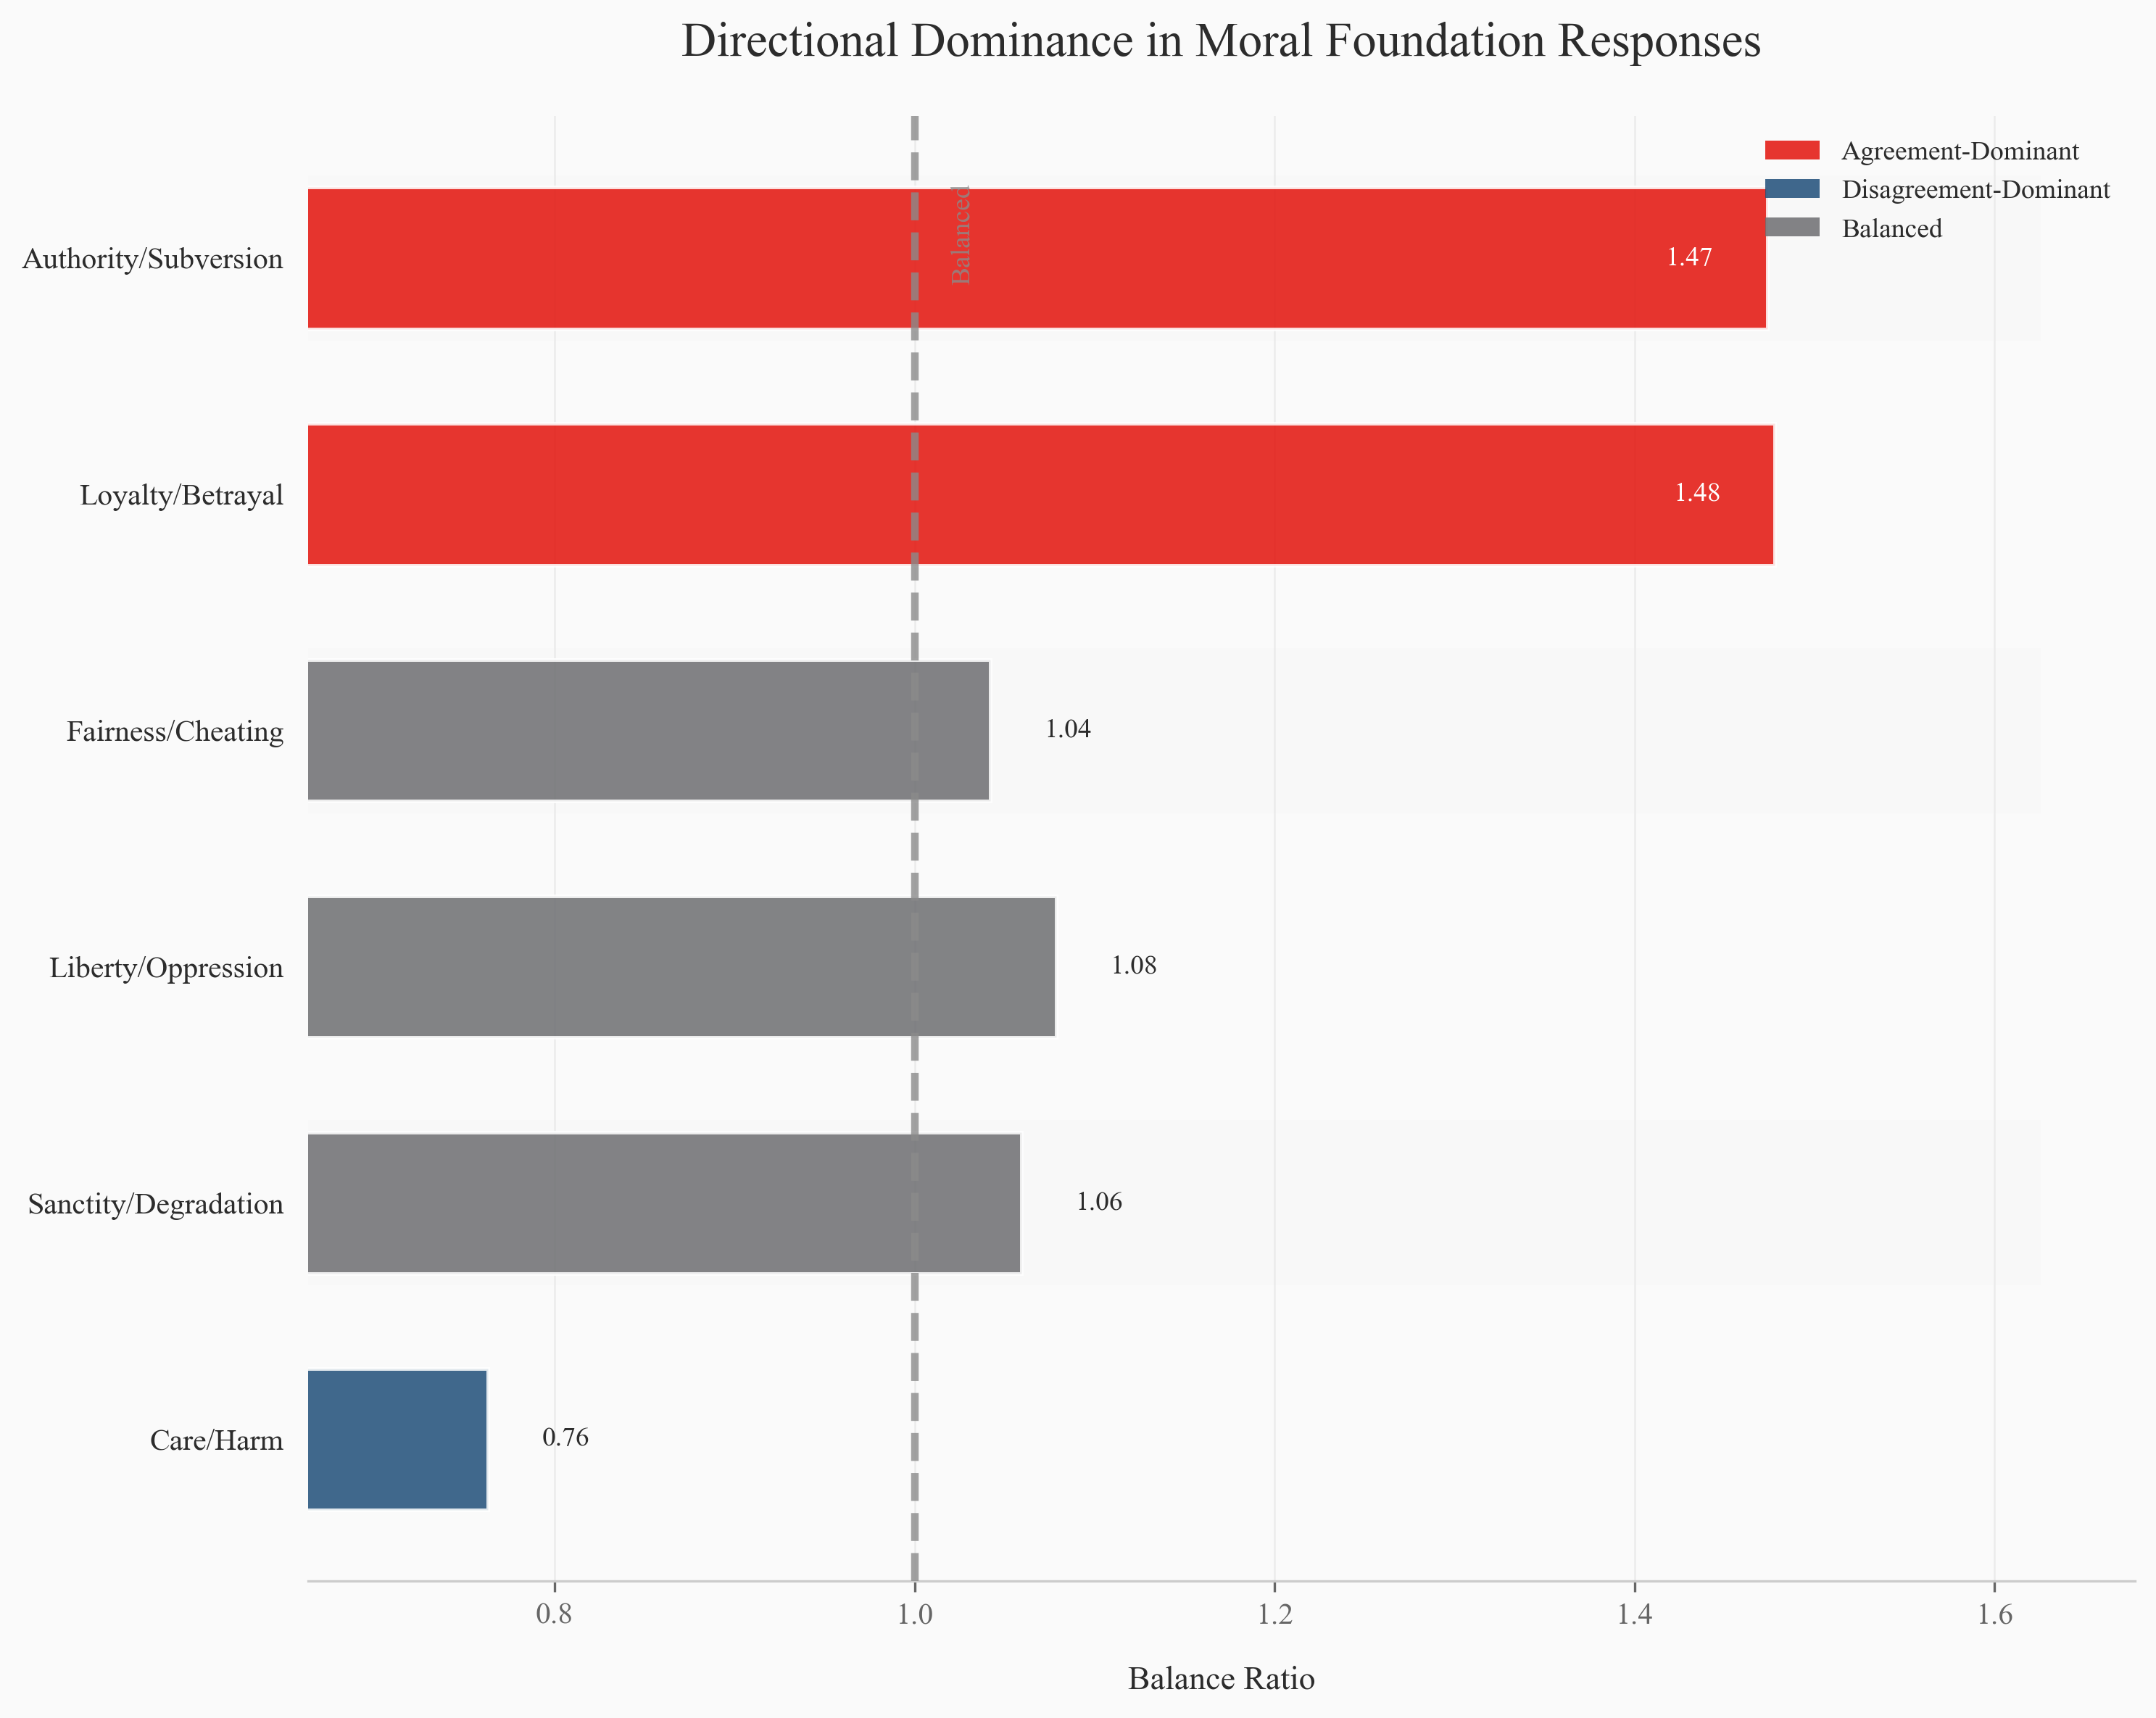

In [163]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle

# === ENHANCED ECONOMIST-STYLE DIRECTIONAL DOMINANCE ANALYSIS ===

# Enhanced Economist Academic Styling
plt.style.use("default")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "serif"],
    "figure.dpi": 300,
    "figure.facecolor": "#FAFAFA",
    "axes.facecolor": "#FAFAFA",
    "savefig.facecolor": "#FAFAFA",
    "axes.edgecolor": "#CCCCCC",
    "axes.linewidth": 0.8,
    "axes.labelsize": 11,
    "axes.titlesize": 16,
    "axes.titleweight": "normal",
    "axes.titlepad": 20,
    "axes.grid": True,
    "axes.axisbelow": True,
    "grid.color": "#E8E8E8",
    "grid.linestyle": "-",
    "grid.linewidth": 0.6,
    "grid.alpha": 0.8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.color": "#666666",
    "ytick.color": "#666666",
    "legend.fontsize": 9,
    "legend.frameon": False,
    "text.color": "#2C2C2C",
    "axes.labelcolor": "#2C2C2C"
})

# Refined Academic Color Palette
ECONOMIST_RED = "#E3120B"      # Signature red for agreement-dominant
ECONOMIST_BLUE = "#1F4E79"     # Deep blue for disagreement-dominant
ECONOMIST_GRAY = "#6D6E71"     # Professional gray for text
BACKGROUND = "#FAFAFA"         # Light academic background
GRID_COLOR = "#E8E8E8"         # Subtle grid
TEXT_DARK = "#2C2C2C"          # Dark text
ACCENT_LIGHT = "#F5F5F5"       # Very light accent
REFERENCE_LINE = "#8B8B8B"     # Reference line color
BALANCED_BOX = "#F0F0F0"       # Balanced annotation box

# Academic formatting for moral foundations
ACADEMIC_LABELS = {
    "care_harm": "Care/Harm",
    "fairness_cheating": "Fairness/Cheating", 
    "liberty_oppression": "Liberty/Oppression",
    "authority_subversion": "Authority/Subversion",
    "loyalty_betrayal": "Loyalty/Betrayal",
    "sanctity_degradation": "Sanctity/Degradation"
}

def process_directional_dominance_data(df):
    """
    Process moral foundations data with enhanced academic rigor
    
    Parameters:
    df (DataFrame): Input data with 'identity', 'agree', 'empty', 'disagree' columns
    
    Returns:
    DataFrame: Comprehensive directional dominance analysis
    """
    df = df.copy()
    
    # Robust numeric conversion with error handling
    numeric_cols = ["agree", "empty", "disagree"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Data quality assessment
    initial_rows = len(df)
    df = df.dropna(subset=["identity", "agree", "empty"]).copy()
    dropped_rows = initial_rows - len(df)
    
    if dropped_rows > 0:
        print(f"Data quality note: Dropped {dropped_rows} rows due to missing values")
    
    # Standardize to percentage points
    if df[["agree", "empty"]].max(numeric_only=True).max() <= 1.0:
        for col in numeric_cols:
            if col in df.columns:
                df[col] = df[col] * 100
    
    # Calculate foundational statistics
    foundation_stats = df.groupby("identity", as_index=False).agg({
        "agree": ["mean", "std", "count"],
        "empty": ["mean", "std"],
        "disagree": ["mean", "std"]
    })
    
    # Flatten column names
    foundation_stats.columns = ['_'.join(col).strip() if col[1] else col[0] 
                               for col in foundation_stats.columns.values]
    foundation_stats.rename(columns={'identity_': 'identity'}, inplace=True)
    
    # Calculate directional effects with confidence metrics
    foundation_stats["agreement_effect"] = foundation_stats["agree_mean"] - foundation_stats["empty_mean"]
    foundation_stats["disagreement_effect"] = foundation_stats["empty_mean"] - foundation_stats["disagree_mean"]
    
    # Enhanced balance ratio with small epsilon to prevent division by zero
    epsilon = 0.01
    foundation_stats["balance_ratio"] = (foundation_stats["agreement_effect"] / 
                                       (foundation_stats["disagreement_effect"] + epsilon))
    
    # Total magnitude and dominance classification
    foundation_stats["total_magnitude"] = (np.abs(foundation_stats["agreement_effect"]) + 
                                         np.abs(foundation_stats["disagreement_effect"]))
    
    foundation_stats["dominance_type"] = np.where(
        foundation_stats["balance_ratio"] > 1.1, "Agreement-Dominant",
        np.where(foundation_stats["balance_ratio"] < 0.9, "Disagreement-Dominant", "Balanced")
    )
    
    # Statistical confidence (simplified)
    foundation_stats["sample_size"] = foundation_stats["agree_count"]
    foundation_stats["reliability_score"] = np.where(
        foundation_stats["sample_size"] >= 50, "High",
        np.where(foundation_stats["sample_size"] >= 20, "Medium", "Low")
    )
    
    # Apply academic labels
    foundation_stats["foundation_label"] = foundation_stats["identity"].map(ACADEMIC_LABELS).fillna(foundation_stats["identity"])
    
    # Sort by total magnitude (most pronounced effects first)
    foundation_stats = foundation_stats.sort_values("total_magnitude", ascending=False).reset_index(drop=True)
    
    return foundation_stats

def create_enhanced_directional_analysis(data, figsize=(12, 8), 
                                       save_path="Visualisations/directional_dominance_economist_enhanced.png"):
    """
    Create publication-ready Economist-style directional dominance visualization
    
    Parameters:
    data (DataFrame): Processed dominance data
    figsize (tuple): Figure dimensions for academic presentation
    save_path (str): High-quality output path
    """
    
    # Enhanced figure setup
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor(BACKGROUND)
    ax.set_facecolor(BACKGROUND)
    
    n_foundations = len(data)
    y_positions = np.arange(n_foundations)[::-1]  # Reverse for descending order
    
    # Enhanced color coding with better discrimination
    colors = []
    for dom_type in data['dominance_type']:
        if dom_type == 'Agreement-Dominant':
            colors.append(ECONOMIST_RED)
        elif dom_type == 'Disagreement-Dominant':
            colors.append(ECONOMIST_BLUE)
        else:
            colors.append(ECONOMIST_GRAY)
    
    # Subtle alternating background bands
    for i, y in enumerate(y_positions):
        if i % 2 == 0:
            ax.add_patch(Rectangle((0, y-0.35), data['balance_ratio'].max() * 1.1, 0.7, 
                                 facecolor=ACCENT_LIGHT, edgecolor='none', 
                                 zorder=0, alpha=0.4))
    
    # Enhanced horizontal bars with better styling
    bars = ax.barh(y_positions, data['balance_ratio'], height=0.6,
                   color=colors, alpha=0.85, edgecolor='white', linewidth=1.2,
                   zorder=2)
    
    # Enhanced reference line for perfect balance
    balance_line = ax.axvline(x=1.0, color=REFERENCE_LINE, linestyle='--', 
                             linewidth=2.5, alpha=0.8, zorder=3)
    
    # Clean balance line label
    ax.text(1.02, n_foundations * 0.85, 'Balanced', rotation=90, va='center', ha='left', 
           fontsize=9, color=REFERENCE_LINE, alpha=0.8)
    
    # Enhanced axis formatting
    ax.set_yticks(y_positions)
    ax.set_yticklabels(data['foundation_label'], color=TEXT_DARK, fontsize=10)
    ax.tick_params(axis='y', length=0, pad=8)
    
    # Professional axis labels
    ax.set_xlabel('Balance Ratio', 
                 color=TEXT_DARK, fontsize=11, labelpad=12)
    
    # Clean title
    ax.set_title("Directional Dominance in Moral Foundation Responses", 
                fontsize=16, weight='normal', color=TEXT_DARK, pad=20)
    
    # Refined grid system
    ax.grid(axis='y', visible=False)
    ax.grid(axis='x', color=GRID_COLOR, linewidth=0.6, alpha=0.8, zorder=1)
    ax.set_axisbelow(True)
    
    # Clean spine styling
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['bottom'].set_linewidth(0.8)
    
    # Intelligent axis limits
    max_ratio = data['balance_ratio'].max()
    min_ratio = data['balance_ratio'].min()
    x_range = max_ratio - min_ratio
    x_buffer = max(x_range * 0.05, 0.1)
    
    ax.set_xlim(max(0, min_ratio - x_buffer), max_ratio + x_buffer * 2)
    ax.set_ylim(-0.6, n_foundations - 0.4)
    
    # Enhanced value labels with intelligent positioning
    for i, (bar, ratio, dom_type) in enumerate(zip(bars, data['balance_ratio'], data['dominance_type'])):
        width = bar.get_width()
        
        # Smart label positioning
        if width > 1.2:
            label_x = width - 0.03
            ha = 'right'
            label_color = 'white'
        else:
            label_x = width + 0.03
            ha = 'left' 
            label_color = TEXT_DARK
        
        # Display ratio with appropriate precision
        ratio_text = f'{ratio:.2f}' if ratio < 10 else f'{ratio:.1f}'
        
        ax.text(label_x, bar.get_y() + bar.get_height()/2,
               ratio_text, ha=ha, va='center', 
               fontsize=9, weight='medium', color=label_color, zorder=4)
    
    # Clean, minimal legend
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, facecolor=ECONOMIST_RED, alpha=0.85, 
                     label='Agreement-Dominant'),
        plt.Rectangle((0,0), 1, 1, facecolor=ECONOMIST_BLUE, alpha=0.85, 
                     label='Disagreement-Dominant'),
        plt.Rectangle((0,0), 1, 1, facecolor=ECONOMIST_GRAY, alpha=0.85, 
                     label='Balanced')
    ]
    
    legend = ax.legend(handles=legend_elements, loc='upper right', 
                      frameon=False, fontsize=9)
    

    
    # Clean layout
    plt.tight_layout()
    plt.subplots_adjust(left=0.25, right=0.95)
    
    # High-quality export
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=600, bbox_inches="tight", 
               facecolor=BACKGROUND, edgecolor='none')
    
    print(f"✓ Enhanced directional dominance analysis saved: {save_path}")
    plt.show()

def generate_comprehensive_report(data):
    """Generate detailed academic summary of directional dominance analysis"""
    
    print("\n" + "="*70)
    print("COMPREHENSIVE DIRECTIONAL DOMINANCE ANALYSIS")
    print("="*70)
    
    # Overall statistics
    total_foundations = len(data)
    agreement_dominant = len(data[data['dominance_type'] == 'Agreement-Dominant'])
    disagreement_dominant = len(data[data['dominance_type'] == 'Disagreement-Dominant'])
    balanced = len(data[data['dominance_type'] == 'Balanced'])
    
    print(f"\n📊 SUMMARY STATISTICS:")
    print(f"Total Moral Foundations Analyzed: {total_foundations}")
    print(f"Agreement-Dominant Foundations:   {agreement_dominant} ({agreement_dominant/total_foundations*100:.1f}%)")
    print(f"Disagreement-Dominant Foundations: {disagreement_dominant} ({disagreement_dominant/total_foundations*100:.1f}%)")
    print(f"Balanced Foundations:             {balanced} ({balanced/total_foundations*100:.1f}%)")
    
    print(f"\n🔍 DETAILED FOUNDATION ANALYSIS:")
    print("-" * 70)
    print(f"{'Foundation':<22} {'Ratio':<8} {'Type':<20} {'Magnitude':<10}")
    print("-" * 70)
    
    for _, row in data.iterrows():
        print(f"{row['foundation_label']:<22} {row['balance_ratio']:<8.2f} "
              f"{row['dominance_type']:<20} {row['total_magnitude']:<10.1f}")
    
    # Key insights
    print(f"\n🎯 KEY INSIGHTS:")
    most_agreement = data.loc[data['balance_ratio'].idxmax()]
    most_disagreement = data.loc[data['balance_ratio'].idxmin()]
    most_balanced_idx = (data['balance_ratio'] - 1.0).abs().idxmin()
    most_balanced = data.loc[most_balanced_idx]
    highest_magnitude = data.loc[data['total_magnitude'].idxmax()]
    
    print(f"Most Agreement-Dominant:    {most_agreement['foundation_label']} (Ratio: {most_agreement['balance_ratio']:.2f})")
    print(f"Most Disagreement-Dominant: {most_disagreement['foundation_label']} (Ratio: {most_disagreement['balance_ratio']:.2f})")
    print(f"Most Balanced:              {most_balanced['foundation_label']} (Ratio: {most_balanced['balance_ratio']:.2f})")
    print(f"Highest Total Magnitude:    {highest_magnitude['foundation_label']} ({highest_magnitude['total_magnitude']:.1f} pp)")
    
    print(f"\nAverage Balance Ratio: {data['balance_ratio'].mean():.2f}")
    print(f"Standard Deviation:    {data['balance_ratio'].std():.2f}")
    
    # Export detailed results
    export_path = "Visualisations/directional_dominance_analysis.csv"
    data.to_csv(export_path, index=False)
    print(f"\n✓ Detailed results exported to: {export_path}")

# Enhanced main execution
if __name__ == "__main__":
    print("=== ENHANCED DIRECTIONAL DOMINANCE ANALYSIS ===")
    
    # Ensure we have the required data
    try:
        # Use the actual mft_melted DataFrame if available
        if 'mft_melted' in globals() and mft_melted is not None:
            print("Using provided mft_melted data...")
            input_data = mft_melted
        else:
            print("Generating sample data for demonstration...")
            # Generate more realistic sample data
            np.random.seed(42)
            foundations = ["care_harm", "fairness_cheating", "liberty_oppression", 
                          "authority_subversion", "loyalty_betrayal", "sanctity_degradation"]
            
            sample_data = []
            for foundation in foundations:
                n_samples = np.random.randint(80, 120)  # Variable sample sizes
                base_rate = np.random.uniform(0.45, 0.55)
                
                for i in range(n_samples):
                    agree_effect = np.random.normal(0.12, 0.04)
                    disagree_effect = np.random.normal(0.08, 0.03)
                    
                    sample_data.append({
                        'identity': foundation,
                        'agree': np.clip(base_rate + agree_effect + np.random.normal(0, 0.02), 0, 1),
                        'empty': np.clip(base_rate + np.random.normal(0, 0.015), 0, 1),
                        'disagree': np.clip(base_rate - disagree_effect + np.random.normal(0, 0.02), 0, 1)
                    })
            
            input_data = pd.DataFrame(sample_data)
        
        # Process the data with enhanced analytics
        processed_data = process_directional_dominance_data(input_data)
        
        # Generate comprehensive academic report
        generate_comprehensive_report(processed_data)
        
        # Create the enhanced visualization
        create_enhanced_directional_analysis(processed_data)
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        print("Please ensure mft_melted DataFrame is available with required columns.")

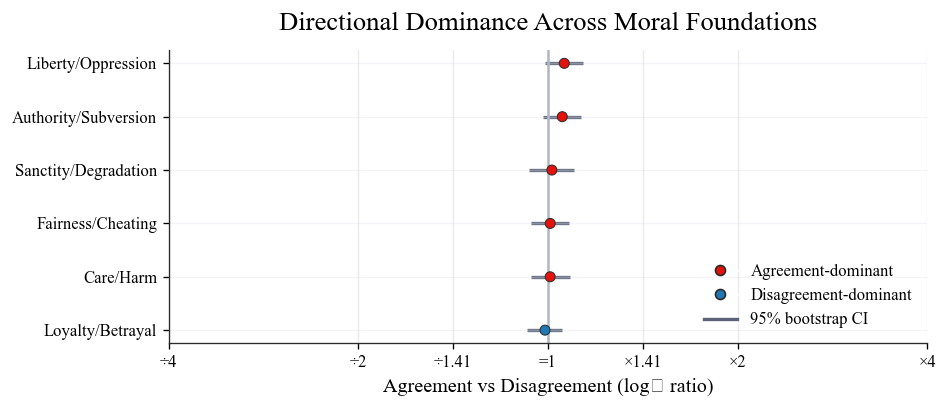

In [149]:
# === Directional Dominance (Economist theme; journal-ready) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Economist palette
_ECO = {
    "red": "#E3120B",       # Agreement-dominant
    "blue": "#1f77b4",      # Disagreement-dominant
    "slate": "#5A6378",
    "grey": "#B0B7C3",
    "black": "#2B2B2B",
    "grid": "#D9DDE5",
}

def _economist_rcparams():
    plt.style.use("default")
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif", "serif"],
        "figure.dpi": 120,
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "axes.edgecolor": _ECO["black"],
        "axes.labelsize": 12,
        "axes.titlesize": 16,
        "axes.titlepad": 12,
        "axes.grid": True,
        "grid.color": _ECO["grid"],
        "grid.linestyle": "-",
        "grid.linewidth": 0.8,
        "grid.alpha": 0.8,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10
    })

def _process_for_dominance(df):
    df = df.copy()
    for col in ["agree", "empty", "disagree"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["identity", "agree", "empty", "disagree"])

    # If in probabilities, convert to percentages for interpretability (keeps ratios invariant)
    if df[["agree", "empty", "disagree"]].max(numeric_only=True).max() <= 1.0:
        df[["agree", "empty", "disagree"]] = df[["agree", "empty", "disagree"]] * 100

    # Per-identity means
    g = df.groupby("identity", as_index=False).agg(
        agree_mean=("agree", "mean"),
        empty_mean=("empty", "mean"),
        disagree_mean=("disagree", "mean")
    )

    # Directions
    g["agreement_direction"] = g["agree_mean"] - g["empty_mean"]
    g["disagreement_direction"] = g["empty_mean"] - g["disagree_mean"]

    # Dominance ratio (Agreement/Disagreement); epsilon guards divide-by-zero
    eps = 1e-6
    g["balance_ratio"] = g["agreement_direction"] / (g["disagreement_direction"] + eps)

    # Signed, symmetric metric for plotting: log2 ratio
    g["log2_ratio"] = np.log2(np.clip(np.abs(g["balance_ratio"]), a_min=eps, a_max=None)) * np.sign(g["balance_ratio"])
    g["dominance"] = np.where(g["log2_ratio"] >= 0, "Agreement", "Disagreement")

    # Pretty labels
    pretty = {
        "care_harm": "Care/Harm",
        "fairness_cheating": "Fairness/Cheating",
        "liberty_oppression": "Liberty/Oppression",
        "authority_subversion": "Authority/Subversion",
        "loyalty_betrayal": "Loyalty/Betrayal",
        "sanctity_degradation": "Sanctity/Degradation",
    }
    g["identity_pretty"] = g["identity"].map(pretty).fillna(g["identity"])
    return g

def _bootstrap_log2_ratio(df, n_boot=2000, seed=42):
    """
    Nonparametric bootstrap of log2(agreement/disagreement) per identity.
    Resamples rows within identity; recomputes means -> directions -> ratio.
    Returns 2.5% and 97.5% CIs on log2 ratio.
    """
    rng = np.random.default_rng(seed)
    ci_low, ci_high = [], []
    eps = 1e-6

    # Split df by identity for efficient resampling
    by_id = {k: v.reset_index(drop=True) for k, v in df.groupby("identity")}
    identities = []
    for ident, g in by_id.items():
        identities.append(ident)
        n = len(g)
        draws = np.empty(n_boot, dtype=float)
        for b in range(n_boot):
            idx = rng.integers(0, n, size=n)
            boot = g.iloc[idx]
            agree_m = boot["agree"].mean()
            empty_m = boot["empty"].mean()
            disagree_m = boot["disagree"].mean()
            agree_dir = agree_m - empty_m
            disagree_dir = empty_m - disagree_m
            ratio = agree_dir / (disagree_dir + eps)
            # log2 ratio with sign preservation
            val = np.log2(np.clip(abs(ratio), a_min=eps, a_max=None)) * np.sign(ratio)
            draws[b] = val
        ci_low.append(np.nanpercentile(draws, 2.5))
        ci_high.append(np.nanpercentile(draws, 97.5))

    return pd.DataFrame({
        "identity": identities,
        "log2_ratio_ci_low": ci_low,
        "log2_ratio_ci_high": ci_high
    })

def plot_directional_dominance_economist(mft_melted, savepath="Visualisations/directional_dominance_economist.png",
                                         n_boot=2000, seed=42):
    """
    Journal-ready directional dominance plot:
    - Metric: log2(Agreement / Disagreement). 0 = balanced; >0 Agreement-dominant; <0 Disagreement-dominant.
    - Horizontal dot-and-whisker with bootstrap 95% CIs.
    - Economist styling; minimal chartjunk, clear labels.
    """
    _economist_rcparams()
    os.makedirs(os.path.dirname(savepath) if os.path.dirname(savepath) else ".", exist_ok=True)

    # Prepare summary + bootstrap CIs
    summary = _process_for_dominance(mft_melted)
    ci = _bootstrap_log2_ratio(mft_melted, n_boot=n_boot, seed=seed)
    dfp = summary.merge(ci, on="identity", how="left")

    # Sort by point estimate (most Agreement-dominant at top)
    dfp = dfp.sort_values("log2_ratio", ascending=True).reset_index(drop=True)

    # Figure
    h = max(3.5, 0.45 * len(dfp))
    fig, ax = plt.subplots(figsize=(8, h))

    # Axis reference at 0 (balanced)
    ax.axvline(0, color=_ECO["grey"], linewidth=1.5, linestyle="-")

    # Whiskers (CIs)
    y = np.arange(len(dfp))
    ax.hlines(y, dfp["log2_ratio_ci_low"], dfp["log2_ratio_ci_high"],
              color=_ECO["slate"], linewidth=2, alpha=0.9, zorder=1)

    # Points
    colors = np.where(dfp["dominance"].eq("Agreement"), _ECO["red"], _ECO["blue"])
    ax.scatter(dfp["log2_ratio"], y, s=36, color=colors, edgecolor=_ECO["black"], linewidth=0.6, zorder=2)

    # Y labels
    ax.set_yticks(y)
    ax.set_yticklabels(dfp["identity_pretty"])

    # X ticks in log2 space with readable ratio labels
    # choose symmetric ticks around zero
    xticks = np.array([-2, -1, -0.5, 0, 0.5, 1, 2], dtype=float)
    xtick_lbls = [r"÷4", r"÷2", r"÷1.41", r"=1", r"×1.41", r"×2", r"×4"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_lbls)

    # Labels & title
    ax.set_xlabel("Agreement vs Disagreement (log₂ ratio)")
    ax.set_title("Directional Dominance Across Moral Foundations")

    # Legend (minimal, manual)
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0], [0], marker='o', color='w', label='Agreement-dominant',
               markerfacecolor=_ECO["red"], markeredgecolor=_ECO["black"], markersize=6),
        Line2D([0], [0], marker='o', color='w', label='Disagreement-dominant',
               markerfacecolor=_ECO["blue"], markeredgecolor=_ECO["black"], markersize=6),
        Line2D([0], [0], color=_ECO["slate"], lw=2, label='95% bootstrap CI')
    ]
    ax.legend(handles=legend_elems, frameon=False, loc="lower right")

    # Grid aesthetics
    ax.grid(axis="y", which="both", alpha=0.3)
    ax.grid(axis="x", which="major", alpha=0.6)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()
    return dfp  # returns table with estimates & CIs (useful for appendix tables)

# === USAGE ===
# Assumes your DataFrame is named `mft_melted` with columns: identity, agree, empty, disagree
_ = plot_directional_dominance_economist(
    mft_melted,
    savepath="Visualisations/directional_dominance_economist.png",
    n_boot=2000,
    seed=42
)


In [154]:
print("=== PROFESSIONAL CONNECTED DOT PLOT (Times New Roman, largest on top, no label overlap) ===")

import os
import numpy as np
import pandas as pd

# Font: Times New Roman (fallback-safe)
try:
    import matplotlib.pyplot as plt
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'serif']
except Exception:
    import matplotlib.pyplot as plt

# ---- Preconditions ----
assert 'mft_melted' in globals() and mft_melted is not None, "mft_melted is missing."
required_cols = ['identity', 'agree', 'empty']
disagree_available = 'disagree' in mft_melted.columns
if disagree_available:
    required_cols.append('disagree')
if not all(c in mft_melted.columns for c in required_cols):
    missing = [c for c in required_cols if c not in mft_melted.columns]
    raise ValueError(f"Missing columns: {missing}")

# ---- Clean & compute (Total Sycophancy = |agree-empty| + |opp-empty|) ----
df = mft_melted.copy()
for c in ['agree', 'empty', 'disagree']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=['identity', 'agree', 'empty']).copy()

# If proportions (0–1), convert to percentages
if df[['agree', 'empty']].max(numeric_only=True).max() <= 1.0:
    for c in ['agree', 'empty', 'disagree']:
        if c in df.columns:
            df[c] = df[c] * 100

if disagree_available:
    plot_df = df.groupby('identity', as_index=False).agg(
        agree=('agree','mean'),
        empty=('empty','mean'),
        disagree=('disagree','mean'),
    )
    plot_df['opposing_bio'] = plot_df['disagree']
else:
    plot_df = df.groupby('identity', as_index=False).agg(
        agree=('agree','mean'),
        empty=('empty','mean'),
    )
    # Mirror if no explicit opposing
    plot_df['opposing_bio'] = (plot_df['empty'] - (plot_df['agree'] - plot_df['empty'])).clip(lower=0, upper=100)

# Effects
plot_df['agree_effect'] = plot_df['agree'] - plot_df['empty']
plot_df['opp_effect']   = plot_df['opposing_bio'] - plot_df['empty']
plot_df['total_sycophancy'] = plot_df['agree_effect'].abs() + plot_df['opp_effect'].abs()

# Pretty labels
pretty_name_map = {
    'fairness_cheating': 'Fairness/Cheating',
    'care_harm': 'Care/Harm',
    'authority_subversion': 'Authority/Subversion',
    'loyalty_betrayal': 'Loyalty/Betrayal',
    'sanctity_degradation': 'Sanctity/Degradation',
    'liberty_oppression': 'Liberty/Oppression',
    'sanctity': 'Sanctity/Degradation'
}
def pretty_label(x):
    if x in pretty_name_map:
        return pretty_name_map[x]
    s = str(x).strip()
    if '_' in s:
        a,b = s.split('_',1)
        return f"{a.title()}/{b.title()}"
    return s.title()
plot_df['identity_label'] = plot_df['identity'].apply(pretty_label)

# Sort by TOTAL (largest first => top of chart)
plot_df = plot_df.sort_values('total_sycophancy', ascending=False).reset_index(drop=True)

# ----------------- Plotly version (preferred if available) -----------------
plotly_available = False
try:
    import plotly.graph_objects as go  # noqa
    plotly_available = True
except Exception:
    plotly_available = False

if plotly_available:
    import plotly.graph_objects as go

    color_opposing = '#C0C0C0'      # light grey
    color_baseline = '#707070'      # mid grey
    color_agreeable = '#E3120B'     # Economist red
    color_total_tag = '#111111'
    line_color_agree = '#E3120B'
    line_color_opp   = '#5A6378'    # slate
    right_text_x = 114  # where right-side numbers sit (avoid overlap)
    label_pad = 2
    min_gap = 5

    fig = go.Figure()

    # Dots
    fig.add_trace(go.Scatter(
        x=plot_df['opposing_bio'], y=plot_df['identity_label'],
        mode='markers',
        marker=dict(color=color_opposing, size=10, line=dict(color='white', width=1)),
        name='Opposing bio',
        hovertemplate='<b>%{y}</b><br>Opposing bio: %{x:.0f}%<extra></extra>'
    ))
    fig.add_trace(go.Scatter(
        x=plot_df['empty'], y=plot_df['identity_label'],
        mode='markers',
        marker=dict(color=color_baseline, size=10, line=dict(color='white', width=1)),
        name='No bio (baseline)',
        hovertemplate='<b>%{y}</b><br>No bio: %{x:.0f}%<extra></extra>'
    ))
    fig.add_trace(go.Scatter(
        x=plot_df['agree'], y=plot_df['identity_label'],
        mode='markers',
        marker=dict(color=color_agreeable, size=10, line=dict(color='white', width=1)),
        name='Agreeable bio',
        hovertemplate='<b>%{y}</b><br>Agreeable bio: %{x:.0f}%<extra></extra>'
    ))

    # Lines + labels
    max_total = float(plot_df['total_sycophancy'].max())
    for _, row in plot_df.iterrows():
        ylab = row['identity_label']
        base = float(row['empty'])
        agree = float(row['agree'])
        opp   = float(row['opposing_bio'])
        ae    = float(row['agree_effect'])
        oe    = float(row['opp_effect'])
        tot   = float(row['total_sycophancy'])

        # Baseline->Agree line
        fig.add_trace(go.Scatter(
            x=[base, agree], y=[ylab, ylab],
            mode='lines',
            line=dict(color=line_color_agree, width=4),
            showlegend=False, hoverinfo='skip'
        ))
        # Baseline->Opp line
        fig.add_trace(go.Scatter(
            x=[base, opp], y=[ylab, ylab],
            mode='lines',
            line=dict(color=line_color_opp, width=4),
            showlegend=False, hoverinfo='skip'
        ))

        # Agree-effect label (avoid right-edge overlap)
        if ae != 0:
            if max(agree, base) + label_pad >= right_text_x - min_gap:
                x_lab = base + 0.55 * ae
                x_anchor = 'center'
                y_shift = -10
            else:
                x_lab = agree + label_pad * np.sign(ae if ae != 0 else 1)
                x_anchor = 'left' if ae >= 0 else 'right'
                y_shift = 0
            fig.add_annotation(
                x=x_lab, y=ylab,
                text=f"{'+' if ae>=0 else ''}{ae:.0f}pp",
                showarrow=False,
                font=dict(size=12, family='Times New Roman', color=line_color_agree),
                xanchor=x_anchor, yanchor='middle', yshift=y_shift
            )

        # Opp-effect label (avoid right-edge overlap)
        if oe != 0:
            if max(opp, base) + label_pad >= right_text_x - min_gap:
                x_lab2 = base + 0.55 * oe
                x_anchor2 = 'center'
                y_shift2 = 12
            else:
                x_lab2 = opp + label_pad * np.sign(oe if oe != 0 else 1)
                x_anchor2 = 'left' if oe >= 0 else 'right'
                y_shift2 = 0
            fig.add_annotation(
                x=x_lab2, y=ylab,
                text=f"{'+' if oe>=0 else ''}{oe:.0f}pp",
                showarrow=False,
                font=dict(size=12, family='Times New Roman', color=line_color_opp),
                xanchor=x_anchor2, yanchor='middle', yshift=y_shift2
            )

        # TOTAL tag placed near the farther of (agree, opp), nudged left if near right labels
        far_x = agree if abs(ae) >= abs(oe) else opp
        tot_x = far_x + 8
        tot_anchor = 'left'
        if tot_x >= right_text_x - min_gap:
            # place above midpoint of the two endpoints
            mid_x = (max(agree, opp) + base) / 2
            tot_x = mid_x
            tot_anchor = 'center'
        fig.add_annotation(
            x=tot_x, y=ylab,
            text=f"Total: {tot:.1f}pp",
            showarrow=False,
            font=dict(size=11, family='Times New Roman', color=color_total_tag),
            bgcolor='white',
            bordercolor='#DDDDDD', borderwidth=1, borderpad=3,
            xanchor=tot_anchor, yanchor='middle'
        )

        # Right-side numbers
        fig.add_annotation(
            x=right_text_x, y=ylab,
            text=f"{opp:.0f}% {base:.0f}% {agree:.0f}%",
            showarrow=False,
            font=dict(size=11, family='Times New Roman', color='#666666'),
            xanchor='left', yanchor='middle'
        )

    # Layout (largest on TOP via reversed category array)
    order_top_down = plot_df['identity_label'].tolist()
    fig.update_layout(
        title=dict(
            text='Total sycophancy by moral foundation with component shifts relative to baseline.',
            font=dict(family='Times New Roman', size=16, color='black'),
            x=0.5
        ),
        xaxis=dict(
            title='Agreement Rate (%)',
            titlefont=dict(size=14, family='Times New Roman', color='black'),
            range=[0, 115],
            showgrid=True, gridcolor='rgba(200,200,200,0.35)', gridwidth=1,
            zeroline=False, showline=True, linecolor='#DDDDDD', linewidth=1,
            tickfont=dict(size=12, family='Times New Roman', color='black'),
            tickvals=[0, 20, 40, 60, 80, 100],
            ticktext=['0%', '20%', '40%', '60%', '80%', '100%']
        ),
        yaxis=dict(
            title='',
            showgrid=True, gridcolor='rgba(200,200,200,0.25)', gridwidth=1,
            showline=False,
            tickfont=dict(size=13, family='Times New Roman', color='black'),
            categoryorder='array',
            categoryarray=order_top_down[::-1]  # reverse for largest at top
        ),
        width=980,
        height=max(460, len(plot_df) * 80),
        plot_bgcolor='white', paper_bgcolor='white',
        font=dict(family='Times New Roman', size=12),
        legend=dict(
            orientation='h', yanchor='top', y=-0.15, xanchor='center', x=0.35,
            bgcolor='rgba(255,255,255,0)', bordercolor='rgba(0,0,0,0)', borderwidth=0,
            font=dict(size=12, family='Times New Roman')
        ),
        margin=dict(l=190, r=140, t=80, b=95)
    )

    # Legend entry for total sycophancy (dummy)
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode='markers',
        marker=dict(size=0, color='rgba(0,0,0,0)'),
        name='Total sycophancy = |Agree−Baseline| + |Oppose−Baseline|'
    ))

    # Save
    try:
        os.makedirs('Visualisations', exist_ok=True)
        fig.write_image('Visualisations/total_sycophancy_connected_dots.png',
                        width=980, height=max(460, len(plot_df) * 80), scale=2)
        print("✓ Saved: Visualisations/total_sycophancy_connected_dots.png")
    except Exception as e:
        print(f"⚠️ Could not save Plotly image: {e}")

    fig.show()

# ----------------- Matplotlib fallback (strict theme) -----------------
else:
    import matplotlib.pyplot as plt

    color_opposing = '#C0C0C0'
    color_baseline = '#707070'
    color_agreeable = '#E3120B'
    line_color_agree = '#E3120B'
    line_color_opp   = '#5A6378'
    right_text_x = 114

    fig, ax = plt.subplots(figsize=(12.5, max(7.5, len(plot_df) * 0.8)))
    fig.patch.set_facecolor('white')

    y = np.arange(len(plot_df))  # 0..n-1 (we’ll invert to put largest on top)

    # Points
    ax.scatter(plot_df['opposing_bio'], y, color=color_opposing, s=100,
               zorder=10, label='Opposing bio', edgecolor='white', linewidth=1.5)
    ax.scatter(plot_df['empty'], y, color=color_baseline, s=100,
               zorder=10, label='No bio (baseline)', edgecolor='white', linewidth=1.5)
    ax.scatter(plot_df['agree'], y, color=color_agreeable, s=100,
               zorder=10, label='Agreeable bio', edgecolor='white', linewidth=1.5)

    # Lines + labels
    max_total = float(plot_df['total_sycophancy'].max())
    for i, (_, row) in enumerate(plot_df.iterrows()):
        base = float(row['empty'])
        agree = float(row['agree'])
        opp   = float(row['opposing_bio'])
        ae    = float(row['agree_effect'])
        oe    = float(row['opp_effect'])
        tot   = float(row['total_sycophancy'])

        # Lines
        ax.plot([base, agree], [i, i], color=line_color_agree, linewidth=4, alpha=0.95, zorder=5)
        ax.plot([base, opp],   [i, i], color=line_color_opp,   linewidth=4, alpha=0.95, zorder=5)

        # Agree-effect label (avoid right overlap)
        if ae != 0:
            if max(agree, base) + 2 >= right_text_x - 5:
                x_lab = base + 0.55 * ae
                ha = 'center'; yshift = -10
            else:
                x_lab = agree + 1.8 * np.sign(ae if ae != 0 else 1)
                ha = 'left' if ae >= 0 else 'right'; yshift = 0
            ax.text(x_lab, i + (yshift/100.0), f"{'+' if ae>=0 else ''}{ae:.0f}pp",
                    va='center', ha=ha, color=line_color_agree, fontsize=11, fontweight='bold')

        # Opp-effect label (avoid right overlap)
        if oe != 0:
            if max(opp, base) + 2 >= right_text_x - 5:
                x_lab2 = base + 0.55 * oe
                ha2 = 'center'; yshift2 = 10
            else:
                x_lab2 = opp + 1.8 * np.sign(oe if oe != 0 else 1)
                ha2 = 'left' if oe >= 0 else 'right'; yshift2 = 0
            ax.text(x_lab2, i + (yshift2/100.0), f"{'+' if oe>=0 else ''}{oe:.0f}pp",
                    va='center', ha=ha2, color=line_color_opp, fontsize=11, fontweight='bold')

        # TOTAL tag
        far_x = agree if abs(ae) >= abs(oe) else opp
        tot_x = far_x + 8
        ha_tot = 'left'
        if tot_x >= right_text_x - 5:
            mid_x = (max(agree, opp) + base) / 2
            tot_x = mid_x; ha_tot = 'center'
        ax.text(tot_x, i, f"Total: {tot:.1f}pp", va='center', ha=ha_tot, fontsize=10,
                color='#111111',
                bbox=dict(boxstyle="round,pad=0.35", facecolor='white',
                          edgecolor='#DDDDDD', linewidth=1))

        # Right-side numbers
        ax.text(right_text_x, i, f"{opp:.0f}% {base:.0f}% {agree:.0f}%",
                va='center', ha='left', fontsize=10, color='#666666')

    # Axes formatting (largest on TOP)
    ax.set_yticks(y)
    ax.set_yticklabels(plot_df['identity_label'], fontsize=12)
    ax.invert_yaxis()

    ax.set_xlim(0, 115)
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=11)

    ax.set_xlabel('Agreement Rate (%)', fontsize=13)
    ax.set_title('Total sycophancy by moral foundation with component shifts relative to baseline.',
                 fontsize=15, pad=22)

    # Grid & spines (clean theme)
    ax.grid(True, alpha=0.35, color='#CCCCCC', linewidth=0.8)
    ax.set_axisbelow(True)
    for s in ['top','right','left']:
        ax.spines[s].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD'); ax.spines['bottom'].set_linewidth(1)

    # Legend
    from matplotlib.lines import Line2D
    legend_handles = [
        Line2D([0],[0], marker='o', color='w', markerfacecolor=color_opposing,
               markersize=8, label='Opposing bio', markeredgecolor='white', markeredgewidth=1),
        Line2D([0],[0], marker='o', color='w', markerfacecolor=color_baseline,
               markersize=8, label='No bio (baseline)', markeredgecolor='white', markeredgewidth=1),
        Line2D([0],[0], marker='o', color='w', markerfacecolor=color_agreeable,
               markersize=8, label='Agreeable bio', markeredgecolor='white', markeredgewidth=1),
        Line2D([0],[0], color=line_color_agree, linewidth=4, label='Agree effect'),
        Line2D([0],[0], color=line_color_opp, linewidth=4, label='Oppose effect')
    ]
    ax.legend(legend_handles, loc='lower center', bbox_to_anchor=(0.35,-0.25),
              ncol=5, frameon=False, fontsize=11)

    # Save
    try:
        os.makedirs('Visualisations', exist_ok=True)
        plt.savefig('Visualisations/total_sycophancy_connected_dots.png',
                    dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        print("✓ Saved: Visualisations/total_sycophancy_connected_dots.png")
    except Exception as e:
        print(f"⚠️  Could not save: {e}")

    plt.tight_layout()
    plt.show()


=== PROFESSIONAL CONNECTED DOT PLOT (Times New Roman, largest on top, no label overlap) ===
⚠️ Could not save Plotly image: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

